##### Copyright 2022 The TensorFlow Compression Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [14]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

#read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
#pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


ERROR: Could not find a version that satisfies the requirement tensorflow-compression<.1 (from versions: 2.12.0, 2.13.0, 2.14.0)
ERROR: No matching distribution found for tensorflow-compression<.1


CalledProcessError: Command 'b'# Installs the latest version of TFC compatible with the installed TF version.\n\nread MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e \'s/.*Version: (\\d+)\\.(\\d+).*/\\1 \\2/sg\')"\npip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"\n'' returned non-zero exit status 1.

Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import os


use_COLAB = 0 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)


2023-12-14 11:45:55.530583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [121]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
import re
import random
import numpy as np
import os
from astropy.io import fits

# Specify the directory containing the .tar files
directory_path = './columbialensing/'


# image_size
image_size = 1024
sub_image_size = 64 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations



number_subimages_across =image_size//sub_image_size


number_fits_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"



def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data #take log of data 

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    maxval = np.max(original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)])
                    minval = np.min(original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)])
                    #data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = (original_data[sub_image_size*i:sub_image_size*(i+1),\
                    #                                              sub_image_size*j:sub_image_size*(j+1)]+minval)/(maxval-minval)
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]/RMS
    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension

reading in Om0.268_si0.801
RMS=0.018752897158265114


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [122]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")



In [123]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          (sub_image_size//4)**2*50, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((sub_image_size//4, sub_image_size//4, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [125]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)
  

class CosmologyCompressionTrainer(tf.keras.Model):
    """Model that trains a compressor/decompressor for cosmology."""

    def __init__(self, latent_dims):
      super().__init__()
      self.analysis_transform = make_analysis_transform(latent_dims)
      self.synthesis_transform = make_synthesis_transform()
      self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

    @property
    def prior(self):
      return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

    def call(self, x, training):
      """Computes rate and distortion losses."""
      # Ensure inputs are floats in the range (0, 1).
      #x = WL_tensor #tf.cast(x, self.compute_dtype) / 255.
      x = tf.reshape(x, (-1, sub_image_size, sub_image_size, 1))

      # Compute latent space representation y, perturb it and model its entropy,
      # then compute the reconstructed pixel-level representation x_hat.
      y = self.analysis_transform(x)
      entropy_model = tfc.ContinuousBatchedEntropyModel(
          self.prior, coding_rank=1, compression=False)
      y_tilde, rate = entropy_model(y, training=training)
      x_tilde = self.synthesis_transform(y_tilde)

      # Average number of bits per pixel digit.
      rate = tf.reduce_mean(rate)

      # Mean absolute difference across pixels.
      distortion = tf.reduce_mean(abs(x - x_tilde))

      return dict(rate=rate, distortion=distortion)



### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [109]:
split_ratio = 0.8

total_size = len(WL_tensor)
train_size = int(split_ratio * total_size)
dataset = tf.data.Dataset.from_tensor_slices(WL_tensor)

training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(total_size)

#training_dataset, validation_dataset = tfds.load(
#    "mnist",
#    split=["train", "test"],
#    shuffle_files=True,
#    as_supervised=True,
#    with_info=False,
#)


#


131072


And extract one image $x$:

tf.Tensor(
[[ 0.19993623  0.17407449  0.25887543 ... -0.15104465 -0.1702993
  -0.18287456]
 [ 0.05866043  0.04371629  0.06827416 ... -0.16424595 -0.18821114
  -0.19767633]
 [ 0.04730523  0.03331481  0.07024561 ... -0.1941293  -0.22025946
  -0.22229214]
 ...
 [-0.15521778 -0.10678399 -0.03065034 ... -0.13066083 -0.1633264
  -0.17783919]
 [-0.14403345 -0.06927049  0.00551224 ... -0.15001163 -0.15994845
  -0.19085851]
 [-0.09559011  0.02220379  0.1012186  ... -0.1847166  -0.19300053
  -0.20770542]], shape=(64, 64), dtype=float32)
Data type: <dtype: 'float32'>
Shape: (64, 64, 1)


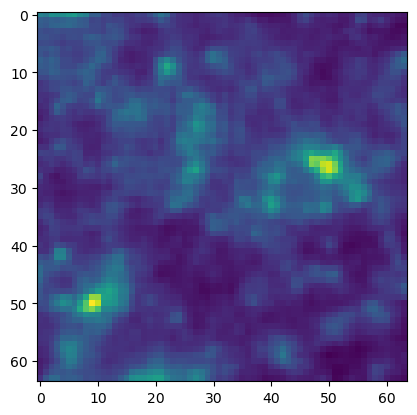

In [126]:

(x), =validation_dataset.take(1)
#for x in validation_dataset.take(4):
print(tf.squeeze(x))
    
    
plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [172]:
output_dim = 4000

#x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, sub_image_size, sub_image_size, 1))
y = make_analysis_transform(output_dim)(x)

print("y:", y)


y: tf.Tensor(
[[ 0.01641825 -0.00197773  0.0045536  ... -0.00871854  0.0026695
  -0.01339603]], shape=(1, 4000), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [128]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[-2.31272615e-02  2.86777318e-01 -5.14541008e-02 -4.19022977e-01
  -3.20681125e-01 -4.14150119e-01  3.25332731e-01 -1.68871075e-01
  -4.48578358e-01 -4.95550185e-02 -3.57023984e-01 -3.37108225e-01
  -4.18460727e-01  1.46815360e-01 -2.82347202e-01  4.96673971e-01
   4.30918247e-01  2.95042098e-01 -2.45526452e-02 -4.29506391e-01
   4.80497032e-01 -4.03914511e-01  1.15368031e-01 -4.89388257e-01
   4.10944134e-01  2.42489129e-02  8.35825875e-02 -2.15368852e-01
  -1.26459062e-01 -4.71718729e-01 -3.55775535e-01 -3.02595735e-01
  -4.91104901e-01  2.66016662e-01 -2.08867267e-01  1.60059586e-01
   3.05731535e-01 -2.15663180e-01 -2.69661874e-01 -3.25662822e-01
   4.07111973e-01  3.07607949e-01  7.98731148e-02 -8.41105077e-03
   2.52897114e-01  1.34256035e-01  3.42624813e-01 -7.40717798e-02
  -4.22885597e-01  3.82434815e-01 -4.32734311e-01  8.02997500e-02
  -3.83257121e-01  3.54965702e-02 -4.05521423e-01  2.83769011e-01
   3.93830836e-01  6.35974258e-02  3.26816648e-01  2.665

The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

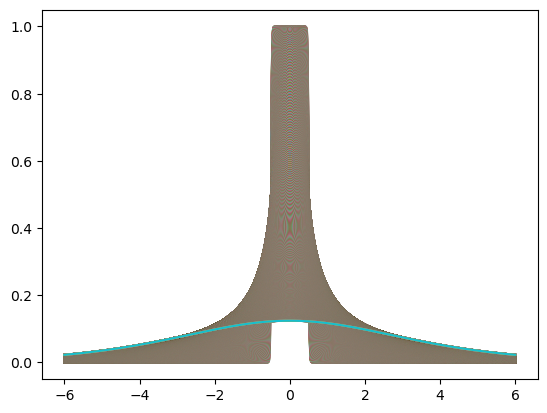

In [173]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., output_dim))
#prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.001, .1, output_dim))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [174]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([7488.288], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[ 0.3999726   0.13446124  0.12745218 ...  0.31285053 -0.07196195
  -0.21512449]], shape=(1, 4000), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

tf.Tensor(
[[[[-1.98861326e-05]
   [-1.63585191e-05]
   [-3.58770776e-05]
   ...
   [-3.05956237e-05]
   [ 1.22589205e-04]
   [ 1.92112839e-05]]

  [[-3.48539652e-05]
   [-6.76618001e-05]
   [-4.35872134e-05]
   ...
   [ 1.83132885e-04]
   [-2.04474645e-06]
   [-4.62296302e-05]]

  [[-1.67208491e-05]
   [-2.24946798e-05]
   [ 9.95102891e-06]
   ...
   [-7.86279197e-05]
   [-4.54286746e-05]
   [-5.99803534e-05]]

  ...

  [[-3.27691923e-05]
   [-8.46052644e-05]
   [-5.61881825e-05]
   ...
   [-1.19565426e-04]
   [ 2.45335512e-04]
   [ 4.11362329e-04]]

  [[ 3.30285184e-05]
   [-2.68959830e-05]
   [-3.99867349e-06]
   ...
   [-4.00572426e-05]
   [-5.04920317e-05]
   [-8.88922295e-05]]

  [[ 3.62091669e-07]
   [ 4.57292626e-05]
   [ 1.80735660e-04]
   ...
   [ 2.09849677e-05]
   [ 3.27160087e-05]
   [ 8.58946805e-06]]]], shape=(1, 64, 64, 1), dtype=float32)
(1, 64, 64, 1) (1, 64, 64, 1) <dtype: 'float32'> <dtype: 'float32'>
distortion: tf.Tensor(0.10107547, shape=(), dtype=float32)
distor

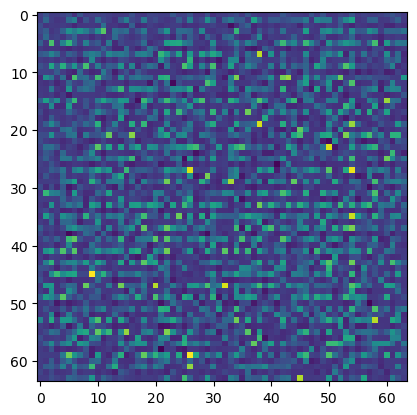

In [175]:
x_tilde = make_synthesis_transform()(y_tilde)

print(make_synthesis_transform()(y))

print(np.shape(x_tilde), np.shape(x), x_tilde.dtype, x.dtype)
# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

print("distortion:",tf.reduce_mean(abs(make_synthesis_transform()(y)*0 - x)))

x_tilde = x_tilde[0] #, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [176]:
(example_batch), = validation_dataset.batch(32).take(1)
trainer = CosmologyCompressionTrainer(output_dim)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(8118.505, shape=(), dtype=float32)
distortion:  tf.Tensor(0.20628858, shape=(), dtype=float32)


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [177]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=50):
  trainer = CosmologyCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [178]:
def add_rd_targets(image):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)


def train_model(lmbda):
  #if untrained:
  trainer = make_compression_trainer(lmbda)
  #untrained = False
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=2,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer


#untrained = False
#lmbda=20000
trainer = train_model(lmbda=20000)


Epoch 1/2
820/820 [==============================] - ETA: 0s - loss: 1271.8375 - distortion_loss: 0.0576 - rate_loss: 119.0667 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 119.0696

820/820 [==============================] - 332s 398ms/step - loss: 1271.8375 - distortion_loss: 0.0576 - rate_loss: 119.0667 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 119.0696 - val_loss: 1078.0796 - val_distortion_loss: 0.0478 - val_rate_loss: 121.6191 - val_distortion_pass_through_loss: 0.0478 - val_rate_pass_through_loss: 121.6184
Epoch 2/2
669/820 [=======================>......] - ETA: 51s - loss: 1060.7632 - distortion_loss: 0.0468 - rate_loss: 124.0348 - distortion_pass_through_loss: 0.0468 - rate_pass_through_loss: 124.0348

## Compress images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [166]:
class Compressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype)  #/ 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [167]:
class Decompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return x_hat #tf.saturate_cast(tf.round(x_hat), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [168]:
def make_cosmology_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_cosmology_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

Data type: <dtype: 'float32'>
Shape: (16, 64, 64, 1)


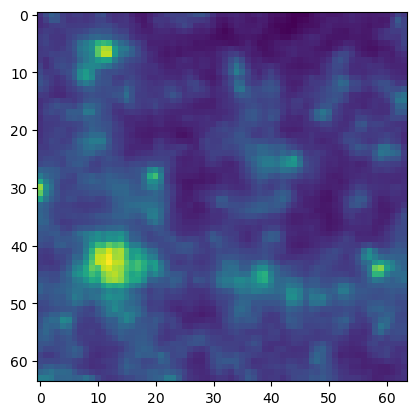

In [169]:
(originals), = validation_dataset.batch(16).skip(3).take(1)

plt.imshow(tf.squeeze(originals[0]))
print(f"Data type: {originals.dtype}")
print(f"Shape: {originals.shape}")


Compress them to strings, and keep track of each of their information content in bits.

In [170]:
strings, entropies = compressor(originals)

print(f"String representation of first file in hexadecimal: 0x{strings[6].numpy().hex()}, {strings[3].numpy().hex()}")
print(len(strings[10].numpy().hex()))
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first file in hexadecimal: 0x070041fa1a078b93d34d884e6edd, ab90f8433eb91c3e072e58344d6358
28
Number of bits actually needed to represent it: 137.17


Decompress the images back from the strings.

tf.Tensor(
[[[-0.32771558]
  [-0.32999128]
  [-0.33508918]
  ...
  [-0.23180027]
  [-0.23490603]
  [-0.23908237]]

 [[-0.32614225]
  [-0.33909705]
  [-0.34022033]
  ...
  [-0.22447239]
  [-0.22689228]
  [-0.22873974]]

 [[-0.32678446]
  [-0.336921  ]
  [-0.34074605]
  ...
  [-0.21459496]
  [-0.22306108]
  [-0.22446497]]

 ...

 [[-0.25941023]
  [-0.26386818]
  [-0.2698882 ]
  ...
  [-0.41357565]
  [-0.40682313]
  [-0.39952773]]

 [[-0.26751977]
  [-0.27606484]
  [-0.2771078 ]
  ...
  [-0.41154274]
  [-0.40643102]
  [-0.40067992]]

 [[-0.26552412]
  [-0.2772586 ]
  [-0.2840405 ]
  ...
  [-0.40454683]
  [-0.401913  ]
  [-0.39827603]]], shape=(64, 64, 1), dtype=float32)
Data type: <dtype: 'float32'>
Shape: (16, 64, 64, 1)


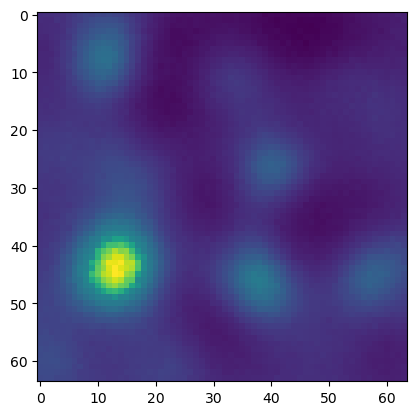

In [171]:
reconstructions = decompressor(strings)
print(reconstructions[1])

#reconstructions = make_synthesis_transform(make_analysis_transform(output_dim))

plt.imshow(tf.squeeze(reconstructions[0]))
print(f"Data type: {reconstructions.dtype}")
print(f"Shape: {reconstructions.shape}")

Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [91]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((sub_image_size, sub_image_size//2), tf.float32),
        tf.squeeze(reconstructions[i]),
    ], 1)
    print(originals[i])

    axes[i].imshow(image)
    #axes[i].text(
    #    .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
    #    ha="center", va="top", color="white", fontsize="small",
    #    transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a uint8 tensor [Op:ConcatV2] name: concat

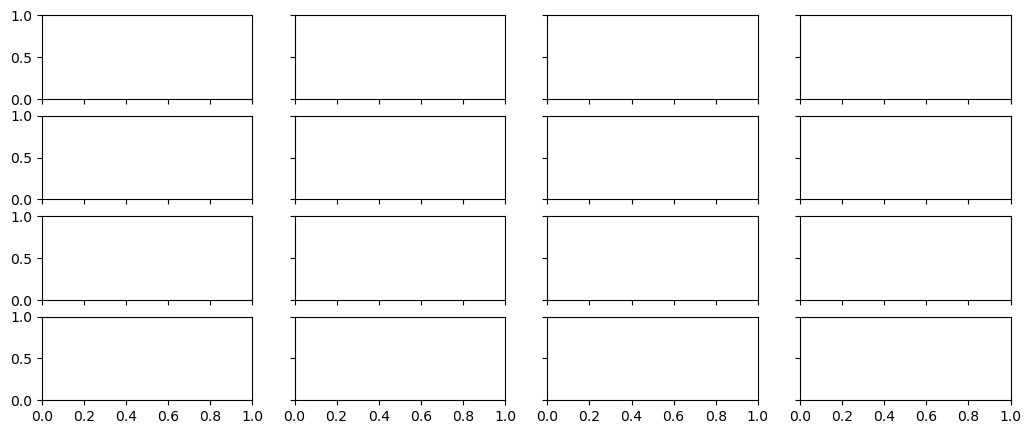

In [90]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15



  1/469 [..............................] - ETA: 13:53 - loss: 164.6600 - distortion_loss: 0.1233 - rate_loss: 102.9923 - distortion_pass_through_loss: 0.1233 - rate_pass_through_loss: 102.9923


  4/469 [..............................] - ETA: 9s - loss: 168.2278 - distortion_loss: 0.1307 - rate_loss: 102.8553 - distortion_pass_through_loss: 0.1307 - rate_pass_through_loss: 102.8553   


  7/469 [..............................] - ETA: 9s - loss: 168.5584 - distortion_loss: 0.1316 - rate_loss: 102.7364 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.7364


 10/469 [..............................] - ETA: 8s - loss: 168.5898 - distortion_loss: 0.1319 - rate_loss: 102.6281 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.6281


 13/469 [..............................] - ETA: 8s - loss: 168.1948 - distortion_loss: 0.1313 - rate_loss: 102.5211 - distortion_pass_through_loss: 0.1313 - rate_pass_through_loss: 102.5211


 16/469 [>.............................] - ETA: 8s - loss: 167.6866 - distortion_loss: 0.1305 - rate_loss: 102.4214 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 102.4214


 19/469 [>.............................] - ETA: 8s - loss: 167.3665 - distortion_loss: 0.1300 - rate_loss: 102.3521 - distortion_pass_through_loss: 0.1300 - rate_pass_through_loss: 102.3521


 22/469 [>.............................] - ETA: 8s - loss: 167.1703 - distortion_loss: 0.1298 - rate_loss: 102.2779 - distortion_pass_through_loss: 0.1298 - rate_pass_through_loss: 102.2779


 25/469 [>.............................] - ETA: 8s - loss: 166.6095 - distortion_loss: 0.1289 - rate_loss: 102.1807 - distortion_pass_through_loss: 0.1289 - rate_pass_through_loss: 102.1807


 28/469 [>.............................] - ETA: 8s - loss: 166.3741 - distortion_loss: 0.1285 - rate_loss: 102.1023 - distortion_pass_through_loss: 0.1285 - rate_pass_through_loss: 102.1023


 31/469 [>.............................] - ETA: 8s - loss: 165.9136 - distortion_loss: 0.1278 - rate_loss: 102.0244 - distortion_pass_through_loss: 0.1278 - rate_pass_through_loss: 102.0244


 34/469 [=>............................] - ETA: 8s - loss: 165.5735 - distortion_loss: 0.1273 - rate_loss: 101.9471 - distortion_pass_through_loss: 0.1273 - rate_pass_through_loss: 101.9471


 37/469 [=>............................] - ETA: 8s - loss: 165.0735 - distortion_loss: 0.1264 - rate_loss: 101.8593 - distortion_pass_through_loss: 0.1264 - rate_pass_through_loss: 101.8593


 40/469 [=>............................] - ETA: 8s - loss: 164.6193 - distortion_loss: 0.1257 - rate_loss: 101.7762 - distortion_pass_through_loss: 0.1257 - rate_pass_through_loss: 101.7762


 43/469 [=>............................] - ETA: 8s - loss: 164.2908 - distortion_loss: 0.1252 - rate_loss: 101.7016 - distortion_pass_through_loss: 0.1252 - rate_pass_through_loss: 101.7016


 46/469 [=>............................] - ETA: 8s - loss: 163.8538 - distortion_loss: 0.1244 - rate_loss: 101.6501 - distortion_pass_through_loss: 0.1244 - rate_pass_through_loss: 101.6501


 49/469 [==>...........................] - ETA: 7s - loss: 163.4410 - distortion_loss: 0.1236 - rate_loss: 101.6174 - distortion_pass_through_loss: 0.1236 - rate_pass_through_loss: 101.6174


 52/469 [==>...........................] - ETA: 7s - loss: 162.9563 - distortion_loss: 0.1227 - rate_loss: 101.5856 - distortion_pass_through_loss: 0.1227 - rate_pass_through_loss: 101.5856


 55/469 [==>...........................] - ETA: 7s - loss: 162.3429 - distortion_loss: 0.1216 - rate_loss: 101.5443 - distortion_pass_through_loss: 0.1216 - rate_pass_through_loss: 101.5443


 58/469 [==>...........................] - ETA: 7s - loss: 161.7668 - distortion_loss: 0.1205 - rate_loss: 101.5080 - distortion_pass_through_loss: 0.1205 - rate_pass_through_loss: 101.5080


 61/469 [==>...........................] - ETA: 7s - loss: 161.1868 - distortion_loss: 0.1194 - rate_loss: 101.4674 - distortion_pass_through_loss: 0.1194 - rate_pass_through_loss: 101.4674


 64/469 [===>..........................] - ETA: 7s - loss: 160.6289 - distortion_loss: 0.1184 - rate_loss: 101.4164 - distortion_pass_through_loss: 0.1184 - rate_pass_through_loss: 101.4164


 67/469 [===>..........................] - ETA: 7s - loss: 160.0411 - distortion_loss: 0.1174 - rate_loss: 101.3633 - distortion_pass_through_loss: 0.1174 - rate_pass_through_loss: 101.3633


 70/469 [===>..........................] - ETA: 7s - loss: 159.4332 - distortion_loss: 0.1162 - rate_loss: 101.3163 - distortion_pass_through_loss: 0.1162 - rate_pass_through_loss: 101.3163


 73/469 [===>..........................] - ETA: 7s - loss: 158.7943 - distortion_loss: 0.1150 - rate_loss: 101.2714 - distortion_pass_through_loss: 0.1150 - rate_pass_through_loss: 101.2714


 76/469 [===>..........................] - ETA: 7s - loss: 158.2432 - distortion_loss: 0.1140 - rate_loss: 101.2292 - distortion_pass_through_loss: 0.1140 - rate_pass_through_loss: 101.2292


 79/469 [====>.........................] - ETA: 7s - loss: 157.6589 - distortion_loss: 0.1130 - rate_loss: 101.1835 - distortion_pass_through_loss: 0.1130 - rate_pass_through_loss: 101.1835


 82/469 [====>.........................] - ETA: 7s - loss: 157.1179 - distortion_loss: 0.1120 - rate_loss: 101.1388 - distortion_pass_through_loss: 0.1120 - rate_pass_through_loss: 101.1388


 85/469 [====>.........................] - ETA: 7s - loss: 156.5516 - distortion_loss: 0.1109 - rate_loss: 101.0942 - distortion_pass_through_loss: 0.1109 - rate_pass_through_loss: 101.0942


 88/469 [====>.........................] - ETA: 7s - loss: 156.0078 - distortion_loss: 0.1099 - rate_loss: 101.0491 - distortion_pass_through_loss: 0.1099 - rate_pass_through_loss: 101.0491


 91/469 [====>.........................] - ETA: 7s - loss: 155.4597 - distortion_loss: 0.1089 - rate_loss: 101.0015 - distortion_pass_through_loss: 0.1089 - rate_pass_through_loss: 101.0015


 94/469 [=====>........................] - ETA: 7s - loss: 154.9647 - distortion_loss: 0.1080 - rate_loss: 100.9563 - distortion_pass_through_loss: 0.1080 - rate_pass_through_loss: 100.9563


 97/469 [=====>........................] - ETA: 7s - loss: 154.4417 - distortion_loss: 0.1071 - rate_loss: 100.9064 - distortion_pass_through_loss: 0.1071 - rate_pass_through_loss: 100.9064


100/469 [=====>........................] - ETA: 7s - loss: 153.9851 - distortion_loss: 0.1062 - rate_loss: 100.8622 - distortion_pass_through_loss: 0.1062 - rate_pass_through_loss: 100.8622


103/469 [=====>........................] - ETA: 6s - loss: 153.5222 - distortion_loss: 0.1054 - rate_loss: 100.8102 - distortion_pass_through_loss: 0.1054 - rate_pass_through_loss: 100.8102


106/469 [=====>........................] - ETA: 6s - loss: 153.0418 - distortion_loss: 0.1046 - rate_loss: 100.7566 - distortion_pass_through_loss: 0.1046 - rate_pass_through_loss: 100.7566


109/469 [=====>........................] - ETA: 6s - loss: 152.5707 - distortion_loss: 0.1037 - rate_loss: 100.7063 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 100.7063


112/469 [======>.......................] - ETA: 6s - loss: 152.1599 - distortion_loss: 0.1030 - rate_loss: 100.6528 - distortion_pass_through_loss: 0.1030 - rate_pass_through_loss: 100.6528


115/469 [======>.......................] - ETA: 6s - loss: 151.7728 - distortion_loss: 0.1023 - rate_loss: 100.6018 - distortion_pass_through_loss: 0.1023 - rate_pass_through_loss: 100.6018


118/469 [======>.......................] - ETA: 6s - loss: 151.3290 - distortion_loss: 0.1016 - rate_loss: 100.5490 - distortion_pass_through_loss: 0.1016 - rate_pass_through_loss: 100.5490


121/469 [======>.......................] - ETA: 6s - loss: 150.9146 - distortion_loss: 0.1008 - rate_loss: 100.4944 - distortion_pass_through_loss: 0.1008 - rate_pass_through_loss: 100.4944


124/469 [======>.......................] - ETA: 6s - loss: 150.5066 - distortion_loss: 0.1001 - rate_loss: 100.4431 - distortion_pass_through_loss: 0.1001 - rate_pass_through_loss: 100.4431


127/469 [=======>......................] - ETA: 6s - loss: 150.1028 - distortion_loss: 0.0994 - rate_loss: 100.3871 - distortion_pass_through_loss: 0.0994 - rate_pass_through_loss: 100.3871


130/469 [=======>......................] - ETA: 6s - loss: 149.7123 - distortion_loss: 0.0988 - rate_loss: 100.3298 - distortion_pass_through_loss: 0.0988 - rate_pass_through_loss: 100.3298


133/469 [=======>......................] - ETA: 6s - loss: 149.3192 - distortion_loss: 0.0981 - rate_loss: 100.2759 - distortion_pass_through_loss: 0.0981 - rate_pass_through_loss: 100.2759


136/469 [=======>......................] - ETA: 6s - loss: 148.9586 - distortion_loss: 0.0975 - rate_loss: 100.2166 - distortion_pass_through_loss: 0.0975 - rate_pass_through_loss: 100.2166


139/469 [=======>......................] - ETA: 6s - loss: 148.6177 - distortion_loss: 0.0969 - rate_loss: 100.1612 - distortion_pass_through_loss: 0.0969 - rate_pass_through_loss: 100.1612


142/469 [========>.....................] - ETA: 6s - loss: 148.2611 - distortion_loss: 0.0963 - rate_loss: 100.1021 - distortion_pass_through_loss: 0.0963 - rate_pass_through_loss: 100.1021


145/469 [========>.....................] - ETA: 6s - loss: 147.9292 - distortion_loss: 0.0958 - rate_loss: 100.0444 - distortion_pass_through_loss: 0.0958 - rate_pass_through_loss: 100.0444


148/469 [========>.....................] - ETA: 6s - loss: 147.5993 - distortion_loss: 0.0952 - rate_loss: 99.9845 - distortion_pass_through_loss: 0.0952 - rate_pass_through_loss: 99.9845  


151/469 [========>.....................] - ETA: 6s - loss: 147.2711 - distortion_loss: 0.0947 - rate_loss: 99.9247 - distortion_pass_through_loss: 0.0947 - rate_pass_through_loss: 99.9247


154/469 [========>.....................] - ETA: 6s - loss: 146.9754 - distortion_loss: 0.0942 - rate_loss: 99.8721 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 99.8721


157/469 [=========>....................] - ETA: 5s - loss: 146.6717 - distortion_loss: 0.0937 - rate_loss: 99.8146 - distortion_pass_through_loss: 0.0937 - rate_pass_through_loss: 99.8146


160/469 [=========>....................] - ETA: 5s - loss: 146.3753 - distortion_loss: 0.0932 - rate_loss: 99.7565 - distortion_pass_through_loss: 0.0932 - rate_pass_through_loss: 99.7565


163/469 [=========>....................] - ETA: 5s - loss: 146.0608 - distortion_loss: 0.0927 - rate_loss: 99.6947 - distortion_pass_through_loss: 0.0927 - rate_pass_through_loss: 99.6947


166/469 [=========>....................] - ETA: 5s - loss: 145.7694 - distortion_loss: 0.0923 - rate_loss: 99.6348 - distortion_pass_through_loss: 0.0923 - rate_pass_through_loss: 99.6348


169/469 [=========>....................] - ETA: 5s - loss: 145.4769 - distortion_loss: 0.0918 - rate_loss: 99.5731 - distortion_pass_through_loss: 0.0918 - rate_pass_through_loss: 99.5731


172/469 [==========>...................] - ETA: 5s - loss: 145.1838 - distortion_loss: 0.0913 - rate_loss: 99.5103 - distortion_pass_through_loss: 0.0913 - rate_pass_through_loss: 99.5103


175/469 [==========>...................] - ETA: 5s - loss: 144.9080 - distortion_loss: 0.0909 - rate_loss: 99.4499 - distortion_pass_through_loss: 0.0909 - rate_pass_through_loss: 99.4499


178/469 [==========>...................] - ETA: 5s - loss: 144.6297 - distortion_loss: 0.0905 - rate_loss: 99.3889 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 99.3889


181/469 [==========>...................] - ETA: 5s - loss: 144.3636 - distortion_loss: 0.0901 - rate_loss: 99.3297 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 99.3297


184/469 [==========>...................] - ETA: 5s - loss: 144.0965 - distortion_loss: 0.0897 - rate_loss: 99.2686 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 99.2686


187/469 [==========>...................] - ETA: 5s - loss: 143.8224 - distortion_loss: 0.0892 - rate_loss: 99.2031 - distortion_pass_through_loss: 0.0892 - rate_pass_through_loss: 99.2031


190/469 [===========>..................] - ETA: 5s - loss: 143.5697 - distortion_loss: 0.0889 - rate_loss: 99.1392 - distortion_pass_through_loss: 0.0889 - rate_pass_through_loss: 99.1392


193/469 [===========>..................] - ETA: 5s - loss: 143.3196 - distortion_loss: 0.0885 - rate_loss: 99.0767 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 99.0767


196/469 [===========>..................] - ETA: 5s - loss: 143.0685 - distortion_loss: 0.0881 - rate_loss: 99.0130 - distortion_pass_through_loss: 0.0881 - rate_pass_through_loss: 99.0130


199/469 [===========>..................] - ETA: 5s - loss: 142.8117 - distortion_loss: 0.0877 - rate_loss: 98.9476 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 98.9476


202/469 [===========>..................] - ETA: 5s - loss: 142.5637 - distortion_loss: 0.0874 - rate_loss: 98.8822 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 98.8822


205/469 [============>.................] - ETA: 5s - loss: 142.3211 - distortion_loss: 0.0870 - rate_loss: 98.8175 - distortion_pass_through_loss: 0.0870 - rate_pass_through_loss: 98.8175


208/469 [============>.................] - ETA: 5s - loss: 142.0791 - distortion_loss: 0.0867 - rate_loss: 98.7516 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 98.7516


211/469 [============>.................] - ETA: 4s - loss: 141.8288 - distortion_loss: 0.0863 - rate_loss: 98.6861 - distortion_pass_through_loss: 0.0863 - rate_pass_through_loss: 98.6861


214/469 [============>.................] - ETA: 4s - loss: 141.5978 - distortion_loss: 0.0860 - rate_loss: 98.6217 - distortion_pass_through_loss: 0.0860 - rate_pass_through_loss: 98.6217


217/469 [============>.................] - ETA: 4s - loss: 141.3620 - distortion_loss: 0.0856 - rate_loss: 98.5549 - distortion_pass_through_loss: 0.0856 - rate_pass_through_loss: 98.5549


220/469 [=============>................] - ETA: 4s - loss: 141.1341 - distortion_loss: 0.0853 - rate_loss: 98.4918 - distortion_pass_through_loss: 0.0853 - rate_pass_through_loss: 98.4918


223/469 [=============>................] - ETA: 4s - loss: 140.9117 - distortion_loss: 0.0850 - rate_loss: 98.4250 - distortion_pass_through_loss: 0.0850 - rate_pass_through_loss: 98.4250


226/469 [=============>................] - ETA: 4s - loss: 140.6759 - distortion_loss: 0.0846 - rate_loss: 98.3577 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 98.3577


229/469 [=============>................] - ETA: 4s - loss: 140.4626 - distortion_loss: 0.0843 - rate_loss: 98.2928 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 98.2928


232/469 [=============>................] - ETA: 4s - loss: 140.2485 - distortion_loss: 0.0840 - rate_loss: 98.2260 - distortion_pass_through_loss: 0.0840 - rate_pass_through_loss: 98.2260


235/469 [==============>...............] - ETA: 4s - loss: 140.0288 - distortion_loss: 0.0837 - rate_loss: 98.1573 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 98.1573


238/469 [==============>...............] - ETA: 4s - loss: 139.8153 - distortion_loss: 0.0835 - rate_loss: 98.0894 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 98.0894


241/469 [==============>...............] - ETA: 4s - loss: 139.6021 - distortion_loss: 0.0832 - rate_loss: 98.0205 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 98.0205


244/469 [==============>...............] - ETA: 4s - loss: 139.3861 - distortion_loss: 0.0829 - rate_loss: 97.9510 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 97.9510


247/469 [==============>...............] - ETA: 4s - loss: 139.1923 - distortion_loss: 0.0826 - rate_loss: 97.8842 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 97.8842


250/469 [==============>...............] - ETA: 4s - loss: 138.9951 - distortion_loss: 0.0824 - rate_loss: 97.8142 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 97.8142


253/469 [===============>..............] - ETA: 4s - loss: 138.7925 - distortion_loss: 0.0821 - rate_loss: 97.7431 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 97.7431


256/469 [===============>..............] - ETA: 4s - loss: 138.5890 - distortion_loss: 0.0818 - rate_loss: 97.6744 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 97.6744


259/469 [===============>..............] - ETA: 4s - loss: 138.3951 - distortion_loss: 0.0816 - rate_loss: 97.6049 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 97.6049


262/469 [===============>..............] - ETA: 3s - loss: 138.1991 - distortion_loss: 0.0813 - rate_loss: 97.5374 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 97.5374


265/469 [===============>..............] - ETA: 3s - loss: 137.9992 - distortion_loss: 0.0811 - rate_loss: 97.4682 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 97.4682


268/469 [================>.............] - ETA: 3s - loss: 137.8031 - distortion_loss: 0.0808 - rate_loss: 97.4003 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 97.4003


271/469 [================>.............] - ETA: 3s - loss: 137.6142 - distortion_loss: 0.0806 - rate_loss: 97.3278 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 97.3278


274/469 [================>.............] - ETA: 3s - loss: 137.4332 - distortion_loss: 0.0803 - rate_loss: 97.2597 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 97.2597


277/469 [================>.............] - ETA: 3s - loss: 137.2462 - distortion_loss: 0.0801 - rate_loss: 97.1890 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 97.1890


280/469 [================>.............] - ETA: 3s - loss: 137.0532 - distortion_loss: 0.0799 - rate_loss: 97.1185 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 97.1185


283/469 [=================>............] - ETA: 3s - loss: 136.8837 - distortion_loss: 0.0797 - rate_loss: 97.0501 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 97.0501


286/469 [=================>............] - ETA: 3s - loss: 136.7055 - distortion_loss: 0.0795 - rate_loss: 96.9796 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 96.9796


289/469 [=================>............] - ETA: 3s - loss: 136.5266 - distortion_loss: 0.0792 - rate_loss: 96.9110 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 96.9110


292/469 [=================>............] - ETA: 3s - loss: 136.3419 - distortion_loss: 0.0790 - rate_loss: 96.8393 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 96.8393


295/469 [=================>............] - ETA: 3s - loss: 136.1606 - distortion_loss: 0.0788 - rate_loss: 96.7677 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 96.7677


298/469 [==================>...........] - ETA: 3s - loss: 135.9779 - distortion_loss: 0.0786 - rate_loss: 96.6967 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 96.6967


301/469 [==================>...........] - ETA: 3s - loss: 135.8124 - distortion_loss: 0.0784 - rate_loss: 96.6272 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 96.6272


304/469 [==================>...........] - ETA: 3s - loss: 135.6324 - distortion_loss: 0.0782 - rate_loss: 96.5539 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 96.5539


307/469 [==================>...........] - ETA: 3s - loss: 135.4649 - distortion_loss: 0.0780 - rate_loss: 96.4820 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 96.4820


310/469 [==================>...........] - ETA: 3s - loss: 135.2980 - distortion_loss: 0.0778 - rate_loss: 96.4093 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 96.4093


313/469 [===================>..........] - ETA: 3s - loss: 135.1306 - distortion_loss: 0.0776 - rate_loss: 96.3376 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 96.3376


316/469 [===================>..........] - ETA: 2s - loss: 134.9628 - distortion_loss: 0.0774 - rate_loss: 96.2666 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 96.2666


319/469 [===================>..........] - ETA: 2s - loss: 134.7967 - distortion_loss: 0.0772 - rate_loss: 96.1959 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 96.1959


322/469 [===================>..........] - ETA: 2s - loss: 134.6332 - distortion_loss: 0.0770 - rate_loss: 96.1241 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 96.1241


325/469 [===================>..........] - ETA: 2s - loss: 134.4684 - distortion_loss: 0.0768 - rate_loss: 96.0498 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 96.0498


328/469 [===================>..........] - ETA: 2s - loss: 134.3092 - distortion_loss: 0.0767 - rate_loss: 95.9760 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 95.9760


331/469 [====================>.........] - ETA: 2s - loss: 134.1458 - distortion_loss: 0.0765 - rate_loss: 95.9051 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 95.9051


334/469 [====================>.........] - ETA: 2s - loss: 133.9871 - distortion_loss: 0.0763 - rate_loss: 95.8325 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 95.8325


337/469 [====================>.........] - ETA: 2s - loss: 133.8282 - distortion_loss: 0.0761 - rate_loss: 95.7605 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 95.7605


340/469 [====================>.........] - ETA: 2s - loss: 133.6693 - distortion_loss: 0.0760 - rate_loss: 95.6880 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 95.6880


343/469 [====================>.........] - ETA: 2s - loss: 133.5113 - distortion_loss: 0.0758 - rate_loss: 95.6146 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 95.6146


346/469 [=====================>........] - ETA: 2s - loss: 133.3485 - distortion_loss: 0.0756 - rate_loss: 95.5406 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 95.5406


349/469 [=====================>........] - ETA: 2s - loss: 133.1980 - distortion_loss: 0.0755 - rate_loss: 95.4685 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 95.4685


352/469 [=====================>........] - ETA: 2s - loss: 133.0478 - distortion_loss: 0.0753 - rate_loss: 95.3967 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 95.3967


355/469 [=====================>........] - ETA: 2s - loss: 132.8940 - distortion_loss: 0.0751 - rate_loss: 95.3223 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 95.3223


358/469 [=====================>........] - ETA: 2s - loss: 132.7397 - distortion_loss: 0.0750 - rate_loss: 95.2487 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 95.2487


361/469 [======================>.......] - ETA: 2s - loss: 132.5931 - distortion_loss: 0.0748 - rate_loss: 95.1768 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 95.1768


364/469 [======================>.......] - ETA: 2s - loss: 132.4466 - distortion_loss: 0.0747 - rate_loss: 95.1040 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 95.1040


367/469 [======================>.......] - ETA: 1s - loss: 132.2980 - distortion_loss: 0.0745 - rate_loss: 95.0285 - distortion_pass_through_loss: 0.0745 - rate_pass_through_loss: 95.0285


370/469 [======================>.......] - ETA: 1s - loss: 132.1489 - distortion_loss: 0.0744 - rate_loss: 94.9554 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 94.9554


373/469 [======================>.......] - ETA: 1s - loss: 132.0003 - distortion_loss: 0.0742 - rate_loss: 94.8830 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 94.8830


376/469 [=======================>......] - ETA: 1s - loss: 131.8497 - distortion_loss: 0.0741 - rate_loss: 94.8090 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 94.8090


379/469 [=======================>......] - ETA: 1s - loss: 131.7025 - distortion_loss: 0.0739 - rate_loss: 94.7344 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 94.7344


382/469 [=======================>......] - ETA: 1s - loss: 131.5572 - distortion_loss: 0.0738 - rate_loss: 94.6609 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 94.6609


385/469 [=======================>......] - ETA: 1s - loss: 131.4106 - distortion_loss: 0.0736 - rate_loss: 94.5873 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 94.5873


388/469 [=======================>......] - ETA: 1s - loss: 131.2712 - distortion_loss: 0.0735 - rate_loss: 94.5132 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 94.5132


391/469 [========================>.....] - ETA: 1s - loss: 131.1258 - distortion_loss: 0.0734 - rate_loss: 94.4398 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 94.4398


394/469 [========================>.....] - ETA: 1s - loss: 130.9862 - distortion_loss: 0.0732 - rate_loss: 94.3653 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 94.3653


397/469 [========================>.....] - ETA: 1s - loss: 130.8449 - distortion_loss: 0.0731 - rate_loss: 94.2918 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 94.2918


400/469 [========================>.....] - ETA: 1s - loss: 130.7030 - distortion_loss: 0.0730 - rate_loss: 94.2171 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 94.2171


403/469 [========================>.....] - ETA: 1s - loss: 130.5555 - distortion_loss: 0.0728 - rate_loss: 94.1436 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 94.1436


406/469 [========================>.....] - ETA: 1s - loss: 130.4208 - distortion_loss: 0.0727 - rate_loss: 94.0691 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 94.0691


409/469 [=========================>....] - ETA: 1s - loss: 130.2831 - distortion_loss: 0.0726 - rate_loss: 93.9957 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 93.9957


412/469 [=========================>....] - ETA: 1s - loss: 130.1503 - distortion_loss: 0.0725 - rate_loss: 93.9212 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 93.9212


415/469 [=========================>....] - ETA: 1s - loss: 130.0139 - distortion_loss: 0.0723 - rate_loss: 93.8480 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 93.8480


418/469 [=========================>....] - ETA: 0s - loss: 129.8764 - distortion_loss: 0.0722 - rate_loss: 93.7746 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 93.7746


421/469 [=========================>....] - ETA: 0s - loss: 129.7391 - distortion_loss: 0.0721 - rate_loss: 93.7019 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 93.7019


424/469 [==========================>...] - ETA: 0s - loss: 129.5999 - distortion_loss: 0.0719 - rate_loss: 93.6278 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 93.6278


427/469 [==========================>...] - ETA: 0s - loss: 129.4694 - distortion_loss: 0.0718 - rate_loss: 93.5529 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 93.5529


430/469 [==========================>...] - ETA: 0s - loss: 129.3407 - distortion_loss: 0.0717 - rate_loss: 93.4798 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 93.4798


433/469 [==========================>...] - ETA: 0s - loss: 129.2098 - distortion_loss: 0.0716 - rate_loss: 93.4058 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 93.4058


436/469 [==========================>...] - ETA: 0s - loss: 129.0777 - distortion_loss: 0.0715 - rate_loss: 93.3304 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 93.3304


439/469 [===========================>..] - ETA: 0s - loss: 128.9474 - distortion_loss: 0.0714 - rate_loss: 93.2557 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 93.2557


442/469 [===========================>..] - ETA: 0s - loss: 128.8201 - distortion_loss: 0.0713 - rate_loss: 93.1802 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 93.1802


445/469 [===========================>..] - ETA: 0s - loss: 128.6890 - distortion_loss: 0.0712 - rate_loss: 93.1058 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 93.1058


448/469 [===========================>..] - ETA: 0s - loss: 128.5646 - distortion_loss: 0.0711 - rate_loss: 93.0311 - distortion_pass_through_loss: 0.0711 - rate_pass_through_loss: 93.0311


451/469 [===========================>..] - ETA: 0s - loss: 128.4356 - distortion_loss: 0.0710 - rate_loss: 92.9584 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 92.9584


454/469 [============================>.] - ETA: 0s - loss: 128.3065 - distortion_loss: 0.0708 - rate_loss: 92.8843 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 92.8843


457/469 [============================>.] - ETA: 0s - loss: 128.1785 - distortion_loss: 0.0707 - rate_loss: 92.8114 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 92.8114


460/469 [============================>.] - ETA: 0s - loss: 128.0549 - distortion_loss: 0.0706 - rate_loss: 92.7358 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 92.7358


463/469 [============================>.] - ETA: 0s - loss: 127.9293 - distortion_loss: 0.0705 - rate_loss: 92.6623 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 92.6623


466/469 [============================>.] - ETA: 0s - loss: 127.8072 - distortion_loss: 0.0704 - rate_loss: 92.5886 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 92.5886


469/469 [==============================] - ETA: 0s - loss: 127.6881 - distortion_loss: 0.0703 - rate_loss: 92.5186 - distortion_pass_through_loss: 0.0703 - rate_pass_through_loss: 92.5123


469/469 [==============================] - 12s 21ms/step - loss: 127.6881 - distortion_loss: 0.0703 - rate_loss: 92.5186 - distortion_pass_through_loss: 0.0703 - rate_pass_through_loss: 92.5123 - val_loss: 107.5105 - val_distortion_loss: 0.0555 - val_rate_loss: 79.7676 - val_distortion_pass_through_loss: 0.0555 - val_rate_pass_through_loss: 79.7711


Epoch 2/15



  1/469 [..............................] - ETA: 12s - loss: 106.0868 - distortion_loss: 0.0508 - rate_loss: 80.6751 - distortion_pass_through_loss: 0.0508 - rate_pass_through_loss: 80.6751


  4/469 [..............................] - ETA: 9s - loss: 107.6123 - distortion_loss: 0.0537 - rate_loss: 80.7504 - distortion_pass_through_loss: 0.0537 - rate_pass_through_loss: 80.7504 


  7/469 [..............................] - ETA: 8s - loss: 107.9075 - distortion_loss: 0.0544 - rate_loss: 80.6898 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.6898


 10/469 [..............................] - ETA: 8s - loss: 108.0599 - distortion_loss: 0.0547 - rate_loss: 80.7227 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.7227


 13/469 [..............................] - ETA: 8s - loss: 107.8404 - distortion_loss: 0.0545 - rate_loss: 80.5908 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 80.5908


 16/469 [>.............................] - ETA: 8s - loss: 107.7351 - distortion_loss: 0.0544 - rate_loss: 80.5515 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.5515


 19/469 [>.............................] - ETA: 8s - loss: 107.6316 - distortion_loss: 0.0544 - rate_loss: 80.4276 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.4276


 22/469 [>.............................] - ETA: 8s - loss: 107.6800 - distortion_loss: 0.0546 - rate_loss: 80.3617 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.3617


 25/469 [>.............................] - ETA: 8s - loss: 107.5803 - distortion_loss: 0.0547 - rate_loss: 80.2544 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.2544


 28/469 [>.............................] - ETA: 8s - loss: 107.5837 - distortion_loss: 0.0547 - rate_loss: 80.2286 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.2286


 31/469 [>.............................] - ETA: 8s - loss: 107.4812 - distortion_loss: 0.0546 - rate_loss: 80.1578 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.1578


 34/469 [=>............................] - ETA: 8s - loss: 107.4585 - distortion_loss: 0.0547 - rate_loss: 80.0870 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.0870


 37/469 [=>............................] - ETA: 8s - loss: 107.3013 - distortion_loss: 0.0546 - rate_loss: 80.0024 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.0024


 40/469 [=>............................] - ETA: 8s - loss: 107.2146 - distortion_loss: 0.0546 - rate_loss: 79.9090 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.9090


 43/469 [=>............................] - ETA: 8s - loss: 107.1266 - distortion_loss: 0.0546 - rate_loss: 79.8462 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.8462


 46/469 [=>............................] - ETA: 8s - loss: 107.0198 - distortion_loss: 0.0545 - rate_loss: 79.7678 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 79.7678


 49/469 [==>...........................] - ETA: 8s - loss: 106.9882 - distortion_loss: 0.0546 - rate_loss: 79.7117 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.7117


 52/469 [==>...........................] - ETA: 8s - loss: 106.9577 - distortion_loss: 0.0546 - rate_loss: 79.6335 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.6335


 55/469 [==>...........................] - ETA: 8s - loss: 106.8676 - distortion_loss: 0.0546 - rate_loss: 79.5572 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.5572


 58/469 [==>...........................] - ETA: 8s - loss: 106.8053 - distortion_loss: 0.0547 - rate_loss: 79.4793 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 79.4793


 61/469 [==>...........................] - ETA: 7s - loss: 106.7381 - distortion_loss: 0.0547 - rate_loss: 79.3958 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 79.3958


 64/469 [===>..........................] - ETA: 7s - loss: 106.6894 - distortion_loss: 0.0547 - rate_loss: 79.3279 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 79.3279


 67/469 [===>..........................] - ETA: 7s - loss: 106.6314 - distortion_loss: 0.0547 - rate_loss: 79.2692 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 79.2692


 70/469 [===>..........................] - ETA: 7s - loss: 106.5431 - distortion_loss: 0.0547 - rate_loss: 79.2067 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 79.2067


 73/469 [===>..........................] - ETA: 7s - loss: 106.4112 - distortion_loss: 0.0546 - rate_loss: 79.1360 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.1360


 76/469 [===>..........................] - ETA: 7s - loss: 106.3455 - distortion_loss: 0.0546 - rate_loss: 79.0635 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 79.0635


 79/469 [====>.........................] - ETA: 7s - loss: 106.2529 - distortion_loss: 0.0545 - rate_loss: 78.9781 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 78.9781


 82/469 [====>.........................] - ETA: 7s - loss: 106.1789 - distortion_loss: 0.0546 - rate_loss: 78.8999 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 78.8999


 85/469 [====>.........................] - ETA: 7s - loss: 106.0821 - distortion_loss: 0.0545 - rate_loss: 78.8299 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 78.8299


 88/469 [====>.........................] - ETA: 7s - loss: 106.0020 - distortion_loss: 0.0545 - rate_loss: 78.7672 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 78.7672


 91/469 [====>.........................] - ETA: 7s - loss: 105.8942 - distortion_loss: 0.0544 - rate_loss: 78.6867 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 78.6867


 94/469 [=====>........................] - ETA: 7s - loss: 105.8232 - distortion_loss: 0.0544 - rate_loss: 78.6236 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 78.6236


 97/469 [=====>........................] - ETA: 7s - loss: 105.7185 - distortion_loss: 0.0544 - rate_loss: 78.5397 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 78.5397


100/469 [=====>........................] - ETA: 7s - loss: 105.6648 - distortion_loss: 0.0544 - rate_loss: 78.4799 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 78.4799


103/469 [=====>........................] - ETA: 7s - loss: 105.5798 - distortion_loss: 0.0544 - rate_loss: 78.3980 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 78.3980


106/469 [=====>........................] - ETA: 7s - loss: 105.4768 - distortion_loss: 0.0543 - rate_loss: 78.3211 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.3211


109/469 [=====>........................] - ETA: 7s - loss: 105.3791 - distortion_loss: 0.0543 - rate_loss: 78.2479 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.2479


112/469 [======>.......................] - ETA: 6s - loss: 105.3114 - distortion_loss: 0.0543 - rate_loss: 78.1849 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.1849


115/469 [======>.......................] - ETA: 6s - loss: 105.2583 - distortion_loss: 0.0543 - rate_loss: 78.1185 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.1185


118/469 [======>.......................] - ETA: 6s - loss: 105.1577 - distortion_loss: 0.0542 - rate_loss: 78.0387 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 78.0387


121/469 [======>.......................] - ETA: 6s - loss: 105.0638 - distortion_loss: 0.0542 - rate_loss: 77.9624 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 77.9624


124/469 [======>.......................] - ETA: 6s - loss: 104.9826 - distortion_loss: 0.0542 - rate_loss: 77.8825 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 77.8825


127/469 [=======>......................] - ETA: 6s - loss: 104.8931 - distortion_loss: 0.0542 - rate_loss: 77.8090 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 77.8090


130/469 [=======>......................] - ETA: 6s - loss: 104.8084 - distortion_loss: 0.0541 - rate_loss: 77.7391 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.7391


133/469 [=======>......................] - ETA: 6s - loss: 104.7159 - distortion_loss: 0.0541 - rate_loss: 77.6709 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.6709


136/469 [=======>......................] - ETA: 6s - loss: 104.6370 - distortion_loss: 0.0541 - rate_loss: 77.5999 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.5999


139/469 [=======>......................] - ETA: 6s - loss: 104.5651 - distortion_loss: 0.0541 - rate_loss: 77.5243 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.5243


142/469 [========>.....................] - ETA: 6s - loss: 104.4868 - distortion_loss: 0.0541 - rate_loss: 77.4450 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.4450


145/469 [========>.....................] - ETA: 6s - loss: 104.4104 - distortion_loss: 0.0541 - rate_loss: 77.3772 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.3772


148/469 [========>.....................] - ETA: 6s - loss: 104.3333 - distortion_loss: 0.0541 - rate_loss: 77.3069 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.3069


151/469 [========>.....................] - ETA: 6s - loss: 104.2581 - distortion_loss: 0.0540 - rate_loss: 77.2445 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.2445


154/469 [========>.....................] - ETA: 6s - loss: 104.1951 - distortion_loss: 0.0540 - rate_loss: 77.1749 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.1749


157/469 [=========>....................] - ETA: 6s - loss: 104.1276 - distortion_loss: 0.0540 - rate_loss: 77.1034 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.1034


160/469 [=========>....................] - ETA: 6s - loss: 104.0614 - distortion_loss: 0.0541 - rate_loss: 77.0319 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 77.0319


163/469 [=========>....................] - ETA: 5s - loss: 103.9774 - distortion_loss: 0.0540 - rate_loss: 76.9612 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.9612


166/469 [=========>....................] - ETA: 5s - loss: 103.9081 - distortion_loss: 0.0540 - rate_loss: 76.8894 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.8894


169/469 [=========>....................] - ETA: 5s - loss: 103.8417 - distortion_loss: 0.0540 - rate_loss: 76.8206 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.8206


172/469 [==========>...................] - ETA: 5s - loss: 103.7548 - distortion_loss: 0.0540 - rate_loss: 76.7487 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.7487


175/469 [==========>...................] - ETA: 5s - loss: 103.6940 - distortion_loss: 0.0540 - rate_loss: 76.6782 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.6782


178/469 [==========>...................] - ETA: 5s - loss: 103.6166 - distortion_loss: 0.0540 - rate_loss: 76.6077 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.6077


181/469 [==========>...................] - ETA: 5s - loss: 103.5496 - distortion_loss: 0.0540 - rate_loss: 76.5415 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.5415


184/469 [==========>...................] - ETA: 5s - loss: 103.4812 - distortion_loss: 0.0540 - rate_loss: 76.4749 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.4749


187/469 [==========>...................] - ETA: 5s - loss: 103.4102 - distortion_loss: 0.0540 - rate_loss: 76.4035 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.4035


190/469 [===========>..................] - ETA: 5s - loss: 103.3509 - distortion_loss: 0.0540 - rate_loss: 76.3310 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.3310


193/469 [===========>..................] - ETA: 5s - loss: 103.2839 - distortion_loss: 0.0540 - rate_loss: 76.2633 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.2633


196/469 [===========>..................] - ETA: 5s - loss: 103.2119 - distortion_loss: 0.0540 - rate_loss: 76.1935 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.1935


199/469 [===========>..................] - ETA: 5s - loss: 103.1369 - distortion_loss: 0.0540 - rate_loss: 76.1258 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.1258


202/469 [===========>..................] - ETA: 5s - loss: 103.0623 - distortion_loss: 0.0540 - rate_loss: 76.0572 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.0572


205/469 [============>.................] - ETA: 5s - loss: 102.9945 - distortion_loss: 0.0540 - rate_loss: 75.9865 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.9865


208/469 [============>.................] - ETA: 5s - loss: 102.9226 - distortion_loss: 0.0540 - rate_loss: 75.9177 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.9177


211/469 [============>.................] - ETA: 4s - loss: 102.8483 - distortion_loss: 0.0540 - rate_loss: 75.8447 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.8447


214/469 [============>.................] - ETA: 4s - loss: 102.7791 - distortion_loss: 0.0540 - rate_loss: 75.7771 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.7771


217/469 [============>.................] - ETA: 4s - loss: 102.7076 - distortion_loss: 0.0540 - rate_loss: 75.7045 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.7045


220/469 [=============>................] - ETA: 4s - loss: 102.6427 - distortion_loss: 0.0540 - rate_loss: 75.6330 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.6330


223/469 [=============>................] - ETA: 4s - loss: 102.5776 - distortion_loss: 0.0540 - rate_loss: 75.5623 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.5623


226/469 [=============>................] - ETA: 4s - loss: 102.4986 - distortion_loss: 0.0540 - rate_loss: 75.4868 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.4868


229/469 [=============>................] - ETA: 4s - loss: 102.4368 - distortion_loss: 0.0540 - rate_loss: 75.4217 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.4217


232/469 [=============>................] - ETA: 4s - loss: 102.3751 - distortion_loss: 0.0540 - rate_loss: 75.3548 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.3548


235/469 [==============>...............] - ETA: 4s - loss: 102.3061 - distortion_loss: 0.0540 - rate_loss: 75.2911 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.2911


238/469 [==============>...............] - ETA: 4s - loss: 102.2365 - distortion_loss: 0.0540 - rate_loss: 75.2209 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.2209


241/469 [==============>...............] - ETA: 4s - loss: 102.1699 - distortion_loss: 0.0540 - rate_loss: 75.1517 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.1517


244/469 [==============>...............] - ETA: 4s - loss: 102.0940 - distortion_loss: 0.0540 - rate_loss: 75.0818 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.0818


247/469 [==============>...............] - ETA: 4s - loss: 102.0376 - distortion_loss: 0.0540 - rate_loss: 75.0167 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.0167


250/469 [==============>...............] - ETA: 4s - loss: 101.9716 - distortion_loss: 0.0540 - rate_loss: 74.9520 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.9520


253/469 [===============>..............] - ETA: 4s - loss: 101.9032 - distortion_loss: 0.0540 - rate_loss: 74.8838 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.8838


256/469 [===============>..............] - ETA: 4s - loss: 101.8305 - distortion_loss: 0.0540 - rate_loss: 74.8141 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.8141


259/469 [===============>..............] - ETA: 4s - loss: 101.7601 - distortion_loss: 0.0540 - rate_loss: 74.7464 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.7464


262/469 [===============>..............] - ETA: 3s - loss: 101.6902 - distortion_loss: 0.0540 - rate_loss: 74.6785 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.6785


265/469 [===============>..............] - ETA: 3s - loss: 101.6188 - distortion_loss: 0.0540 - rate_loss: 74.6129 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.6129


268/469 [================>.............] - ETA: 3s - loss: 101.5453 - distortion_loss: 0.0540 - rate_loss: 74.5441 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.5441


271/469 [================>.............] - ETA: 3s - loss: 101.4781 - distortion_loss: 0.0540 - rate_loss: 74.4768 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.4768


274/469 [================>.............] - ETA: 3s - loss: 101.4166 - distortion_loss: 0.0540 - rate_loss: 74.4111 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.4111


277/469 [================>.............] - ETA: 3s - loss: 101.3508 - distortion_loss: 0.0540 - rate_loss: 74.3447 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.3447


280/469 [================>.............] - ETA: 3s - loss: 101.2780 - distortion_loss: 0.0540 - rate_loss: 74.2786 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.2786


283/469 [=================>............] - ETA: 3s - loss: 101.2228 - distortion_loss: 0.0540 - rate_loss: 74.2118 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.2118


286/469 [=================>............] - ETA: 3s - loss: 101.1600 - distortion_loss: 0.0540 - rate_loss: 74.1467 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.1467


289/469 [=================>............] - ETA: 3s - loss: 101.0903 - distortion_loss: 0.0540 - rate_loss: 74.0821 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.0821


292/469 [=================>............] - ETA: 3s - loss: 101.0156 - distortion_loss: 0.0540 - rate_loss: 74.0156 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.0156


295/469 [=================>............] - ETA: 3s - loss: 100.9419 - distortion_loss: 0.0540 - rate_loss: 73.9486 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.9486


298/469 [==================>...........] - ETA: 3s - loss: 100.8711 - distortion_loss: 0.0540 - rate_loss: 73.8756 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.8756


301/469 [==================>...........] - ETA: 3s - loss: 100.8077 - distortion_loss: 0.0540 - rate_loss: 73.8131 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.8131


304/469 [==================>...........] - ETA: 3s - loss: 100.7338 - distortion_loss: 0.0540 - rate_loss: 73.7447 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.7447


307/469 [==================>...........] - ETA: 3s - loss: 100.6736 - distortion_loss: 0.0540 - rate_loss: 73.6809 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.6809


310/469 [==================>...........] - ETA: 3s - loss: 100.6115 - distortion_loss: 0.0540 - rate_loss: 73.6138 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.6138


313/469 [===================>..........] - ETA: 3s - loss: 100.5468 - distortion_loss: 0.0540 - rate_loss: 73.5473 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.5473


316/469 [===================>..........] - ETA: 2s - loss: 100.4828 - distortion_loss: 0.0540 - rate_loss: 73.4805 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.4805


319/469 [===================>..........] - ETA: 2s - loss: 100.4133 - distortion_loss: 0.0540 - rate_loss: 73.4142 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.4142


322/469 [===================>..........] - ETA: 2s - loss: 100.3516 - distortion_loss: 0.0540 - rate_loss: 73.3478 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.3478


325/469 [===================>..........] - ETA: 2s - loss: 100.2855 - distortion_loss: 0.0540 - rate_loss: 73.2823 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.2823


328/469 [===================>..........] - ETA: 2s - loss: 100.2221 - distortion_loss: 0.0540 - rate_loss: 73.2185 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.2185


331/469 [====================>.........] - ETA: 2s - loss: 100.1566 - distortion_loss: 0.0540 - rate_loss: 73.1513 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.1513


334/469 [====================>.........] - ETA: 2s - loss: 100.0941 - distortion_loss: 0.0540 - rate_loss: 73.0872 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.0872


337/469 [====================>.........] - ETA: 2s - loss: 100.0294 - distortion_loss: 0.0540 - rate_loss: 73.0216 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.0216


340/469 [====================>.........] - ETA: 2s - loss: 99.9659 - distortion_loss: 0.0540 - rate_loss: 72.9559 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.9559 


343/469 [====================>.........] - ETA: 2s - loss: 99.8993 - distortion_loss: 0.0540 - rate_loss: 72.8927 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.8927


346/469 [=====================>........] - ETA: 2s - loss: 99.8275 - distortion_loss: 0.0540 - rate_loss: 72.8270 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.8270


349/469 [=====================>........] - ETA: 2s - loss: 99.7665 - distortion_loss: 0.0540 - rate_loss: 72.7636 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.7636


352/469 [=====================>........] - ETA: 2s - loss: 99.7019 - distortion_loss: 0.0540 - rate_loss: 72.6984 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.6984


355/469 [=====================>........] - ETA: 2s - loss: 99.6337 - distortion_loss: 0.0540 - rate_loss: 72.6338 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.6338


358/469 [=====================>........] - ETA: 2s - loss: 99.5680 - distortion_loss: 0.0540 - rate_loss: 72.5657 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.5657


361/469 [======================>.......] - ETA: 2s - loss: 99.5078 - distortion_loss: 0.0540 - rate_loss: 72.5033 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.5033


364/469 [======================>.......] - ETA: 2s - loss: 99.4447 - distortion_loss: 0.0540 - rate_loss: 72.4401 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.4401


367/469 [======================>.......] - ETA: 1s - loss: 99.3814 - distortion_loss: 0.0540 - rate_loss: 72.3727 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.3727


370/469 [======================>.......] - ETA: 1s - loss: 99.3158 - distortion_loss: 0.0540 - rate_loss: 72.3058 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.3058


373/469 [======================>.......] - ETA: 1s - loss: 99.2505 - distortion_loss: 0.0540 - rate_loss: 72.2425 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.2425


376/469 [=======================>......] - ETA: 1s - loss: 99.1837 - distortion_loss: 0.0540 - rate_loss: 72.1771 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.1771


379/469 [=======================>......] - ETA: 1s - loss: 99.1175 - distortion_loss: 0.0540 - rate_loss: 72.1124 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.1124


382/469 [=======================>......] - ETA: 1s - loss: 99.0517 - distortion_loss: 0.0540 - rate_loss: 72.0464 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.0464


385/469 [=======================>......] - ETA: 1s - loss: 98.9826 - distortion_loss: 0.0540 - rate_loss: 71.9817 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.9817


388/469 [=======================>......] - ETA: 1s - loss: 98.9247 - distortion_loss: 0.0540 - rate_loss: 71.9208 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.9208


391/469 [========================>.....] - ETA: 1s - loss: 98.8587 - distortion_loss: 0.0540 - rate_loss: 71.8566 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.8566


394/469 [========================>.....] - ETA: 1s - loss: 98.8010 - distortion_loss: 0.0540 - rate_loss: 71.7940 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.7940


397/469 [========================>.....] - ETA: 1s - loss: 98.7378 - distortion_loss: 0.0540 - rate_loss: 71.7278 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.7278


400/469 [========================>.....] - ETA: 1s - loss: 98.6740 - distortion_loss: 0.0540 - rate_loss: 71.6638 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.6638


403/469 [========================>.....] - ETA: 1s - loss: 98.6033 - distortion_loss: 0.0540 - rate_loss: 71.5986 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5986


406/469 [========================>.....] - ETA: 1s - loss: 98.5453 - distortion_loss: 0.0540 - rate_loss: 71.5356 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5356


409/469 [=========================>....] - ETA: 1s - loss: 98.4818 - distortion_loss: 0.0540 - rate_loss: 71.4720 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.4720


412/469 [=========================>....] - ETA: 1s - loss: 98.4253 - distortion_loss: 0.0540 - rate_loss: 71.4104 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.4104


415/469 [=========================>....] - ETA: 1s - loss: 98.3633 - distortion_loss: 0.0540 - rate_loss: 71.3470 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.3470


418/469 [=========================>....] - ETA: 0s - loss: 98.3005 - distortion_loss: 0.0540 - rate_loss: 71.2831 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.2831


421/469 [=========================>....] - ETA: 0s - loss: 98.2340 - distortion_loss: 0.0540 - rate_loss: 71.2202 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.2202


424/469 [==========================>...] - ETA: 0s - loss: 98.1713 - distortion_loss: 0.0540 - rate_loss: 71.1581 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.1581


427/469 [==========================>...] - ETA: 0s - loss: 98.1129 - distortion_loss: 0.0540 - rate_loss: 71.0955 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.0955


430/469 [==========================>...] - ETA: 0s - loss: 98.0545 - distortion_loss: 0.0540 - rate_loss: 71.0319 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.0319


433/469 [==========================>...] - ETA: 0s - loss: 97.9941 - distortion_loss: 0.0541 - rate_loss: 70.9668 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.9668


436/469 [==========================>...] - ETA: 0s - loss: 97.9319 - distortion_loss: 0.0541 - rate_loss: 70.9051 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.9051


439/469 [===========================>..] - ETA: 0s - loss: 97.8710 - distortion_loss: 0.0541 - rate_loss: 70.8428 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.8428


442/469 [===========================>..] - ETA: 0s - loss: 97.8133 - distortion_loss: 0.0541 - rate_loss: 70.7839 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.7839


445/469 [===========================>..] - ETA: 0s - loss: 97.7494 - distortion_loss: 0.0541 - rate_loss: 70.7200 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.7200


448/469 [===========================>..] - ETA: 0s - loss: 97.6925 - distortion_loss: 0.0541 - rate_loss: 70.6569 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.6569


451/469 [===========================>..] - ETA: 0s - loss: 97.6328 - distortion_loss: 0.0541 - rate_loss: 70.5917 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.5917


454/469 [============================>.] - ETA: 0s - loss: 97.5713 - distortion_loss: 0.0541 - rate_loss: 70.5317 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.5317


457/469 [============================>.] - ETA: 0s - loss: 97.5120 - distortion_loss: 0.0541 - rate_loss: 70.4725 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.4725


460/469 [============================>.] - ETA: 0s - loss: 97.4534 - distortion_loss: 0.0541 - rate_loss: 70.4106 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.4106


463/469 [============================>.] - ETA: 0s - loss: 97.3955 - distortion_loss: 0.0541 - rate_loss: 70.3486 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3486


466/469 [============================>.] - ETA: 0s - loss: 97.3400 - distortion_loss: 0.0541 - rate_loss: 70.2887 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.2887


469/469 [==============================] - ETA: 0s - loss: 97.2794 - distortion_loss: 0.0541 - rate_loss: 70.2320 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.2268


469/469 [==============================] - 10s 20ms/step - loss: 97.2794 - distortion_loss: 0.0541 - rate_loss: 70.2320 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.2268 - val_loss: 85.8693 - val_distortion_loss: 0.0598 - val_rate_loss: 55.9676 - val_distortion_pass_through_loss: 0.0599 - val_rate_pass_through_loss: 55.9639


Epoch 3/15



  1/469 [..............................] - ETA: 12s - loss: 85.6972 - distortion_loss: 0.0516 - rate_loss: 59.8999 - distortion_pass_through_loss: 0.0516 - rate_pass_through_loss: 59.8999


  4/469 [..............................] - ETA: 8s - loss: 87.4041 - distortion_loss: 0.0545 - rate_loss: 60.1653 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 60.1653 


  7/469 [..............................] - ETA: 9s - loss: 87.7890 - distortion_loss: 0.0554 - rate_loss: 60.1131 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 60.1131


 10/469 [..............................] - ETA: 8s - loss: 87.9763 - distortion_loss: 0.0554 - rate_loss: 60.2633 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 60.2633


 13/469 [..............................] - ETA: 8s - loss: 87.6866 - distortion_loss: 0.0548 - rate_loss: 60.3104 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 60.3104


 16/469 [>.............................] - ETA: 8s - loss: 87.5526 - distortion_loss: 0.0546 - rate_loss: 60.2285 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 60.2285


 19/469 [>.............................] - ETA: 8s - loss: 87.5449 - distortion_loss: 0.0547 - rate_loss: 60.1985 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 60.1985


 22/469 [>.............................] - ETA: 8s - loss: 87.6505 - distortion_loss: 0.0550 - rate_loss: 60.1747 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.1747


 25/469 [>.............................] - ETA: 8s - loss: 87.5800 - distortion_loss: 0.0549 - rate_loss: 60.1384 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 60.1384


 28/469 [>.............................] - ETA: 8s - loss: 87.6109 - distortion_loss: 0.0550 - rate_loss: 60.1049 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.1049


 31/469 [>.............................] - ETA: 8s - loss: 87.5091 - distortion_loss: 0.0550 - rate_loss: 60.0213 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.0213


 34/469 [=>............................] - ETA: 8s - loss: 87.4852 - distortion_loss: 0.0550 - rate_loss: 59.9758 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 59.9758


 37/469 [=>............................] - ETA: 8s - loss: 87.3539 - distortion_loss: 0.0549 - rate_loss: 59.9041 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 59.9041


 40/469 [=>............................] - ETA: 8s - loss: 87.3090 - distortion_loss: 0.0549 - rate_loss: 59.8424 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 59.8424


 43/469 [=>............................] - ETA: 8s - loss: 87.2360 - distortion_loss: 0.0549 - rate_loss: 59.7886 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 59.7886


 46/469 [=>............................] - ETA: 8s - loss: 87.1587 - distortion_loss: 0.0549 - rate_loss: 59.7047 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 59.7047


 49/469 [==>...........................] - ETA: 8s - loss: 87.1710 - distortion_loss: 0.0550 - rate_loss: 59.6518 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 59.6518


 52/469 [==>...........................] - ETA: 8s - loss: 87.1412 - distortion_loss: 0.0551 - rate_loss: 59.6105 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.6105


 55/469 [==>...........................] - ETA: 7s - loss: 87.0863 - distortion_loss: 0.0550 - rate_loss: 59.5855 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 59.5855


 58/469 [==>...........................] - ETA: 7s - loss: 87.0454 - distortion_loss: 0.0551 - rate_loss: 59.5197 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.5197


 61/469 [==>...........................] - ETA: 7s - loss: 86.9876 - distortion_loss: 0.0551 - rate_loss: 59.4465 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.4465


 64/469 [===>..........................] - ETA: 7s - loss: 86.9924 - distortion_loss: 0.0552 - rate_loss: 59.3959 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.3959


 67/469 [===>..........................] - ETA: 7s - loss: 86.9628 - distortion_loss: 0.0552 - rate_loss: 59.3636 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.3636


 70/469 [===>..........................] - ETA: 7s - loss: 86.9185 - distortion_loss: 0.0552 - rate_loss: 59.3153 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.3153


 73/469 [===>..........................] - ETA: 7s - loss: 86.8362 - distortion_loss: 0.0551 - rate_loss: 59.2625 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.2625


 76/469 [===>..........................] - ETA: 7s - loss: 86.7964 - distortion_loss: 0.0552 - rate_loss: 59.2047 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.2047


 79/469 [====>.........................] - ETA: 7s - loss: 86.7287 - distortion_loss: 0.0552 - rate_loss: 59.1271 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.1271


 82/469 [====>.........................] - ETA: 7s - loss: 86.6864 - distortion_loss: 0.0552 - rate_loss: 59.0804 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.0804


 85/469 [====>.........................] - ETA: 7s - loss: 86.6059 - distortion_loss: 0.0551 - rate_loss: 59.0342 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.0342


 88/469 [====>.........................] - ETA: 7s - loss: 86.5573 - distortion_loss: 0.0551 - rate_loss: 58.9936 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.9936


 91/469 [====>.........................] - ETA: 7s - loss: 86.4882 - distortion_loss: 0.0551 - rate_loss: 58.9343 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.9343


 94/469 [=====>........................] - ETA: 7s - loss: 86.4379 - distortion_loss: 0.0551 - rate_loss: 58.8856 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.8856


 97/469 [=====>........................] - ETA: 7s - loss: 86.3598 - distortion_loss: 0.0551 - rate_loss: 58.8304 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.8304


100/469 [=====>........................] - ETA: 7s - loss: 86.3412 - distortion_loss: 0.0551 - rate_loss: 58.7728 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.7728


103/469 [=====>........................] - ETA: 6s - loss: 86.2917 - distortion_loss: 0.0551 - rate_loss: 58.7283 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.7283


106/469 [=====>........................] - ETA: 6s - loss: 86.2160 - distortion_loss: 0.0551 - rate_loss: 58.6760 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.6760


109/469 [=====>........................] - ETA: 6s - loss: 86.1617 - distortion_loss: 0.0551 - rate_loss: 58.6259 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.6259


112/469 [======>.......................] - ETA: 6s - loss: 86.1333 - distortion_loss: 0.0551 - rate_loss: 58.5725 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.5725


115/469 [======>.......................] - ETA: 6s - loss: 86.1199 - distortion_loss: 0.0552 - rate_loss: 58.5190 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.5190


118/469 [======>.......................] - ETA: 6s - loss: 86.0499 - distortion_loss: 0.0552 - rate_loss: 58.4685 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.4685


121/469 [======>.......................] - ETA: 6s - loss: 85.9838 - distortion_loss: 0.0551 - rate_loss: 58.4159 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.4159


124/469 [======>.......................] - ETA: 6s - loss: 85.9294 - distortion_loss: 0.0551 - rate_loss: 58.3603 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.3603


127/469 [=======>......................] - ETA: 6s - loss: 85.8683 - distortion_loss: 0.0551 - rate_loss: 58.3057 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.3057


130/469 [=======>......................] - ETA: 6s - loss: 85.8025 - distortion_loss: 0.0551 - rate_loss: 58.2498 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.2498


133/469 [=======>......................] - ETA: 6s - loss: 85.7365 - distortion_loss: 0.0551 - rate_loss: 58.2002 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.2002


136/469 [=======>......................] - ETA: 6s - loss: 85.6890 - distortion_loss: 0.0551 - rate_loss: 58.1501 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.1501


139/469 [=======>......................] - ETA: 6s - loss: 85.6481 - distortion_loss: 0.0551 - rate_loss: 58.0992 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.0992


142/469 [========>.....................] - ETA: 6s - loss: 85.5850 - distortion_loss: 0.0551 - rate_loss: 58.0473 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 58.0473


145/469 [========>.....................] - ETA: 6s - loss: 85.5401 - distortion_loss: 0.0551 - rate_loss: 57.9984 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.9984


148/469 [========>.....................] - ETA: 6s - loss: 85.4991 - distortion_loss: 0.0551 - rate_loss: 57.9528 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.9528


151/469 [========>.....................] - ETA: 6s - loss: 85.4629 - distortion_loss: 0.0551 - rate_loss: 57.9044 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.9044


154/469 [========>.....................] - ETA: 6s - loss: 85.4361 - distortion_loss: 0.0551 - rate_loss: 57.8614 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 57.8614


157/469 [=========>....................] - ETA: 5s - loss: 85.4007 - distortion_loss: 0.0552 - rate_loss: 57.8117 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.8117


160/469 [=========>....................] - ETA: 5s - loss: 85.3651 - distortion_loss: 0.0552 - rate_loss: 57.7674 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.7674


163/469 [=========>....................] - ETA: 5s - loss: 85.3061 - distortion_loss: 0.0552 - rate_loss: 57.7190 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.7190


166/469 [=========>....................] - ETA: 5s - loss: 85.2643 - distortion_loss: 0.0552 - rate_loss: 57.6613 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.6613


169/469 [=========>....................] - ETA: 5s - loss: 85.2226 - distortion_loss: 0.0552 - rate_loss: 57.6077 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.6077


172/469 [==========>...................] - ETA: 5s - loss: 85.1658 - distortion_loss: 0.0552 - rate_loss: 57.5539 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.5539


175/469 [==========>...................] - ETA: 5s - loss: 85.1292 - distortion_loss: 0.0552 - rate_loss: 57.5119 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.5119


178/469 [==========>...................] - ETA: 5s - loss: 85.0820 - distortion_loss: 0.0552 - rate_loss: 57.4655 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.4655


181/469 [==========>...................] - ETA: 5s - loss: 85.0400 - distortion_loss: 0.0552 - rate_loss: 57.4166 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 57.4166


184/469 [==========>...................] - ETA: 5s - loss: 85.0009 - distortion_loss: 0.0553 - rate_loss: 57.3669 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.3669


187/469 [==========>...................] - ETA: 5s - loss: 84.9495 - distortion_loss: 0.0553 - rate_loss: 57.3190 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.3190


190/469 [===========>..................] - ETA: 5s - loss: 84.9161 - distortion_loss: 0.0553 - rate_loss: 57.2816 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.2816


193/469 [===========>..................] - ETA: 5s - loss: 84.8798 - distortion_loss: 0.0553 - rate_loss: 57.2396 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.2396


196/469 [===========>..................] - ETA: 5s - loss: 84.8405 - distortion_loss: 0.0553 - rate_loss: 57.1764 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.1764


199/469 [===========>..................] - ETA: 5s - loss: 84.7920 - distortion_loss: 0.0553 - rate_loss: 57.1272 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.1272


202/469 [===========>..................] - ETA: 5s - loss: 84.7434 - distortion_loss: 0.0553 - rate_loss: 57.0869 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.0869


205/469 [============>.................] - ETA: 5s - loss: 84.6998 - distortion_loss: 0.0553 - rate_loss: 57.0371 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.0371


208/469 [============>.................] - ETA: 5s - loss: 84.6549 - distortion_loss: 0.0553 - rate_loss: 56.9867 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.9867


211/469 [============>.................] - ETA: 4s - loss: 84.6026 - distortion_loss: 0.0553 - rate_loss: 56.9385 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.9385


214/469 [============>.................] - ETA: 4s - loss: 84.5629 - distortion_loss: 0.0553 - rate_loss: 56.8939 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 56.8939


217/469 [============>.................] - ETA: 4s - loss: 84.5226 - distortion_loss: 0.0554 - rate_loss: 56.8463 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.8463


220/469 [=============>................] - ETA: 4s - loss: 84.4860 - distortion_loss: 0.0554 - rate_loss: 56.7970 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.7970


223/469 [=============>................] - ETA: 4s - loss: 84.4411 - distortion_loss: 0.0554 - rate_loss: 56.7547 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.7547


226/469 [=============>................] - ETA: 4s - loss: 84.3832 - distortion_loss: 0.0554 - rate_loss: 56.7033 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.7033


229/469 [=============>................] - ETA: 4s - loss: 84.3513 - distortion_loss: 0.0554 - rate_loss: 56.6521 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.6521


232/469 [=============>................] - ETA: 4s - loss: 84.3153 - distortion_loss: 0.0554 - rate_loss: 56.6069 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.6069


235/469 [==============>...............] - ETA: 4s - loss: 84.2689 - distortion_loss: 0.0554 - rate_loss: 56.5604 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.5604


238/469 [==============>...............] - ETA: 4s - loss: 84.2269 - distortion_loss: 0.0554 - rate_loss: 56.5177 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.5177


241/469 [==============>...............] - ETA: 4s - loss: 84.1864 - distortion_loss: 0.0554 - rate_loss: 56.4680 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 56.4680


244/469 [==============>...............] - ETA: 4s - loss: 84.1383 - distortion_loss: 0.0555 - rate_loss: 56.4131 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.4131


247/469 [==============>...............] - ETA: 4s - loss: 84.1083 - distortion_loss: 0.0555 - rate_loss: 56.3682 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.3682


250/469 [==============>...............] - ETA: 4s - loss: 84.0710 - distortion_loss: 0.0555 - rate_loss: 56.3225 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.3225


253/469 [===============>..............] - ETA: 4s - loss: 84.0267 - distortion_loss: 0.0555 - rate_loss: 56.2782 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.2782


256/469 [===============>..............] - ETA: 4s - loss: 83.9798 - distortion_loss: 0.0555 - rate_loss: 56.2263 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.2263


259/469 [===============>..............] - ETA: 4s - loss: 83.9364 - distortion_loss: 0.0555 - rate_loss: 56.1835 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.1835


262/469 [===============>..............] - ETA: 3s - loss: 83.8949 - distortion_loss: 0.0555 - rate_loss: 56.1368 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.1368


265/469 [===============>..............] - ETA: 3s - loss: 83.8512 - distortion_loss: 0.0555 - rate_loss: 56.0874 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.0874


268/469 [================>.............] - ETA: 3s - loss: 83.8071 - distortion_loss: 0.0555 - rate_loss: 56.0384 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.0384


271/469 [================>.............] - ETA: 3s - loss: 83.7717 - distortion_loss: 0.0556 - rate_loss: 55.9925 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.9925


274/469 [================>.............] - ETA: 3s - loss: 83.7344 - distortion_loss: 0.0556 - rate_loss: 55.9459 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.9459


277/469 [================>.............] - ETA: 3s - loss: 83.6954 - distortion_loss: 0.0556 - rate_loss: 55.8997 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.8997


280/469 [================>.............] - ETA: 3s - loss: 83.6482 - distortion_loss: 0.0556 - rate_loss: 55.8510 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.8510


283/469 [=================>............] - ETA: 3s - loss: 83.6192 - distortion_loss: 0.0556 - rate_loss: 55.8108 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.8108


286/469 [=================>............] - ETA: 3s - loss: 83.5801 - distortion_loss: 0.0556 - rate_loss: 55.7664 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.7664


289/469 [=================>............] - ETA: 3s - loss: 83.5392 - distortion_loss: 0.0556 - rate_loss: 55.7151 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.7151


292/469 [=================>............] - ETA: 3s - loss: 83.4908 - distortion_loss: 0.0556 - rate_loss: 55.6675 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.6675


295/469 [=================>............] - ETA: 3s - loss: 83.4439 - distortion_loss: 0.0556 - rate_loss: 55.6247 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.6247


298/469 [==================>...........] - ETA: 3s - loss: 83.3947 - distortion_loss: 0.0556 - rate_loss: 55.5769 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 55.5769


301/469 [==================>...........] - ETA: 3s - loss: 83.3590 - distortion_loss: 0.0557 - rate_loss: 55.5313 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.5313


304/469 [==================>...........] - ETA: 3s - loss: 83.3127 - distortion_loss: 0.0557 - rate_loss: 55.4826 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.4826


307/469 [==================>...........] - ETA: 3s - loss: 83.2756 - distortion_loss: 0.0557 - rate_loss: 55.4377 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.4377


310/469 [==================>...........] - ETA: 3s - loss: 83.2374 - distortion_loss: 0.0557 - rate_loss: 55.3956 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.3956


313/469 [===================>..........] - ETA: 2s - loss: 83.1995 - distortion_loss: 0.0557 - rate_loss: 55.3496 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.3496


316/469 [===================>..........] - ETA: 2s - loss: 83.1599 - distortion_loss: 0.0557 - rate_loss: 55.3000 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.3000


319/469 [===================>..........] - ETA: 2s - loss: 83.1171 - distortion_loss: 0.0557 - rate_loss: 55.2525 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.2525


322/469 [===================>..........] - ETA: 2s - loss: 83.0781 - distortion_loss: 0.0557 - rate_loss: 55.2088 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.2088


325/469 [===================>..........] - ETA: 2s - loss: 83.0414 - distortion_loss: 0.0558 - rate_loss: 55.1624 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.1624


328/469 [===================>..........] - ETA: 2s - loss: 83.0092 - distortion_loss: 0.0558 - rate_loss: 55.1142 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.1142


331/469 [====================>.........] - ETA: 2s - loss: 82.9735 - distortion_loss: 0.0558 - rate_loss: 55.0689 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.0689


334/469 [====================>.........] - ETA: 2s - loss: 82.9417 - distortion_loss: 0.0558 - rate_loss: 55.0220 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.0220


337/469 [====================>.........] - ETA: 2s - loss: 82.9043 - distortion_loss: 0.0558 - rate_loss: 54.9828 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 54.9828


340/469 [====================>.........] - ETA: 2s - loss: 82.8659 - distortion_loss: 0.0559 - rate_loss: 54.9345 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.9345


343/469 [====================>.........] - ETA: 2s - loss: 82.8254 - distortion_loss: 0.0559 - rate_loss: 54.8870 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.8870


346/469 [=====================>........] - ETA: 2s - loss: 82.7859 - distortion_loss: 0.0559 - rate_loss: 54.8411 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.8411


349/469 [=====================>........] - ETA: 2s - loss: 82.7548 - distortion_loss: 0.0559 - rate_loss: 54.8032 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.8032


352/469 [=====================>........] - ETA: 2s - loss: 82.7206 - distortion_loss: 0.0559 - rate_loss: 54.7579 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.7579


355/469 [=====================>........] - ETA: 2s - loss: 82.6780 - distortion_loss: 0.0559 - rate_loss: 54.7116 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.7116


358/469 [=====================>........] - ETA: 2s - loss: 82.6362 - distortion_loss: 0.0559 - rate_loss: 54.6663 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.6663


361/469 [======================>.......] - ETA: 2s - loss: 82.6012 - distortion_loss: 0.0560 - rate_loss: 54.6258 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.6258


364/469 [======================>.......] - ETA: 2s - loss: 82.5663 - distortion_loss: 0.0560 - rate_loss: 54.5827 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.5827


367/469 [======================>.......] - ETA: 1s - loss: 82.5292 - distortion_loss: 0.0560 - rate_loss: 54.5400 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.5400


370/469 [======================>.......] - ETA: 1s - loss: 82.4888 - distortion_loss: 0.0560 - rate_loss: 54.4954 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.4954


373/469 [======================>.......] - ETA: 1s - loss: 82.4507 - distortion_loss: 0.0560 - rate_loss: 54.4500 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.4500


376/469 [=======================>......] - ETA: 1s - loss: 82.4075 - distortion_loss: 0.0560 - rate_loss: 54.4066 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.4066


379/469 [=======================>......] - ETA: 1s - loss: 82.3671 - distortion_loss: 0.0560 - rate_loss: 54.3634 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.3634


382/469 [=======================>......] - ETA: 1s - loss: 82.3286 - distortion_loss: 0.0560 - rate_loss: 54.3190 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.3190


385/469 [=======================>......] - ETA: 1s - loss: 82.2844 - distortion_loss: 0.0560 - rate_loss: 54.2747 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.2747


388/469 [=======================>......] - ETA: 1s - loss: 82.2525 - distortion_loss: 0.0560 - rate_loss: 54.2312 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.2312


391/469 [========================>.....] - ETA: 1s - loss: 82.2111 - distortion_loss: 0.0560 - rate_loss: 54.1897 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.1897


394/469 [========================>.....] - ETA: 1s - loss: 82.1708 - distortion_loss: 0.0560 - rate_loss: 54.1468 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.1468


397/469 [========================>.....] - ETA: 1s - loss: 82.1322 - distortion_loss: 0.0561 - rate_loss: 54.1039 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.1039


400/469 [========================>.....] - ETA: 1s - loss: 82.0917 - distortion_loss: 0.0561 - rate_loss: 54.0612 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.0612


403/469 [========================>.....] - ETA: 1s - loss: 82.0451 - distortion_loss: 0.0561 - rate_loss: 54.0166 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.0166


406/469 [========================>.....] - ETA: 1s - loss: 82.0105 - distortion_loss: 0.0561 - rate_loss: 53.9745 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.9745


409/469 [=========================>....] - ETA: 1s - loss: 81.9708 - distortion_loss: 0.0561 - rate_loss: 53.9314 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.9314


412/469 [=========================>....] - ETA: 1s - loss: 81.9377 - distortion_loss: 0.0561 - rate_loss: 53.8900 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.8900


415/469 [=========================>....] - ETA: 1s - loss: 81.8998 - distortion_loss: 0.0561 - rate_loss: 53.8472 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.8472


418/469 [=========================>....] - ETA: 0s - loss: 81.8617 - distortion_loss: 0.0561 - rate_loss: 53.8045 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.8045


421/469 [=========================>....] - ETA: 0s - loss: 81.8219 - distortion_loss: 0.0561 - rate_loss: 53.7592 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.7592


424/469 [==========================>...] - ETA: 0s - loss: 81.7805 - distortion_loss: 0.0561 - rate_loss: 53.7175 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.7175


427/469 [==========================>...] - ETA: 0s - loss: 81.7441 - distortion_loss: 0.0561 - rate_loss: 53.6748 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.6748


430/469 [==========================>...] - ETA: 0s - loss: 81.7106 - distortion_loss: 0.0562 - rate_loss: 53.6331 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.6331


433/469 [==========================>...] - ETA: 0s - loss: 81.6742 - distortion_loss: 0.0562 - rate_loss: 53.5894 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.5894


436/469 [==========================>...] - ETA: 0s - loss: 81.6350 - distortion_loss: 0.0562 - rate_loss: 53.5433 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.5433


439/469 [===========================>..] - ETA: 0s - loss: 81.6014 - distortion_loss: 0.0562 - rate_loss: 53.5046 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.5046


442/469 [===========================>..] - ETA: 0s - loss: 81.5637 - distortion_loss: 0.0562 - rate_loss: 53.4646 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.4646


445/469 [===========================>..] - ETA: 0s - loss: 81.5237 - distortion_loss: 0.0562 - rate_loss: 53.4221 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.4221


448/469 [===========================>..] - ETA: 0s - loss: 81.4896 - distortion_loss: 0.0562 - rate_loss: 53.3784 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.3784


451/469 [===========================>..] - ETA: 0s - loss: 81.4510 - distortion_loss: 0.0562 - rate_loss: 53.3379 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.3379


454/469 [============================>.] - ETA: 0s - loss: 81.4142 - distortion_loss: 0.0562 - rate_loss: 53.2987 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.2987


457/469 [============================>.] - ETA: 0s - loss: 81.3765 - distortion_loss: 0.0562 - rate_loss: 53.2566 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.2566


460/469 [============================>.] - ETA: 0s - loss: 81.3437 - distortion_loss: 0.0563 - rate_loss: 53.2160 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.2160


463/469 [============================>.] - ETA: 0s - loss: 81.3065 - distortion_loss: 0.0563 - rate_loss: 53.1759 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.1759


466/469 [============================>.] - ETA: 0s - loss: 81.2720 - distortion_loss: 0.0563 - rate_loss: 53.1346 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.1346


469/469 [==============================] - ETA: 0s - loss: 81.2319 - distortion_loss: 0.0563 - rate_loss: 53.0941 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.0904


469/469 [==============================] - 10s 20ms/step - loss: 81.2319 - distortion_loss: 0.0563 - rate_loss: 53.0941 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.0904 - val_loss: 71.8732 - val_distortion_loss: 0.0689 - val_rate_loss: 37.4007 - val_distortion_pass_through_loss: 0.0690 - val_rate_pass_through_loss: 37.4015


Epoch 4/15



  1/469 [..............................] - ETA: 11s - loss: 73.0549 - distortion_loss: 0.0535 - rate_loss: 46.2965 - distortion_pass_through_loss: 0.0535 - rate_pass_through_loss: 46.2965


  4/469 [..............................] - ETA: 9s - loss: 74.9731 - distortion_loss: 0.0572 - rate_loss: 46.3905 - distortion_pass_through_loss: 0.0572 - rate_pass_through_loss: 46.3905 


  7/469 [..............................] - ETA: 8s - loss: 75.4823 - distortion_loss: 0.0582 - rate_loss: 46.4036 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.4036


 10/469 [..............................] - ETA: 8s - loss: 75.6539 - distortion_loss: 0.0583 - rate_loss: 46.4911 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 46.4911


 13/469 [..............................] - ETA: 8s - loss: 75.4750 - distortion_loss: 0.0579 - rate_loss: 46.5107 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.5107


 16/469 [>.............................] - ETA: 8s - loss: 75.3517 - distortion_loss: 0.0576 - rate_loss: 46.5345 - distortion_pass_through_loss: 0.0576 - rate_pass_through_loss: 46.5345


 19/469 [>.............................] - ETA: 8s - loss: 75.3800 - distortion_loss: 0.0578 - rate_loss: 46.4556 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 46.4556


 22/469 [>.............................] - ETA: 8s - loss: 75.4589 - distortion_loss: 0.0580 - rate_loss: 46.4377 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.4377


 25/469 [>.............................] - ETA: 8s - loss: 75.3601 - distortion_loss: 0.0579 - rate_loss: 46.3992 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.3992


 28/469 [>.............................] - ETA: 8s - loss: 75.3630 - distortion_loss: 0.0579 - rate_loss: 46.4022 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.4022


 31/469 [>.............................] - ETA: 8s - loss: 75.3146 - distortion_loss: 0.0579 - rate_loss: 46.3466 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.3466


 34/469 [=>............................] - ETA: 8s - loss: 75.3298 - distortion_loss: 0.0580 - rate_loss: 46.3219 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.3219


 37/469 [=>............................] - ETA: 8s - loss: 75.1846 - distortion_loss: 0.0578 - rate_loss: 46.2979 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 46.2979


 40/469 [=>............................] - ETA: 8s - loss: 75.1408 - distortion_loss: 0.0578 - rate_loss: 46.2238 - distortion_pass_through_loss: 0.0578 - rate_pass_through_loss: 46.2238


 43/469 [=>............................] - ETA: 8s - loss: 75.1247 - distortion_loss: 0.0579 - rate_loss: 46.1554 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.1554


 46/469 [=>............................] - ETA: 8s - loss: 75.0795 - distortion_loss: 0.0579 - rate_loss: 46.1361 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.1361


 49/469 [==>...........................] - ETA: 8s - loss: 75.0901 - distortion_loss: 0.0579 - rate_loss: 46.1295 - distortion_pass_through_loss: 0.0579 - rate_pass_through_loss: 46.1295


 52/469 [==>...........................] - ETA: 8s - loss: 75.1098 - distortion_loss: 0.0580 - rate_loss: 46.0884 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.0884


 55/469 [==>...........................] - ETA: 7s - loss: 75.0567 - distortion_loss: 0.0580 - rate_loss: 46.0485 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.0485


 58/469 [==>...........................] - ETA: 7s - loss: 75.0284 - distortion_loss: 0.0580 - rate_loss: 46.0393 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.0393


 61/469 [==>...........................] - ETA: 7s - loss: 75.0172 - distortion_loss: 0.0580 - rate_loss: 46.0072 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.0072


 64/469 [===>..........................] - ETA: 7s - loss: 75.0211 - distortion_loss: 0.0582 - rate_loss: 45.9361 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.9361


 67/469 [===>..........................] - ETA: 7s - loss: 75.0287 - distortion_loss: 0.0582 - rate_loss: 45.9201 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.9201


 70/469 [===>..........................] - ETA: 7s - loss: 74.9868 - distortion_loss: 0.0582 - rate_loss: 45.9052 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.9052


 73/469 [===>..........................] - ETA: 7s - loss: 74.9157 - distortion_loss: 0.0581 - rate_loss: 45.8633 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.8633


 76/469 [===>..........................] - ETA: 7s - loss: 74.8965 - distortion_loss: 0.0582 - rate_loss: 45.8171 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 45.8171


 79/469 [====>.........................] - ETA: 7s - loss: 74.8520 - distortion_loss: 0.0581 - rate_loss: 45.7948 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.7948


 82/469 [====>.........................] - ETA: 7s - loss: 74.8163 - distortion_loss: 0.0581 - rate_loss: 45.7750 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.7750


 85/469 [====>.........................] - ETA: 7s - loss: 74.7645 - distortion_loss: 0.0581 - rate_loss: 45.7123 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.7123


 88/469 [====>.........................] - ETA: 7s - loss: 74.7221 - distortion_loss: 0.0581 - rate_loss: 45.6689 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.6689


 91/469 [====>.........................] - ETA: 7s - loss: 74.6537 - distortion_loss: 0.0580 - rate_loss: 45.6349 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 45.6349


 94/469 [=====>........................] - ETA: 7s - loss: 74.6369 - distortion_loss: 0.0581 - rate_loss: 45.6062 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.6062


 97/469 [=====>........................] - ETA: 7s - loss: 74.5847 - distortion_loss: 0.0581 - rate_loss: 45.5545 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.5545


100/469 [=====>........................] - ETA: 7s - loss: 74.5690 - distortion_loss: 0.0581 - rate_loss: 45.5194 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.5194


103/469 [=====>........................] - ETA: 7s - loss: 74.5337 - distortion_loss: 0.0580 - rate_loss: 45.5091 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 45.5091


106/469 [=====>........................] - ETA: 7s - loss: 74.4872 - distortion_loss: 0.0580 - rate_loss: 45.4815 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 45.4815


109/469 [=====>........................] - ETA: 6s - loss: 74.4496 - distortion_loss: 0.0580 - rate_loss: 45.4246 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 45.4246


112/469 [======>.......................] - ETA: 6s - loss: 74.4371 - distortion_loss: 0.0581 - rate_loss: 45.3928 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.3928


115/469 [======>.......................] - ETA: 6s - loss: 74.4402 - distortion_loss: 0.0581 - rate_loss: 45.3674 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.3674


118/469 [======>.......................] - ETA: 6s - loss: 74.3949 - distortion_loss: 0.0581 - rate_loss: 45.3389 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.3389


121/469 [======>.......................] - ETA: 6s - loss: 74.3563 - distortion_loss: 0.0581 - rate_loss: 45.3101 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.3101


124/469 [======>.......................] - ETA: 6s - loss: 74.3228 - distortion_loss: 0.0581 - rate_loss: 45.2759 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.2759


127/469 [=======>......................] - ETA: 6s - loss: 74.2794 - distortion_loss: 0.0581 - rate_loss: 45.2356 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.2356


130/469 [=======>......................] - ETA: 6s - loss: 74.2413 - distortion_loss: 0.0581 - rate_loss: 45.1936 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1936


133/469 [=======>......................] - ETA: 6s - loss: 74.1916 - distortion_loss: 0.0580 - rate_loss: 45.1692 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 45.1692


136/469 [=======>......................] - ETA: 6s - loss: 74.1653 - distortion_loss: 0.0581 - rate_loss: 45.1390 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1390


139/469 [=======>......................] - ETA: 6s - loss: 74.1471 - distortion_loss: 0.0581 - rate_loss: 45.1071 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.1071


142/469 [========>.....................] - ETA: 6s - loss: 74.1087 - distortion_loss: 0.0581 - rate_loss: 45.0748 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0748


145/469 [========>.....................] - ETA: 6s - loss: 74.0813 - distortion_loss: 0.0581 - rate_loss: 45.0494 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0494


148/469 [========>.....................] - ETA: 6s - loss: 74.0547 - distortion_loss: 0.0581 - rate_loss: 45.0128 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 45.0128


151/469 [========>.....................] - ETA: 6s - loss: 74.0266 - distortion_loss: 0.0581 - rate_loss: 44.9751 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.9751


154/469 [========>.....................] - ETA: 6s - loss: 74.0194 - distortion_loss: 0.0581 - rate_loss: 44.9488 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 44.9488


157/469 [=========>....................] - ETA: 6s - loss: 74.0007 - distortion_loss: 0.0582 - rate_loss: 44.9160 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.9160


160/469 [=========>....................] - ETA: 5s - loss: 73.9817 - distortion_loss: 0.0582 - rate_loss: 44.8833 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.8833


163/469 [=========>....................] - ETA: 5s - loss: 73.9419 - distortion_loss: 0.0582 - rate_loss: 44.8459 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.8459


166/469 [=========>....................] - ETA: 5s - loss: 73.9273 - distortion_loss: 0.0582 - rate_loss: 44.8170 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 44.8170


169/469 [=========>....................] - ETA: 5s - loss: 73.9114 - distortion_loss: 0.0583 - rate_loss: 44.7832 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.7832


172/469 [==========>...................] - ETA: 5s - loss: 73.8795 - distortion_loss: 0.0583 - rate_loss: 44.7490 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.7490


175/469 [==========>...................] - ETA: 5s - loss: 73.8625 - distortion_loss: 0.0583 - rate_loss: 44.7226 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.7226


178/469 [==========>...................] - ETA: 5s - loss: 73.8371 - distortion_loss: 0.0583 - rate_loss: 44.6883 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.6883


181/469 [==========>...................] - ETA: 5s - loss: 73.8177 - distortion_loss: 0.0583 - rate_loss: 44.6599 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.6599


184/469 [==========>...................] - ETA: 5s - loss: 73.7989 - distortion_loss: 0.0583 - rate_loss: 44.6263 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.6263


187/469 [==========>...................] - ETA: 5s - loss: 73.7724 - distortion_loss: 0.0584 - rate_loss: 44.5902 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.5902


190/469 [===========>..................] - ETA: 5s - loss: 73.7543 - distortion_loss: 0.0584 - rate_loss: 44.5684 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.5684


193/469 [===========>..................] - ETA: 5s - loss: 73.7388 - distortion_loss: 0.0584 - rate_loss: 44.5330 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.5330


196/469 [===========>..................] - ETA: 5s - loss: 73.7109 - distortion_loss: 0.0584 - rate_loss: 44.4979 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.4979


199/469 [===========>..................] - ETA: 5s - loss: 73.6749 - distortion_loss: 0.0584 - rate_loss: 44.4685 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.4685


202/469 [===========>..................] - ETA: 5s - loss: 73.6457 - distortion_loss: 0.0584 - rate_loss: 44.4344 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.4344


205/469 [============>.................] - ETA: 5s - loss: 73.6141 - distortion_loss: 0.0584 - rate_loss: 44.4002 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.4002


208/469 [============>.................] - ETA: 5s - loss: 73.5821 - distortion_loss: 0.0584 - rate_loss: 44.3655 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.3655


211/469 [============>.................] - ETA: 4s - loss: 73.5458 - distortion_loss: 0.0584 - rate_loss: 44.3343 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.3343


214/469 [============>.................] - ETA: 4s - loss: 73.5169 - distortion_loss: 0.0584 - rate_loss: 44.3049 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.3049


217/469 [============>.................] - ETA: 4s - loss: 73.4897 - distortion_loss: 0.0584 - rate_loss: 44.2716 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2716


220/469 [=============>................] - ETA: 4s - loss: 73.4683 - distortion_loss: 0.0584 - rate_loss: 44.2505 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2505


223/469 [=============>................] - ETA: 4s - loss: 73.4437 - distortion_loss: 0.0584 - rate_loss: 44.2189 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.2189


226/469 [=============>................] - ETA: 4s - loss: 73.4118 - distortion_loss: 0.0585 - rate_loss: 44.1808 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.1808


229/469 [=============>................] - ETA: 4s - loss: 73.3976 - distortion_loss: 0.0585 - rate_loss: 44.1534 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.1534


232/469 [=============>................] - ETA: 4s - loss: 73.3760 - distortion_loss: 0.0585 - rate_loss: 44.1287 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.1287


235/469 [==============>...............] - ETA: 4s - loss: 73.3494 - distortion_loss: 0.0585 - rate_loss: 44.0927 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0927


238/469 [==============>...............] - ETA: 4s - loss: 73.3228 - distortion_loss: 0.0585 - rate_loss: 44.0578 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0578


241/469 [==============>...............] - ETA: 4s - loss: 73.2956 - distortion_loss: 0.0585 - rate_loss: 44.0290 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0290


244/469 [==============>...............] - ETA: 4s - loss: 73.2624 - distortion_loss: 0.0585 - rate_loss: 44.0001 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.0001


247/469 [==============>...............] - ETA: 4s - loss: 73.2485 - distortion_loss: 0.0586 - rate_loss: 43.9694 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.9694


250/469 [==============>...............] - ETA: 4s - loss: 73.2263 - distortion_loss: 0.0586 - rate_loss: 43.9386 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.9386


253/469 [===============>..............] - ETA: 4s - loss: 73.2002 - distortion_loss: 0.0586 - rate_loss: 43.9075 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.9075


256/469 [===============>..............] - ETA: 4s - loss: 73.1742 - distortion_loss: 0.0586 - rate_loss: 43.8752 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.8752


259/469 [===============>..............] - ETA: 4s - loss: 73.1463 - distortion_loss: 0.0586 - rate_loss: 43.8442 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.8442


262/469 [===============>..............] - ETA: 3s - loss: 73.1189 - distortion_loss: 0.0586 - rate_loss: 43.8185 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.8185


265/469 [===============>..............] - ETA: 3s - loss: 73.0913 - distortion_loss: 0.0586 - rate_loss: 43.7855 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7855


268/469 [================>.............] - ETA: 3s - loss: 73.0618 - distortion_loss: 0.0586 - rate_loss: 43.7490 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7490


271/469 [================>.............] - ETA: 3s - loss: 73.0443 - distortion_loss: 0.0586 - rate_loss: 43.7222 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 43.7222


274/469 [================>.............] - ETA: 3s - loss: 73.0288 - distortion_loss: 0.0587 - rate_loss: 43.6970 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.6970


277/469 [================>.............] - ETA: 3s - loss: 73.0040 - distortion_loss: 0.0587 - rate_loss: 43.6630 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.6630


280/469 [================>.............] - ETA: 3s - loss: 72.9721 - distortion_loss: 0.0587 - rate_loss: 43.6334 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.6334


283/469 [=================>............] - ETA: 3s - loss: 72.9618 - distortion_loss: 0.0587 - rate_loss: 43.6123 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.6123


286/469 [=================>............] - ETA: 3s - loss: 72.9438 - distortion_loss: 0.0587 - rate_loss: 43.5836 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5836


289/469 [=================>............] - ETA: 3s - loss: 72.9213 - distortion_loss: 0.0587 - rate_loss: 43.5503 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5503


292/469 [=================>............] - ETA: 3s - loss: 72.8912 - distortion_loss: 0.0587 - rate_loss: 43.5200 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.5200


295/469 [=================>............] - ETA: 3s - loss: 72.8604 - distortion_loss: 0.0587 - rate_loss: 43.4929 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.4929


298/469 [==================>...........] - ETA: 3s - loss: 72.8347 - distortion_loss: 0.0587 - rate_loss: 43.4615 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.4615


301/469 [==================>...........] - ETA: 3s - loss: 72.8209 - distortion_loss: 0.0588 - rate_loss: 43.4319 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.4319


304/469 [==================>...........] - ETA: 3s - loss: 72.7919 - distortion_loss: 0.0588 - rate_loss: 43.3964 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.3964


307/469 [==================>...........] - ETA: 3s - loss: 72.7736 - distortion_loss: 0.0588 - rate_loss: 43.3730 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.3730


310/469 [==================>...........] - ETA: 3s - loss: 72.7554 - distortion_loss: 0.0588 - rate_loss: 43.3465 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.3465


313/469 [===================>..........] - ETA: 2s - loss: 72.7357 - distortion_loss: 0.0588 - rate_loss: 43.3181 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.3181


316/469 [===================>..........] - ETA: 2s - loss: 72.7116 - distortion_loss: 0.0589 - rate_loss: 43.2841 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.2841


319/469 [===================>..........] - ETA: 2s - loss: 72.6896 - distortion_loss: 0.0589 - rate_loss: 43.2569 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.2569


322/469 [===================>..........] - ETA: 2s - loss: 72.6684 - distortion_loss: 0.0589 - rate_loss: 43.2321 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.2321


325/469 [===================>..........] - ETA: 2s - loss: 72.6461 - distortion_loss: 0.0589 - rate_loss: 43.2025 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.2025


328/469 [===================>..........] - ETA: 2s - loss: 72.6233 - distortion_loss: 0.0589 - rate_loss: 43.1755 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.1755


331/469 [====================>.........] - ETA: 2s - loss: 72.5969 - distortion_loss: 0.0589 - rate_loss: 43.1469 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.1469


334/469 [====================>.........] - ETA: 2s - loss: 72.5746 - distortion_loss: 0.0589 - rate_loss: 43.1183 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.1183


337/469 [====================>.........] - ETA: 2s - loss: 72.5545 - distortion_loss: 0.0589 - rate_loss: 43.0910 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.0910


340/469 [====================>.........] - ETA: 2s - loss: 72.5319 - distortion_loss: 0.0589 - rate_loss: 43.0653 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.0653


343/469 [====================>.........] - ETA: 2s - loss: 72.5061 - distortion_loss: 0.0589 - rate_loss: 43.0354 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.0354


346/469 [=====================>........] - ETA: 2s - loss: 72.4767 - distortion_loss: 0.0589 - rate_loss: 43.0037 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.0037


349/469 [=====================>........] - ETA: 2s - loss: 72.4614 - distortion_loss: 0.0590 - rate_loss: 42.9766 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.9766


352/469 [=====================>........] - ETA: 2s - loss: 72.4377 - distortion_loss: 0.0590 - rate_loss: 42.9480 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.9480


355/469 [=====================>........] - ETA: 2s - loss: 72.4136 - distortion_loss: 0.0590 - rate_loss: 42.9164 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.9164


358/469 [=====================>........] - ETA: 2s - loss: 72.3929 - distortion_loss: 0.0590 - rate_loss: 42.8835 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.8835


361/469 [======================>.......] - ETA: 2s - loss: 72.3802 - distortion_loss: 0.0590 - rate_loss: 42.8580 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 42.8580


364/469 [======================>.......] - ETA: 2s - loss: 72.3667 - distortion_loss: 0.0591 - rate_loss: 42.8330 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.8330


367/469 [======================>.......] - ETA: 1s - loss: 72.3476 - distortion_loss: 0.0591 - rate_loss: 42.8041 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.8041


370/469 [======================>.......] - ETA: 1s - loss: 72.3318 - distortion_loss: 0.0591 - rate_loss: 42.7757 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.7757


373/469 [======================>.......] - ETA: 1s - loss: 72.3073 - distortion_loss: 0.0591 - rate_loss: 42.7455 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.7455


376/469 [=======================>......] - ETA: 1s - loss: 72.2850 - distortion_loss: 0.0591 - rate_loss: 42.7223 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.7223


379/469 [=======================>......] - ETA: 1s - loss: 72.2623 - distortion_loss: 0.0591 - rate_loss: 42.6893 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.6893


382/469 [=======================>......] - ETA: 1s - loss: 72.2405 - distortion_loss: 0.0592 - rate_loss: 42.6559 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6559


385/469 [=======================>......] - ETA: 1s - loss: 72.2131 - distortion_loss: 0.0592 - rate_loss: 42.6334 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6334


388/469 [=======================>......] - ETA: 1s - loss: 72.1997 - distortion_loss: 0.0592 - rate_loss: 42.6094 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6094


391/469 [========================>.....] - ETA: 1s - loss: 72.1750 - distortion_loss: 0.0592 - rate_loss: 42.5826 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5826


394/469 [========================>.....] - ETA: 1s - loss: 72.1507 - distortion_loss: 0.0592 - rate_loss: 42.5542 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5542


397/469 [========================>.....] - ETA: 1s - loss: 72.1250 - distortion_loss: 0.0592 - rate_loss: 42.5283 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5283


400/469 [========================>.....] - ETA: 1s - loss: 72.0979 - distortion_loss: 0.0592 - rate_loss: 42.5007 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5007


403/469 [========================>.....] - ETA: 1s - loss: 72.0619 - distortion_loss: 0.0592 - rate_loss: 42.4716 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.4716


406/469 [========================>.....] - ETA: 1s - loss: 72.0424 - distortion_loss: 0.0592 - rate_loss: 42.4428 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.4428


409/469 [=========================>....] - ETA: 1s - loss: 72.0201 - distortion_loss: 0.0592 - rate_loss: 42.4163 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.4163


412/469 [=========================>....] - ETA: 1s - loss: 72.0035 - distortion_loss: 0.0592 - rate_loss: 42.3925 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.3925


415/469 [=========================>....] - ETA: 1s - loss: 71.9835 - distortion_loss: 0.0592 - rate_loss: 42.3615 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.3615


418/469 [=========================>....] - ETA: 0s - loss: 71.9599 - distortion_loss: 0.0592 - rate_loss: 42.3360 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.3360


421/469 [=========================>....] - ETA: 0s - loss: 71.9356 - distortion_loss: 0.0593 - rate_loss: 42.3100 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.3100


424/469 [==========================>...] - ETA: 0s - loss: 71.9129 - distortion_loss: 0.0593 - rate_loss: 42.2851 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.2851


427/469 [==========================>...] - ETA: 0s - loss: 71.8927 - distortion_loss: 0.0593 - rate_loss: 42.2594 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.2594


430/469 [==========================>...] - ETA: 0s - loss: 71.8770 - distortion_loss: 0.0593 - rate_loss: 42.2312 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.2312


433/469 [==========================>...] - ETA: 0s - loss: 71.8562 - distortion_loss: 0.0593 - rate_loss: 42.2058 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.2058


436/469 [==========================>...] - ETA: 0s - loss: 71.8281 - distortion_loss: 0.0593 - rate_loss: 42.1779 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.1779


439/469 [===========================>..] - ETA: 0s - loss: 71.8047 - distortion_loss: 0.0593 - rate_loss: 42.1505 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.1505


442/469 [===========================>..] - ETA: 0s - loss: 71.7810 - distortion_loss: 0.0593 - rate_loss: 42.1223 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.1223


445/469 [===========================>..] - ETA: 0s - loss: 71.7585 - distortion_loss: 0.0593 - rate_loss: 42.0918 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.0918


448/469 [===========================>..] - ETA: 0s - loss: 71.7408 - distortion_loss: 0.0593 - rate_loss: 42.0672 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.0672


451/469 [===========================>..] - ETA: 0s - loss: 71.7172 - distortion_loss: 0.0594 - rate_loss: 42.0407 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0407


454/469 [============================>.] - ETA: 0s - loss: 71.6965 - distortion_loss: 0.0594 - rate_loss: 42.0098 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0098


457/469 [============================>.] - ETA: 0s - loss: 71.6740 - distortion_loss: 0.0594 - rate_loss: 41.9800 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.9800


460/469 [============================>.] - ETA: 0s - loss: 71.6567 - distortion_loss: 0.0594 - rate_loss: 41.9604 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.9604


463/469 [============================>.] - ETA: 0s - loss: 71.6368 - distortion_loss: 0.0594 - rate_loss: 41.9383 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.9383


466/469 [============================>.] - ETA: 0s - loss: 71.6204 - distortion_loss: 0.0594 - rate_loss: 41.9094 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.9094


469/469 [==============================] - ETA: 0s - loss: 71.5973 - distortion_loss: 0.0594 - rate_loss: 41.8818 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.8792


469/469 [==============================] - 10s 20ms/step - loss: 71.5973 - distortion_loss: 0.0594 - rate_loss: 41.8818 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.8792 - val_loss: 62.8705 - val_distortion_loss: 0.0747 - val_rate_loss: 25.5417 - val_distortion_pass_through_loss: 0.0748 - val_rate_pass_through_loss: 25.5255


Epoch 5/15



  1/469 [..............................] - ETA: 10s - loss: 65.9587 - distortion_loss: 0.0571 - rate_loss: 37.4028 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 37.4028


  4/469 [..............................] - ETA: 8s - loss: 67.5149 - distortion_loss: 0.0587 - rate_loss: 38.1836 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 38.1836 


  7/469 [..............................] - ETA: 8s - loss: 68.2446 - distortion_loss: 0.0602 - rate_loss: 38.1534 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 38.1534


 10/469 [..............................] - ETA: 8s - loss: 68.5666 - distortion_loss: 0.0613 - rate_loss: 37.9000 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.9000


 13/469 [..............................] - ETA: 8s - loss: 68.3120 - distortion_loss: 0.0610 - rate_loss: 37.8114 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.8114


 16/469 [>.............................] - ETA: 8s - loss: 68.2457 - distortion_loss: 0.0608 - rate_loss: 37.8423 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 37.8423


 19/469 [>.............................] - ETA: 8s - loss: 68.3351 - distortion_loss: 0.0612 - rate_loss: 37.7493 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.7493


 22/469 [>.............................] - ETA: 8s - loss: 68.4489 - distortion_loss: 0.0615 - rate_loss: 37.6961 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 37.6961


 25/469 [>.............................] - ETA: 8s - loss: 68.3562 - distortion_loss: 0.0613 - rate_loss: 37.7269 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.7269


 28/469 [>.............................] - ETA: 8s - loss: 68.3673 - distortion_loss: 0.0614 - rate_loss: 37.6877 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.6877


 31/469 [>.............................] - ETA: 8s - loss: 68.2619 - distortion_loss: 0.0612 - rate_loss: 37.6690 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.6690


 34/469 [=>............................] - ETA: 8s - loss: 68.2873 - distortion_loss: 0.0612 - rate_loss: 37.6792 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.6792


 37/469 [=>............................] - ETA: 8s - loss: 68.1531 - distortion_loss: 0.0611 - rate_loss: 37.6088 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.6088


 40/469 [=>............................] - ETA: 8s - loss: 68.1070 - distortion_loss: 0.0611 - rate_loss: 37.5664 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.5664


 43/469 [=>............................] - ETA: 8s - loss: 68.0574 - distortion_loss: 0.0610 - rate_loss: 37.5698 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.5698


 46/469 [=>............................] - ETA: 8s - loss: 67.9822 - distortion_loss: 0.0610 - rate_loss: 37.5005 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.5005


 49/469 [==>...........................] - ETA: 7s - loss: 68.0030 - distortion_loss: 0.0610 - rate_loss: 37.4890 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.4890


 52/469 [==>...........................] - ETA: 7s - loss: 68.0129 - distortion_loss: 0.0611 - rate_loss: 37.4822 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.4822


 55/469 [==>...........................] - ETA: 7s - loss: 67.9531 - distortion_loss: 0.0610 - rate_loss: 37.4384 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.4384


 58/469 [==>...........................] - ETA: 7s - loss: 67.9429 - distortion_loss: 0.0611 - rate_loss: 37.3894 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.3894


 61/469 [==>...........................] - ETA: 7s - loss: 67.9526 - distortion_loss: 0.0611 - rate_loss: 37.4026 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.4026


 64/469 [===>..........................] - ETA: 7s - loss: 67.9765 - distortion_loss: 0.0612 - rate_loss: 37.4013 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.4013


 67/469 [===>..........................] - ETA: 7s - loss: 67.9842 - distortion_loss: 0.0613 - rate_loss: 37.3359 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3359


 70/469 [===>..........................] - ETA: 7s - loss: 67.9924 - distortion_loss: 0.0613 - rate_loss: 37.3306 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3306


 73/469 [===>..........................] - ETA: 7s - loss: 67.9428 - distortion_loss: 0.0612 - rate_loss: 37.3386 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3386


 76/469 [===>..........................] - ETA: 7s - loss: 67.9369 - distortion_loss: 0.0612 - rate_loss: 37.3228 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.3228


 79/469 [====>.........................] - ETA: 7s - loss: 67.9101 - distortion_loss: 0.0613 - rate_loss: 37.2688 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.2688


 82/469 [====>.........................] - ETA: 7s - loss: 67.8892 - distortion_loss: 0.0613 - rate_loss: 37.2520 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.2520


 85/469 [====>.........................] - ETA: 7s - loss: 67.8438 - distortion_loss: 0.0612 - rate_loss: 37.2562 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.2562


 88/469 [====>.........................] - ETA: 7s - loss: 67.8199 - distortion_loss: 0.0612 - rate_loss: 37.2403 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.2403


 91/469 [====>.........................] - ETA: 7s - loss: 67.7840 - distortion_loss: 0.0612 - rate_loss: 37.1932 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1932


 94/469 [=====>........................] - ETA: 7s - loss: 67.7895 - distortion_loss: 0.0612 - rate_loss: 37.1879 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1879


 97/469 [=====>........................] - ETA: 7s - loss: 67.7400 - distortion_loss: 0.0612 - rate_loss: 37.1628 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1628


100/469 [=====>........................] - ETA: 7s - loss: 67.7405 - distortion_loss: 0.0612 - rate_loss: 37.1511 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1511


103/469 [=====>........................] - ETA: 6s - loss: 67.7318 - distortion_loss: 0.0612 - rate_loss: 37.1284 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1284


106/469 [=====>........................] - ETA: 6s - loss: 67.6856 - distortion_loss: 0.0612 - rate_loss: 37.1002 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1002


109/469 [=====>........................] - ETA: 6s - loss: 67.6458 - distortion_loss: 0.0612 - rate_loss: 37.0686 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0686


112/469 [======>.......................] - ETA: 6s - loss: 67.6411 - distortion_loss: 0.0612 - rate_loss: 37.0513 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0513


115/469 [======>.......................] - ETA: 6s - loss: 67.6527 - distortion_loss: 0.0612 - rate_loss: 37.0565 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0565


118/469 [======>.......................] - ETA: 6s - loss: 67.6063 - distortion_loss: 0.0611 - rate_loss: 37.0364 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.0364


121/469 [======>.......................] - ETA: 6s - loss: 67.5721 - distortion_loss: 0.0612 - rate_loss: 36.9913 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9913


124/469 [======>.......................] - ETA: 6s - loss: 67.5509 - distortion_loss: 0.0611 - rate_loss: 36.9784 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9784


127/469 [=======>......................] - ETA: 6s - loss: 67.5170 - distortion_loss: 0.0611 - rate_loss: 36.9628 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9628


130/469 [=======>......................] - ETA: 6s - loss: 67.4700 - distortion_loss: 0.0611 - rate_loss: 36.9223 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.9223


133/469 [=======>......................] - ETA: 6s - loss: 67.4266 - distortion_loss: 0.0611 - rate_loss: 36.8900 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8900


136/469 [=======>......................] - ETA: 6s - loss: 67.4103 - distortion_loss: 0.0611 - rate_loss: 36.8773 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8773


139/469 [=======>......................] - ETA: 6s - loss: 67.4007 - distortion_loss: 0.0611 - rate_loss: 36.8606 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8606


142/469 [========>.....................] - ETA: 6s - loss: 67.3897 - distortion_loss: 0.0611 - rate_loss: 36.8340 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8340


145/469 [========>.....................] - ETA: 6s - loss: 67.3914 - distortion_loss: 0.0611 - rate_loss: 36.8236 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 36.8236


148/469 [========>.....................] - ETA: 6s - loss: 67.3882 - distortion_loss: 0.0612 - rate_loss: 36.8083 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.8083


151/469 [========>.....................] - ETA: 6s - loss: 67.3953 - distortion_loss: 0.0612 - rate_loss: 36.7726 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7726


154/469 [========>.....................] - ETA: 5s - loss: 67.4064 - distortion_loss: 0.0613 - rate_loss: 36.7540 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7540


157/469 [=========>....................] - ETA: 5s - loss: 67.4019 - distortion_loss: 0.0613 - rate_loss: 36.7512 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7512


160/469 [=========>....................] - ETA: 5s - loss: 67.4008 - distortion_loss: 0.0613 - rate_loss: 36.7360 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7360


163/469 [=========>....................] - ETA: 5s - loss: 67.3759 - distortion_loss: 0.0613 - rate_loss: 36.7036 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7036


166/469 [=========>....................] - ETA: 5s - loss: 67.3527 - distortion_loss: 0.0614 - rate_loss: 36.6733 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6733


169/469 [=========>....................] - ETA: 5s - loss: 67.3454 - distortion_loss: 0.0614 - rate_loss: 36.6580 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6580


172/469 [==========>...................] - ETA: 5s - loss: 67.3246 - distortion_loss: 0.0614 - rate_loss: 36.6412 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6412


175/469 [==========>...................] - ETA: 5s - loss: 67.3226 - distortion_loss: 0.0614 - rate_loss: 36.6215 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6215


178/469 [==========>...................] - ETA: 5s - loss: 67.3093 - distortion_loss: 0.0614 - rate_loss: 36.5955 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.5955


181/469 [==========>...................] - ETA: 5s - loss: 67.3034 - distortion_loss: 0.0614 - rate_loss: 36.5794 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.5794


184/469 [==========>...................] - ETA: 5s - loss: 67.2922 - distortion_loss: 0.0614 - rate_loss: 36.5732 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.5732


187/469 [==========>...................] - ETA: 5s - loss: 67.2711 - distortion_loss: 0.0615 - rate_loss: 36.5400 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5400


190/469 [===========>..................] - ETA: 5s - loss: 67.2656 - distortion_loss: 0.0615 - rate_loss: 36.5250 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5250


193/469 [===========>..................] - ETA: 5s - loss: 67.2590 - distortion_loss: 0.0615 - rate_loss: 36.5099 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5099


196/469 [===========>..................] - ETA: 5s - loss: 67.2439 - distortion_loss: 0.0615 - rate_loss: 36.4925 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4925


199/469 [===========>..................] - ETA: 5s - loss: 67.2226 - distortion_loss: 0.0615 - rate_loss: 36.4612 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4612


202/469 [===========>..................] - ETA: 5s - loss: 67.2029 - distortion_loss: 0.0615 - rate_loss: 36.4518 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4518


205/469 [============>.................] - ETA: 5s - loss: 67.1840 - distortion_loss: 0.0615 - rate_loss: 36.4360 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4360


208/469 [============>.................] - ETA: 4s - loss: 67.1694 - distortion_loss: 0.0615 - rate_loss: 36.4056 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4056


211/469 [============>.................] - ETA: 4s - loss: 67.1417 - distortion_loss: 0.0615 - rate_loss: 36.3840 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3840


214/469 [============>.................] - ETA: 4s - loss: 67.1261 - distortion_loss: 0.0615 - rate_loss: 36.3732 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3732


217/469 [============>.................] - ETA: 4s - loss: 67.1066 - distortion_loss: 0.0615 - rate_loss: 36.3533 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3533


220/469 [=============>................] - ETA: 4s - loss: 67.0936 - distortion_loss: 0.0615 - rate_loss: 36.3318 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3318


223/469 [=============>................] - ETA: 4s - loss: 67.0816 - distortion_loss: 0.0615 - rate_loss: 36.3165 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3165


226/469 [=============>................] - ETA: 4s - loss: 67.0548 - distortion_loss: 0.0615 - rate_loss: 36.2948 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2948


229/469 [=============>................] - ETA: 4s - loss: 67.0443 - distortion_loss: 0.0615 - rate_loss: 36.2742 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2742


232/469 [=============>................] - ETA: 4s - loss: 67.0353 - distortion_loss: 0.0616 - rate_loss: 36.2499 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.2499


235/469 [==============>...............] - ETA: 4s - loss: 67.0173 - distortion_loss: 0.0616 - rate_loss: 36.2350 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.2350


238/469 [==============>...............] - ETA: 4s - loss: 67.0050 - distortion_loss: 0.0616 - rate_loss: 36.2241 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.2241


241/469 [==============>...............] - ETA: 4s - loss: 66.9930 - distortion_loss: 0.0616 - rate_loss: 36.1984 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1984


244/469 [==============>...............] - ETA: 4s - loss: 66.9691 - distortion_loss: 0.0616 - rate_loss: 36.1724 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1724


247/469 [==============>...............] - ETA: 4s - loss: 66.9690 - distortion_loss: 0.0616 - rate_loss: 36.1594 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1594


250/469 [==============>...............] - ETA: 4s - loss: 66.9605 - distortion_loss: 0.0616 - rate_loss: 36.1526 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1526


253/469 [===============>..............] - ETA: 4s - loss: 66.9459 - distortion_loss: 0.0616 - rate_loss: 36.1247 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1247


256/469 [===============>..............] - ETA: 4s - loss: 66.9206 - distortion_loss: 0.0616 - rate_loss: 36.1009 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1009


259/469 [===============>..............] - ETA: 4s - loss: 66.9138 - distortion_loss: 0.0616 - rate_loss: 36.0944 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0944


262/469 [===============>..............] - ETA: 3s - loss: 66.8988 - distortion_loss: 0.0616 - rate_loss: 36.0809 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0809


265/469 [===============>..............] - ETA: 3s - loss: 66.8800 - distortion_loss: 0.0617 - rate_loss: 36.0549 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0549


268/469 [================>.............] - ETA: 3s - loss: 66.8597 - distortion_loss: 0.0617 - rate_loss: 36.0320 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0320


271/469 [================>.............] - ETA: 3s - loss: 66.8497 - distortion_loss: 0.0617 - rate_loss: 36.0189 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0189


274/469 [================>.............] - ETA: 3s - loss: 66.8455 - distortion_loss: 0.0617 - rate_loss: 36.0018 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0018


277/469 [================>.............] - ETA: 3s - loss: 66.8365 - distortion_loss: 0.0617 - rate_loss: 35.9785 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9785


280/469 [================>.............] - ETA: 3s - loss: 66.8190 - distortion_loss: 0.0617 - rate_loss: 35.9600 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9600


283/469 [=================>............] - ETA: 3s - loss: 66.8239 - distortion_loss: 0.0618 - rate_loss: 35.9469 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.9469


286/469 [=================>............] - ETA: 3s - loss: 66.8152 - distortion_loss: 0.0618 - rate_loss: 35.9322 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.9322


289/469 [=================>............] - ETA: 3s - loss: 66.8022 - distortion_loss: 0.0618 - rate_loss: 35.9158 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.9158


292/469 [=================>............] - ETA: 3s - loss: 66.7814 - distortion_loss: 0.0618 - rate_loss: 35.8988 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8988


295/469 [=================>............] - ETA: 3s - loss: 66.7604 - distortion_loss: 0.0618 - rate_loss: 35.8784 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8784


298/469 [==================>...........] - ETA: 3s - loss: 66.7334 - distortion_loss: 0.0617 - rate_loss: 35.8584 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.8584


301/469 [==================>...........] - ETA: 3s - loss: 66.7230 - distortion_loss: 0.0618 - rate_loss: 35.8400 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8400


304/469 [==================>...........] - ETA: 3s - loss: 66.7010 - distortion_loss: 0.0618 - rate_loss: 35.8114 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8114


307/469 [==================>...........] - ETA: 3s - loss: 66.6922 - distortion_loss: 0.0618 - rate_loss: 35.8030 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8030


310/469 [==================>...........] - ETA: 3s - loss: 66.6805 - distortion_loss: 0.0618 - rate_loss: 35.7898 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7898


313/469 [===================>..........] - ETA: 2s - loss: 66.6666 - distortion_loss: 0.0618 - rate_loss: 35.7672 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7672


316/469 [===================>..........] - ETA: 2s - loss: 66.6539 - distortion_loss: 0.0618 - rate_loss: 35.7481 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7481


319/469 [===================>..........] - ETA: 2s - loss: 66.6393 - distortion_loss: 0.0618 - rate_loss: 35.7299 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7299


322/469 [===================>..........] - ETA: 2s - loss: 66.6262 - distortion_loss: 0.0618 - rate_loss: 35.7096 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7096


325/469 [===================>..........] - ETA: 2s - loss: 66.6053 - distortion_loss: 0.0618 - rate_loss: 35.6893 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6893


328/469 [===================>..........] - ETA: 2s - loss: 66.5935 - distortion_loss: 0.0618 - rate_loss: 35.6695 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.6695


331/469 [====================>.........] - ETA: 2s - loss: 66.5786 - distortion_loss: 0.0619 - rate_loss: 35.6478 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6478


334/469 [====================>.........] - ETA: 2s - loss: 66.5687 - distortion_loss: 0.0619 - rate_loss: 35.6353 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6353


337/469 [====================>.........] - ETA: 2s - loss: 66.5583 - distortion_loss: 0.0619 - rate_loss: 35.6218 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6218


340/469 [====================>.........] - ETA: 2s - loss: 66.5434 - distortion_loss: 0.0619 - rate_loss: 35.5919 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5919


343/469 [====================>.........] - ETA: 2s - loss: 66.5263 - distortion_loss: 0.0619 - rate_loss: 35.5711 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5711


346/469 [=====================>........] - ETA: 2s - loss: 66.5083 - distortion_loss: 0.0619 - rate_loss: 35.5636 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5636


349/469 [=====================>........] - ETA: 2s - loss: 66.5014 - distortion_loss: 0.0619 - rate_loss: 35.5490 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5490


352/469 [=====================>........] - ETA: 2s - loss: 66.4889 - distortion_loss: 0.0619 - rate_loss: 35.5278 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5278


355/469 [=====================>........] - ETA: 2s - loss: 66.4748 - distortion_loss: 0.0619 - rate_loss: 35.5104 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5104


358/469 [=====================>........] - ETA: 2s - loss: 66.4605 - distortion_loss: 0.0619 - rate_loss: 35.4957 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4957


361/469 [======================>.......] - ETA: 2s - loss: 66.4498 - distortion_loss: 0.0619 - rate_loss: 35.4762 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4762


364/469 [======================>.......] - ETA: 1s - loss: 66.4384 - distortion_loss: 0.0620 - rate_loss: 35.4543 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4543


367/469 [======================>.......] - ETA: 1s - loss: 66.4257 - distortion_loss: 0.0620 - rate_loss: 35.4382 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4382


370/469 [======================>.......] - ETA: 1s - loss: 66.4099 - distortion_loss: 0.0620 - rate_loss: 35.4195 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4195


373/469 [======================>.......] - ETA: 1s - loss: 66.3968 - distortion_loss: 0.0620 - rate_loss: 35.4042 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4042


376/469 [=======================>......] - ETA: 1s - loss: 66.3771 - distortion_loss: 0.0620 - rate_loss: 35.3828 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3828


379/469 [=======================>......] - ETA: 1s - loss: 66.3601 - distortion_loss: 0.0620 - rate_loss: 35.3641 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3641


382/469 [=======================>......] - ETA: 1s - loss: 66.3466 - distortion_loss: 0.0620 - rate_loss: 35.3465 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3465


385/469 [=======================>......] - ETA: 1s - loss: 66.3307 - distortion_loss: 0.0620 - rate_loss: 35.3365 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3365


388/469 [=======================>......] - ETA: 1s - loss: 66.3304 - distortion_loss: 0.0620 - rate_loss: 35.3150 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3150


391/469 [========================>.....] - ETA: 1s - loss: 66.3147 - distortion_loss: 0.0620 - rate_loss: 35.2963 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2963


394/469 [========================>.....] - ETA: 1s - loss: 66.3048 - distortion_loss: 0.0620 - rate_loss: 35.2854 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2854


397/469 [========================>.....] - ETA: 1s - loss: 66.2906 - distortion_loss: 0.0620 - rate_loss: 35.2677 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2677


400/469 [========================>.....] - ETA: 1s - loss: 66.2789 - distortion_loss: 0.0621 - rate_loss: 35.2457 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.2457


403/469 [========================>.....] - ETA: 1s - loss: 66.2560 - distortion_loss: 0.0621 - rate_loss: 35.2273 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.2273


406/469 [========================>.....] - ETA: 1s - loss: 66.2434 - distortion_loss: 0.0621 - rate_loss: 35.2118 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.2118


409/469 [=========================>....] - ETA: 1s - loss: 66.2339 - distortion_loss: 0.0621 - rate_loss: 35.1927 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1927


412/469 [=========================>....] - ETA: 1s - loss: 66.2268 - distortion_loss: 0.0621 - rate_loss: 35.1748 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1748


415/469 [=========================>....] - ETA: 1s - loss: 66.2142 - distortion_loss: 0.0621 - rate_loss: 35.1569 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1569


418/469 [=========================>....] - ETA: 0s - loss: 66.2006 - distortion_loss: 0.0621 - rate_loss: 35.1437 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1437


421/469 [=========================>....] - ETA: 0s - loss: 66.1861 - distortion_loss: 0.0621 - rate_loss: 35.1289 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1289


424/469 [==========================>...] - ETA: 0s - loss: 66.1698 - distortion_loss: 0.0621 - rate_loss: 35.1130 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1130


427/469 [==========================>...] - ETA: 0s - loss: 66.1620 - distortion_loss: 0.0621 - rate_loss: 35.0974 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0974


430/469 [==========================>...] - ETA: 0s - loss: 66.1550 - distortion_loss: 0.0622 - rate_loss: 35.0797 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0797


433/469 [==========================>...] - ETA: 0s - loss: 66.1413 - distortion_loss: 0.0622 - rate_loss: 35.0654 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0654


436/469 [==========================>...] - ETA: 0s - loss: 66.1266 - distortion_loss: 0.0622 - rate_loss: 35.0473 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0473


439/469 [===========================>..] - ETA: 0s - loss: 66.1132 - distortion_loss: 0.0622 - rate_loss: 35.0275 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0275


442/469 [===========================>..] - ETA: 0s - loss: 66.1002 - distortion_loss: 0.0622 - rate_loss: 35.0102 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0102


445/469 [===========================>..] - ETA: 0s - loss: 66.0841 - distortion_loss: 0.0622 - rate_loss: 34.9918 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9918


448/469 [===========================>..] - ETA: 0s - loss: 66.0762 - distortion_loss: 0.0622 - rate_loss: 34.9801 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9801


451/469 [===========================>..] - ETA: 0s - loss: 66.0621 - distortion_loss: 0.0622 - rate_loss: 34.9610 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9610


454/469 [============================>.] - ETA: 0s - loss: 66.0469 - distortion_loss: 0.0622 - rate_loss: 34.9378 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9378


457/469 [============================>.] - ETA: 0s - loss: 66.0367 - distortion_loss: 0.0622 - rate_loss: 34.9252 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9252


460/469 [============================>.] - ETA: 0s - loss: 66.0258 - distortion_loss: 0.0622 - rate_loss: 34.9125 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9125


463/469 [============================>.] - ETA: 0s - loss: 66.0168 - distortion_loss: 0.0622 - rate_loss: 34.8967 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8967


466/469 [============================>.] - ETA: 0s - loss: 66.0105 - distortion_loss: 0.0623 - rate_loss: 34.8784 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.8784


469/469 [==============================] - ETA: 0s - loss: 65.9946 - distortion_loss: 0.0623 - rate_loss: 34.8655 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.8643


469/469 [==============================] - 9s 20ms/step - loss: 65.9946 - distortion_loss: 0.0623 - rate_loss: 34.8655 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.8643 - val_loss: 57.6040 - val_distortion_loss: 0.0773 - val_rate_loss: 18.9561 - val_distortion_pass_through_loss: 0.0774 - val_rate_pass_through_loss: 18.9433


Epoch 6/15



  1/469 [..............................] - ETA: 13s - loss: 61.0645 - distortion_loss: 0.0571 - rate_loss: 32.5261 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 32.5261


  4/469 [..............................] - ETA: 9s - loss: 63.4425 - distortion_loss: 0.0608 - rate_loss: 33.0240 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 33.0240 


  7/469 [..............................] - ETA: 9s - loss: 63.9139 - distortion_loss: 0.0632 - rate_loss: 32.3281 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 32.3281


 10/469 [..............................] - ETA: 9s - loss: 64.0936 - distortion_loss: 0.0639 - rate_loss: 32.1411 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 32.1411


 13/469 [..............................] - ETA: 9s - loss: 63.8589 - distortion_loss: 0.0634 - rate_loss: 32.1682 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.1682


 16/469 [>.............................] - ETA: 8s - loss: 63.8115 - distortion_loss: 0.0630 - rate_loss: 32.3011 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 32.3011


 19/469 [>.............................] - ETA: 8s - loss: 63.8219 - distortion_loss: 0.0633 - rate_loss: 32.1473 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 32.1473


 22/469 [>.............................] - ETA: 8s - loss: 63.9715 - distortion_loss: 0.0637 - rate_loss: 32.1063 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.1063


 25/469 [>.............................] - ETA: 8s - loss: 63.9689 - distortion_loss: 0.0635 - rate_loss: 32.2278 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.2278


 28/469 [>.............................] - ETA: 8s - loss: 64.0081 - distortion_loss: 0.0636 - rate_loss: 32.2262 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.2262


 31/469 [>.............................] - ETA: 8s - loss: 63.9315 - distortion_loss: 0.0636 - rate_loss: 32.1541 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.1541


 34/469 [=>............................] - ETA: 8s - loss: 63.9710 - distortion_loss: 0.0636 - rate_loss: 32.1648 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.1648


 37/469 [=>............................] - ETA: 8s - loss: 63.8655 - distortion_loss: 0.0633 - rate_loss: 32.1944 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 32.1944


 40/469 [=>............................] - ETA: 8s - loss: 63.8640 - distortion_loss: 0.0634 - rate_loss: 32.1544 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.1544


 43/469 [=>............................] - ETA: 8s - loss: 63.8412 - distortion_loss: 0.0635 - rate_loss: 32.0982 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0982


 46/469 [=>............................] - ETA: 8s - loss: 63.8037 - distortion_loss: 0.0634 - rate_loss: 32.0940 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 32.0940


 49/469 [==>...........................] - ETA: 8s - loss: 63.8541 - distortion_loss: 0.0635 - rate_loss: 32.1094 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.1094


 52/469 [==>...........................] - ETA: 8s - loss: 63.8715 - distortion_loss: 0.0636 - rate_loss: 32.0884 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0884


 55/469 [==>...........................] - ETA: 7s - loss: 63.8303 - distortion_loss: 0.0635 - rate_loss: 32.0895 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0895


 58/469 [==>...........................] - ETA: 7s - loss: 63.8183 - distortion_loss: 0.0635 - rate_loss: 32.0786 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0786


 61/469 [==>...........................] - ETA: 7s - loss: 63.8098 - distortion_loss: 0.0635 - rate_loss: 32.0574 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 32.0574


 64/469 [===>..........................] - ETA: 7s - loss: 63.8138 - distortion_loss: 0.0636 - rate_loss: 32.0330 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0330


 67/469 [===>..........................] - ETA: 7s - loss: 63.8274 - distortion_loss: 0.0637 - rate_loss: 32.0008 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.0008


 70/469 [===>..........................] - ETA: 7s - loss: 63.8119 - distortion_loss: 0.0636 - rate_loss: 31.9959 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9959


 73/469 [===>..........................] - ETA: 7s - loss: 63.7600 - distortion_loss: 0.0635 - rate_loss: 31.9881 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.9881


 76/469 [===>..........................] - ETA: 7s - loss: 63.7511 - distortion_loss: 0.0636 - rate_loss: 31.9657 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9657


 79/469 [====>.........................] - ETA: 7s - loss: 63.7307 - distortion_loss: 0.0635 - rate_loss: 31.9653 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.9653


 82/469 [====>.........................] - ETA: 7s - loss: 63.7326 - distortion_loss: 0.0636 - rate_loss: 31.9491 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9491


 85/469 [====>.........................] - ETA: 7s - loss: 63.6983 - distortion_loss: 0.0636 - rate_loss: 31.9110 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9110


 88/469 [====>.........................] - ETA: 7s - loss: 63.6653 - distortion_loss: 0.0636 - rate_loss: 31.8891 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.8891


 91/469 [====>.........................] - ETA: 7s - loss: 63.6293 - distortion_loss: 0.0635 - rate_loss: 31.8852 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8852


 94/469 [=====>........................] - ETA: 7s - loss: 63.6233 - distortion_loss: 0.0635 - rate_loss: 31.8752 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8752


 97/469 [=====>........................] - ETA: 7s - loss: 63.5819 - distortion_loss: 0.0635 - rate_loss: 31.8561 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8561


100/469 [=====>........................] - ETA: 7s - loss: 63.5713 - distortion_loss: 0.0634 - rate_loss: 31.8507 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.8507


103/469 [=====>........................] - ETA: 7s - loss: 63.5812 - distortion_loss: 0.0635 - rate_loss: 31.8278 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8278


106/469 [=====>........................] - ETA: 6s - loss: 63.5524 - distortion_loss: 0.0635 - rate_loss: 31.8071 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8071


109/469 [=====>........................] - ETA: 6s - loss: 63.5351 - distortion_loss: 0.0635 - rate_loss: 31.8017 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8017


112/469 [======>.......................] - ETA: 6s - loss: 63.5428 - distortion_loss: 0.0635 - rate_loss: 31.8022 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.8022


115/469 [======>.......................] - ETA: 6s - loss: 63.5739 - distortion_loss: 0.0636 - rate_loss: 31.7785 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.7785


118/469 [======>.......................] - ETA: 6s - loss: 63.5389 - distortion_loss: 0.0635 - rate_loss: 31.7651 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7651


121/469 [======>.......................] - ETA: 6s - loss: 63.5156 - distortion_loss: 0.0635 - rate_loss: 31.7588 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7588


124/469 [======>.......................] - ETA: 6s - loss: 63.4947 - distortion_loss: 0.0635 - rate_loss: 31.7369 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7369


127/469 [=======>......................] - ETA: 6s - loss: 63.4555 - distortion_loss: 0.0635 - rate_loss: 31.7263 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.7263


130/469 [=======>......................] - ETA: 6s - loss: 63.4271 - distortion_loss: 0.0635 - rate_loss: 31.6948 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.6948


133/469 [=======>......................] - ETA: 6s - loss: 63.3862 - distortion_loss: 0.0634 - rate_loss: 31.6820 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6820


136/469 [=======>......................] - ETA: 6s - loss: 63.3729 - distortion_loss: 0.0634 - rate_loss: 31.6702 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6702


139/469 [=======>......................] - ETA: 6s - loss: 63.3684 - distortion_loss: 0.0634 - rate_loss: 31.6566 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6566


142/469 [========>.....................] - ETA: 6s - loss: 63.3399 - distortion_loss: 0.0634 - rate_loss: 31.6297 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6297


145/469 [========>.....................] - ETA: 6s - loss: 63.3296 - distortion_loss: 0.0634 - rate_loss: 31.6207 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6207


148/469 [========>.....................] - ETA: 6s - loss: 63.3261 - distortion_loss: 0.0634 - rate_loss: 31.6158 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 31.6158


151/469 [========>.....................] - ETA: 6s - loss: 63.3233 - distortion_loss: 0.0635 - rate_loss: 31.5885 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5885


154/469 [========>.....................] - ETA: 6s - loss: 63.3328 - distortion_loss: 0.0635 - rate_loss: 31.5799 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5799


157/469 [=========>....................] - ETA: 5s - loss: 63.3383 - distortion_loss: 0.0635 - rate_loss: 31.5927 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5927


160/469 [=========>....................] - ETA: 5s - loss: 63.3290 - distortion_loss: 0.0635 - rate_loss: 31.5729 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5729


163/469 [=========>....................] - ETA: 5s - loss: 63.3036 - distortion_loss: 0.0635 - rate_loss: 31.5479 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5479


166/469 [=========>....................] - ETA: 5s - loss: 63.3009 - distortion_loss: 0.0635 - rate_loss: 31.5336 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5336


169/469 [=========>....................] - ETA: 5s - loss: 63.3029 - distortion_loss: 0.0636 - rate_loss: 31.5215 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.5215


172/469 [==========>...................] - ETA: 5s - loss: 63.2821 - distortion_loss: 0.0635 - rate_loss: 31.5082 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5082


175/469 [==========>...................] - ETA: 5s - loss: 63.2907 - distortion_loss: 0.0636 - rate_loss: 31.4823 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4823


178/469 [==========>...................] - ETA: 5s - loss: 63.2842 - distortion_loss: 0.0636 - rate_loss: 31.4780 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4780


181/469 [==========>...................] - ETA: 5s - loss: 63.2975 - distortion_loss: 0.0636 - rate_loss: 31.4736 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4736


184/469 [==========>...................] - ETA: 5s - loss: 63.3077 - distortion_loss: 0.0637 - rate_loss: 31.4485 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4485


187/469 [==========>...................] - ETA: 5s - loss: 63.3037 - distortion_loss: 0.0637 - rate_loss: 31.4399 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4399


190/469 [===========>..................] - ETA: 5s - loss: 63.3066 - distortion_loss: 0.0637 - rate_loss: 31.4465 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.4465


193/469 [===========>..................] - ETA: 5s - loss: 63.3151 - distortion_loss: 0.0638 - rate_loss: 31.4285 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4285


196/469 [===========>..................] - ETA: 5s - loss: 63.3144 - distortion_loss: 0.0638 - rate_loss: 31.4063 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4063


199/469 [===========>..................] - ETA: 5s - loss: 63.3012 - distortion_loss: 0.0638 - rate_loss: 31.3976 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3976


202/469 [===========>..................] - ETA: 5s - loss: 63.2855 - distortion_loss: 0.0638 - rate_loss: 31.3896 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3896


205/469 [============>.................] - ETA: 5s - loss: 63.2731 - distortion_loss: 0.0638 - rate_loss: 31.3787 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3787


208/469 [============>.................] - ETA: 4s - loss: 63.2592 - distortion_loss: 0.0638 - rate_loss: 31.3521 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3521


211/469 [============>.................] - ETA: 4s - loss: 63.2348 - distortion_loss: 0.0638 - rate_loss: 31.3300 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3300


214/469 [============>.................] - ETA: 4s - loss: 63.2256 - distortion_loss: 0.0638 - rate_loss: 31.3174 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3174


217/469 [============>.................] - ETA: 4s - loss: 63.2090 - distortion_loss: 0.0638 - rate_loss: 31.2971 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2971


220/469 [=============>................] - ETA: 4s - loss: 63.2007 - distortion_loss: 0.0638 - rate_loss: 31.2941 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2941


223/469 [=============>................] - ETA: 4s - loss: 63.1955 - distortion_loss: 0.0638 - rate_loss: 31.2837 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2837


226/469 [=============>................] - ETA: 4s - loss: 63.1678 - distortion_loss: 0.0638 - rate_loss: 31.2596 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2596


229/469 [=============>................] - ETA: 4s - loss: 63.1659 - distortion_loss: 0.0638 - rate_loss: 31.2520 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2520


232/469 [=============>................] - ETA: 4s - loss: 63.1726 - distortion_loss: 0.0639 - rate_loss: 31.2433 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2433


235/469 [==============>...............] - ETA: 4s - loss: 63.1605 - distortion_loss: 0.0638 - rate_loss: 31.2362 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2362


238/469 [==============>...............] - ETA: 4s - loss: 63.1458 - distortion_loss: 0.0638 - rate_loss: 31.2314 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2314


241/469 [==============>...............] - ETA: 4s - loss: 63.1362 - distortion_loss: 0.0639 - rate_loss: 31.2098 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2098


244/469 [==============>...............] - ETA: 4s - loss: 63.1178 - distortion_loss: 0.0639 - rate_loss: 31.1832 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1832


247/469 [==============>...............] - ETA: 4s - loss: 63.1190 - distortion_loss: 0.0639 - rate_loss: 31.1725 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1725


250/469 [==============>...............] - ETA: 4s - loss: 63.1104 - distortion_loss: 0.0639 - rate_loss: 31.1638 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1638


253/469 [===============>..............] - ETA: 4s - loss: 63.0998 - distortion_loss: 0.0639 - rate_loss: 31.1456 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1456


256/469 [===============>..............] - ETA: 4s - loss: 63.0870 - distortion_loss: 0.0639 - rate_loss: 31.1365 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1365


259/469 [===============>..............] - ETA: 4s - loss: 63.0779 - distortion_loss: 0.0639 - rate_loss: 31.1264 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1264


262/469 [===============>..............] - ETA: 3s - loss: 63.0658 - distortion_loss: 0.0639 - rate_loss: 31.1130 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1130


265/469 [===============>..............] - ETA: 3s - loss: 63.0522 - distortion_loss: 0.0639 - rate_loss: 31.1010 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1010


268/469 [================>.............] - ETA: 3s - loss: 63.0394 - distortion_loss: 0.0639 - rate_loss: 31.0868 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0868


271/469 [================>.............] - ETA: 3s - loss: 63.0296 - distortion_loss: 0.0639 - rate_loss: 31.0739 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0739


274/469 [================>.............] - ETA: 3s - loss: 63.0276 - distortion_loss: 0.0639 - rate_loss: 31.0607 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0607


277/469 [================>.............] - ETA: 3s - loss: 63.0199 - distortion_loss: 0.0639 - rate_loss: 31.0502 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0502


280/469 [================>.............] - ETA: 3s - loss: 63.0055 - distortion_loss: 0.0639 - rate_loss: 31.0403 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0403


283/469 [=================>............] - ETA: 3s - loss: 63.0068 - distortion_loss: 0.0640 - rate_loss: 31.0298 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0298


286/469 [=================>............] - ETA: 3s - loss: 63.0018 - distortion_loss: 0.0640 - rate_loss: 31.0169 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0169


289/469 [=================>............] - ETA: 3s - loss: 62.9908 - distortion_loss: 0.0640 - rate_loss: 31.0002 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0002


292/469 [=================>............] - ETA: 3s - loss: 62.9751 - distortion_loss: 0.0640 - rate_loss: 30.9893 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9893


295/469 [=================>............] - ETA: 3s - loss: 62.9591 - distortion_loss: 0.0640 - rate_loss: 30.9818 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9818


298/469 [==================>...........] - ETA: 3s - loss: 62.9430 - distortion_loss: 0.0640 - rate_loss: 30.9646 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9646


301/469 [==================>...........] - ETA: 3s - loss: 62.9415 - distortion_loss: 0.0640 - rate_loss: 30.9513 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9513


304/469 [==================>...........] - ETA: 3s - loss: 62.9281 - distortion_loss: 0.0640 - rate_loss: 30.9405 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9405


307/469 [==================>...........] - ETA: 3s - loss: 62.9231 - distortion_loss: 0.0640 - rate_loss: 30.9328 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9328


310/469 [==================>...........] - ETA: 3s - loss: 62.9179 - distortion_loss: 0.0640 - rate_loss: 30.9182 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9182


313/469 [===================>..........] - ETA: 2s - loss: 62.9106 - distortion_loss: 0.0640 - rate_loss: 30.9075 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9075


316/469 [===================>..........] - ETA: 2s - loss: 62.9009 - distortion_loss: 0.0640 - rate_loss: 30.8940 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8940


319/469 [===================>..........] - ETA: 2s - loss: 62.8904 - distortion_loss: 0.0640 - rate_loss: 30.8844 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8844


322/469 [===================>..........] - ETA: 2s - loss: 62.8822 - distortion_loss: 0.0640 - rate_loss: 30.8765 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8765


325/469 [===================>..........] - ETA: 2s - loss: 62.8688 - distortion_loss: 0.0640 - rate_loss: 30.8601 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8601


328/469 [===================>..........] - ETA: 2s - loss: 62.8609 - distortion_loss: 0.0640 - rate_loss: 30.8432 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8432


331/469 [====================>.........] - ETA: 2s - loss: 62.8483 - distortion_loss: 0.0640 - rate_loss: 30.8304 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8304


334/469 [====================>.........] - ETA: 2s - loss: 62.8474 - distortion_loss: 0.0641 - rate_loss: 30.8200 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.8200


337/469 [====================>.........] - ETA: 2s - loss: 62.8396 - distortion_loss: 0.0640 - rate_loss: 30.8156 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8156


340/469 [====================>.........] - ETA: 2s - loss: 62.8325 - distortion_loss: 0.0641 - rate_loss: 30.8044 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.8044


343/469 [====================>.........] - ETA: 2s - loss: 62.8198 - distortion_loss: 0.0641 - rate_loss: 30.7882 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7882


346/469 [=====================>........] - ETA: 2s - loss: 62.8029 - distortion_loss: 0.0641 - rate_loss: 30.7695 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7695


349/469 [=====================>........] - ETA: 2s - loss: 62.7983 - distortion_loss: 0.0641 - rate_loss: 30.7616 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7616


352/469 [=====================>........] - ETA: 2s - loss: 62.7928 - distortion_loss: 0.0641 - rate_loss: 30.7497 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7497


355/469 [=====================>........] - ETA: 2s - loss: 62.7837 - distortion_loss: 0.0641 - rate_loss: 30.7392 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7392


358/469 [=====================>........] - ETA: 2s - loss: 62.7703 - distortion_loss: 0.0641 - rate_loss: 30.7273 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7273


361/469 [======================>.......] - ETA: 2s - loss: 62.7655 - distortion_loss: 0.0641 - rate_loss: 30.7129 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7129


364/469 [======================>.......] - ETA: 2s - loss: 62.7608 - distortion_loss: 0.0641 - rate_loss: 30.6979 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6979


367/469 [======================>.......] - ETA: 1s - loss: 62.7500 - distortion_loss: 0.0641 - rate_loss: 30.6857 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6857


370/469 [======================>.......] - ETA: 1s - loss: 62.7377 - distortion_loss: 0.0641 - rate_loss: 30.6726 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6726


373/469 [======================>.......] - ETA: 1s - loss: 62.7248 - distortion_loss: 0.0641 - rate_loss: 30.6582 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6582


376/469 [=======================>......] - ETA: 1s - loss: 62.7131 - distortion_loss: 0.0641 - rate_loss: 30.6400 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6400


379/469 [=======================>......] - ETA: 1s - loss: 62.7020 - distortion_loss: 0.0641 - rate_loss: 30.6315 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6315


382/469 [=======================>......] - ETA: 1s - loss: 62.6891 - distortion_loss: 0.0641 - rate_loss: 30.6211 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6211


385/469 [=======================>......] - ETA: 1s - loss: 62.6803 - distortion_loss: 0.0641 - rate_loss: 30.6063 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6063


388/469 [=======================>......] - ETA: 1s - loss: 62.6764 - distortion_loss: 0.0642 - rate_loss: 30.5933 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5933


391/469 [========================>.....] - ETA: 1s - loss: 62.6629 - distortion_loss: 0.0642 - rate_loss: 30.5826 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5826


394/469 [========================>.....] - ETA: 1s - loss: 62.6556 - distortion_loss: 0.0642 - rate_loss: 30.5712 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5712


397/469 [========================>.....] - ETA: 1s - loss: 62.6444 - distortion_loss: 0.0642 - rate_loss: 30.5607 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5607


400/469 [========================>.....] - ETA: 1s - loss: 62.6317 - distortion_loss: 0.0642 - rate_loss: 30.5481 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5481


403/469 [========================>.....] - ETA: 1s - loss: 62.6168 - distortion_loss: 0.0642 - rate_loss: 30.5318 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5318


406/469 [========================>.....] - ETA: 1s - loss: 62.6074 - distortion_loss: 0.0642 - rate_loss: 30.5221 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5221


409/469 [=========================>....] - ETA: 1s - loss: 62.6001 - distortion_loss: 0.0642 - rate_loss: 30.5100 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5100


412/469 [=========================>....] - ETA: 1s - loss: 62.5945 - distortion_loss: 0.0642 - rate_loss: 30.4991 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4991


415/469 [=========================>....] - ETA: 1s - loss: 62.5865 - distortion_loss: 0.0642 - rate_loss: 30.4890 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4890


418/469 [=========================>....] - ETA: 0s - loss: 62.5761 - distortion_loss: 0.0642 - rate_loss: 30.4789 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4789


421/469 [=========================>....] - ETA: 0s - loss: 62.5631 - distortion_loss: 0.0642 - rate_loss: 30.4673 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4673


424/469 [==========================>...] - ETA: 0s - loss: 62.5510 - distortion_loss: 0.0642 - rate_loss: 30.4548 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4548


427/469 [==========================>...] - ETA: 0s - loss: 62.5477 - distortion_loss: 0.0642 - rate_loss: 30.4471 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4471


430/469 [==========================>...] - ETA: 0s - loss: 62.5434 - distortion_loss: 0.0642 - rate_loss: 30.4356 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4356


433/469 [==========================>...] - ETA: 0s - loss: 62.5325 - distortion_loss: 0.0642 - rate_loss: 30.4203 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4203


436/469 [==========================>...] - ETA: 0s - loss: 62.5207 - distortion_loss: 0.0642 - rate_loss: 30.4074 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4074


439/469 [===========================>..] - ETA: 0s - loss: 62.5116 - distortion_loss: 0.0642 - rate_loss: 30.3970 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3970


442/469 [===========================>..] - ETA: 0s - loss: 62.5035 - distortion_loss: 0.0642 - rate_loss: 30.3877 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3877


445/469 [===========================>..] - ETA: 0s - loss: 62.4936 - distortion_loss: 0.0642 - rate_loss: 30.3741 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.3741


448/469 [===========================>..] - ETA: 0s - loss: 62.4886 - distortion_loss: 0.0643 - rate_loss: 30.3631 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3631


451/469 [===========================>..] - ETA: 0s - loss: 62.4782 - distortion_loss: 0.0643 - rate_loss: 30.3495 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3495


454/469 [============================>.] - ETA: 0s - loss: 62.4692 - distortion_loss: 0.0643 - rate_loss: 30.3358 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3358


457/469 [============================>.] - ETA: 0s - loss: 62.4611 - distortion_loss: 0.0643 - rate_loss: 30.3286 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3286


460/469 [============================>.] - ETA: 0s - loss: 62.4561 - distortion_loss: 0.0643 - rate_loss: 30.3121 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3121


463/469 [============================>.] - ETA: 0s - loss: 62.4505 - distortion_loss: 0.0643 - rate_loss: 30.3061 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3061


466/469 [============================>.] - ETA: 0s - loss: 62.4463 - distortion_loss: 0.0643 - rate_loss: 30.3023 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3023


469/469 [==============================] - ETA: 0s - loss: 62.4302 - distortion_loss: 0.0643 - rate_loss: 30.2882 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.2867


469/469 [==============================] - 9s 20ms/step - loss: 62.4302 - distortion_loss: 0.0643 - rate_loss: 30.2882 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.2867 - val_loss: 55.0543 - val_distortion_loss: 0.0845 - val_rate_loss: 12.7910 - val_distortion_pass_through_loss: 0.0845 - val_rate_pass_through_loss: 12.7890


Epoch 7/15



  1/469 [..............................] - ETA: 13s - loss: 58.7059 - distortion_loss: 0.0637 - rate_loss: 26.8764 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 26.8764


  4/469 [..............................] - ETA: 9s - loss: 60.6969 - distortion_loss: 0.0652 - rate_loss: 28.0859 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0859 


  7/469 [..............................] - ETA: 8s - loss: 61.3612 - distortion_loss: 0.0658 - rate_loss: 28.4718 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 28.4718


 10/469 [..............................] - ETA: 8s - loss: 61.5161 - distortion_loss: 0.0656 - rate_loss: 28.7099 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.7099


 13/469 [..............................] - ETA: 8s - loss: 61.2885 - distortion_loss: 0.0654 - rate_loss: 28.5687 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.5687


 16/469 [>.............................] - ETA: 8s - loss: 61.1861 - distortion_loss: 0.0654 - rate_loss: 28.4640 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4640


 19/469 [>.............................] - ETA: 8s - loss: 61.2330 - distortion_loss: 0.0655 - rate_loss: 28.4999 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.4999


 22/469 [>.............................] - ETA: 8s - loss: 61.2995 - distortion_loss: 0.0656 - rate_loss: 28.4854 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.4854


 25/469 [>.............................] - ETA: 8s - loss: 61.1948 - distortion_loss: 0.0655 - rate_loss: 28.4684 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.4684


 28/469 [>.............................] - ETA: 8s - loss: 61.2177 - distortion_loss: 0.0654 - rate_loss: 28.4971 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4971


 31/469 [>.............................] - ETA: 8s - loss: 61.1412 - distortion_loss: 0.0653 - rate_loss: 28.4769 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.4769


 34/469 [=>............................] - ETA: 8s - loss: 61.1173 - distortion_loss: 0.0653 - rate_loss: 28.4661 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.4661


 37/469 [=>............................] - ETA: 8s - loss: 60.9732 - distortion_loss: 0.0652 - rate_loss: 28.3941 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3941


 40/469 [=>............................] - ETA: 8s - loss: 60.9732 - distortion_loss: 0.0653 - rate_loss: 28.3428 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3428


 43/469 [=>............................] - ETA: 8s - loss: 60.9630 - distortion_loss: 0.0652 - rate_loss: 28.3873 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3873


 46/469 [=>............................] - ETA: 8s - loss: 60.9500 - distortion_loss: 0.0651 - rate_loss: 28.3771 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.3771


 49/469 [==>...........................] - ETA: 8s - loss: 61.0175 - distortion_loss: 0.0653 - rate_loss: 28.3622 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3622


 52/469 [==>...........................] - ETA: 8s - loss: 61.0560 - distortion_loss: 0.0654 - rate_loss: 28.3487 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3487


 55/469 [==>...........................] - ETA: 7s - loss: 61.0127 - distortion_loss: 0.0654 - rate_loss: 28.3364 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3364


 58/469 [==>...........................] - ETA: 7s - loss: 61.0408 - distortion_loss: 0.0654 - rate_loss: 28.3598 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3598


 61/469 [==>...........................] - ETA: 7s - loss: 61.0744 - distortion_loss: 0.0655 - rate_loss: 28.3338 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3338


 64/469 [===>..........................] - ETA: 7s - loss: 61.1171 - distortion_loss: 0.0656 - rate_loss: 28.3298 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3298


 67/469 [===>..........................] - ETA: 7s - loss: 61.1249 - distortion_loss: 0.0656 - rate_loss: 28.3285 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.3285


 70/469 [===>..........................] - ETA: 7s - loss: 61.0874 - distortion_loss: 0.0655 - rate_loss: 28.3126 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3126


 73/469 [===>..........................] - ETA: 7s - loss: 61.0559 - distortion_loss: 0.0655 - rate_loss: 28.2941 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.2941


 76/469 [===>..........................] - ETA: 7s - loss: 61.0461 - distortion_loss: 0.0655 - rate_loss: 28.3033 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3033


 79/469 [====>.........................] - ETA: 7s - loss: 61.0345 - distortion_loss: 0.0655 - rate_loss: 28.2918 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.2918


 82/469 [====>.........................] - ETA: 7s - loss: 61.0340 - distortion_loss: 0.0655 - rate_loss: 28.2726 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.2726


 85/469 [====>.........................] - ETA: 7s - loss: 60.9898 - distortion_loss: 0.0655 - rate_loss: 28.2624 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.2624


 88/469 [====>.........................] - ETA: 7s - loss: 60.9730 - distortion_loss: 0.0654 - rate_loss: 28.2598 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.2598


 91/469 [====>.........................] - ETA: 7s - loss: 60.9398 - distortion_loss: 0.0654 - rate_loss: 28.2572 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.2572


 94/469 [=====>........................] - ETA: 7s - loss: 60.9389 - distortion_loss: 0.0654 - rate_loss: 28.2505 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.2505


 97/469 [=====>........................] - ETA: 7s - loss: 60.9006 - distortion_loss: 0.0653 - rate_loss: 28.2344 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2344


100/469 [=====>........................] - ETA: 7s - loss: 60.9018 - distortion_loss: 0.0653 - rate_loss: 28.2332 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2332


103/469 [=====>........................] - ETA: 6s - loss: 60.8995 - distortion_loss: 0.0653 - rate_loss: 28.2256 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2256


106/469 [=====>........................] - ETA: 6s - loss: 60.8612 - distortion_loss: 0.0653 - rate_loss: 28.2030 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2030


109/469 [=====>........................] - ETA: 6s - loss: 60.8398 - distortion_loss: 0.0653 - rate_loss: 28.1997 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1997


112/469 [======>.......................] - ETA: 6s - loss: 60.8480 - distortion_loss: 0.0653 - rate_loss: 28.1833 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1833


115/469 [======>.......................] - ETA: 6s - loss: 60.8711 - distortion_loss: 0.0654 - rate_loss: 28.1707 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.1707


118/469 [======>.......................] - ETA: 6s - loss: 60.8219 - distortion_loss: 0.0653 - rate_loss: 28.1600 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1600


121/469 [======>.......................] - ETA: 6s - loss: 60.7865 - distortion_loss: 0.0653 - rate_loss: 28.1499 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1499


124/469 [======>.......................] - ETA: 6s - loss: 60.7721 - distortion_loss: 0.0653 - rate_loss: 28.1399 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.1399


127/469 [=======>......................] - ETA: 6s - loss: 60.7421 - distortion_loss: 0.0652 - rate_loss: 28.1419 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1419


130/469 [=======>......................] - ETA: 6s - loss: 60.7227 - distortion_loss: 0.0652 - rate_loss: 28.1199 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1199


133/469 [=======>......................] - ETA: 6s - loss: 60.6910 - distortion_loss: 0.0652 - rate_loss: 28.0977 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0977


136/469 [=======>......................] - ETA: 6s - loss: 60.6754 - distortion_loss: 0.0652 - rate_loss: 28.0872 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0872


139/469 [=======>......................] - ETA: 6s - loss: 60.6759 - distortion_loss: 0.0652 - rate_loss: 28.0778 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0778


142/469 [========>.....................] - ETA: 6s - loss: 60.6632 - distortion_loss: 0.0652 - rate_loss: 28.0651 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0651


145/469 [========>.....................] - ETA: 6s - loss: 60.6698 - distortion_loss: 0.0652 - rate_loss: 28.0681 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0681


148/469 [========>.....................] - ETA: 6s - loss: 60.6655 - distortion_loss: 0.0652 - rate_loss: 28.0578 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0578


151/469 [========>.....................] - ETA: 6s - loss: 60.6591 - distortion_loss: 0.0652 - rate_loss: 28.0401 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0401


154/469 [========>.....................] - ETA: 5s - loss: 60.6814 - distortion_loss: 0.0653 - rate_loss: 28.0376 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.0376


157/469 [=========>....................] - ETA: 5s - loss: 60.6832 - distortion_loss: 0.0653 - rate_loss: 28.0368 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.0368


160/469 [=========>....................] - ETA: 5s - loss: 60.6839 - distortion_loss: 0.0653 - rate_loss: 28.0315 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.0315


163/469 [=========>....................] - ETA: 5s - loss: 60.6630 - distortion_loss: 0.0653 - rate_loss: 28.0026 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.0026


166/469 [=========>....................] - ETA: 5s - loss: 60.6546 - distortion_loss: 0.0653 - rate_loss: 27.9837 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9837


169/469 [=========>....................] - ETA: 5s - loss: 60.6533 - distortion_loss: 0.0653 - rate_loss: 27.9956 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9956


172/469 [==========>...................] - ETA: 5s - loss: 60.6361 - distortion_loss: 0.0653 - rate_loss: 27.9781 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9781


175/469 [==========>...................] - ETA: 5s - loss: 60.6311 - distortion_loss: 0.0654 - rate_loss: 27.9545 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.9545


178/469 [==========>...................] - ETA: 5s - loss: 60.6167 - distortion_loss: 0.0653 - rate_loss: 27.9454 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9454


181/469 [==========>...................] - ETA: 5s - loss: 60.6177 - distortion_loss: 0.0653 - rate_loss: 27.9631 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9631


184/469 [==========>...................] - ETA: 5s - loss: 60.6115 - distortion_loss: 0.0653 - rate_loss: 27.9379 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9379


187/469 [==========>...................] - ETA: 5s - loss: 60.5927 - distortion_loss: 0.0654 - rate_loss: 27.9070 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.9070


190/469 [===========>..................] - ETA: 5s - loss: 60.5963 - distortion_loss: 0.0654 - rate_loss: 27.9159 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.9159


193/469 [===========>..................] - ETA: 5s - loss: 60.5960 - distortion_loss: 0.0654 - rate_loss: 27.9181 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.9181


196/469 [===========>..................] - ETA: 5s - loss: 60.5930 - distortion_loss: 0.0654 - rate_loss: 27.9026 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.9026


199/469 [===========>..................] - ETA: 5s - loss: 60.5813 - distortion_loss: 0.0654 - rate_loss: 27.8826 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8826


202/469 [===========>..................] - ETA: 5s - loss: 60.5686 - distortion_loss: 0.0654 - rate_loss: 27.8780 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8780


205/469 [============>.................] - ETA: 5s - loss: 60.5561 - distortion_loss: 0.0654 - rate_loss: 27.8709 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8709


208/469 [============>.................] - ETA: 4s - loss: 60.5427 - distortion_loss: 0.0654 - rate_loss: 27.8564 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8564


211/469 [============>.................] - ETA: 4s - loss: 60.5215 - distortion_loss: 0.0654 - rate_loss: 27.8350 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8350


214/469 [============>.................] - ETA: 4s - loss: 60.5111 - distortion_loss: 0.0654 - rate_loss: 27.8277 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8277


217/469 [============>.................] - ETA: 4s - loss: 60.5021 - distortion_loss: 0.0654 - rate_loss: 27.8169 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.8169


220/469 [=============>................] - ETA: 4s - loss: 60.4934 - distortion_loss: 0.0654 - rate_loss: 27.7981 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7981


223/469 [=============>................] - ETA: 4s - loss: 60.4846 - distortion_loss: 0.0654 - rate_loss: 27.7922 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7922


226/469 [=============>................] - ETA: 4s - loss: 60.4599 - distortion_loss: 0.0654 - rate_loss: 27.7844 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7844


229/469 [=============>................] - ETA: 4s - loss: 60.4563 - distortion_loss: 0.0654 - rate_loss: 27.7750 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7750


232/469 [=============>................] - ETA: 4s - loss: 60.4545 - distortion_loss: 0.0654 - rate_loss: 27.7776 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7776


235/469 [==============>...............] - ETA: 4s - loss: 60.4437 - distortion_loss: 0.0654 - rate_loss: 27.7604 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7604


238/469 [==============>...............] - ETA: 4s - loss: 60.4337 - distortion_loss: 0.0654 - rate_loss: 27.7422 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7422


241/469 [==============>...............] - ETA: 4s - loss: 60.4250 - distortion_loss: 0.0654 - rate_loss: 27.7431 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7431


244/469 [==============>...............] - ETA: 4s - loss: 60.4099 - distortion_loss: 0.0654 - rate_loss: 27.7288 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7288


247/469 [==============>...............] - ETA: 4s - loss: 60.4138 - distortion_loss: 0.0654 - rate_loss: 27.7192 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7192


250/469 [==============>...............] - ETA: 4s - loss: 60.4075 - distortion_loss: 0.0654 - rate_loss: 27.7047 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7047


253/469 [===============>..............] - ETA: 4s - loss: 60.4001 - distortion_loss: 0.0654 - rate_loss: 27.7035 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7035


256/469 [===============>..............] - ETA: 4s - loss: 60.3852 - distortion_loss: 0.0654 - rate_loss: 27.6993 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6993


259/469 [===============>..............] - ETA: 3s - loss: 60.3793 - distortion_loss: 0.0654 - rate_loss: 27.6840 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6840


262/469 [===============>..............] - ETA: 3s - loss: 60.3734 - distortion_loss: 0.0654 - rate_loss: 27.6706 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6706


265/469 [===============>..............] - ETA: 3s - loss: 60.3648 - distortion_loss: 0.0654 - rate_loss: 27.6596 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6596


268/469 [================>.............] - ETA: 3s - loss: 60.3541 - distortion_loss: 0.0654 - rate_loss: 27.6561 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6561


271/469 [================>.............] - ETA: 3s - loss: 60.3564 - distortion_loss: 0.0654 - rate_loss: 27.6430 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6430


274/469 [================>.............] - ETA: 3s - loss: 60.3607 - distortion_loss: 0.0655 - rate_loss: 27.6316 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6316


277/469 [================>.............] - ETA: 3s - loss: 60.3559 - distortion_loss: 0.0654 - rate_loss: 27.6330 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6330


280/469 [================>.............] - ETA: 3s - loss: 60.3410 - distortion_loss: 0.0654 - rate_loss: 27.6284 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6284


283/469 [=================>............] - ETA: 3s - loss: 60.3516 - distortion_loss: 0.0655 - rate_loss: 27.6145 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6145


286/469 [=================>............] - ETA: 3s - loss: 60.3472 - distortion_loss: 0.0655 - rate_loss: 27.6028 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6028


289/469 [=================>............] - ETA: 3s - loss: 60.3412 - distortion_loss: 0.0655 - rate_loss: 27.6012 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.6012


292/469 [=================>............] - ETA: 3s - loss: 60.3261 - distortion_loss: 0.0655 - rate_loss: 27.5949 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5949


295/469 [=================>............] - ETA: 3s - loss: 60.3076 - distortion_loss: 0.0655 - rate_loss: 27.5793 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5793


298/469 [==================>...........] - ETA: 3s - loss: 60.2955 - distortion_loss: 0.0655 - rate_loss: 27.5637 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5637


301/469 [==================>...........] - ETA: 3s - loss: 60.2973 - distortion_loss: 0.0655 - rate_loss: 27.5588 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5588


304/469 [==================>...........] - ETA: 3s - loss: 60.2820 - distortion_loss: 0.0655 - rate_loss: 27.5529 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5529


307/469 [==================>...........] - ETA: 3s - loss: 60.2801 - distortion_loss: 0.0655 - rate_loss: 27.5380 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5380


310/469 [==================>...........] - ETA: 2s - loss: 60.2783 - distortion_loss: 0.0655 - rate_loss: 27.5336 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5336


313/469 [===================>..........] - ETA: 2s - loss: 60.2741 - distortion_loss: 0.0655 - rate_loss: 27.5287 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5287


316/469 [===================>..........] - ETA: 2s - loss: 60.2691 - distortion_loss: 0.0655 - rate_loss: 27.5197 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5197


319/469 [===================>..........] - ETA: 2s - loss: 60.2624 - distortion_loss: 0.0655 - rate_loss: 27.5111 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.5111


322/469 [===================>..........] - ETA: 2s - loss: 60.2605 - distortion_loss: 0.0655 - rate_loss: 27.4976 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4976


325/469 [===================>..........] - ETA: 2s - loss: 60.2493 - distortion_loss: 0.0655 - rate_loss: 27.4890 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4890


328/469 [===================>..........] - ETA: 2s - loss: 60.2454 - distortion_loss: 0.0655 - rate_loss: 27.4847 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4847


331/469 [====================>.........] - ETA: 2s - loss: 60.2371 - distortion_loss: 0.0655 - rate_loss: 27.4733 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4733


334/469 [====================>.........] - ETA: 2s - loss: 60.2318 - distortion_loss: 0.0655 - rate_loss: 27.4711 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4711


337/469 [====================>.........] - ETA: 2s - loss: 60.2238 - distortion_loss: 0.0655 - rate_loss: 27.4594 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4594


340/469 [====================>.........] - ETA: 2s - loss: 60.2122 - distortion_loss: 0.0655 - rate_loss: 27.4428 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4428


343/469 [====================>.........] - ETA: 2s - loss: 60.2020 - distortion_loss: 0.0655 - rate_loss: 27.4439 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4439


346/469 [=====================>........] - ETA: 2s - loss: 60.1861 - distortion_loss: 0.0655 - rate_loss: 27.4312 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4312


349/469 [=====================>........] - ETA: 2s - loss: 60.1832 - distortion_loss: 0.0655 - rate_loss: 27.4205 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4205


352/469 [=====================>........] - ETA: 2s - loss: 60.1826 - distortion_loss: 0.0655 - rate_loss: 27.4097 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4097


355/469 [=====================>........] - ETA: 2s - loss: 60.1746 - distortion_loss: 0.0655 - rate_loss: 27.4043 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4043


358/469 [=====================>........] - ETA: 2s - loss: 60.1708 - distortion_loss: 0.0655 - rate_loss: 27.4001 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4001


361/469 [======================>.......] - ETA: 2s - loss: 60.1724 - distortion_loss: 0.0656 - rate_loss: 27.3926 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3926


364/469 [======================>.......] - ETA: 1s - loss: 60.1688 - distortion_loss: 0.0656 - rate_loss: 27.3805 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3805


367/469 [======================>.......] - ETA: 1s - loss: 60.1649 - distortion_loss: 0.0656 - rate_loss: 27.3773 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3773


370/469 [======================>.......] - ETA: 1s - loss: 60.1548 - distortion_loss: 0.0656 - rate_loss: 27.3643 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3643


373/469 [======================>.......] - ETA: 1s - loss: 60.1465 - distortion_loss: 0.0656 - rate_loss: 27.3497 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3497


376/469 [=======================>......] - ETA: 1s - loss: 60.1365 - distortion_loss: 0.0656 - rate_loss: 27.3406 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3406


379/469 [=======================>......] - ETA: 1s - loss: 60.1276 - distortion_loss: 0.0656 - rate_loss: 27.3392 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3392


382/469 [=======================>......] - ETA: 1s - loss: 60.1185 - distortion_loss: 0.0656 - rate_loss: 27.3277 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3277


385/469 [=======================>......] - ETA: 1s - loss: 60.1087 - distortion_loss: 0.0656 - rate_loss: 27.3179 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3179


388/469 [=======================>......] - ETA: 1s - loss: 60.1107 - distortion_loss: 0.0656 - rate_loss: 27.3134 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3134


391/469 [========================>.....] - ETA: 1s - loss: 60.0961 - distortion_loss: 0.0656 - rate_loss: 27.3047 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.3047


394/469 [========================>.....] - ETA: 1s - loss: 60.0888 - distortion_loss: 0.0656 - rate_loss: 27.2940 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2940


397/469 [========================>.....] - ETA: 1s - loss: 60.0837 - distortion_loss: 0.0656 - rate_loss: 27.2816 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2816


400/469 [========================>.....] - ETA: 1s - loss: 60.0737 - distortion_loss: 0.0656 - rate_loss: 27.2751 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2751


403/469 [========================>.....] - ETA: 1s - loss: 60.0532 - distortion_loss: 0.0656 - rate_loss: 27.2654 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2654


406/469 [========================>.....] - ETA: 1s - loss: 60.0471 - distortion_loss: 0.0656 - rate_loss: 27.2553 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2553


409/469 [=========================>....] - ETA: 1s - loss: 60.0368 - distortion_loss: 0.0656 - rate_loss: 27.2451 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2451


412/469 [=========================>....] - ETA: 1s - loss: 60.0329 - distortion_loss: 0.0656 - rate_loss: 27.2374 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2374


415/469 [=========================>....] - ETA: 1s - loss: 60.0267 - distortion_loss: 0.0656 - rate_loss: 27.2292 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2292


418/469 [=========================>....] - ETA: 0s - loss: 60.0195 - distortion_loss: 0.0656 - rate_loss: 27.2209 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2209


421/469 [=========================>....] - ETA: 0s - loss: 60.0106 - distortion_loss: 0.0656 - rate_loss: 27.2132 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2132


424/469 [==========================>...] - ETA: 0s - loss: 60.0042 - distortion_loss: 0.0656 - rate_loss: 27.2065 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.2065


427/469 [==========================>...] - ETA: 0s - loss: 60.0038 - distortion_loss: 0.0656 - rate_loss: 27.1989 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1989


430/469 [==========================>...] - ETA: 0s - loss: 60.0049 - distortion_loss: 0.0656 - rate_loss: 27.1906 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1906


433/469 [==========================>...] - ETA: 0s - loss: 59.9964 - distortion_loss: 0.0656 - rate_loss: 27.1776 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1776


436/469 [==========================>...] - ETA: 0s - loss: 59.9844 - distortion_loss: 0.0656 - rate_loss: 27.1644 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1644


439/469 [===========================>..] - ETA: 0s - loss: 59.9803 - distortion_loss: 0.0656 - rate_loss: 27.1606 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1606


442/469 [===========================>..] - ETA: 0s - loss: 59.9742 - distortion_loss: 0.0656 - rate_loss: 27.1558 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1558


445/469 [===========================>..] - ETA: 0s - loss: 59.9641 - distortion_loss: 0.0656 - rate_loss: 27.1460 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1460


448/469 [===========================>..] - ETA: 0s - loss: 59.9638 - distortion_loss: 0.0657 - rate_loss: 27.1359 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.1359


451/469 [===========================>..] - ETA: 0s - loss: 59.9551 - distortion_loss: 0.0657 - rate_loss: 27.1297 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.1297


454/469 [============================>.] - ETA: 0s - loss: 59.9517 - distortion_loss: 0.0657 - rate_loss: 27.1227 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.1227


457/469 [============================>.] - ETA: 0s - loss: 59.9480 - distortion_loss: 0.0657 - rate_loss: 27.1134 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.1134


460/469 [============================>.] - ETA: 0s - loss: 59.9420 - distortion_loss: 0.0657 - rate_loss: 27.1060 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.1060


463/469 [============================>.] - ETA: 0s - loss: 59.9333 - distortion_loss: 0.0657 - rate_loss: 27.0982 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.0982


466/469 [============================>.] - ETA: 0s - loss: 59.9282 - distortion_loss: 0.0657 - rate_loss: 27.0903 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.0903


469/469 [==============================] - ETA: 0s - loss: 59.9142 - distortion_loss: 0.0657 - rate_loss: 27.0822 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.0817


469/469 [==============================] - 9s 20ms/step - loss: 59.9142 - distortion_loss: 0.0657 - rate_loss: 27.0822 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 27.0817 - val_loss: 51.3082 - val_distortion_loss: 0.0777 - val_rate_loss: 12.4777 - val_distortion_pass_through_loss: 0.0776 - val_rate_pass_through_loss: 12.4787


Epoch 8/15



  1/469 [..............................] - ETA: 11s - loss: 56.0531 - distortion_loss: 0.0620 - rate_loss: 25.0735 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 25.0735


  4/469 [..............................] - ETA: 8s - loss: 57.9439 - distortion_loss: 0.0657 - rate_loss: 25.1025 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.1025 


  7/469 [..............................] - ETA: 8s - loss: 58.7470 - distortion_loss: 0.0670 - rate_loss: 25.2579 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 25.2579


 10/469 [..............................] - ETA: 8s - loss: 59.0533 - distortion_loss: 0.0666 - rate_loss: 25.7630 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 25.7630


 13/469 [..............................] - ETA: 8s - loss: 58.7582 - distortion_loss: 0.0660 - rate_loss: 25.7442 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.7442


 16/469 [>.............................] - ETA: 8s - loss: 58.6550 - distortion_loss: 0.0660 - rate_loss: 25.6515 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6515


 19/469 [>.............................] - ETA: 8s - loss: 58.6955 - distortion_loss: 0.0661 - rate_loss: 25.6662 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6662


 22/469 [>.............................] - ETA: 8s - loss: 58.8209 - distortion_loss: 0.0663 - rate_loss: 25.6839 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.6839


 25/469 [>.............................] - ETA: 8s - loss: 58.7347 - distortion_loss: 0.0663 - rate_loss: 25.6038 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.6038


 28/469 [>.............................] - ETA: 8s - loss: 58.7786 - distortion_loss: 0.0662 - rate_loss: 25.6593 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6593


 31/469 [>.............................] - ETA: 8s - loss: 58.7417 - distortion_loss: 0.0663 - rate_loss: 25.6111 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.6111


 34/469 [=>............................] - ETA: 8s - loss: 58.7742 - distortion_loss: 0.0662 - rate_loss: 25.6664 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6664


 37/469 [=>............................] - ETA: 7s - loss: 58.7109 - distortion_loss: 0.0660 - rate_loss: 25.6927 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6927


 40/469 [=>............................] - ETA: 7s - loss: 58.7147 - distortion_loss: 0.0662 - rate_loss: 25.6329 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6329


 43/469 [=>............................] - ETA: 7s - loss: 58.6923 - distortion_loss: 0.0662 - rate_loss: 25.5764 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.5764


 46/469 [=>............................] - ETA: 7s - loss: 58.6515 - distortion_loss: 0.0662 - rate_loss: 25.5697 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.5697


 49/469 [==>...........................] - ETA: 7s - loss: 58.7004 - distortion_loss: 0.0662 - rate_loss: 25.6044 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6044


 52/469 [==>...........................] - ETA: 7s - loss: 58.7324 - distortion_loss: 0.0662 - rate_loss: 25.6209 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6209


 55/469 [==>...........................] - ETA: 7s - loss: 58.7217 - distortion_loss: 0.0663 - rate_loss: 25.5870 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5870


 58/469 [==>...........................] - ETA: 7s - loss: 58.7273 - distortion_loss: 0.0663 - rate_loss: 25.5810 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5810


 61/469 [==>...........................] - ETA: 7s - loss: 58.7500 - distortion_loss: 0.0663 - rate_loss: 25.6110 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.6110


 64/469 [===>..........................] - ETA: 7s - loss: 58.7725 - distortion_loss: 0.0663 - rate_loss: 25.6046 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.6046


 67/469 [===>..........................] - ETA: 7s - loss: 58.7902 - distortion_loss: 0.0664 - rate_loss: 25.5708 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.5708


 70/469 [===>..........................] - ETA: 7s - loss: 58.7703 - distortion_loss: 0.0664 - rate_loss: 25.5778 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.5778


 73/469 [===>..........................] - ETA: 7s - loss: 58.7202 - distortion_loss: 0.0663 - rate_loss: 25.5763 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5763


 76/469 [===>..........................] - ETA: 7s - loss: 58.7163 - distortion_loss: 0.0663 - rate_loss: 25.5673 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5673


 79/469 [====>.........................] - ETA: 7s - loss: 58.6901 - distortion_loss: 0.0663 - rate_loss: 25.5464 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5464


 82/469 [====>.........................] - ETA: 7s - loss: 58.6910 - distortion_loss: 0.0663 - rate_loss: 25.5581 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.5581


 85/469 [====>.........................] - ETA: 7s - loss: 58.6578 - distortion_loss: 0.0662 - rate_loss: 25.5590 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.5590


 88/469 [====>.........................] - ETA: 6s - loss: 58.6560 - distortion_loss: 0.0662 - rate_loss: 25.5441 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.5441


 91/469 [====>.........................] - ETA: 6s - loss: 58.6197 - distortion_loss: 0.0662 - rate_loss: 25.5444 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.5444


 94/469 [=====>........................] - ETA: 6s - loss: 58.6283 - distortion_loss: 0.0661 - rate_loss: 25.5595 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5595


 97/469 [=====>........................] - ETA: 6s - loss: 58.5815 - distortion_loss: 0.0661 - rate_loss: 25.5335 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5335


100/469 [=====>........................] - ETA: 6s - loss: 58.5819 - distortion_loss: 0.0661 - rate_loss: 25.5224 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5224


103/469 [=====>........................] - ETA: 6s - loss: 58.5675 - distortion_loss: 0.0661 - rate_loss: 25.5121 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5121


106/469 [=====>........................] - ETA: 6s - loss: 58.5429 - distortion_loss: 0.0661 - rate_loss: 25.5034 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5034


109/469 [=====>........................] - ETA: 6s - loss: 58.5267 - distortion_loss: 0.0660 - rate_loss: 25.5050 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5050


112/469 [======>.......................] - ETA: 6s - loss: 58.5404 - distortion_loss: 0.0661 - rate_loss: 25.4823 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.4823


115/469 [======>.......................] - ETA: 6s - loss: 58.5591 - distortion_loss: 0.0662 - rate_loss: 25.4728 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.4728


118/469 [======>.......................] - ETA: 6s - loss: 58.5222 - distortion_loss: 0.0661 - rate_loss: 25.4706 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.4706


121/469 [======>.......................] - ETA: 6s - loss: 58.5030 - distortion_loss: 0.0661 - rate_loss: 25.4670 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.4670


124/469 [======>.......................] - ETA: 6s - loss: 58.4797 - distortion_loss: 0.0661 - rate_loss: 25.4521 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.4521


127/469 [=======>......................] - ETA: 6s - loss: 58.4437 - distortion_loss: 0.0660 - rate_loss: 25.4371 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4371


130/469 [=======>......................] - ETA: 6s - loss: 58.4252 - distortion_loss: 0.0660 - rate_loss: 25.4407 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4407


133/469 [=======>......................] - ETA: 6s - loss: 58.3875 - distortion_loss: 0.0659 - rate_loss: 25.4297 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4297


136/469 [=======>......................] - ETA: 6s - loss: 58.3779 - distortion_loss: 0.0659 - rate_loss: 25.4156 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4156


139/469 [=======>......................] - ETA: 6s - loss: 58.3765 - distortion_loss: 0.0659 - rate_loss: 25.4157 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4157


142/469 [========>.....................] - ETA: 6s - loss: 58.3656 - distortion_loss: 0.0659 - rate_loss: 25.4085 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4085


145/469 [========>.....................] - ETA: 5s - loss: 58.3624 - distortion_loss: 0.0659 - rate_loss: 25.4037 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4037


148/469 [========>.....................] - ETA: 5s - loss: 58.3584 - distortion_loss: 0.0659 - rate_loss: 25.4022 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4022


151/469 [========>.....................] - ETA: 5s - loss: 58.3513 - distortion_loss: 0.0659 - rate_loss: 25.3834 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.3834


154/469 [========>.....................] - ETA: 5s - loss: 58.3619 - distortion_loss: 0.0660 - rate_loss: 25.3760 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3760


157/469 [=========>....................] - ETA: 5s - loss: 58.3622 - distortion_loss: 0.0660 - rate_loss: 25.3731 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3731


160/469 [=========>....................] - ETA: 5s - loss: 58.3701 - distortion_loss: 0.0660 - rate_loss: 25.3741 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3741


163/469 [=========>....................] - ETA: 5s - loss: 58.3559 - distortion_loss: 0.0660 - rate_loss: 25.3639 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3639


166/469 [=========>....................] - ETA: 5s - loss: 58.3545 - distortion_loss: 0.0660 - rate_loss: 25.3524 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3524


169/469 [=========>....................] - ETA: 5s - loss: 58.3541 - distortion_loss: 0.0660 - rate_loss: 25.3505 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3505


172/469 [==========>...................] - ETA: 5s - loss: 58.3411 - distortion_loss: 0.0660 - rate_loss: 25.3341 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3341


175/469 [==========>...................] - ETA: 5s - loss: 58.3457 - distortion_loss: 0.0660 - rate_loss: 25.3277 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3277


178/469 [==========>...................] - ETA: 5s - loss: 58.3392 - distortion_loss: 0.0660 - rate_loss: 25.3154 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3154


181/469 [==========>...................] - ETA: 5s - loss: 58.3433 - distortion_loss: 0.0661 - rate_loss: 25.3157 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3157


184/469 [==========>...................] - ETA: 5s - loss: 58.3418 - distortion_loss: 0.0661 - rate_loss: 25.3150 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3150


187/469 [==========>...................] - ETA: 5s - loss: 58.3319 - distortion_loss: 0.0661 - rate_loss: 25.3041 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3041


190/469 [===========>..................] - ETA: 5s - loss: 58.3374 - distortion_loss: 0.0661 - rate_loss: 25.3004 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3004


193/469 [===========>..................] - ETA: 5s - loss: 58.3423 - distortion_loss: 0.0661 - rate_loss: 25.2953 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2953


196/469 [===========>..................] - ETA: 5s - loss: 58.3386 - distortion_loss: 0.0661 - rate_loss: 25.2937 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2937


199/469 [===========>..................] - ETA: 4s - loss: 58.3251 - distortion_loss: 0.0661 - rate_loss: 25.2825 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2825


202/469 [===========>..................] - ETA: 4s - loss: 58.3120 - distortion_loss: 0.0661 - rate_loss: 25.2750 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2750


205/469 [============>.................] - ETA: 4s - loss: 58.3005 - distortion_loss: 0.0661 - rate_loss: 25.2693 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2693


208/469 [============>.................] - ETA: 4s - loss: 58.2867 - distortion_loss: 0.0661 - rate_loss: 25.2581 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2581


211/469 [============>.................] - ETA: 4s - loss: 58.2615 - distortion_loss: 0.0660 - rate_loss: 25.2474 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2474


214/469 [============>.................] - ETA: 4s - loss: 58.2553 - distortion_loss: 0.0660 - rate_loss: 25.2369 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2369


217/469 [============>.................] - ETA: 4s - loss: 58.2432 - distortion_loss: 0.0660 - rate_loss: 25.2222 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2222


220/469 [=============>................] - ETA: 4s - loss: 58.2418 - distortion_loss: 0.0660 - rate_loss: 25.2261 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2261


223/469 [=============>................] - ETA: 4s - loss: 58.2389 - distortion_loss: 0.0660 - rate_loss: 25.2192 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2192


226/469 [=============>................] - ETA: 4s - loss: 58.2187 - distortion_loss: 0.0660 - rate_loss: 25.2053 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2053


229/469 [=============>................] - ETA: 4s - loss: 58.2144 - distortion_loss: 0.0660 - rate_loss: 25.2022 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2022


232/469 [=============>................] - ETA: 4s - loss: 58.2158 - distortion_loss: 0.0660 - rate_loss: 25.1925 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.1925


235/469 [==============>...............] - ETA: 4s - loss: 58.2098 - distortion_loss: 0.0661 - rate_loss: 25.1834 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1834


238/469 [==============>...............] - ETA: 4s - loss: 58.2072 - distortion_loss: 0.0661 - rate_loss: 25.1812 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1812


241/469 [==============>...............] - ETA: 4s - loss: 58.2003 - distortion_loss: 0.0661 - rate_loss: 25.1738 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1738


244/469 [==============>...............] - ETA: 4s - loss: 58.1882 - distortion_loss: 0.0660 - rate_loss: 25.1663 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.1663


247/469 [==============>...............] - ETA: 4s - loss: 58.1983 - distortion_loss: 0.0661 - rate_loss: 25.1549 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1549


250/469 [==============>...............] - ETA: 4s - loss: 58.2038 - distortion_loss: 0.0661 - rate_loss: 25.1492 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1492


253/469 [===============>..............] - ETA: 4s - loss: 58.2028 - distortion_loss: 0.0661 - rate_loss: 25.1445 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1445


256/469 [===============>..............] - ETA: 3s - loss: 58.1914 - distortion_loss: 0.0661 - rate_loss: 25.1328 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1328


259/469 [===============>..............] - ETA: 3s - loss: 58.1824 - distortion_loss: 0.0661 - rate_loss: 25.1234 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1234


262/469 [===============>..............] - ETA: 3s - loss: 58.1745 - distortion_loss: 0.0661 - rate_loss: 25.1182 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1182


265/469 [===============>..............] - ETA: 3s - loss: 58.1633 - distortion_loss: 0.0661 - rate_loss: 25.1101 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1101


268/469 [================>.............] - ETA: 3s - loss: 58.1519 - distortion_loss: 0.0661 - rate_loss: 25.1051 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1051


271/469 [================>.............] - ETA: 3s - loss: 58.1492 - distortion_loss: 0.0661 - rate_loss: 25.0952 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0952


274/469 [================>.............] - ETA: 3s - loss: 58.1433 - distortion_loss: 0.0661 - rate_loss: 25.0863 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0863


277/469 [================>.............] - ETA: 3s - loss: 58.1343 - distortion_loss: 0.0661 - rate_loss: 25.0785 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0785


280/469 [================>.............] - ETA: 3s - loss: 58.1275 - distortion_loss: 0.0661 - rate_loss: 25.0675 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0675


283/469 [=================>............] - ETA: 3s - loss: 58.1396 - distortion_loss: 0.0662 - rate_loss: 25.0635 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0635


286/469 [=================>............] - ETA: 3s - loss: 58.1381 - distortion_loss: 0.0662 - rate_loss: 25.0556 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0556


289/469 [=================>............] - ETA: 3s - loss: 58.1289 - distortion_loss: 0.0661 - rate_loss: 25.0551 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0551


292/469 [=================>............] - ETA: 3s - loss: 58.1169 - distortion_loss: 0.0661 - rate_loss: 25.0480 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0480


295/469 [=================>............] - ETA: 3s - loss: 58.1066 - distortion_loss: 0.0661 - rate_loss: 25.0381 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0381


298/469 [==================>...........] - ETA: 3s - loss: 58.0900 - distortion_loss: 0.0661 - rate_loss: 25.0279 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0279


301/469 [==================>...........] - ETA: 3s - loss: 58.0915 - distortion_loss: 0.0661 - rate_loss: 25.0241 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0241


304/469 [==================>...........] - ETA: 3s - loss: 58.0802 - distortion_loss: 0.0661 - rate_loss: 25.0222 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0222


307/469 [==================>...........] - ETA: 3s - loss: 58.0798 - distortion_loss: 0.0661 - rate_loss: 25.0181 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0181


310/469 [==================>...........] - ETA: 2s - loss: 58.0796 - distortion_loss: 0.0661 - rate_loss: 25.0053 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0053


313/469 [===================>..........] - ETA: 2s - loss: 58.0797 - distortion_loss: 0.0662 - rate_loss: 24.9960 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9960


316/469 [===================>..........] - ETA: 2s - loss: 58.0760 - distortion_loss: 0.0662 - rate_loss: 24.9908 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9908


319/469 [===================>..........] - ETA: 2s - loss: 58.0674 - distortion_loss: 0.0662 - rate_loss: 24.9883 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9883


322/469 [===================>..........] - ETA: 2s - loss: 58.0645 - distortion_loss: 0.0662 - rate_loss: 24.9779 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9779


325/469 [===================>..........] - ETA: 2s - loss: 58.0597 - distortion_loss: 0.0662 - rate_loss: 24.9680 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9680


328/469 [===================>..........] - ETA: 2s - loss: 58.0582 - distortion_loss: 0.0662 - rate_loss: 24.9672 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9672


331/469 [====================>.........] - ETA: 2s - loss: 58.0529 - distortion_loss: 0.0662 - rate_loss: 24.9583 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9583


334/469 [====================>.........] - ETA: 2s - loss: 58.0514 - distortion_loss: 0.0662 - rate_loss: 24.9475 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9475


337/469 [====================>.........] - ETA: 2s - loss: 58.0485 - distortion_loss: 0.0662 - rate_loss: 24.9438 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9438


340/469 [====================>.........] - ETA: 2s - loss: 58.0445 - distortion_loss: 0.0662 - rate_loss: 24.9409 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9409


343/469 [====================>.........] - ETA: 2s - loss: 58.0352 - distortion_loss: 0.0662 - rate_loss: 24.9388 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9388


346/469 [=====================>........] - ETA: 2s - loss: 58.0194 - distortion_loss: 0.0662 - rate_loss: 24.9237 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9237


349/469 [=====================>........] - ETA: 2s - loss: 58.0226 - distortion_loss: 0.0662 - rate_loss: 24.9218 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9218


352/469 [=====================>........] - ETA: 2s - loss: 58.0201 - distortion_loss: 0.0662 - rate_loss: 24.9188 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9188


355/469 [=====================>........] - ETA: 2s - loss: 58.0142 - distortion_loss: 0.0662 - rate_loss: 24.9076 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9076


358/469 [=====================>........] - ETA: 2s - loss: 58.0115 - distortion_loss: 0.0662 - rate_loss: 24.8974 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8974


361/469 [======================>.......] - ETA: 2s - loss: 58.0121 - distortion_loss: 0.0662 - rate_loss: 24.8967 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8967


364/469 [======================>.......] - ETA: 1s - loss: 58.0135 - distortion_loss: 0.0662 - rate_loss: 24.8924 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8924


367/469 [======================>.......] - ETA: 1s - loss: 58.0098 - distortion_loss: 0.0663 - rate_loss: 24.8806 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.8806


370/469 [======================>.......] - ETA: 1s - loss: 58.0030 - distortion_loss: 0.0662 - rate_loss: 24.8792 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8792


373/469 [======================>.......] - ETA: 1s - loss: 57.9950 - distortion_loss: 0.0662 - rate_loss: 24.8739 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8739


376/469 [=======================>......] - ETA: 1s - loss: 57.9821 - distortion_loss: 0.0662 - rate_loss: 24.8644 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8644


379/469 [=======================>......] - ETA: 1s - loss: 57.9776 - distortion_loss: 0.0662 - rate_loss: 24.8555 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8555


382/469 [=======================>......] - ETA: 1s - loss: 57.9649 - distortion_loss: 0.0662 - rate_loss: 24.8491 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8491


385/469 [=======================>......] - ETA: 1s - loss: 57.9579 - distortion_loss: 0.0662 - rate_loss: 24.8434 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8434


388/469 [=======================>......] - ETA: 1s - loss: 57.9585 - distortion_loss: 0.0662 - rate_loss: 24.8391 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8391


391/469 [========================>.....] - ETA: 1s - loss: 57.9473 - distortion_loss: 0.0662 - rate_loss: 24.8314 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8314


394/469 [========================>.....] - ETA: 1s - loss: 57.9347 - distortion_loss: 0.0662 - rate_loss: 24.8264 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8264


397/469 [========================>.....] - ETA: 1s - loss: 57.9251 - distortion_loss: 0.0662 - rate_loss: 24.8202 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8202


400/469 [========================>.....] - ETA: 1s - loss: 57.9131 - distortion_loss: 0.0662 - rate_loss: 24.8082 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8082


403/469 [========================>.....] - ETA: 1s - loss: 57.8954 - distortion_loss: 0.0662 - rate_loss: 24.8039 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8039


406/469 [========================>.....] - ETA: 1s - loss: 57.8864 - distortion_loss: 0.0662 - rate_loss: 24.7969 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7969


409/469 [=========================>....] - ETA: 1s - loss: 57.8800 - distortion_loss: 0.0662 - rate_loss: 24.7874 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7874


412/469 [=========================>....] - ETA: 1s - loss: 57.8794 - distortion_loss: 0.0662 - rate_loss: 24.7797 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7797


415/469 [=========================>....] - ETA: 1s - loss: 57.8750 - distortion_loss: 0.0662 - rate_loss: 24.7708 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7708


418/469 [=========================>....] - ETA: 0s - loss: 57.8631 - distortion_loss: 0.0662 - rate_loss: 24.7651 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7651


421/469 [=========================>....] - ETA: 0s - loss: 57.8546 - distortion_loss: 0.0662 - rate_loss: 24.7575 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7575


424/469 [==========================>...] - ETA: 0s - loss: 57.8484 - distortion_loss: 0.0662 - rate_loss: 24.7531 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7531


427/469 [==========================>...] - ETA: 0s - loss: 57.8496 - distortion_loss: 0.0662 - rate_loss: 24.7449 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7449


430/469 [==========================>...] - ETA: 0s - loss: 57.8468 - distortion_loss: 0.0662 - rate_loss: 24.7415 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7415


433/469 [==========================>...] - ETA: 0s - loss: 57.8425 - distortion_loss: 0.0662 - rate_loss: 24.7349 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7349


436/469 [==========================>...] - ETA: 0s - loss: 57.8355 - distortion_loss: 0.0662 - rate_loss: 24.7227 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7227


439/469 [===========================>..] - ETA: 0s - loss: 57.8325 - distortion_loss: 0.0662 - rate_loss: 24.7147 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7147


442/469 [===========================>..] - ETA: 0s - loss: 57.8267 - distortion_loss: 0.0662 - rate_loss: 24.7081 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7081


445/469 [===========================>..] - ETA: 0s - loss: 57.8194 - distortion_loss: 0.0662 - rate_loss: 24.7022 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7022


448/469 [===========================>..] - ETA: 0s - loss: 57.8206 - distortion_loss: 0.0663 - rate_loss: 24.6934 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6934


451/469 [===========================>..] - ETA: 0s - loss: 57.8121 - distortion_loss: 0.0663 - rate_loss: 24.6834 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6834


454/469 [============================>.] - ETA: 0s - loss: 57.8075 - distortion_loss: 0.0663 - rate_loss: 24.6783 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6783


457/469 [============================>.] - ETA: 0s - loss: 57.8039 - distortion_loss: 0.0663 - rate_loss: 24.6749 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6749


460/469 [============================>.] - ETA: 0s - loss: 57.7982 - distortion_loss: 0.0663 - rate_loss: 24.6672 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6672


463/469 [============================>.] - ETA: 0s - loss: 57.7930 - distortion_loss: 0.0663 - rate_loss: 24.6609 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6609


466/469 [============================>.] - ETA: 0s - loss: 57.7927 - distortion_loss: 0.0663 - rate_loss: 24.6533 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6533


469/469 [==============================] - ETA: 0s - loss: 57.7801 - distortion_loss: 0.0663 - rate_loss: 24.6439 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6429


469/469 [==============================] - 9s 20ms/step - loss: 57.7801 - distortion_loss: 0.0663 - rate_loss: 24.6439 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 24.6429 - val_loss: 49.1437 - val_distortion_loss: 0.0725 - val_rate_loss: 12.8807 - val_distortion_pass_through_loss: 0.0725 - val_rate_pass_through_loss: 12.8892


Epoch 9/15



  1/469 [..............................] - ETA: 12s - loss: 53.9959 - distortion_loss: 0.0606 - rate_loss: 23.6978 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 23.6978


  4/469 [..............................] - ETA: 8s - loss: 56.0624 - distortion_loss: 0.0634 - rate_loss: 24.3504 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 24.3504 


  7/469 [..............................] - ETA: 9s - loss: 56.7670 - distortion_loss: 0.0655 - rate_loss: 24.0222 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 24.0222


 10/469 [..............................] - ETA: 8s - loss: 57.0230 - distortion_loss: 0.0665 - rate_loss: 23.7927 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.7927


 13/469 [..............................] - ETA: 8s - loss: 56.7610 - distortion_loss: 0.0661 - rate_loss: 23.7156 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.7156


 16/469 [>.............................] - ETA: 8s - loss: 56.5880 - distortion_loss: 0.0656 - rate_loss: 23.7704 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.7704


 19/469 [>.............................] - ETA: 8s - loss: 56.6856 - distortion_loss: 0.0660 - rate_loss: 23.6783 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.6783


 22/469 [>.............................] - ETA: 8s - loss: 56.9033 - distortion_loss: 0.0665 - rate_loss: 23.6688 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6688


 25/469 [>.............................] - ETA: 8s - loss: 56.8618 - distortion_loss: 0.0664 - rate_loss: 23.6719 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.6719


 28/469 [>.............................] - ETA: 8s - loss: 56.9080 - distortion_loss: 0.0664 - rate_loss: 23.7092 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.7092


 31/469 [>.............................] - ETA: 8s - loss: 56.8533 - distortion_loss: 0.0663 - rate_loss: 23.6808 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.6808


 34/469 [=>............................] - ETA: 8s - loss: 56.8618 - distortion_loss: 0.0664 - rate_loss: 23.6679 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.6679


 37/469 [=>............................] - ETA: 8s - loss: 56.7497 - distortion_loss: 0.0662 - rate_loss: 23.6401 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.6401


 40/469 [=>............................] - ETA: 8s - loss: 56.7525 - distortion_loss: 0.0663 - rate_loss: 23.5941 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5941


 43/469 [=>............................] - ETA: 8s - loss: 56.7338 - distortion_loss: 0.0663 - rate_loss: 23.5991 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5991


 46/469 [=>............................] - ETA: 8s - loss: 56.7022 - distortion_loss: 0.0662 - rate_loss: 23.5943 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.5943


 49/469 [==>...........................] - ETA: 8s - loss: 56.7390 - distortion_loss: 0.0663 - rate_loss: 23.5993 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5993


 52/469 [==>...........................] - ETA: 8s - loss: 56.7900 - distortion_loss: 0.0664 - rate_loss: 23.5821 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5821


 55/469 [==>...........................] - ETA: 7s - loss: 56.7484 - distortion_loss: 0.0664 - rate_loss: 23.5713 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5713


 58/469 [==>...........................] - ETA: 7s - loss: 56.7491 - distortion_loss: 0.0663 - rate_loss: 23.5750 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5750


 61/469 [==>...........................] - ETA: 7s - loss: 56.7920 - distortion_loss: 0.0664 - rate_loss: 23.5839 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5839


 64/469 [===>..........................] - ETA: 7s - loss: 56.8099 - distortion_loss: 0.0665 - rate_loss: 23.5791 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5791


 67/469 [===>..........................] - ETA: 7s - loss: 56.8152 - distortion_loss: 0.0665 - rate_loss: 23.5680 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5680


 70/469 [===>..........................] - ETA: 7s - loss: 56.7970 - distortion_loss: 0.0665 - rate_loss: 23.5597 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5597


 73/469 [===>..........................] - ETA: 7s - loss: 56.7628 - distortion_loss: 0.0665 - rate_loss: 23.5371 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.5371


 76/469 [===>..........................] - ETA: 7s - loss: 56.7611 - distortion_loss: 0.0664 - rate_loss: 23.5477 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5477


 79/469 [====>.........................] - ETA: 7s - loss: 56.7469 - distortion_loss: 0.0664 - rate_loss: 23.5444 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5444


 82/469 [====>.........................] - ETA: 7s - loss: 56.7448 - distortion_loss: 0.0664 - rate_loss: 23.5255 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5255


 85/469 [====>.........................] - ETA: 7s - loss: 56.7027 - distortion_loss: 0.0664 - rate_loss: 23.5099 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5099


 88/469 [====>.........................] - ETA: 7s - loss: 56.6650 - distortion_loss: 0.0663 - rate_loss: 23.5082 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5082


 91/469 [====>.........................] - ETA: 7s - loss: 56.6204 - distortion_loss: 0.0662 - rate_loss: 23.4967 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4967


 94/469 [=====>........................] - ETA: 7s - loss: 56.6185 - distortion_loss: 0.0663 - rate_loss: 23.4850 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4850


 97/469 [=====>........................] - ETA: 7s - loss: 56.5906 - distortion_loss: 0.0662 - rate_loss: 23.4913 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4913


100/469 [=====>........................] - ETA: 7s - loss: 56.5943 - distortion_loss: 0.0662 - rate_loss: 23.4822 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4822


103/469 [=====>........................] - ETA: 7s - loss: 56.5899 - distortion_loss: 0.0662 - rate_loss: 23.4659 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4659


106/469 [=====>........................] - ETA: 6s - loss: 56.5518 - distortion_loss: 0.0662 - rate_loss: 23.4534 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4534


109/469 [=====>........................] - ETA: 6s - loss: 56.5156 - distortion_loss: 0.0662 - rate_loss: 23.4313 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4313


112/469 [======>.......................] - ETA: 6s - loss: 56.5331 - distortion_loss: 0.0662 - rate_loss: 23.4336 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4336


115/469 [======>.......................] - ETA: 6s - loss: 56.5634 - distortion_loss: 0.0662 - rate_loss: 23.4502 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4502


118/469 [======>.......................] - ETA: 6s - loss: 56.5258 - distortion_loss: 0.0662 - rate_loss: 23.4274 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4274


121/469 [======>.......................] - ETA: 6s - loss: 56.5023 - distortion_loss: 0.0662 - rate_loss: 23.4100 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4100


124/469 [======>.......................] - ETA: 6s - loss: 56.4820 - distortion_loss: 0.0661 - rate_loss: 23.4082 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4082


127/469 [=======>......................] - ETA: 6s - loss: 56.4474 - distortion_loss: 0.0661 - rate_loss: 23.3917 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3917


130/469 [=======>......................] - ETA: 6s - loss: 56.4215 - distortion_loss: 0.0661 - rate_loss: 23.3734 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3734


133/469 [=======>......................] - ETA: 6s - loss: 56.4002 - distortion_loss: 0.0661 - rate_loss: 23.3621 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3621


136/469 [=======>......................] - ETA: 6s - loss: 56.3914 - distortion_loss: 0.0661 - rate_loss: 23.3496 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3496


139/469 [=======>......................] - ETA: 6s - loss: 56.3834 - distortion_loss: 0.0660 - rate_loss: 23.3637 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3637


142/469 [========>.....................] - ETA: 6s - loss: 56.3664 - distortion_loss: 0.0660 - rate_loss: 23.3562 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3562


145/469 [========>.....................] - ETA: 6s - loss: 56.3635 - distortion_loss: 0.0660 - rate_loss: 23.3456 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3456


148/469 [========>.....................] - ETA: 6s - loss: 56.3599 - distortion_loss: 0.0661 - rate_loss: 23.3299 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3299


151/469 [========>.....................] - ETA: 6s - loss: 56.3518 - distortion_loss: 0.0661 - rate_loss: 23.3244 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3244


154/469 [========>.....................] - ETA: 6s - loss: 56.3662 - distortion_loss: 0.0661 - rate_loss: 23.3249 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3249


157/469 [=========>....................] - ETA: 5s - loss: 56.3715 - distortion_loss: 0.0661 - rate_loss: 23.3179 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3179


160/469 [=========>....................] - ETA: 5s - loss: 56.3735 - distortion_loss: 0.0661 - rate_loss: 23.3150 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3150


163/469 [=========>....................] - ETA: 5s - loss: 56.3613 - distortion_loss: 0.0661 - rate_loss: 23.3108 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3108


166/469 [=========>....................] - ETA: 5s - loss: 56.3461 - distortion_loss: 0.0661 - rate_loss: 23.2933 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2933


169/469 [=========>....................] - ETA: 5s - loss: 56.3445 - distortion_loss: 0.0661 - rate_loss: 23.2823 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2823


172/469 [==========>...................] - ETA: 5s - loss: 56.3285 - distortion_loss: 0.0661 - rate_loss: 23.2843 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2843


175/469 [==========>...................] - ETA: 5s - loss: 56.3420 - distortion_loss: 0.0661 - rate_loss: 23.2826 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2826


178/469 [==========>...................] - ETA: 5s - loss: 56.3297 - distortion_loss: 0.0661 - rate_loss: 23.2699 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2699


181/469 [==========>...................] - ETA: 5s - loss: 56.3412 - distortion_loss: 0.0661 - rate_loss: 23.2709 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2709


184/469 [==========>...................] - ETA: 5s - loss: 56.3389 - distortion_loss: 0.0661 - rate_loss: 23.2725 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2725


187/469 [==========>...................] - ETA: 5s - loss: 56.3364 - distortion_loss: 0.0662 - rate_loss: 23.2585 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2585


190/469 [===========>..................] - ETA: 5s - loss: 56.3348 - distortion_loss: 0.0662 - rate_loss: 23.2560 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2560


193/469 [===========>..................] - ETA: 5s - loss: 56.3454 - distortion_loss: 0.0662 - rate_loss: 23.2580 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2580


196/469 [===========>..................] - ETA: 5s - loss: 56.3430 - distortion_loss: 0.0662 - rate_loss: 23.2522 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2522


199/469 [===========>..................] - ETA: 5s - loss: 56.3340 - distortion_loss: 0.0662 - rate_loss: 23.2378 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2378


202/469 [===========>..................] - ETA: 5s - loss: 56.3229 - distortion_loss: 0.0662 - rate_loss: 23.2278 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2278


205/469 [============>.................] - ETA: 5s - loss: 56.3155 - distortion_loss: 0.0662 - rate_loss: 23.2270 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2270


208/469 [============>.................] - ETA: 5s - loss: 56.3017 - distortion_loss: 0.0662 - rate_loss: 23.2198 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.2198


211/469 [============>.................] - ETA: 4s - loss: 56.2802 - distortion_loss: 0.0661 - rate_loss: 23.2090 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2090


214/469 [============>.................] - ETA: 4s - loss: 56.2790 - distortion_loss: 0.0661 - rate_loss: 23.2063 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2063


217/469 [============>.................] - ETA: 4s - loss: 56.2692 - distortion_loss: 0.0661 - rate_loss: 23.2057 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2057


220/469 [=============>................] - ETA: 4s - loss: 56.2618 - distortion_loss: 0.0661 - rate_loss: 23.1951 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1951


223/469 [=============>................] - ETA: 4s - loss: 56.2583 - distortion_loss: 0.0661 - rate_loss: 23.1915 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1915


226/469 [=============>................] - ETA: 4s - loss: 56.2389 - distortion_loss: 0.0661 - rate_loss: 23.1885 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1885


229/469 [=============>................] - ETA: 4s - loss: 56.2444 - distortion_loss: 0.0661 - rate_loss: 23.1785 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1785


232/469 [=============>................] - ETA: 4s - loss: 56.2446 - distortion_loss: 0.0661 - rate_loss: 23.1798 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1798


235/469 [==============>...............] - ETA: 4s - loss: 56.2388 - distortion_loss: 0.0661 - rate_loss: 23.1710 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1710


238/469 [==============>...............] - ETA: 4s - loss: 56.2263 - distortion_loss: 0.0661 - rate_loss: 23.1667 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1667


241/469 [==============>...............] - ETA: 4s - loss: 56.2229 - distortion_loss: 0.0661 - rate_loss: 23.1573 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1573


244/469 [==============>...............] - ETA: 4s - loss: 56.2071 - distortion_loss: 0.0661 - rate_loss: 23.1463 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1463


247/469 [==============>...............] - ETA: 4s - loss: 56.2171 - distortion_loss: 0.0661 - rate_loss: 23.1451 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1451


250/469 [==============>...............] - ETA: 4s - loss: 56.2190 - distortion_loss: 0.0662 - rate_loss: 23.1401 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.1401


253/469 [===============>..............] - ETA: 4s - loss: 56.2117 - distortion_loss: 0.0661 - rate_loss: 23.1393 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1393


256/469 [===============>..............] - ETA: 4s - loss: 56.1981 - distortion_loss: 0.0661 - rate_loss: 23.1289 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1289


259/469 [===============>..............] - ETA: 4s - loss: 56.1941 - distortion_loss: 0.0661 - rate_loss: 23.1218 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1218


262/469 [===============>..............] - ETA: 3s - loss: 56.1882 - distortion_loss: 0.0661 - rate_loss: 23.1213 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1213


265/469 [===============>..............] - ETA: 3s - loss: 56.1795 - distortion_loss: 0.0661 - rate_loss: 23.1099 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1099


268/469 [================>.............] - ETA: 3s - loss: 56.1713 - distortion_loss: 0.0661 - rate_loss: 23.1026 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1026


271/469 [================>.............] - ETA: 3s - loss: 56.1681 - distortion_loss: 0.0661 - rate_loss: 23.0985 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0985


274/469 [================>.............] - ETA: 3s - loss: 56.1721 - distortion_loss: 0.0661 - rate_loss: 23.0991 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0991


277/469 [================>.............] - ETA: 3s - loss: 56.1647 - distortion_loss: 0.0661 - rate_loss: 23.0923 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0923


280/469 [================>.............] - ETA: 3s - loss: 56.1518 - distortion_loss: 0.0661 - rate_loss: 23.0788 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0788


283/469 [=================>............] - ETA: 3s - loss: 56.1638 - distortion_loss: 0.0662 - rate_loss: 23.0775 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0775


286/469 [=================>............] - ETA: 3s - loss: 56.1610 - distortion_loss: 0.0662 - rate_loss: 23.0829 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0829


289/469 [=================>............] - ETA: 3s - loss: 56.1535 - distortion_loss: 0.0662 - rate_loss: 23.0769 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.0769


292/469 [=================>............] - ETA: 3s - loss: 56.1432 - distortion_loss: 0.0661 - rate_loss: 23.0707 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0707


295/469 [=================>............] - ETA: 3s - loss: 56.1278 - distortion_loss: 0.0661 - rate_loss: 23.0623 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0623


298/469 [==================>...........] - ETA: 3s - loss: 56.1132 - distortion_loss: 0.0661 - rate_loss: 23.0565 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0565


301/469 [==================>...........] - ETA: 3s - loss: 56.1155 - distortion_loss: 0.0661 - rate_loss: 23.0527 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0527


304/469 [==================>...........] - ETA: 3s - loss: 56.1002 - distortion_loss: 0.0661 - rate_loss: 23.0424 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0424


307/469 [==================>...........] - ETA: 3s - loss: 56.1015 - distortion_loss: 0.0661 - rate_loss: 23.0415 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0415


310/469 [==================>...........] - ETA: 3s - loss: 56.1029 - distortion_loss: 0.0661 - rate_loss: 23.0337 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0337


313/469 [===================>..........] - ETA: 2s - loss: 56.0967 - distortion_loss: 0.0661 - rate_loss: 23.0305 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0305


316/469 [===================>..........] - ETA: 2s - loss: 56.0929 - distortion_loss: 0.0661 - rate_loss: 23.0303 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0303


319/469 [===================>..........] - ETA: 2s - loss: 56.0826 - distortion_loss: 0.0661 - rate_loss: 23.0245 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0245


322/469 [===================>..........] - ETA: 2s - loss: 56.0754 - distortion_loss: 0.0661 - rate_loss: 23.0164 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0164


325/469 [===================>..........] - ETA: 2s - loss: 56.0700 - distortion_loss: 0.0661 - rate_loss: 23.0094 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0094


328/469 [===================>..........] - ETA: 2s - loss: 56.0651 - distortion_loss: 0.0661 - rate_loss: 23.0073 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0073


331/469 [====================>.........] - ETA: 2s - loss: 56.0589 - distortion_loss: 0.0661 - rate_loss: 23.0026 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.0026


334/469 [====================>.........] - ETA: 2s - loss: 56.0539 - distortion_loss: 0.0661 - rate_loss: 22.9992 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9992


337/469 [====================>.........] - ETA: 2s - loss: 56.0519 - distortion_loss: 0.0661 - rate_loss: 22.9927 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9927


340/469 [====================>.........] - ETA: 2s - loss: 56.0502 - distortion_loss: 0.0661 - rate_loss: 22.9872 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9872


343/469 [====================>.........] - ETA: 2s - loss: 56.0478 - distortion_loss: 0.0661 - rate_loss: 22.9889 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9889


346/469 [=====================>........] - ETA: 2s - loss: 56.0353 - distortion_loss: 0.0661 - rate_loss: 22.9798 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9798


349/469 [=====================>........] - ETA: 2s - loss: 56.0342 - distortion_loss: 0.0661 - rate_loss: 22.9730 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9730


352/469 [=====================>........] - ETA: 2s - loss: 56.0349 - distortion_loss: 0.0661 - rate_loss: 22.9723 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9723


355/469 [=====================>........] - ETA: 2s - loss: 56.0302 - distortion_loss: 0.0661 - rate_loss: 22.9647 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9647


358/469 [=====================>........] - ETA: 2s - loss: 56.0254 - distortion_loss: 0.0661 - rate_loss: 22.9583 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9583


361/469 [======================>.......] - ETA: 2s - loss: 56.0209 - distortion_loss: 0.0661 - rate_loss: 22.9535 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9535


364/469 [======================>.......] - ETA: 2s - loss: 56.0149 - distortion_loss: 0.0661 - rate_loss: 22.9443 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9443


367/469 [======================>.......] - ETA: 1s - loss: 56.0112 - distortion_loss: 0.0661 - rate_loss: 22.9413 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9413


370/469 [======================>.......] - ETA: 1s - loss: 56.0086 - distortion_loss: 0.0661 - rate_loss: 22.9420 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9420


373/469 [======================>.......] - ETA: 1s - loss: 56.0001 - distortion_loss: 0.0661 - rate_loss: 22.9319 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9319


376/469 [=======================>......] - ETA: 1s - loss: 55.9922 - distortion_loss: 0.0661 - rate_loss: 22.9227 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9227


379/469 [=======================>......] - ETA: 1s - loss: 55.9855 - distortion_loss: 0.0661 - rate_loss: 22.9186 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9186


382/469 [=======================>......] - ETA: 1s - loss: 55.9770 - distortion_loss: 0.0661 - rate_loss: 22.9114 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9114


385/469 [=======================>......] - ETA: 1s - loss: 55.9680 - distortion_loss: 0.0661 - rate_loss: 22.9091 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9091


388/469 [=======================>......] - ETA: 1s - loss: 55.9702 - distortion_loss: 0.0661 - rate_loss: 22.9008 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9008


391/469 [========================>.....] - ETA: 1s - loss: 55.9589 - distortion_loss: 0.0661 - rate_loss: 22.8928 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8928


394/469 [========================>.....] - ETA: 1s - loss: 55.9526 - distortion_loss: 0.0661 - rate_loss: 22.8920 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8920


397/469 [========================>.....] - ETA: 1s - loss: 55.9438 - distortion_loss: 0.0661 - rate_loss: 22.8870 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8870


400/469 [========================>.....] - ETA: 1s - loss: 55.9363 - distortion_loss: 0.0661 - rate_loss: 22.8815 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8815


403/469 [========================>.....] - ETA: 1s - loss: 55.9199 - distortion_loss: 0.0661 - rate_loss: 22.8732 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8732


406/469 [========================>.....] - ETA: 1s - loss: 55.9153 - distortion_loss: 0.0661 - rate_loss: 22.8707 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8707


409/469 [=========================>....] - ETA: 1s - loss: 55.9092 - distortion_loss: 0.0661 - rate_loss: 22.8639 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8639


412/469 [=========================>....] - ETA: 1s - loss: 55.9066 - distortion_loss: 0.0661 - rate_loss: 22.8560 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8560


415/469 [=========================>....] - ETA: 1s - loss: 55.9044 - distortion_loss: 0.0661 - rate_loss: 22.8508 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8508


418/469 [=========================>....] - ETA: 0s - loss: 55.8981 - distortion_loss: 0.0661 - rate_loss: 22.8499 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8499


421/469 [=========================>....] - ETA: 0s - loss: 55.8880 - distortion_loss: 0.0661 - rate_loss: 22.8420 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8420


424/469 [==========================>...] - ETA: 0s - loss: 55.8779 - distortion_loss: 0.0661 - rate_loss: 22.8297 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8297


427/469 [==========================>...] - ETA: 0s - loss: 55.8739 - distortion_loss: 0.0661 - rate_loss: 22.8233 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8233


430/469 [==========================>...] - ETA: 0s - loss: 55.8741 - distortion_loss: 0.0661 - rate_loss: 22.8231 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8231


433/469 [==========================>...] - ETA: 0s - loss: 55.8672 - distortion_loss: 0.0661 - rate_loss: 22.8186 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8186


436/469 [==========================>...] - ETA: 0s - loss: 55.8587 - distortion_loss: 0.0661 - rate_loss: 22.8081 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8081


439/469 [===========================>..] - ETA: 0s - loss: 55.8533 - distortion_loss: 0.0661 - rate_loss: 22.8013 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8013


442/469 [===========================>..] - ETA: 0s - loss: 55.8467 - distortion_loss: 0.0661 - rate_loss: 22.7989 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7989


445/469 [===========================>..] - ETA: 0s - loss: 55.8380 - distortion_loss: 0.0661 - rate_loss: 22.7918 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7918


448/469 [===========================>..] - ETA: 0s - loss: 55.8369 - distortion_loss: 0.0661 - rate_loss: 22.7857 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7857


451/469 [===========================>..] - ETA: 0s - loss: 55.8291 - distortion_loss: 0.0661 - rate_loss: 22.7786 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7786


454/469 [============================>.] - ETA: 0s - loss: 55.8242 - distortion_loss: 0.0661 - rate_loss: 22.7739 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7739


457/469 [============================>.] - ETA: 0s - loss: 55.8179 - distortion_loss: 0.0661 - rate_loss: 22.7706 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7706


460/469 [============================>.] - ETA: 0s - loss: 55.8129 - distortion_loss: 0.0661 - rate_loss: 22.7680 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7680


463/469 [============================>.] - ETA: 0s - loss: 55.8099 - distortion_loss: 0.0661 - rate_loss: 22.7622 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7622


466/469 [============================>.] - ETA: 0s - loss: 55.8059 - distortion_loss: 0.0661 - rate_loss: 22.7551 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7551


469/469 [==============================] - ETA: 0s - loss: 55.7946 - distortion_loss: 0.0661 - rate_loss: 22.7508 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7504


469/469 [==============================] - 10s 20ms/step - loss: 55.7946 - distortion_loss: 0.0661 - rate_loss: 22.7508 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.7504 - val_loss: 48.0687 - val_distortion_loss: 0.0717 - val_rate_loss: 12.2219 - val_distortion_pass_through_loss: 0.0717 - val_rate_pass_through_loss: 12.2299


Epoch 10/15



  1/469 [..............................] - ETA: 9s - loss: 52.5146 - distortion_loss: 0.0637 - rate_loss: 20.6559 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.6559


  4/469 [..............................] - ETA: 8s - loss: 54.3464 - distortion_loss: 0.0654 - rate_loss: 21.6343 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6343


  7/469 [..............................] - ETA: 8s - loss: 54.7284 - distortion_loss: 0.0655 - rate_loss: 21.9624 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.9624


 10/469 [..............................] - ETA: 8s - loss: 55.0901 - distortion_loss: 0.0666 - rate_loss: 21.7856 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 21.7856


 13/469 [..............................] - ETA: 8s - loss: 54.8000 - distortion_loss: 0.0661 - rate_loss: 21.7529 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.7529


 16/469 [>.............................] - ETA: 8s - loss: 54.7818 - distortion_loss: 0.0659 - rate_loss: 21.8306 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.8306


 19/469 [>.............................] - ETA: 8s - loss: 54.8604 - distortion_loss: 0.0660 - rate_loss: 21.8639 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8639


 22/469 [>.............................] - ETA: 8s - loss: 55.0262 - distortion_loss: 0.0663 - rate_loss: 21.8595 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8595


 25/469 [>.............................] - ETA: 8s - loss: 54.9454 - distortion_loss: 0.0663 - rate_loss: 21.8044 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8044


 28/469 [>.............................] - ETA: 8s - loss: 55.0129 - distortion_loss: 0.0664 - rate_loss: 21.8076 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 21.8076


 31/469 [>.............................] - ETA: 8s - loss: 54.9817 - distortion_loss: 0.0663 - rate_loss: 21.8353 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8353


 34/469 [=>............................] - ETA: 8s - loss: 54.9926 - distortion_loss: 0.0662 - rate_loss: 21.8951 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8951


 37/469 [=>............................] - ETA: 8s - loss: 54.8900 - distortion_loss: 0.0660 - rate_loss: 21.8795 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8795


 40/469 [=>............................] - ETA: 8s - loss: 54.8897 - distortion_loss: 0.0662 - rate_loss: 21.8039 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8039


 43/469 [=>............................] - ETA: 8s - loss: 54.8704 - distortion_loss: 0.0662 - rate_loss: 21.7840 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.7840


 46/469 [=>............................] - ETA: 7s - loss: 54.8444 - distortion_loss: 0.0661 - rate_loss: 21.7982 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.7982


 49/469 [==>...........................] - ETA: 7s - loss: 54.8991 - distortion_loss: 0.0662 - rate_loss: 21.8223 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8223


 52/469 [==>...........................] - ETA: 7s - loss: 54.9004 - distortion_loss: 0.0662 - rate_loss: 21.8103 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8103


 55/469 [==>...........................] - ETA: 7s - loss: 54.8660 - distortion_loss: 0.0661 - rate_loss: 21.8042 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8042


 58/469 [==>...........................] - ETA: 7s - loss: 54.8882 - distortion_loss: 0.0661 - rate_loss: 21.8276 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8276


 61/469 [==>...........................] - ETA: 7s - loss: 54.9023 - distortion_loss: 0.0662 - rate_loss: 21.8218 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8218


 64/469 [===>..........................] - ETA: 7s - loss: 54.9272 - distortion_loss: 0.0662 - rate_loss: 21.8376 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.8376


 67/469 [===>..........................] - ETA: 7s - loss: 54.9394 - distortion_loss: 0.0663 - rate_loss: 21.8046 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8046


 70/469 [===>..........................] - ETA: 7s - loss: 54.9341 - distortion_loss: 0.0663 - rate_loss: 21.7938 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.7938


 73/469 [===>..........................] - ETA: 7s - loss: 54.8761 - distortion_loss: 0.0661 - rate_loss: 21.8080 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8080


 76/469 [===>..........................] - ETA: 7s - loss: 54.8797 - distortion_loss: 0.0661 - rate_loss: 21.8053 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8053


 79/469 [====>.........................] - ETA: 7s - loss: 54.8678 - distortion_loss: 0.0661 - rate_loss: 21.8044 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8044


 82/469 [====>.........................] - ETA: 7s - loss: 54.8700 - distortion_loss: 0.0661 - rate_loss: 21.8031 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8031


 85/469 [====>.........................] - ETA: 7s - loss: 54.8305 - distortion_loss: 0.0661 - rate_loss: 21.8045 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8045


 88/469 [====>.........................] - ETA: 7s - loss: 54.8186 - distortion_loss: 0.0660 - rate_loss: 21.7986 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.7986


 91/469 [====>.........................] - ETA: 7s - loss: 54.7853 - distortion_loss: 0.0660 - rate_loss: 21.8013 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8013


 94/469 [=====>........................] - ETA: 7s - loss: 54.7792 - distortion_loss: 0.0660 - rate_loss: 21.7928 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.7928


 97/469 [=====>........................] - ETA: 7s - loss: 54.7577 - distortion_loss: 0.0660 - rate_loss: 21.7744 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.7744


100/469 [=====>........................] - ETA: 6s - loss: 54.7517 - distortion_loss: 0.0659 - rate_loss: 21.7774 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7774


103/469 [=====>........................] - ETA: 6s - loss: 54.7414 - distortion_loss: 0.0659 - rate_loss: 21.7838 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7838


106/469 [=====>........................] - ETA: 6s - loss: 54.7146 - distortion_loss: 0.0659 - rate_loss: 21.7758 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7758


109/469 [=====>........................] - ETA: 6s - loss: 54.6786 - distortion_loss: 0.0658 - rate_loss: 21.7638 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.7638


112/469 [======>.......................] - ETA: 6s - loss: 54.6880 - distortion_loss: 0.0659 - rate_loss: 21.7526 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7526


115/469 [======>.......................] - ETA: 6s - loss: 54.7176 - distortion_loss: 0.0659 - rate_loss: 21.7515 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7515


118/469 [======>.......................] - ETA: 6s - loss: 54.6814 - distortion_loss: 0.0659 - rate_loss: 21.7529 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.7529


121/469 [======>.......................] - ETA: 6s - loss: 54.6570 - distortion_loss: 0.0658 - rate_loss: 21.7512 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.7512


124/469 [======>.......................] - ETA: 6s - loss: 54.6465 - distortion_loss: 0.0658 - rate_loss: 21.7356 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.7356


127/469 [=======>......................] - ETA: 6s - loss: 54.6225 - distortion_loss: 0.0658 - rate_loss: 21.7271 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.7271


130/469 [=======>......................] - ETA: 6s - loss: 54.5888 - distortion_loss: 0.0657 - rate_loss: 21.7185 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.7185


133/469 [=======>......................] - ETA: 6s - loss: 54.5574 - distortion_loss: 0.0657 - rate_loss: 21.7068 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.7068


136/469 [=======>......................] - ETA: 6s - loss: 54.5498 - distortion_loss: 0.0657 - rate_loss: 21.6991 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6991


139/469 [=======>......................] - ETA: 6s - loss: 54.5451 - distortion_loss: 0.0657 - rate_loss: 21.7042 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.7042


142/469 [========>.....................] - ETA: 6s - loss: 54.5179 - distortion_loss: 0.0656 - rate_loss: 21.6954 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6954


145/469 [========>.....................] - ETA: 6s - loss: 54.5105 - distortion_loss: 0.0656 - rate_loss: 21.6877 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6877


148/469 [========>.....................] - ETA: 6s - loss: 54.5138 - distortion_loss: 0.0657 - rate_loss: 21.6781 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6781


151/469 [========>.....................] - ETA: 6s - loss: 54.5015 - distortion_loss: 0.0656 - rate_loss: 21.6779 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6779


154/469 [========>.....................] - ETA: 5s - loss: 54.5134 - distortion_loss: 0.0656 - rate_loss: 21.6889 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6889


157/469 [=========>....................] - ETA: 5s - loss: 54.5077 - distortion_loss: 0.0657 - rate_loss: 21.6755 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6755


160/469 [=========>....................] - ETA: 5s - loss: 54.5029 - distortion_loss: 0.0657 - rate_loss: 21.6718 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6718


163/469 [=========>....................] - ETA: 5s - loss: 54.4801 - distortion_loss: 0.0656 - rate_loss: 21.6674 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6674


166/469 [=========>....................] - ETA: 5s - loss: 54.4682 - distortion_loss: 0.0656 - rate_loss: 21.6491 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6491


169/469 [=========>....................] - ETA: 5s - loss: 54.4688 - distortion_loss: 0.0656 - rate_loss: 21.6453 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6453


172/469 [==========>...................] - ETA: 5s - loss: 54.4529 - distortion_loss: 0.0656 - rate_loss: 21.6370 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6370


175/469 [==========>...................] - ETA: 5s - loss: 54.4660 - distortion_loss: 0.0657 - rate_loss: 21.6383 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6383


178/469 [==========>...................] - ETA: 5s - loss: 54.4546 - distortion_loss: 0.0656 - rate_loss: 21.6336 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6336


181/469 [==========>...................] - ETA: 5s - loss: 54.4563 - distortion_loss: 0.0656 - rate_loss: 21.6337 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.6337


184/469 [==========>...................] - ETA: 5s - loss: 54.4629 - distortion_loss: 0.0657 - rate_loss: 21.6296 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6296


187/469 [==========>...................] - ETA: 5s - loss: 54.4492 - distortion_loss: 0.0657 - rate_loss: 21.6237 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6237


190/469 [===========>..................] - ETA: 5s - loss: 54.4574 - distortion_loss: 0.0657 - rate_loss: 21.6220 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6220


193/469 [===========>..................] - ETA: 5s - loss: 54.4568 - distortion_loss: 0.0657 - rate_loss: 21.6121 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6121


196/469 [===========>..................] - ETA: 5s - loss: 54.4526 - distortion_loss: 0.0657 - rate_loss: 21.6177 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6177


199/469 [===========>..................] - ETA: 5s - loss: 54.4397 - distortion_loss: 0.0657 - rate_loss: 21.6098 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.6098


202/469 [===========>..................] - ETA: 5s - loss: 54.4311 - distortion_loss: 0.0657 - rate_loss: 21.5987 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.5987


205/469 [============>.................] - ETA: 5s - loss: 54.4174 - distortion_loss: 0.0656 - rate_loss: 21.5966 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5966


208/469 [============>.................] - ETA: 4s - loss: 54.4027 - distortion_loss: 0.0656 - rate_loss: 21.5931 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5931


211/469 [============>.................] - ETA: 4s - loss: 54.3901 - distortion_loss: 0.0656 - rate_loss: 21.5895 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5895


214/469 [============>.................] - ETA: 4s - loss: 54.3928 - distortion_loss: 0.0656 - rate_loss: 21.5832 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5832


217/469 [============>.................] - ETA: 4s - loss: 54.3855 - distortion_loss: 0.0656 - rate_loss: 21.5754 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5754


220/469 [=============>................] - ETA: 4s - loss: 54.3777 - distortion_loss: 0.0656 - rate_loss: 21.5794 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5794


223/469 [=============>................] - ETA: 4s - loss: 54.3674 - distortion_loss: 0.0656 - rate_loss: 21.5689 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5689


226/469 [=============>................] - ETA: 4s - loss: 54.3502 - distortion_loss: 0.0656 - rate_loss: 21.5561 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5561


229/469 [=============>................] - ETA: 4s - loss: 54.3508 - distortion_loss: 0.0656 - rate_loss: 21.5494 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5494


232/469 [=============>................] - ETA: 4s - loss: 54.3503 - distortion_loss: 0.0656 - rate_loss: 21.5485 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5485


235/469 [==============>...............] - ETA: 4s - loss: 54.3448 - distortion_loss: 0.0656 - rate_loss: 21.5524 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5524


238/469 [==============>...............] - ETA: 4s - loss: 54.3399 - distortion_loss: 0.0656 - rate_loss: 21.5501 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5501


241/469 [==============>...............] - ETA: 4s - loss: 54.3342 - distortion_loss: 0.0656 - rate_loss: 21.5367 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5367


244/469 [==============>...............] - ETA: 4s - loss: 54.3166 - distortion_loss: 0.0656 - rate_loss: 21.5272 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5272


247/469 [==============>...............] - ETA: 4s - loss: 54.3241 - distortion_loss: 0.0656 - rate_loss: 21.5279 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5279


250/469 [==============>...............] - ETA: 4s - loss: 54.3245 - distortion_loss: 0.0656 - rate_loss: 21.5211 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5211


253/469 [===============>..............] - ETA: 4s - loss: 54.3144 - distortion_loss: 0.0656 - rate_loss: 21.5141 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5141


256/469 [===============>..............] - ETA: 4s - loss: 54.3058 - distortion_loss: 0.0656 - rate_loss: 21.5149 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5149


259/469 [===============>..............] - ETA: 3s - loss: 54.2983 - distortion_loss: 0.0656 - rate_loss: 21.5088 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5088


262/469 [===============>..............] - ETA: 3s - loss: 54.2901 - distortion_loss: 0.0656 - rate_loss: 21.5076 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5076


265/469 [===============>..............] - ETA: 3s - loss: 54.2840 - distortion_loss: 0.0656 - rate_loss: 21.5024 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.5024


268/469 [================>.............] - ETA: 3s - loss: 54.2762 - distortion_loss: 0.0656 - rate_loss: 21.4973 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4973


271/469 [================>.............] - ETA: 3s - loss: 54.2706 - distortion_loss: 0.0656 - rate_loss: 21.4945 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4945


274/469 [================>.............] - ETA: 3s - loss: 54.2711 - distortion_loss: 0.0656 - rate_loss: 21.4911 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4911


277/469 [================>.............] - ETA: 3s - loss: 54.2658 - distortion_loss: 0.0656 - rate_loss: 21.4853 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4853


280/469 [================>.............] - ETA: 3s - loss: 54.2597 - distortion_loss: 0.0656 - rate_loss: 21.4827 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4827


283/469 [=================>............] - ETA: 3s - loss: 54.2679 - distortion_loss: 0.0656 - rate_loss: 21.4823 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4823


286/469 [=================>............] - ETA: 3s - loss: 54.2695 - distortion_loss: 0.0656 - rate_loss: 21.4737 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4737


289/469 [=================>............] - ETA: 3s - loss: 54.2734 - distortion_loss: 0.0656 - rate_loss: 21.4802 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4802


292/469 [=================>............] - ETA: 3s - loss: 54.2620 - distortion_loss: 0.0656 - rate_loss: 21.4740 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4740


295/469 [=================>............] - ETA: 3s - loss: 54.2471 - distortion_loss: 0.0656 - rate_loss: 21.4666 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4666


298/469 [==================>...........] - ETA: 3s - loss: 54.2301 - distortion_loss: 0.0655 - rate_loss: 21.4589 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.4589


301/469 [==================>...........] - ETA: 3s - loss: 54.2337 - distortion_loss: 0.0656 - rate_loss: 21.4513 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4513


304/469 [==================>...........] - ETA: 3s - loss: 54.2248 - distortion_loss: 0.0655 - rate_loss: 21.4546 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.4546


307/469 [==================>...........] - ETA: 3s - loss: 54.2227 - distortion_loss: 0.0655 - rate_loss: 21.4503 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.4503


310/469 [==================>...........] - ETA: 3s - loss: 54.2234 - distortion_loss: 0.0656 - rate_loss: 21.4446 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4446


313/469 [===================>..........] - ETA: 2s - loss: 54.2196 - distortion_loss: 0.0656 - rate_loss: 21.4403 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4403


316/469 [===================>..........] - ETA: 2s - loss: 54.2136 - distortion_loss: 0.0656 - rate_loss: 21.4341 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4341


319/469 [===================>..........] - ETA: 2s - loss: 54.2086 - distortion_loss: 0.0656 - rate_loss: 21.4328 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4328


322/469 [===================>..........] - ETA: 2s - loss: 54.2057 - distortion_loss: 0.0656 - rate_loss: 21.4282 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4282


325/469 [===================>..........] - ETA: 2s - loss: 54.2014 - distortion_loss: 0.0656 - rate_loss: 21.4200 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4200


328/469 [===================>..........] - ETA: 2s - loss: 54.2031 - distortion_loss: 0.0656 - rate_loss: 21.4235 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4235


331/469 [====================>.........] - ETA: 2s - loss: 54.1984 - distortion_loss: 0.0656 - rate_loss: 21.4223 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4223


334/469 [====================>.........] - ETA: 2s - loss: 54.2039 - distortion_loss: 0.0656 - rate_loss: 21.4150 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4150


337/469 [====================>.........] - ETA: 2s - loss: 54.1982 - distortion_loss: 0.0656 - rate_loss: 21.4126 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4126


340/469 [====================>.........] - ETA: 2s - loss: 54.1920 - distortion_loss: 0.0656 - rate_loss: 21.4078 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4078


343/469 [====================>.........] - ETA: 2s - loss: 54.1860 - distortion_loss: 0.0656 - rate_loss: 21.4012 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.4012


346/469 [=====================>........] - ETA: 2s - loss: 54.1749 - distortion_loss: 0.0656 - rate_loss: 21.3945 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3945


349/469 [=====================>........] - ETA: 2s - loss: 54.1782 - distortion_loss: 0.0656 - rate_loss: 21.3939 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3939


352/469 [=====================>........] - ETA: 2s - loss: 54.1773 - distortion_loss: 0.0656 - rate_loss: 21.3872 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3872


355/469 [=====================>........] - ETA: 2s - loss: 54.1701 - distortion_loss: 0.0656 - rate_loss: 21.3828 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3828


358/469 [=====================>........] - ETA: 2s - loss: 54.1638 - distortion_loss: 0.0656 - rate_loss: 21.3787 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3787


361/469 [======================>.......] - ETA: 2s - loss: 54.1640 - distortion_loss: 0.0656 - rate_loss: 21.3751 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3751


364/469 [======================>.......] - ETA: 1s - loss: 54.1592 - distortion_loss: 0.0656 - rate_loss: 21.3726 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3726


367/469 [======================>.......] - ETA: 1s - loss: 54.1559 - distortion_loss: 0.0656 - rate_loss: 21.3704 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3704


370/469 [======================>.......] - ETA: 1s - loss: 54.1501 - distortion_loss: 0.0656 - rate_loss: 21.3628 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3628


373/469 [======================>.......] - ETA: 1s - loss: 54.1374 - distortion_loss: 0.0656 - rate_loss: 21.3559 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3559


376/469 [=======================>......] - ETA: 1s - loss: 54.1312 - distortion_loss: 0.0656 - rate_loss: 21.3485 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3485


379/469 [=======================>......] - ETA: 1s - loss: 54.1249 - distortion_loss: 0.0656 - rate_loss: 21.3433 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3433


382/469 [=======================>......] - ETA: 1s - loss: 54.1171 - distortion_loss: 0.0656 - rate_loss: 21.3408 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3408


385/469 [=======================>......] - ETA: 1s - loss: 54.1120 - distortion_loss: 0.0656 - rate_loss: 21.3357 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3357


388/469 [=======================>......] - ETA: 1s - loss: 54.1136 - distortion_loss: 0.0656 - rate_loss: 21.3324 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.3324


391/469 [========================>.....] - ETA: 1s - loss: 54.1014 - distortion_loss: 0.0655 - rate_loss: 21.3266 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3266


394/469 [========================>.....] - ETA: 1s - loss: 54.0953 - distortion_loss: 0.0655 - rate_loss: 21.3222 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3222


397/469 [========================>.....] - ETA: 1s - loss: 54.0915 - distortion_loss: 0.0655 - rate_loss: 21.3204 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3204


400/469 [========================>.....] - ETA: 1s - loss: 54.0840 - distortion_loss: 0.0655 - rate_loss: 21.3153 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3153


403/469 [========================>.....] - ETA: 1s - loss: 54.0697 - distortion_loss: 0.0655 - rate_loss: 21.3148 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3148


406/469 [========================>.....] - ETA: 1s - loss: 54.0643 - distortion_loss: 0.0655 - rate_loss: 21.3103 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3103


409/469 [=========================>....] - ETA: 1s - loss: 54.0596 - distortion_loss: 0.0655 - rate_loss: 21.3055 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3055


412/469 [=========================>....] - ETA: 1s - loss: 54.0572 - distortion_loss: 0.0655 - rate_loss: 21.3030 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.3030


415/469 [=========================>....] - ETA: 1s - loss: 54.0546 - distortion_loss: 0.0655 - rate_loss: 21.2965 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2965


418/469 [=========================>....] - ETA: 0s - loss: 54.0518 - distortion_loss: 0.0655 - rate_loss: 21.2918 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2918


421/469 [=========================>....] - ETA: 0s - loss: 54.0456 - distortion_loss: 0.0655 - rate_loss: 21.2884 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2884


424/469 [==========================>...] - ETA: 0s - loss: 54.0401 - distortion_loss: 0.0655 - rate_loss: 21.2862 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2862


427/469 [==========================>...] - ETA: 0s - loss: 54.0395 - distortion_loss: 0.0655 - rate_loss: 21.2815 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2815


430/469 [==========================>...] - ETA: 0s - loss: 54.0398 - distortion_loss: 0.0655 - rate_loss: 21.2768 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2768


433/469 [==========================>...] - ETA: 0s - loss: 54.0342 - distortion_loss: 0.0655 - rate_loss: 21.2725 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2725


436/469 [==========================>...] - ETA: 0s - loss: 54.0257 - distortion_loss: 0.0655 - rate_loss: 21.2697 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2697


439/469 [===========================>..] - ETA: 0s - loss: 54.0216 - distortion_loss: 0.0655 - rate_loss: 21.2666 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2666


442/469 [===========================>..] - ETA: 0s - loss: 54.0163 - distortion_loss: 0.0655 - rate_loss: 21.2626 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2626


445/469 [===========================>..] - ETA: 0s - loss: 54.0063 - distortion_loss: 0.0655 - rate_loss: 21.2579 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2579


448/469 [===========================>..] - ETA: 0s - loss: 54.0044 - distortion_loss: 0.0655 - rate_loss: 21.2518 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2518


451/469 [===========================>..] - ETA: 0s - loss: 53.9971 - distortion_loss: 0.0655 - rate_loss: 21.2478 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2478


454/469 [============================>.] - ETA: 0s - loss: 53.9920 - distortion_loss: 0.0655 - rate_loss: 21.2466 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2466


457/469 [============================>.] - ETA: 0s - loss: 53.9904 - distortion_loss: 0.0655 - rate_loss: 21.2432 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2432


460/469 [============================>.] - ETA: 0s - loss: 53.9871 - distortion_loss: 0.0655 - rate_loss: 21.2409 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2409


463/469 [============================>.] - ETA: 0s - loss: 53.9819 - distortion_loss: 0.0655 - rate_loss: 21.2395 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2395


466/469 [============================>.] - ETA: 0s - loss: 53.9807 - distortion_loss: 0.0655 - rate_loss: 21.2355 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2355


469/469 [==============================] - ETA: 0s - loss: 53.9693 - distortion_loss: 0.0655 - rate_loss: 21.2295 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2289


469/469 [==============================] - 9s 20ms/step - loss: 53.9693 - distortion_loss: 0.0655 - rate_loss: 21.2295 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.2289 - val_loss: 46.8872 - val_distortion_loss: 0.0676 - val_rate_loss: 13.1069 - val_distortion_pass_through_loss: 0.0676 - val_rate_pass_through_loss: 13.1115


Epoch 11/15



  1/469 [..............................] - ETA: 10s - loss: 50.6968 - distortion_loss: 0.0615 - rate_loss: 19.9332 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 19.9332


  4/469 [..............................] - ETA: 9s - loss: 52.6039 - distortion_loss: 0.0646 - rate_loss: 20.3278 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3278 


  7/469 [..............................] - ETA: 9s - loss: 53.1110 - distortion_loss: 0.0650 - rate_loss: 20.5889 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.5889


 10/469 [..............................] - ETA: 8s - loss: 53.3460 - distortion_loss: 0.0656 - rate_loss: 20.5387 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 20.5387


 13/469 [..............................] - ETA: 8s - loss: 53.0349 - distortion_loss: 0.0651 - rate_loss: 20.5067 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.5067


 16/469 [>.............................] - ETA: 8s - loss: 52.9787 - distortion_loss: 0.0647 - rate_loss: 20.6075 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.6075


 19/469 [>.............................] - ETA: 8s - loss: 53.0432 - distortion_loss: 0.0648 - rate_loss: 20.6496 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.6496


 22/469 [>.............................] - ETA: 8s - loss: 53.1729 - distortion_loss: 0.0652 - rate_loss: 20.5681 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.5681


 25/469 [>.............................] - ETA: 8s - loss: 53.0771 - distortion_loss: 0.0651 - rate_loss: 20.5409 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.5409


 28/469 [>.............................] - ETA: 8s - loss: 53.1662 - distortion_loss: 0.0651 - rate_loss: 20.6195 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.6195


 31/469 [>.............................] - ETA: 8s - loss: 53.1425 - distortion_loss: 0.0652 - rate_loss: 20.5453 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.5453


 34/469 [=>............................] - ETA: 8s - loss: 53.2013 - distortion_loss: 0.0653 - rate_loss: 20.5444 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.5444


 37/469 [=>............................] - ETA: 8s - loss: 53.1175 - distortion_loss: 0.0652 - rate_loss: 20.5085 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.5085


 40/469 [=>............................] - ETA: 8s - loss: 53.1425 - distortion_loss: 0.0653 - rate_loss: 20.4874 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4874


 43/469 [=>............................] - ETA: 8s - loss: 53.1446 - distortion_loss: 0.0653 - rate_loss: 20.4814 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4814


 46/469 [=>............................] - ETA: 8s - loss: 53.1140 - distortion_loss: 0.0653 - rate_loss: 20.4527 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4527


 49/469 [==>...........................] - ETA: 8s - loss: 53.1672 - distortion_loss: 0.0654 - rate_loss: 20.4560 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4560


 52/469 [==>...........................] - ETA: 7s - loss: 53.2093 - distortion_loss: 0.0655 - rate_loss: 20.4482 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.4482


 55/469 [==>...........................] - ETA: 7s - loss: 53.1449 - distortion_loss: 0.0654 - rate_loss: 20.4480 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4480


 58/469 [==>...........................] - ETA: 7s - loss: 53.1518 - distortion_loss: 0.0654 - rate_loss: 20.4539 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4539


 61/469 [==>...........................] - ETA: 7s - loss: 53.1634 - distortion_loss: 0.0654 - rate_loss: 20.4779 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4779


 64/469 [===>..........................] - ETA: 7s - loss: 53.2077 - distortion_loss: 0.0654 - rate_loss: 20.4914 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4914


 67/469 [===>..........................] - ETA: 7s - loss: 53.2293 - distortion_loss: 0.0655 - rate_loss: 20.4749 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.4749


 70/469 [===>..........................] - ETA: 7s - loss: 53.2337 - distortion_loss: 0.0655 - rate_loss: 20.4711 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.4711


 73/469 [===>..........................] - ETA: 7s - loss: 53.1782 - distortion_loss: 0.0654 - rate_loss: 20.4881 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 20.4881


 76/469 [===>..........................] - ETA: 7s - loss: 53.1629 - distortion_loss: 0.0653 - rate_loss: 20.4923 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4923


 79/469 [====>.........................] - ETA: 7s - loss: 53.1420 - distortion_loss: 0.0653 - rate_loss: 20.4975 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4975


 82/469 [====>.........................] - ETA: 7s - loss: 53.1534 - distortion_loss: 0.0653 - rate_loss: 20.4870 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4870


 85/469 [====>.........................] - ETA: 7s - loss: 53.1072 - distortion_loss: 0.0653 - rate_loss: 20.4783 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4783


 88/469 [====>.........................] - ETA: 7s - loss: 53.0899 - distortion_loss: 0.0652 - rate_loss: 20.4724 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4724


 91/469 [====>.........................] - ETA: 7s - loss: 53.0444 - distortion_loss: 0.0651 - rate_loss: 20.4737 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4737


 94/469 [=====>........................] - ETA: 7s - loss: 53.0307 - distortion_loss: 0.0651 - rate_loss: 20.4827 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4827


 97/469 [=====>........................] - ETA: 7s - loss: 52.9935 - distortion_loss: 0.0651 - rate_loss: 20.4628 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4628


100/469 [=====>........................] - ETA: 7s - loss: 52.9851 - distortion_loss: 0.0650 - rate_loss: 20.4691 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4691


103/469 [=====>........................] - ETA: 7s - loss: 52.9764 - distortion_loss: 0.0650 - rate_loss: 20.4639 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4639


106/469 [=====>........................] - ETA: 6s - loss: 52.9492 - distortion_loss: 0.0650 - rate_loss: 20.4442 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4442


109/469 [=====>........................] - ETA: 6s - loss: 52.9268 - distortion_loss: 0.0650 - rate_loss: 20.4413 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4413


112/469 [======>.......................] - ETA: 6s - loss: 52.9244 - distortion_loss: 0.0650 - rate_loss: 20.4480 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4480


115/469 [======>.......................] - ETA: 6s - loss: 52.9503 - distortion_loss: 0.0650 - rate_loss: 20.4444 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4444


118/469 [======>.......................] - ETA: 6s - loss: 52.9229 - distortion_loss: 0.0650 - rate_loss: 20.4324 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4324


121/469 [======>.......................] - ETA: 6s - loss: 52.8951 - distortion_loss: 0.0649 - rate_loss: 20.4379 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.4379


124/469 [======>.......................] - ETA: 6s - loss: 52.8773 - distortion_loss: 0.0649 - rate_loss: 20.4360 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.4360


127/469 [=======>......................] - ETA: 6s - loss: 52.8410 - distortion_loss: 0.0648 - rate_loss: 20.4225 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4225


130/469 [=======>......................] - ETA: 6s - loss: 52.8189 - distortion_loss: 0.0648 - rate_loss: 20.4097 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4097


133/469 [=======>......................] - ETA: 6s - loss: 52.7832 - distortion_loss: 0.0648 - rate_loss: 20.4045 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4045


136/469 [=======>......................] - ETA: 6s - loss: 52.7750 - distortion_loss: 0.0648 - rate_loss: 20.3988 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3988


139/469 [=======>......................] - ETA: 6s - loss: 52.7741 - distortion_loss: 0.0648 - rate_loss: 20.3990 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3990


142/469 [========>.....................] - ETA: 6s - loss: 52.7544 - distortion_loss: 0.0647 - rate_loss: 20.3919 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3919


145/469 [========>.....................] - ETA: 6s - loss: 52.7499 - distortion_loss: 0.0647 - rate_loss: 20.3893 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3893


148/469 [========>.....................] - ETA: 6s - loss: 52.7424 - distortion_loss: 0.0647 - rate_loss: 20.3841 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3841


151/469 [========>.....................] - ETA: 6s - loss: 52.7344 - distortion_loss: 0.0647 - rate_loss: 20.3822 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3822


154/469 [========>.....................] - ETA: 6s - loss: 52.7436 - distortion_loss: 0.0647 - rate_loss: 20.3883 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3883


157/469 [=========>....................] - ETA: 5s - loss: 52.7475 - distortion_loss: 0.0647 - rate_loss: 20.3889 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3889


160/469 [=========>....................] - ETA: 5s - loss: 52.7449 - distortion_loss: 0.0647 - rate_loss: 20.3860 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3860


163/469 [=========>....................] - ETA: 5s - loss: 52.7316 - distortion_loss: 0.0647 - rate_loss: 20.3962 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3962


166/469 [=========>....................] - ETA: 5s - loss: 52.7248 - distortion_loss: 0.0647 - rate_loss: 20.3824 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3824


169/469 [=========>....................] - ETA: 5s - loss: 52.7212 - distortion_loss: 0.0647 - rate_loss: 20.3766 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3766


172/469 [==========>...................] - ETA: 5s - loss: 52.6997 - distortion_loss: 0.0646 - rate_loss: 20.3769 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3769


175/469 [==========>...................] - ETA: 5s - loss: 52.7091 - distortion_loss: 0.0647 - rate_loss: 20.3688 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3688


178/469 [==========>...................] - ETA: 5s - loss: 52.7000 - distortion_loss: 0.0647 - rate_loss: 20.3708 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3708


181/469 [==========>...................] - ETA: 5s - loss: 52.7006 - distortion_loss: 0.0647 - rate_loss: 20.3695 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3695


184/469 [==========>...................] - ETA: 5s - loss: 52.6952 - distortion_loss: 0.0647 - rate_loss: 20.3615 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3615


187/469 [==========>...................] - ETA: 5s - loss: 52.6755 - distortion_loss: 0.0646 - rate_loss: 20.3625 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3625


190/469 [===========>..................] - ETA: 5s - loss: 52.6872 - distortion_loss: 0.0646 - rate_loss: 20.3664 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3664


193/469 [===========>..................] - ETA: 5s - loss: 52.6874 - distortion_loss: 0.0647 - rate_loss: 20.3538 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3538


196/469 [===========>..................] - ETA: 5s - loss: 52.6868 - distortion_loss: 0.0647 - rate_loss: 20.3532 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3532


199/469 [===========>..................] - ETA: 5s - loss: 52.6764 - distortion_loss: 0.0646 - rate_loss: 20.3518 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3518


202/469 [===========>..................] - ETA: 5s - loss: 52.6671 - distortion_loss: 0.0646 - rate_loss: 20.3431 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3431


205/469 [============>.................] - ETA: 5s - loss: 52.6590 - distortion_loss: 0.0646 - rate_loss: 20.3355 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3355


208/469 [============>.................] - ETA: 4s - loss: 52.6404 - distortion_loss: 0.0646 - rate_loss: 20.3285 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3285


211/469 [============>.................] - ETA: 4s - loss: 52.6217 - distortion_loss: 0.0646 - rate_loss: 20.3180 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3180


214/469 [============>.................] - ETA: 4s - loss: 52.6219 - distortion_loss: 0.0646 - rate_loss: 20.3184 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3184


217/469 [============>.................] - ETA: 4s - loss: 52.6105 - distortion_loss: 0.0646 - rate_loss: 20.3157 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3157


220/469 [=============>................] - ETA: 4s - loss: 52.6063 - distortion_loss: 0.0646 - rate_loss: 20.3105 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3105


223/469 [=============>................] - ETA: 4s - loss: 52.6050 - distortion_loss: 0.0646 - rate_loss: 20.3096 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3096


226/469 [=============>................] - ETA: 4s - loss: 52.5887 - distortion_loss: 0.0646 - rate_loss: 20.3067 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3067


229/469 [=============>................] - ETA: 4s - loss: 52.5925 - distortion_loss: 0.0646 - rate_loss: 20.3035 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3035


232/469 [=============>................] - ETA: 4s - loss: 52.5939 - distortion_loss: 0.0646 - rate_loss: 20.3050 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.3050


235/469 [==============>...............] - ETA: 4s - loss: 52.5860 - distortion_loss: 0.0646 - rate_loss: 20.2954 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2954


238/469 [==============>...............] - ETA: 4s - loss: 52.5851 - distortion_loss: 0.0646 - rate_loss: 20.2899 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2899


241/469 [==============>...............] - ETA: 4s - loss: 52.5872 - distortion_loss: 0.0646 - rate_loss: 20.2907 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2907


244/469 [==============>...............] - ETA: 4s - loss: 52.5744 - distortion_loss: 0.0646 - rate_loss: 20.2844 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2844


247/469 [==============>...............] - ETA: 4s - loss: 52.5830 - distortion_loss: 0.0646 - rate_loss: 20.2781 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2781


250/469 [==============>...............] - ETA: 4s - loss: 52.5854 - distortion_loss: 0.0646 - rate_loss: 20.2824 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2824


253/469 [===============>..............] - ETA: 4s - loss: 52.5779 - distortion_loss: 0.0646 - rate_loss: 20.2738 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2738


256/469 [===============>..............] - ETA: 4s - loss: 52.5672 - distortion_loss: 0.0646 - rate_loss: 20.2732 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2732


259/469 [===============>..............] - ETA: 4s - loss: 52.5630 - distortion_loss: 0.0646 - rate_loss: 20.2676 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2676


262/469 [===============>..............] - ETA: 3s - loss: 52.5536 - distortion_loss: 0.0646 - rate_loss: 20.2587 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2587


265/469 [===============>..............] - ETA: 3s - loss: 52.5477 - distortion_loss: 0.0646 - rate_loss: 20.2551 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2551


268/469 [================>.............] - ETA: 3s - loss: 52.5364 - distortion_loss: 0.0646 - rate_loss: 20.2559 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2559


271/469 [================>.............] - ETA: 3s - loss: 52.5304 - distortion_loss: 0.0646 - rate_loss: 20.2505 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2505


274/469 [================>.............] - ETA: 3s - loss: 52.5290 - distortion_loss: 0.0646 - rate_loss: 20.2424 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2424


277/469 [================>.............] - ETA: 3s - loss: 52.5281 - distortion_loss: 0.0646 - rate_loss: 20.2411 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2411


280/469 [================>.............] - ETA: 3s - loss: 52.5184 - distortion_loss: 0.0646 - rate_loss: 20.2387 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2387


283/469 [=================>............] - ETA: 3s - loss: 52.5343 - distortion_loss: 0.0646 - rate_loss: 20.2356 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2356


286/469 [=================>............] - ETA: 3s - loss: 52.5329 - distortion_loss: 0.0646 - rate_loss: 20.2345 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2345


289/469 [=================>............] - ETA: 3s - loss: 52.5293 - distortion_loss: 0.0646 - rate_loss: 20.2336 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2336


292/469 [=================>............] - ETA: 3s - loss: 52.5186 - distortion_loss: 0.0646 - rate_loss: 20.2335 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2335


295/469 [=================>............] - ETA: 3s - loss: 52.5058 - distortion_loss: 0.0646 - rate_loss: 20.2240 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.2240


298/469 [==================>...........] - ETA: 3s - loss: 52.4931 - distortion_loss: 0.0645 - rate_loss: 20.2207 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2207


301/469 [==================>...........] - ETA: 3s - loss: 52.4933 - distortion_loss: 0.0645 - rate_loss: 20.2193 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2193


304/469 [==================>...........] - ETA: 3s - loss: 52.4784 - distortion_loss: 0.0645 - rate_loss: 20.2111 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2111


307/469 [==================>...........] - ETA: 3s - loss: 52.4785 - distortion_loss: 0.0645 - rate_loss: 20.2101 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2101


310/469 [==================>...........] - ETA: 3s - loss: 52.4756 - distortion_loss: 0.0645 - rate_loss: 20.2103 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2103


313/469 [===================>..........] - ETA: 2s - loss: 52.4705 - distortion_loss: 0.0645 - rate_loss: 20.2051 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.2051


316/469 [===================>..........] - ETA: 2s - loss: 52.4689 - distortion_loss: 0.0645 - rate_loss: 20.1984 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1984


319/469 [===================>..........] - ETA: 2s - loss: 52.4602 - distortion_loss: 0.0645 - rate_loss: 20.1970 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1970


322/469 [===================>..........] - ETA: 2s - loss: 52.4546 - distortion_loss: 0.0645 - rate_loss: 20.1940 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1940


325/469 [===================>..........] - ETA: 2s - loss: 52.4479 - distortion_loss: 0.0645 - rate_loss: 20.1931 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1931


328/469 [===================>..........] - ETA: 2s - loss: 52.4448 - distortion_loss: 0.0645 - rate_loss: 20.1871 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1871


331/469 [====================>.........] - ETA: 2s - loss: 52.4394 - distortion_loss: 0.0645 - rate_loss: 20.1845 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1845


334/469 [====================>.........] - ETA: 2s - loss: 52.4409 - distortion_loss: 0.0645 - rate_loss: 20.1855 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1855


337/469 [====================>.........] - ETA: 2s - loss: 52.4403 - distortion_loss: 0.0645 - rate_loss: 20.1852 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1852


340/469 [====================>.........] - ETA: 2s - loss: 52.4379 - distortion_loss: 0.0645 - rate_loss: 20.1773 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1773


343/469 [====================>.........] - ETA: 2s - loss: 52.4322 - distortion_loss: 0.0645 - rate_loss: 20.1765 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1765


346/469 [=====================>........] - ETA: 2s - loss: 52.4210 - distortion_loss: 0.0645 - rate_loss: 20.1745 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1745


349/469 [=====================>........] - ETA: 2s - loss: 52.4239 - distortion_loss: 0.0645 - rate_loss: 20.1736 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1736


352/469 [=====================>........] - ETA: 2s - loss: 52.4203 - distortion_loss: 0.0645 - rate_loss: 20.1699 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1699


355/469 [=====================>........] - ETA: 2s - loss: 52.4138 - distortion_loss: 0.0645 - rate_loss: 20.1665 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1665


358/469 [=====================>........] - ETA: 2s - loss: 52.4079 - distortion_loss: 0.0645 - rate_loss: 20.1640 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1640


361/469 [======================>.......] - ETA: 2s - loss: 52.4078 - distortion_loss: 0.0645 - rate_loss: 20.1596 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1596


364/469 [======================>.......] - ETA: 2s - loss: 52.4084 - distortion_loss: 0.0645 - rate_loss: 20.1601 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1601


367/469 [======================>.......] - ETA: 1s - loss: 52.4025 - distortion_loss: 0.0645 - rate_loss: 20.1581 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1581


370/469 [======================>.......] - ETA: 1s - loss: 52.3986 - distortion_loss: 0.0645 - rate_loss: 20.1553 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1553


373/469 [======================>.......] - ETA: 1s - loss: 52.3909 - distortion_loss: 0.0645 - rate_loss: 20.1499 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1499


376/469 [=======================>......] - ETA: 1s - loss: 52.3828 - distortion_loss: 0.0645 - rate_loss: 20.1444 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1444


379/469 [=======================>......] - ETA: 1s - loss: 52.3775 - distortion_loss: 0.0645 - rate_loss: 20.1399 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1399


382/469 [=======================>......] - ETA: 1s - loss: 52.3704 - distortion_loss: 0.0645 - rate_loss: 20.1385 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1385


385/469 [=======================>......] - ETA: 1s - loss: 52.3627 - distortion_loss: 0.0645 - rate_loss: 20.1346 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1346


388/469 [=======================>......] - ETA: 1s - loss: 52.3665 - distortion_loss: 0.0645 - rate_loss: 20.1300 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1300


391/469 [========================>.....] - ETA: 1s - loss: 52.3587 - distortion_loss: 0.0645 - rate_loss: 20.1273 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1273


394/469 [========================>.....] - ETA: 1s - loss: 52.3515 - distortion_loss: 0.0645 - rate_loss: 20.1235 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.1235


397/469 [========================>.....] - ETA: 1s - loss: 52.3452 - distortion_loss: 0.0644 - rate_loss: 20.1204 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1204


400/469 [========================>.....] - ETA: 1s - loss: 52.3355 - distortion_loss: 0.0644 - rate_loss: 20.1160 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1160


403/469 [========================>.....] - ETA: 1s - loss: 52.3140 - distortion_loss: 0.0644 - rate_loss: 20.1113 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1113


406/469 [========================>.....] - ETA: 1s - loss: 52.3092 - distortion_loss: 0.0644 - rate_loss: 20.1081 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1081


409/469 [=========================>....] - ETA: 1s - loss: 52.3037 - distortion_loss: 0.0644 - rate_loss: 20.1052 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1052


412/469 [=========================>....] - ETA: 1s - loss: 52.3046 - distortion_loss: 0.0644 - rate_loss: 20.1054 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.1054


415/469 [=========================>....] - ETA: 1s - loss: 52.3005 - distortion_loss: 0.0644 - rate_loss: 20.0987 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0987


418/469 [=========================>....] - ETA: 0s - loss: 52.2933 - distortion_loss: 0.0644 - rate_loss: 20.0977 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0977


421/469 [=========================>....] - ETA: 0s - loss: 52.2829 - distortion_loss: 0.0644 - rate_loss: 20.0973 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0973


424/469 [==========================>...] - ETA: 0s - loss: 52.2742 - distortion_loss: 0.0644 - rate_loss: 20.0929 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0929


427/469 [==========================>...] - ETA: 0s - loss: 52.2735 - distortion_loss: 0.0644 - rate_loss: 20.0881 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0881


430/469 [==========================>...] - ETA: 0s - loss: 52.2734 - distortion_loss: 0.0644 - rate_loss: 20.0847 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0847


433/469 [==========================>...] - ETA: 0s - loss: 52.2681 - distortion_loss: 0.0644 - rate_loss: 20.0798 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0798


436/469 [==========================>...] - ETA: 0s - loss: 52.2615 - distortion_loss: 0.0644 - rate_loss: 20.0768 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0768


439/469 [===========================>..] - ETA: 0s - loss: 52.2546 - distortion_loss: 0.0644 - rate_loss: 20.0749 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0749


442/469 [===========================>..] - ETA: 0s - loss: 52.2514 - distortion_loss: 0.0644 - rate_loss: 20.0723 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0723


445/469 [===========================>..] - ETA: 0s - loss: 52.2449 - distortion_loss: 0.0644 - rate_loss: 20.0671 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0671


448/469 [===========================>..] - ETA: 0s - loss: 52.2476 - distortion_loss: 0.0644 - rate_loss: 20.0648 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0648


451/469 [===========================>..] - ETA: 0s - loss: 52.2436 - distortion_loss: 0.0644 - rate_loss: 20.0627 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0627


454/469 [============================>.] - ETA: 0s - loss: 52.2390 - distortion_loss: 0.0644 - rate_loss: 20.0570 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0570


457/469 [============================>.] - ETA: 0s - loss: 52.2325 - distortion_loss: 0.0644 - rate_loss: 20.0535 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0535


460/469 [============================>.] - ETA: 0s - loss: 52.2309 - distortion_loss: 0.0644 - rate_loss: 20.0536 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0536


463/469 [============================>.] - ETA: 0s - loss: 52.2285 - distortion_loss: 0.0644 - rate_loss: 20.0497 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0497


466/469 [============================>.] - ETA: 0s - loss: 52.2263 - distortion_loss: 0.0644 - rate_loss: 20.0487 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.0487


469/469 [==============================] - ETA: 0s - loss: 52.2174 - distortion_loss: 0.0643 - rate_loss: 20.0440 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.0431


469/469 [==============================] - 9s 20ms/step - loss: 52.2174 - distortion_loss: 0.0643 - rate_loss: 20.0440 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.0431 - val_loss: 46.3575 - val_distortion_loss: 0.0652 - val_rate_loss: 13.7616 - val_distortion_pass_through_loss: 0.0652 - val_rate_pass_through_loss: 13.7710


Epoch 12/15



  1/469 [..............................] - ETA: 10s - loss: 49.3849 - distortion_loss: 0.0608 - rate_loss: 18.9901 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 18.9901


  4/469 [..............................] - ETA: 10s - loss: 50.9799 - distortion_loss: 0.0627 - rate_loss: 19.6151 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.6151


  7/469 [..............................] - ETA: 9s - loss: 51.5353 - distortion_loss: 0.0638 - rate_loss: 19.6458 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.6458 


 10/469 [..............................] - ETA: 9s - loss: 51.8284 - distortion_loss: 0.0645 - rate_loss: 19.5894 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.5894


 13/469 [..............................] - ETA: 8s - loss: 51.5779 - distortion_loss: 0.0641 - rate_loss: 19.5036 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.5036


 16/469 [>.............................] - ETA: 8s - loss: 51.5009 - distortion_loss: 0.0640 - rate_loss: 19.5197 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.5197


 19/469 [>.............................] - ETA: 8s - loss: 51.5503 - distortion_loss: 0.0639 - rate_loss: 19.5803 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.5803


 22/469 [>.............................] - ETA: 8s - loss: 51.6735 - distortion_loss: 0.0642 - rate_loss: 19.5869 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.5869


 25/469 [>.............................] - ETA: 8s - loss: 51.6067 - distortion_loss: 0.0642 - rate_loss: 19.5149 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.5149


 28/469 [>.............................] - ETA: 8s - loss: 51.6670 - distortion_loss: 0.0642 - rate_loss: 19.5455 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.5455


 31/469 [>.............................] - ETA: 8s - loss: 51.6000 - distortion_loss: 0.0642 - rate_loss: 19.5208 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.5208


 34/469 [=>............................] - ETA: 8s - loss: 51.6289 - distortion_loss: 0.0642 - rate_loss: 19.5042 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.5042


 37/469 [=>............................] - ETA: 8s - loss: 51.4947 - distortion_loss: 0.0640 - rate_loss: 19.4942 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4942


 40/469 [=>............................] - ETA: 8s - loss: 51.4924 - distortion_loss: 0.0640 - rate_loss: 19.4694 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4694


 43/469 [=>............................] - ETA: 8s - loss: 51.4720 - distortion_loss: 0.0640 - rate_loss: 19.4577 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4577


 46/469 [=>............................] - ETA: 8s - loss: 51.4303 - distortion_loss: 0.0640 - rate_loss: 19.4549 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4549


 49/469 [==>...........................] - ETA: 8s - loss: 51.4828 - distortion_loss: 0.0640 - rate_loss: 19.4803 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4803


 52/469 [==>...........................] - ETA: 8s - loss: 51.5253 - distortion_loss: 0.0641 - rate_loss: 19.4719 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.4719


 55/469 [==>...........................] - ETA: 8s - loss: 51.4820 - distortion_loss: 0.0640 - rate_loss: 19.4830 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4830


 58/469 [==>...........................] - ETA: 7s - loss: 51.5043 - distortion_loss: 0.0641 - rate_loss: 19.4732 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.4732


 61/469 [==>...........................] - ETA: 7s - loss: 51.4948 - distortion_loss: 0.0640 - rate_loss: 19.4858 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4858


 64/469 [===>..........................] - ETA: 7s - loss: 51.5221 - distortion_loss: 0.0641 - rate_loss: 19.4920 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.4920


 67/469 [===>..........................] - ETA: 7s - loss: 51.5572 - distortion_loss: 0.0641 - rate_loss: 19.5036 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.5036


 70/469 [===>..........................] - ETA: 7s - loss: 51.5234 - distortion_loss: 0.0641 - rate_loss: 19.4952 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.4952


 73/469 [===>..........................] - ETA: 7s - loss: 51.4817 - distortion_loss: 0.0640 - rate_loss: 19.4936 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4936


 76/469 [===>..........................] - ETA: 7s - loss: 51.4782 - distortion_loss: 0.0639 - rate_loss: 19.5072 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.5072


 79/469 [====>.........................] - ETA: 7s - loss: 51.4659 - distortion_loss: 0.0639 - rate_loss: 19.5015 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.5015


 82/469 [====>.........................] - ETA: 7s - loss: 51.4719 - distortion_loss: 0.0640 - rate_loss: 19.4885 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4885


 85/469 [====>.........................] - ETA: 7s - loss: 51.4401 - distortion_loss: 0.0639 - rate_loss: 19.5013 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.5013


 88/469 [====>.........................] - ETA: 7s - loss: 51.4353 - distortion_loss: 0.0639 - rate_loss: 19.5023 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.5023


 91/469 [====>.........................] - ETA: 7s - loss: 51.4043 - distortion_loss: 0.0638 - rate_loss: 19.4912 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4912


 94/469 [=====>........................] - ETA: 7s - loss: 51.4109 - distortion_loss: 0.0638 - rate_loss: 19.5078 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.5078


 97/469 [=====>........................] - ETA: 7s - loss: 51.3794 - distortion_loss: 0.0638 - rate_loss: 19.4922 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4922


100/469 [=====>........................] - ETA: 7s - loss: 51.3766 - distortion_loss: 0.0638 - rate_loss: 19.4873 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4873


103/469 [=====>........................] - ETA: 6s - loss: 51.3933 - distortion_loss: 0.0638 - rate_loss: 19.4814 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4814


106/469 [=====>........................] - ETA: 6s - loss: 51.3730 - distortion_loss: 0.0638 - rate_loss: 19.4833 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4833


109/469 [=====>........................] - ETA: 6s - loss: 51.3424 - distortion_loss: 0.0637 - rate_loss: 19.4728 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.4728


112/469 [======>.......................] - ETA: 6s - loss: 51.3398 - distortion_loss: 0.0638 - rate_loss: 19.4601 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4601


115/469 [======>.......................] - ETA: 6s - loss: 51.3686 - distortion_loss: 0.0638 - rate_loss: 19.4614 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4614


118/469 [======>.......................] - ETA: 6s - loss: 51.3435 - distortion_loss: 0.0638 - rate_loss: 19.4514 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.4514


121/469 [======>.......................] - ETA: 6s - loss: 51.3242 - distortion_loss: 0.0637 - rate_loss: 19.4528 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.4528


124/469 [======>.......................] - ETA: 6s - loss: 51.3087 - distortion_loss: 0.0637 - rate_loss: 19.4467 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.4467


127/469 [=======>......................] - ETA: 6s - loss: 51.2815 - distortion_loss: 0.0637 - rate_loss: 19.4365 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.4365


130/469 [=======>......................] - ETA: 6s - loss: 51.2654 - distortion_loss: 0.0637 - rate_loss: 19.4301 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.4301


133/469 [=======>......................] - ETA: 6s - loss: 51.2423 - distortion_loss: 0.0636 - rate_loss: 19.4189 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4189


136/469 [=======>......................] - ETA: 6s - loss: 51.2407 - distortion_loss: 0.0636 - rate_loss: 19.4197 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4197


139/469 [=======>......................] - ETA: 6s - loss: 51.2342 - distortion_loss: 0.0636 - rate_loss: 19.4235 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4235


142/469 [========>.....................] - ETA: 6s - loss: 51.2129 - distortion_loss: 0.0636 - rate_loss: 19.4208 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4208


145/469 [========>.....................] - ETA: 6s - loss: 51.2073 - distortion_loss: 0.0636 - rate_loss: 19.4197 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4197


148/469 [========>.....................] - ETA: 6s - loss: 51.1994 - distortion_loss: 0.0636 - rate_loss: 19.4176 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4176


151/469 [========>.....................] - ETA: 6s - loss: 51.1872 - distortion_loss: 0.0635 - rate_loss: 19.4163 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.4163


154/469 [========>.....................] - ETA: 6s - loss: 51.2076 - distortion_loss: 0.0636 - rate_loss: 19.4133 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4133


157/469 [=========>....................] - ETA: 5s - loss: 51.2250 - distortion_loss: 0.0636 - rate_loss: 19.4135 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4135


160/469 [=========>....................] - ETA: 5s - loss: 51.2243 - distortion_loss: 0.0636 - rate_loss: 19.4187 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4187


163/469 [=========>....................] - ETA: 5s - loss: 51.2024 - distortion_loss: 0.0636 - rate_loss: 19.4131 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.4131


166/469 [=========>....................] - ETA: 5s - loss: 51.1964 - distortion_loss: 0.0636 - rate_loss: 19.3932 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3932


169/469 [=========>....................] - ETA: 5s - loss: 51.1931 - distortion_loss: 0.0636 - rate_loss: 19.3939 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3939


172/469 [==========>...................] - ETA: 5s - loss: 51.1805 - distortion_loss: 0.0636 - rate_loss: 19.3897 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3897


175/469 [==========>...................] - ETA: 5s - loss: 51.1868 - distortion_loss: 0.0636 - rate_loss: 19.3917 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3917


178/469 [==========>...................] - ETA: 5s - loss: 51.1775 - distortion_loss: 0.0636 - rate_loss: 19.3938 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3938


181/469 [==========>...................] - ETA: 5s - loss: 51.1781 - distortion_loss: 0.0636 - rate_loss: 19.3822 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3822


184/469 [==========>...................] - ETA: 5s - loss: 51.1805 - distortion_loss: 0.0636 - rate_loss: 19.3954 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3954


187/469 [==========>...................] - ETA: 5s - loss: 51.1754 - distortion_loss: 0.0636 - rate_loss: 19.3924 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3924


190/469 [===========>..................] - ETA: 5s - loss: 51.1855 - distortion_loss: 0.0636 - rate_loss: 19.3885 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3885


193/469 [===========>..................] - ETA: 5s - loss: 51.1899 - distortion_loss: 0.0636 - rate_loss: 19.3887 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3887


196/469 [===========>..................] - ETA: 5s - loss: 51.1866 - distortion_loss: 0.0636 - rate_loss: 19.3928 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3928


199/469 [===========>..................] - ETA: 5s - loss: 51.1770 - distortion_loss: 0.0636 - rate_loss: 19.3866 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3866


202/469 [===========>..................] - ETA: 5s - loss: 51.1696 - distortion_loss: 0.0636 - rate_loss: 19.3842 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3842


205/469 [============>.................] - ETA: 5s - loss: 51.1594 - distortion_loss: 0.0636 - rate_loss: 19.3757 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.3757


208/469 [============>.................] - ETA: 4s - loss: 51.1489 - distortion_loss: 0.0635 - rate_loss: 19.3773 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3773


211/469 [============>.................] - ETA: 4s - loss: 51.1265 - distortion_loss: 0.0635 - rate_loss: 19.3653 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3653


214/469 [============>.................] - ETA: 4s - loss: 51.1287 - distortion_loss: 0.0635 - rate_loss: 19.3613 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3613


217/469 [============>.................] - ETA: 4s - loss: 51.1151 - distortion_loss: 0.0635 - rate_loss: 19.3594 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3594


220/469 [=============>................] - ETA: 4s - loss: 51.1063 - distortion_loss: 0.0635 - rate_loss: 19.3633 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3633


223/469 [=============>................] - ETA: 4s - loss: 51.1001 - distortion_loss: 0.0635 - rate_loss: 19.3648 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3648


226/469 [=============>................] - ETA: 4s - loss: 51.0838 - distortion_loss: 0.0635 - rate_loss: 19.3556 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3556


229/469 [=============>................] - ETA: 4s - loss: 51.0897 - distortion_loss: 0.0635 - rate_loss: 19.3592 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3592


232/469 [=============>................] - ETA: 4s - loss: 51.0929 - distortion_loss: 0.0635 - rate_loss: 19.3626 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3626


235/469 [==============>...............] - ETA: 4s - loss: 51.0881 - distortion_loss: 0.0635 - rate_loss: 19.3497 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3497


238/469 [==============>...............] - ETA: 4s - loss: 51.0851 - distortion_loss: 0.0635 - rate_loss: 19.3509 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3509


241/469 [==============>...............] - ETA: 4s - loss: 51.0805 - distortion_loss: 0.0635 - rate_loss: 19.3468 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3468


244/469 [==============>...............] - ETA: 4s - loss: 51.0700 - distortion_loss: 0.0635 - rate_loss: 19.3426 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3426


247/469 [==============>...............] - ETA: 4s - loss: 51.0869 - distortion_loss: 0.0635 - rate_loss: 19.3356 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3356


250/469 [==============>...............] - ETA: 4s - loss: 51.0911 - distortion_loss: 0.0635 - rate_loss: 19.3392 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3392


253/469 [===============>..............] - ETA: 4s - loss: 51.0889 - distortion_loss: 0.0635 - rate_loss: 19.3364 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3364


256/469 [===============>..............] - ETA: 4s - loss: 51.0789 - distortion_loss: 0.0635 - rate_loss: 19.3332 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3332


259/469 [===============>..............] - ETA: 3s - loss: 51.0756 - distortion_loss: 0.0635 - rate_loss: 19.3334 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3334


262/469 [===============>..............] - ETA: 3s - loss: 51.0690 - distortion_loss: 0.0635 - rate_loss: 19.3292 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3292


265/469 [===============>..............] - ETA: 3s - loss: 51.0581 - distortion_loss: 0.0635 - rate_loss: 19.3273 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3273


268/469 [================>.............] - ETA: 3s - loss: 51.0467 - distortion_loss: 0.0635 - rate_loss: 19.3204 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3204


271/469 [================>.............] - ETA: 3s - loss: 51.0438 - distortion_loss: 0.0635 - rate_loss: 19.3167 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3167


274/469 [================>.............] - ETA: 3s - loss: 51.0440 - distortion_loss: 0.0635 - rate_loss: 19.3123 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3123


277/469 [================>.............] - ETA: 3s - loss: 51.0392 - distortion_loss: 0.0635 - rate_loss: 19.3082 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3082


280/469 [================>.............] - ETA: 3s - loss: 51.0326 - distortion_loss: 0.0635 - rate_loss: 19.3037 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3037


283/469 [=================>............] - ETA: 3s - loss: 51.0473 - distortion_loss: 0.0635 - rate_loss: 19.3099 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3099


286/469 [=================>............] - ETA: 3s - loss: 51.0460 - distortion_loss: 0.0635 - rate_loss: 19.3134 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3134


289/469 [=================>............] - ETA: 3s - loss: 51.0430 - distortion_loss: 0.0635 - rate_loss: 19.3087 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.3087


292/469 [=================>............] - ETA: 3s - loss: 51.0300 - distortion_loss: 0.0634 - rate_loss: 19.3059 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.3059


295/469 [=================>............] - ETA: 3s - loss: 51.0164 - distortion_loss: 0.0634 - rate_loss: 19.3000 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.3000


298/469 [==================>...........] - ETA: 3s - loss: 51.0029 - distortion_loss: 0.0634 - rate_loss: 19.2937 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2937


301/469 [==================>...........] - ETA: 3s - loss: 51.0087 - distortion_loss: 0.0634 - rate_loss: 19.2918 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2918


304/469 [==================>...........] - ETA: 3s - loss: 50.9960 - distortion_loss: 0.0634 - rate_loss: 19.2896 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2896


307/469 [==================>...........] - ETA: 3s - loss: 50.9956 - distortion_loss: 0.0634 - rate_loss: 19.2889 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2889


310/469 [==================>...........] - ETA: 3s - loss: 50.9987 - distortion_loss: 0.0634 - rate_loss: 19.2857 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2857


313/469 [===================>..........] - ETA: 2s - loss: 50.9974 - distortion_loss: 0.0634 - rate_loss: 19.2817 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2817


316/469 [===================>..........] - ETA: 2s - loss: 50.9951 - distortion_loss: 0.0634 - rate_loss: 19.2787 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2787


319/469 [===================>..........] - ETA: 2s - loss: 50.9919 - distortion_loss: 0.0634 - rate_loss: 19.2801 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2801


322/469 [===================>..........] - ETA: 2s - loss: 50.9888 - distortion_loss: 0.0634 - rate_loss: 19.2771 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2771


325/469 [===================>..........] - ETA: 2s - loss: 50.9818 - distortion_loss: 0.0634 - rate_loss: 19.2721 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2721


328/469 [===================>..........] - ETA: 2s - loss: 50.9786 - distortion_loss: 0.0634 - rate_loss: 19.2733 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2733


331/469 [====================>.........] - ETA: 2s - loss: 50.9726 - distortion_loss: 0.0634 - rate_loss: 19.2720 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2720


334/469 [====================>.........] - ETA: 2s - loss: 50.9751 - distortion_loss: 0.0634 - rate_loss: 19.2696 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2696


337/469 [====================>.........] - ETA: 2s - loss: 50.9754 - distortion_loss: 0.0634 - rate_loss: 19.2685 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2685


340/469 [====================>.........] - ETA: 2s - loss: 50.9720 - distortion_loss: 0.0634 - rate_loss: 19.2662 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2662


343/469 [====================>.........] - ETA: 2s - loss: 50.9651 - distortion_loss: 0.0634 - rate_loss: 19.2678 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2678


346/469 [=====================>........] - ETA: 2s - loss: 50.9570 - distortion_loss: 0.0634 - rate_loss: 19.2635 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2635


349/469 [=====================>........] - ETA: 2s - loss: 50.9579 - distortion_loss: 0.0634 - rate_loss: 19.2652 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2652


352/469 [=====================>........] - ETA: 2s - loss: 50.9552 - distortion_loss: 0.0634 - rate_loss: 19.2618 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2618


355/469 [=====================>........] - ETA: 2s - loss: 50.9494 - distortion_loss: 0.0634 - rate_loss: 19.2573 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2573


358/469 [=====================>........] - ETA: 2s - loss: 50.9429 - distortion_loss: 0.0634 - rate_loss: 19.2491 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2491


361/469 [======================>.......] - ETA: 2s - loss: 50.9463 - distortion_loss: 0.0634 - rate_loss: 19.2471 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2471


364/469 [======================>.......] - ETA: 1s - loss: 50.9514 - distortion_loss: 0.0634 - rate_loss: 19.2500 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2500


367/469 [======================>.......] - ETA: 1s - loss: 50.9511 - distortion_loss: 0.0634 - rate_loss: 19.2482 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2482


370/469 [======================>.......] - ETA: 1s - loss: 50.9492 - distortion_loss: 0.0634 - rate_loss: 19.2492 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2492


373/469 [======================>.......] - ETA: 1s - loss: 50.9437 - distortion_loss: 0.0634 - rate_loss: 19.2442 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2442


376/469 [=======================>......] - ETA: 1s - loss: 50.9391 - distortion_loss: 0.0634 - rate_loss: 19.2398 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2398


379/469 [=======================>......] - ETA: 1s - loss: 50.9356 - distortion_loss: 0.0634 - rate_loss: 19.2372 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2372


382/469 [=======================>......] - ETA: 1s - loss: 50.9329 - distortion_loss: 0.0634 - rate_loss: 19.2323 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2323


385/469 [=======================>......] - ETA: 1s - loss: 50.9300 - distortion_loss: 0.0634 - rate_loss: 19.2298 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2298


388/469 [=======================>......] - ETA: 1s - loss: 50.9324 - distortion_loss: 0.0634 - rate_loss: 19.2285 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2285


391/469 [========================>.....] - ETA: 1s - loss: 50.9255 - distortion_loss: 0.0634 - rate_loss: 19.2243 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2243


394/469 [========================>.....] - ETA: 1s - loss: 50.9186 - distortion_loss: 0.0634 - rate_loss: 19.2228 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2228


397/469 [========================>.....] - ETA: 1s - loss: 50.9143 - distortion_loss: 0.0634 - rate_loss: 19.2234 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2234


400/469 [========================>.....] - ETA: 1s - loss: 50.9068 - distortion_loss: 0.0634 - rate_loss: 19.2194 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2194


403/469 [========================>.....] - ETA: 1s - loss: 50.8914 - distortion_loss: 0.0634 - rate_loss: 19.2152 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2152


406/469 [========================>.....] - ETA: 1s - loss: 50.8853 - distortion_loss: 0.0633 - rate_loss: 19.2119 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.2119


409/469 [=========================>....] - ETA: 1s - loss: 50.8810 - distortion_loss: 0.0633 - rate_loss: 19.2081 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.2081


412/469 [=========================>....] - ETA: 1s - loss: 50.8814 - distortion_loss: 0.0633 - rate_loss: 19.2077 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.2077


415/469 [=========================>....] - ETA: 1s - loss: 50.8804 - distortion_loss: 0.0634 - rate_loss: 19.2054 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 19.2054


418/469 [=========================>....] - ETA: 0s - loss: 50.8704 - distortion_loss: 0.0633 - rate_loss: 19.2002 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.2002


421/469 [=========================>....] - ETA: 0s - loss: 50.8611 - distortion_loss: 0.0633 - rate_loss: 19.2000 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.2000


424/469 [==========================>...] - ETA: 0s - loss: 50.8528 - distortion_loss: 0.0633 - rate_loss: 19.1980 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1980


427/469 [==========================>...] - ETA: 0s - loss: 50.8522 - distortion_loss: 0.0633 - rate_loss: 19.1949 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1949


430/469 [==========================>...] - ETA: 0s - loss: 50.8545 - distortion_loss: 0.0633 - rate_loss: 19.1941 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1941


433/469 [==========================>...] - ETA: 0s - loss: 50.8499 - distortion_loss: 0.0633 - rate_loss: 19.1928 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1928


436/469 [==========================>...] - ETA: 0s - loss: 50.8445 - distortion_loss: 0.0633 - rate_loss: 19.1886 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1886


439/469 [===========================>..] - ETA: 0s - loss: 50.8399 - distortion_loss: 0.0633 - rate_loss: 19.1880 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1880


442/469 [===========================>..] - ETA: 0s - loss: 50.8361 - distortion_loss: 0.0633 - rate_loss: 19.1845 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1845


445/469 [===========================>..] - ETA: 0s - loss: 50.8310 - distortion_loss: 0.0633 - rate_loss: 19.1758 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1758


448/469 [===========================>..] - ETA: 0s - loss: 50.8322 - distortion_loss: 0.0633 - rate_loss: 19.1768 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1768


451/469 [===========================>..] - ETA: 0s - loss: 50.8288 - distortion_loss: 0.0633 - rate_loss: 19.1773 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1773


454/469 [============================>.] - ETA: 0s - loss: 50.8263 - distortion_loss: 0.0633 - rate_loss: 19.1718 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1718


457/469 [============================>.] - ETA: 0s - loss: 50.8255 - distortion_loss: 0.0633 - rate_loss: 19.1721 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1721


460/469 [============================>.] - ETA: 0s - loss: 50.8239 - distortion_loss: 0.0633 - rate_loss: 19.1729 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1729


463/469 [============================>.] - ETA: 0s - loss: 50.8203 - distortion_loss: 0.0633 - rate_loss: 19.1744 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1744


466/469 [============================>.] - ETA: 0s - loss: 50.8182 - distortion_loss: 0.0633 - rate_loss: 19.1719 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1719


469/469 [==============================] - ETA: 0s - loss: 50.8104 - distortion_loss: 0.0633 - rate_loss: 19.1650 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1645


469/469 [==============================] - 9s 20ms/step - loss: 50.8104 - distortion_loss: 0.0633 - rate_loss: 19.1650 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.1645 - val_loss: 45.8542 - val_distortion_loss: 0.0627 - val_rate_loss: 14.4845 - val_distortion_pass_through_loss: 0.0628 - val_rate_pass_through_loss: 14.4808


Epoch 13/15



  1/469 [..............................] - ETA: 10s - loss: 48.1725 - distortion_loss: 0.0591 - rate_loss: 18.6195 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 18.6195


  4/469 [..............................] - ETA: 9s - loss: 49.6718 - distortion_loss: 0.0613 - rate_loss: 19.0141 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 19.0141 


  7/469 [..............................] - ETA: 9s - loss: 50.2947 - distortion_loss: 0.0626 - rate_loss: 19.0025 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.0025


 10/469 [..............................] - ETA: 8s - loss: 50.6838 - distortion_loss: 0.0634 - rate_loss: 18.9785 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.9785


 13/469 [..............................] - ETA: 8s - loss: 50.3890 - distortion_loss: 0.0630 - rate_loss: 18.8877 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8877


 16/469 [>.............................] - ETA: 8s - loss: 50.2629 - distortion_loss: 0.0627 - rate_loss: 18.9181 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.9181


 19/469 [>.............................] - ETA: 8s - loss: 50.2484 - distortion_loss: 0.0627 - rate_loss: 18.8970 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.8970


 22/469 [>.............................] - ETA: 8s - loss: 50.3863 - distortion_loss: 0.0630 - rate_loss: 18.8709 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8709


 25/469 [>.............................] - ETA: 8s - loss: 50.3385 - distortion_loss: 0.0630 - rate_loss: 18.8137 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8137


 28/469 [>.............................] - ETA: 8s - loss: 50.3700 - distortion_loss: 0.0631 - rate_loss: 18.8433 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.8433


 31/469 [>.............................] - ETA: 8s - loss: 50.3189 - distortion_loss: 0.0630 - rate_loss: 18.8420 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.8420


 34/469 [=>............................] - ETA: 8s - loss: 50.3262 - distortion_loss: 0.0631 - rate_loss: 18.7994 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.7994


 37/469 [=>............................] - ETA: 8s - loss: 50.2107 - distortion_loss: 0.0629 - rate_loss: 18.7837 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7837


 40/469 [=>............................] - ETA: 8s - loss: 50.2154 - distortion_loss: 0.0629 - rate_loss: 18.7479 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7479


 43/469 [=>............................] - ETA: 8s - loss: 50.1973 - distortion_loss: 0.0629 - rate_loss: 18.7555 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7555


 46/469 [=>............................] - ETA: 8s - loss: 50.1729 - distortion_loss: 0.0628 - rate_loss: 18.7682 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7682


 49/469 [==>...........................] - ETA: 8s - loss: 50.2437 - distortion_loss: 0.0630 - rate_loss: 18.7660 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.7660


 52/469 [==>...........................] - ETA: 7s - loss: 50.2757 - distortion_loss: 0.0630 - rate_loss: 18.7608 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.7608


 55/469 [==>...........................] - ETA: 7s - loss: 50.2412 - distortion_loss: 0.0629 - rate_loss: 18.7769 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7769


 58/469 [==>...........................] - ETA: 7s - loss: 50.2351 - distortion_loss: 0.0629 - rate_loss: 18.7961 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7961


 61/469 [==>...........................] - ETA: 7s - loss: 50.2126 - distortion_loss: 0.0628 - rate_loss: 18.7968 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7968


 64/469 [===>..........................] - ETA: 7s - loss: 50.2574 - distortion_loss: 0.0629 - rate_loss: 18.7954 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7954


 67/469 [===>..........................] - ETA: 7s - loss: 50.2650 - distortion_loss: 0.0630 - rate_loss: 18.7853 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.7853


 70/469 [===>..........................] - ETA: 7s - loss: 50.2435 - distortion_loss: 0.0629 - rate_loss: 18.7745 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.7745


 73/469 [===>..........................] - ETA: 7s - loss: 50.1810 - distortion_loss: 0.0628 - rate_loss: 18.7575 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7575


 76/469 [===>..........................] - ETA: 7s - loss: 50.1697 - distortion_loss: 0.0628 - rate_loss: 18.7704 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7704


 79/469 [====>.........................] - ETA: 7s - loss: 50.1434 - distortion_loss: 0.0628 - rate_loss: 18.7604 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7604


 82/469 [====>.........................] - ETA: 7s - loss: 50.1536 - distortion_loss: 0.0628 - rate_loss: 18.7716 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.7716


 85/469 [====>.........................] - ETA: 7s - loss: 50.1183 - distortion_loss: 0.0627 - rate_loss: 18.7659 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7659


 88/469 [====>.........................] - ETA: 7s - loss: 50.0987 - distortion_loss: 0.0627 - rate_loss: 18.7705 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.7705


 91/469 [====>.........................] - ETA: 7s - loss: 50.0534 - distortion_loss: 0.0626 - rate_loss: 18.7661 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7661


 94/469 [=====>........................] - ETA: 7s - loss: 50.0552 - distortion_loss: 0.0626 - rate_loss: 18.7602 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7602


 97/469 [=====>........................] - ETA: 7s - loss: 50.0350 - distortion_loss: 0.0626 - rate_loss: 18.7466 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7466


100/469 [=====>........................] - ETA: 6s - loss: 50.0359 - distortion_loss: 0.0626 - rate_loss: 18.7548 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7548


103/469 [=====>........................] - ETA: 6s - loss: 50.0461 - distortion_loss: 0.0626 - rate_loss: 18.7485 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7485


106/469 [=====>........................] - ETA: 6s - loss: 50.0224 - distortion_loss: 0.0626 - rate_loss: 18.7358 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7358


109/469 [=====>........................] - ETA: 6s - loss: 49.9974 - distortion_loss: 0.0625 - rate_loss: 18.7235 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7235


112/469 [======>.......................] - ETA: 6s - loss: 50.0071 - distortion_loss: 0.0626 - rate_loss: 18.7240 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7240


115/469 [======>.......................] - ETA: 6s - loss: 50.0369 - distortion_loss: 0.0626 - rate_loss: 18.7329 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7329


118/469 [======>.......................] - ETA: 6s - loss: 50.0148 - distortion_loss: 0.0626 - rate_loss: 18.7264 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7264


121/469 [======>.......................] - ETA: 6s - loss: 50.0026 - distortion_loss: 0.0626 - rate_loss: 18.7263 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7263


124/469 [======>.......................] - ETA: 6s - loss: 49.9884 - distortion_loss: 0.0625 - rate_loss: 18.7242 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7242


127/469 [=======>......................] - ETA: 6s - loss: 49.9605 - distortion_loss: 0.0625 - rate_loss: 18.7128 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7128


130/469 [=======>......................] - ETA: 6s - loss: 49.9454 - distortion_loss: 0.0625 - rate_loss: 18.7061 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7061


133/469 [=======>......................] - ETA: 6s - loss: 49.9205 - distortion_loss: 0.0624 - rate_loss: 18.6982 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6982


136/469 [=======>......................] - ETA: 6s - loss: 49.9201 - distortion_loss: 0.0625 - rate_loss: 18.6900 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6900


139/469 [=======>......................] - ETA: 6s - loss: 49.9274 - distortion_loss: 0.0625 - rate_loss: 18.6871 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6871


142/469 [========>.....................] - ETA: 6s - loss: 49.9098 - distortion_loss: 0.0625 - rate_loss: 18.6817 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6817


145/469 [========>.....................] - ETA: 6s - loss: 49.9102 - distortion_loss: 0.0624 - rate_loss: 18.6862 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6862


148/469 [========>.....................] - ETA: 6s - loss: 49.9199 - distortion_loss: 0.0625 - rate_loss: 18.6799 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6799


151/469 [========>.....................] - ETA: 5s - loss: 49.9198 - distortion_loss: 0.0625 - rate_loss: 18.6855 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6855


154/469 [========>.....................] - ETA: 5s - loss: 49.9389 - distortion_loss: 0.0625 - rate_loss: 18.6834 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6834


157/469 [=========>....................] - ETA: 5s - loss: 49.9511 - distortion_loss: 0.0625 - rate_loss: 18.6797 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6797


160/469 [=========>....................] - ETA: 5s - loss: 49.9554 - distortion_loss: 0.0625 - rate_loss: 18.6910 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6910


163/469 [=========>....................] - ETA: 5s - loss: 49.9420 - distortion_loss: 0.0625 - rate_loss: 18.6844 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6844


166/469 [=========>....................] - ETA: 5s - loss: 49.9432 - distortion_loss: 0.0625 - rate_loss: 18.6761 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6761


169/469 [=========>....................] - ETA: 5s - loss: 49.9469 - distortion_loss: 0.0625 - rate_loss: 18.6809 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6809


172/469 [==========>...................] - ETA: 5s - loss: 49.9351 - distortion_loss: 0.0625 - rate_loss: 18.6772 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6772


175/469 [==========>...................] - ETA: 5s - loss: 49.9527 - distortion_loss: 0.0626 - rate_loss: 18.6760 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6760


178/469 [==========>...................] - ETA: 5s - loss: 49.9446 - distortion_loss: 0.0625 - rate_loss: 18.6763 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6763


181/469 [==========>...................] - ETA: 5s - loss: 49.9530 - distortion_loss: 0.0625 - rate_loss: 18.6792 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6792


184/469 [==========>...................] - ETA: 5s - loss: 49.9595 - distortion_loss: 0.0626 - rate_loss: 18.6786 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6786


187/469 [==========>...................] - ETA: 5s - loss: 49.9521 - distortion_loss: 0.0626 - rate_loss: 18.6767 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6767


190/469 [===========>..................] - ETA: 5s - loss: 49.9631 - distortion_loss: 0.0626 - rate_loss: 18.6795 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6795


193/469 [===========>..................] - ETA: 5s - loss: 49.9644 - distortion_loss: 0.0626 - rate_loss: 18.6823 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6823


196/469 [===========>..................] - ETA: 5s - loss: 49.9627 - distortion_loss: 0.0626 - rate_loss: 18.6822 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6822


199/469 [===========>..................] - ETA: 5s - loss: 49.9528 - distortion_loss: 0.0626 - rate_loss: 18.6751 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.6751


202/469 [===========>..................] - ETA: 5s - loss: 49.9416 - distortion_loss: 0.0625 - rate_loss: 18.6760 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6760


205/469 [============>.................] - ETA: 4s - loss: 49.9327 - distortion_loss: 0.0625 - rate_loss: 18.6704 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6704


208/469 [============>.................] - ETA: 4s - loss: 49.9217 - distortion_loss: 0.0625 - rate_loss: 18.6710 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6710


211/469 [============>.................] - ETA: 4s - loss: 49.9024 - distortion_loss: 0.0625 - rate_loss: 18.6656 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6656


214/469 [============>.................] - ETA: 4s - loss: 49.9045 - distortion_loss: 0.0625 - rate_loss: 18.6618 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6618


217/469 [============>.................] - ETA: 4s - loss: 49.8928 - distortion_loss: 0.0625 - rate_loss: 18.6622 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6622


220/469 [=============>................] - ETA: 4s - loss: 49.8862 - distortion_loss: 0.0624 - rate_loss: 18.6661 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6661


223/469 [=============>................] - ETA: 4s - loss: 49.8854 - distortion_loss: 0.0624 - rate_loss: 18.6622 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6622


226/469 [=============>................] - ETA: 4s - loss: 49.8656 - distortion_loss: 0.0624 - rate_loss: 18.6573 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6573


229/469 [=============>................] - ETA: 4s - loss: 49.8679 - distortion_loss: 0.0624 - rate_loss: 18.6532 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6532


232/469 [=============>................] - ETA: 4s - loss: 49.8691 - distortion_loss: 0.0624 - rate_loss: 18.6526 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6526


235/469 [==============>...............] - ETA: 4s - loss: 49.8696 - distortion_loss: 0.0624 - rate_loss: 18.6496 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6496


238/469 [==============>...............] - ETA: 4s - loss: 49.8648 - distortion_loss: 0.0624 - rate_loss: 18.6491 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6491


241/469 [==============>...............] - ETA: 4s - loss: 49.8653 - distortion_loss: 0.0624 - rate_loss: 18.6408 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6408


244/469 [==============>...............] - ETA: 4s - loss: 49.8547 - distortion_loss: 0.0624 - rate_loss: 18.6342 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6342


247/469 [==============>...............] - ETA: 4s - loss: 49.8671 - distortion_loss: 0.0625 - rate_loss: 18.6289 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6289


250/469 [==============>...............] - ETA: 4s - loss: 49.8677 - distortion_loss: 0.0625 - rate_loss: 18.6267 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6267


253/469 [===============>..............] - ETA: 4s - loss: 49.8660 - distortion_loss: 0.0625 - rate_loss: 18.6228 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6228


256/469 [===============>..............] - ETA: 3s - loss: 49.8575 - distortion_loss: 0.0625 - rate_loss: 18.6186 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6186


259/469 [===============>..............] - ETA: 3s - loss: 49.8539 - distortion_loss: 0.0625 - rate_loss: 18.6137 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6137


262/469 [===============>..............] - ETA: 3s - loss: 49.8507 - distortion_loss: 0.0625 - rate_loss: 18.6140 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6140


265/469 [===============>..............] - ETA: 3s - loss: 49.8453 - distortion_loss: 0.0625 - rate_loss: 18.6120 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6120


268/469 [================>.............] - ETA: 3s - loss: 49.8334 - distortion_loss: 0.0624 - rate_loss: 18.6126 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6126


271/469 [================>.............] - ETA: 3s - loss: 49.8343 - distortion_loss: 0.0624 - rate_loss: 18.6122 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6122


274/469 [================>.............] - ETA: 3s - loss: 49.8343 - distortion_loss: 0.0624 - rate_loss: 18.6105 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6105


277/469 [================>.............] - ETA: 3s - loss: 49.8285 - distortion_loss: 0.0624 - rate_loss: 18.6073 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6073


280/469 [================>.............] - ETA: 3s - loss: 49.8211 - distortion_loss: 0.0624 - rate_loss: 18.6026 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6026


283/469 [=================>............] - ETA: 3s - loss: 49.8318 - distortion_loss: 0.0625 - rate_loss: 18.6059 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.6059


286/469 [=================>............] - ETA: 3s - loss: 49.8340 - distortion_loss: 0.0624 - rate_loss: 18.6093 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6093


289/469 [=================>............] - ETA: 3s - loss: 49.8260 - distortion_loss: 0.0624 - rate_loss: 18.6092 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.6092


292/469 [=================>............] - ETA: 3s - loss: 49.8151 - distortion_loss: 0.0624 - rate_loss: 18.5996 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5996


295/469 [=================>............] - ETA: 3s - loss: 49.8037 - distortion_loss: 0.0624 - rate_loss: 18.5964 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5964


298/469 [==================>...........] - ETA: 3s - loss: 49.7926 - distortion_loss: 0.0624 - rate_loss: 18.5993 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5993


301/469 [==================>...........] - ETA: 3s - loss: 49.7942 - distortion_loss: 0.0624 - rate_loss: 18.5990 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5990


304/469 [==================>...........] - ETA: 3s - loss: 49.7811 - distortion_loss: 0.0624 - rate_loss: 18.5896 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5896


307/469 [==================>...........] - ETA: 3s - loss: 49.7815 - distortion_loss: 0.0624 - rate_loss: 18.5864 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5864


310/469 [==================>...........] - ETA: 2s - loss: 49.7817 - distortion_loss: 0.0624 - rate_loss: 18.5883 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5883


313/469 [===================>..........] - ETA: 2s - loss: 49.7813 - distortion_loss: 0.0624 - rate_loss: 18.5834 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5834


316/469 [===================>..........] - ETA: 2s - loss: 49.7808 - distortion_loss: 0.0624 - rate_loss: 18.5768 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5768


319/469 [===================>..........] - ETA: 2s - loss: 49.7796 - distortion_loss: 0.0624 - rate_loss: 18.5773 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5773


322/469 [===================>..........] - ETA: 2s - loss: 49.7780 - distortion_loss: 0.0624 - rate_loss: 18.5770 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5770


325/469 [===================>..........] - ETA: 2s - loss: 49.7732 - distortion_loss: 0.0624 - rate_loss: 18.5762 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5762


328/469 [===================>..........] - ETA: 2s - loss: 49.7697 - distortion_loss: 0.0624 - rate_loss: 18.5760 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5760


331/469 [====================>.........] - ETA: 2s - loss: 49.7686 - distortion_loss: 0.0624 - rate_loss: 18.5734 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5734


334/469 [====================>.........] - ETA: 2s - loss: 49.7682 - distortion_loss: 0.0624 - rate_loss: 18.5736 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5736


337/469 [====================>.........] - ETA: 2s - loss: 49.7644 - distortion_loss: 0.0624 - rate_loss: 18.5713 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5713


340/469 [====================>.........] - ETA: 2s - loss: 49.7614 - distortion_loss: 0.0624 - rate_loss: 18.5700 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5700


343/469 [====================>.........] - ETA: 2s - loss: 49.7556 - distortion_loss: 0.0624 - rate_loss: 18.5697 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5697


346/469 [=====================>........] - ETA: 2s - loss: 49.7473 - distortion_loss: 0.0624 - rate_loss: 18.5698 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5698


349/469 [=====================>........] - ETA: 2s - loss: 49.7524 - distortion_loss: 0.0624 - rate_loss: 18.5700 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5700


352/469 [=====================>........] - ETA: 2s - loss: 49.7525 - distortion_loss: 0.0624 - rate_loss: 18.5669 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5669


355/469 [=====================>........] - ETA: 2s - loss: 49.7441 - distortion_loss: 0.0624 - rate_loss: 18.5630 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5630


358/469 [=====================>........] - ETA: 2s - loss: 49.7413 - distortion_loss: 0.0624 - rate_loss: 18.5593 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5593


361/469 [======================>.......] - ETA: 2s - loss: 49.7445 - distortion_loss: 0.0624 - rate_loss: 18.5623 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5623


364/469 [======================>.......] - ETA: 1s - loss: 49.7428 - distortion_loss: 0.0624 - rate_loss: 18.5626 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5626


367/469 [======================>.......] - ETA: 1s - loss: 49.7413 - distortion_loss: 0.0624 - rate_loss: 18.5599 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5599


370/469 [======================>.......] - ETA: 1s - loss: 49.7364 - distortion_loss: 0.0624 - rate_loss: 18.5590 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.5590


373/469 [======================>.......] - ETA: 1s - loss: 49.7314 - distortion_loss: 0.0623 - rate_loss: 18.5573 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5573


376/469 [=======================>......] - ETA: 1s - loss: 49.7247 - distortion_loss: 0.0623 - rate_loss: 18.5534 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5534


379/469 [=======================>......] - ETA: 1s - loss: 49.7191 - distortion_loss: 0.0623 - rate_loss: 18.5526 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5526


382/469 [=======================>......] - ETA: 1s - loss: 49.7149 - distortion_loss: 0.0623 - rate_loss: 18.5508 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5508


385/469 [=======================>......] - ETA: 1s - loss: 49.7113 - distortion_loss: 0.0623 - rate_loss: 18.5495 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5495


388/469 [=======================>......] - ETA: 1s - loss: 49.7175 - distortion_loss: 0.0623 - rate_loss: 18.5478 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5478


391/469 [========================>.....] - ETA: 1s - loss: 49.7121 - distortion_loss: 0.0623 - rate_loss: 18.5490 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5490


394/469 [========================>.....] - ETA: 1s - loss: 49.7091 - distortion_loss: 0.0623 - rate_loss: 18.5475 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5475


397/469 [========================>.....] - ETA: 1s - loss: 49.7072 - distortion_loss: 0.0623 - rate_loss: 18.5446 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5446


400/469 [========================>.....] - ETA: 1s - loss: 49.7001 - distortion_loss: 0.0623 - rate_loss: 18.5450 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5450


403/469 [========================>.....] - ETA: 1s - loss: 49.6866 - distortion_loss: 0.0623 - rate_loss: 18.5412 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5412


406/469 [========================>.....] - ETA: 1s - loss: 49.6871 - distortion_loss: 0.0623 - rate_loss: 18.5410 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5410


409/469 [=========================>....] - ETA: 1s - loss: 49.6861 - distortion_loss: 0.0623 - rate_loss: 18.5374 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5374


412/469 [=========================>....] - ETA: 1s - loss: 49.6873 - distortion_loss: 0.0623 - rate_loss: 18.5376 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5376


415/469 [=========================>....] - ETA: 1s - loss: 49.6847 - distortion_loss: 0.0623 - rate_loss: 18.5340 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5340


418/469 [=========================>....] - ETA: 0s - loss: 49.6780 - distortion_loss: 0.0623 - rate_loss: 18.5307 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5307


421/469 [=========================>....] - ETA: 0s - loss: 49.6691 - distortion_loss: 0.0623 - rate_loss: 18.5301 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5301


424/469 [==========================>...] - ETA: 0s - loss: 49.6623 - distortion_loss: 0.0623 - rate_loss: 18.5289 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5289


427/469 [==========================>...] - ETA: 0s - loss: 49.6624 - distortion_loss: 0.0623 - rate_loss: 18.5281 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5281


430/469 [==========================>...] - ETA: 0s - loss: 49.6650 - distortion_loss: 0.0623 - rate_loss: 18.5274 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5274


433/469 [==========================>...] - ETA: 0s - loss: 49.6614 - distortion_loss: 0.0623 - rate_loss: 18.5262 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5262


436/469 [==========================>...] - ETA: 0s - loss: 49.6584 - distortion_loss: 0.0623 - rate_loss: 18.5249 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5249


439/469 [===========================>..] - ETA: 0s - loss: 49.6590 - distortion_loss: 0.0623 - rate_loss: 18.5248 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5248


442/469 [===========================>..] - ETA: 0s - loss: 49.6552 - distortion_loss: 0.0623 - rate_loss: 18.5192 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5192


445/469 [===========================>..] - ETA: 0s - loss: 49.6504 - distortion_loss: 0.0623 - rate_loss: 18.5153 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5153


448/469 [===========================>..] - ETA: 0s - loss: 49.6514 - distortion_loss: 0.0623 - rate_loss: 18.5158 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5158


451/469 [===========================>..] - ETA: 0s - loss: 49.6470 - distortion_loss: 0.0623 - rate_loss: 18.5127 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5127


454/469 [============================>.] - ETA: 0s - loss: 49.6403 - distortion_loss: 0.0623 - rate_loss: 18.5087 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5087


457/469 [============================>.] - ETA: 0s - loss: 49.6408 - distortion_loss: 0.0623 - rate_loss: 18.5085 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5085


460/469 [============================>.] - ETA: 0s - loss: 49.6409 - distortion_loss: 0.0623 - rate_loss: 18.5066 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5066


463/469 [============================>.] - ETA: 0s - loss: 49.6395 - distortion_loss: 0.0623 - rate_loss: 18.5095 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5095


466/469 [============================>.] - ETA: 0s - loss: 49.6394 - distortion_loss: 0.0623 - rate_loss: 18.5080 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.5080


469/469 [==============================] - ETA: 0s - loss: 49.6320 - distortion_loss: 0.0623 - rate_loss: 18.5005 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.4998


469/469 [==============================] - 9s 20ms/step - loss: 49.6320 - distortion_loss: 0.0623 - rate_loss: 18.5005 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.4998 - val_loss: 45.5211 - val_distortion_loss: 0.0619 - val_rate_loss: 14.5730 - val_distortion_pass_through_loss: 0.0619 - val_rate_pass_through_loss: 14.5659


Epoch 14/15



  1/469 [..............................] - ETA: 11s - loss: 47.3477 - distortion_loss: 0.0594 - rate_loss: 17.6289 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 17.6289


  4/469 [..............................] - ETA: 8s - loss: 48.7707 - distortion_loss: 0.0610 - rate_loss: 18.2549 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 18.2549 


  7/469 [..............................] - ETA: 8s - loss: 49.1938 - distortion_loss: 0.0617 - rate_loss: 18.3583 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.3583


 10/469 [..............................] - ETA: 8s - loss: 49.4174 - distortion_loss: 0.0622 - rate_loss: 18.3307 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.3307


 13/469 [..............................] - ETA: 8s - loss: 49.0201 - distortion_loss: 0.0617 - rate_loss: 18.1548 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.1548


 16/469 [>.............................] - ETA: 8s - loss: 49.0108 - distortion_loss: 0.0618 - rate_loss: 18.0984 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0984


 19/469 [>.............................] - ETA: 8s - loss: 49.0719 - distortion_loss: 0.0618 - rate_loss: 18.1795 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.1795


 22/469 [>.............................] - ETA: 8s - loss: 49.2332 - distortion_loss: 0.0622 - rate_loss: 18.1305 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1305


 25/469 [>.............................] - ETA: 8s - loss: 49.2445 - distortion_loss: 0.0623 - rate_loss: 18.1131 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1131


 28/469 [>.............................] - ETA: 8s - loss: 49.3497 - distortion_loss: 0.0624 - rate_loss: 18.1382 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1382


 31/469 [>.............................] - ETA: 8s - loss: 49.3130 - distortion_loss: 0.0624 - rate_loss: 18.1259 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.1259


 34/469 [=>............................] - ETA: 8s - loss: 49.3629 - distortion_loss: 0.0625 - rate_loss: 18.1365 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.1365


 37/469 [=>............................] - ETA: 8s - loss: 49.2477 - distortion_loss: 0.0622 - rate_loss: 18.1386 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1386


 40/469 [=>............................] - ETA: 7s - loss: 49.2371 - distortion_loss: 0.0622 - rate_loss: 18.1165 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1165


 43/469 [=>............................] - ETA: 7s - loss: 49.2172 - distortion_loss: 0.0622 - rate_loss: 18.1399 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1399


 46/469 [=>............................] - ETA: 7s - loss: 49.1888 - distortion_loss: 0.0621 - rate_loss: 18.1356 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1356


 49/469 [==>...........................] - ETA: 7s - loss: 49.2178 - distortion_loss: 0.0622 - rate_loss: 18.1350 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1350


 52/469 [==>...........................] - ETA: 7s - loss: 49.2684 - distortion_loss: 0.0623 - rate_loss: 18.1317 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1317


 55/469 [==>...........................] - ETA: 7s - loss: 49.2226 - distortion_loss: 0.0622 - rate_loss: 18.1393 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1393


 58/469 [==>...........................] - ETA: 7s - loss: 49.2317 - distortion_loss: 0.0622 - rate_loss: 18.1419 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1419


 61/469 [==>...........................] - ETA: 7s - loss: 49.2259 - distortion_loss: 0.0622 - rate_loss: 18.1179 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.1179


 64/469 [===>..........................] - ETA: 7s - loss: 49.2634 - distortion_loss: 0.0623 - rate_loss: 18.1374 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1374


 67/469 [===>..........................] - ETA: 7s - loss: 49.2769 - distortion_loss: 0.0623 - rate_loss: 18.1353 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1353


 70/469 [===>..........................] - ETA: 7s - loss: 49.2576 - distortion_loss: 0.0623 - rate_loss: 18.1299 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.1299


 73/469 [===>..........................] - ETA: 7s - loss: 49.2069 - distortion_loss: 0.0621 - rate_loss: 18.1412 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1412


 76/469 [===>..........................] - ETA: 7s - loss: 49.2066 - distortion_loss: 0.0621 - rate_loss: 18.1538 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1538


 79/469 [====>.........................] - ETA: 7s - loss: 49.1994 - distortion_loss: 0.0621 - rate_loss: 18.1468 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1468


 82/469 [====>.........................] - ETA: 7s - loss: 49.2125 - distortion_loss: 0.0621 - rate_loss: 18.1420 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1420


 85/469 [====>.........................] - ETA: 7s - loss: 49.1731 - distortion_loss: 0.0621 - rate_loss: 18.1279 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1279


 88/469 [====>.........................] - ETA: 7s - loss: 49.1632 - distortion_loss: 0.0621 - rate_loss: 18.1284 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.1284


 91/469 [====>.........................] - ETA: 7s - loss: 49.1348 - distortion_loss: 0.0620 - rate_loss: 18.1208 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1208


 94/469 [=====>........................] - ETA: 7s - loss: 49.1262 - distortion_loss: 0.0620 - rate_loss: 18.1249 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1249


 97/469 [=====>........................] - ETA: 6s - loss: 49.0991 - distortion_loss: 0.0620 - rate_loss: 18.1190 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1190


100/469 [=====>........................] - ETA: 6s - loss: 49.0971 - distortion_loss: 0.0620 - rate_loss: 18.1194 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1194


103/469 [=====>........................] - ETA: 6s - loss: 49.0882 - distortion_loss: 0.0619 - rate_loss: 18.1308 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1308


106/469 [=====>........................] - ETA: 6s - loss: 49.0550 - distortion_loss: 0.0619 - rate_loss: 18.1213 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1213


109/469 [=====>........................] - ETA: 6s - loss: 49.0361 - distortion_loss: 0.0619 - rate_loss: 18.1044 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1044


112/469 [======>.......................] - ETA: 6s - loss: 49.0514 - distortion_loss: 0.0619 - rate_loss: 18.1053 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1053


115/469 [======>.......................] - ETA: 6s - loss: 49.0837 - distortion_loss: 0.0619 - rate_loss: 18.1209 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1209


118/469 [======>.......................] - ETA: 6s - loss: 49.0707 - distortion_loss: 0.0619 - rate_loss: 18.1124 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1124


121/469 [======>.......................] - ETA: 6s - loss: 49.0586 - distortion_loss: 0.0619 - rate_loss: 18.1242 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1242


124/469 [======>.......................] - ETA: 6s - loss: 49.0463 - distortion_loss: 0.0619 - rate_loss: 18.1099 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1099


127/469 [=======>......................] - ETA: 6s - loss: 49.0251 - distortion_loss: 0.0618 - rate_loss: 18.1044 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.1044


130/469 [=======>......................] - ETA: 6s - loss: 49.0004 - distortion_loss: 0.0618 - rate_loss: 18.0992 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0992


133/469 [=======>......................] - ETA: 6s - loss: 48.9730 - distortion_loss: 0.0618 - rate_loss: 18.0906 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0906


136/469 [=======>......................] - ETA: 6s - loss: 48.9811 - distortion_loss: 0.0618 - rate_loss: 18.0919 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0919


139/469 [=======>......................] - ETA: 6s - loss: 48.9772 - distortion_loss: 0.0617 - rate_loss: 18.1069 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.1069


142/469 [========>.....................] - ETA: 6s - loss: 48.9582 - distortion_loss: 0.0617 - rate_loss: 18.0992 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0992


145/469 [========>.....................] - ETA: 6s - loss: 48.9544 - distortion_loss: 0.0617 - rate_loss: 18.0944 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0944


148/469 [========>.....................] - ETA: 6s - loss: 48.9550 - distortion_loss: 0.0617 - rate_loss: 18.0889 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0889


151/469 [========>.....................] - ETA: 5s - loss: 48.9528 - distortion_loss: 0.0617 - rate_loss: 18.0861 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0861


154/469 [========>.....................] - ETA: 5s - loss: 48.9682 - distortion_loss: 0.0618 - rate_loss: 18.0882 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0882


157/469 [=========>....................] - ETA: 5s - loss: 48.9749 - distortion_loss: 0.0618 - rate_loss: 18.0902 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0902


160/469 [=========>....................] - ETA: 5s - loss: 48.9799 - distortion_loss: 0.0618 - rate_loss: 18.0922 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0922


163/469 [=========>....................] - ETA: 5s - loss: 48.9581 - distortion_loss: 0.0618 - rate_loss: 18.0820 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0820


166/469 [=========>....................] - ETA: 5s - loss: 48.9583 - distortion_loss: 0.0618 - rate_loss: 18.0737 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0737


169/469 [=========>....................] - ETA: 5s - loss: 48.9612 - distortion_loss: 0.0618 - rate_loss: 18.0749 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0749


172/469 [==========>...................] - ETA: 5s - loss: 48.9582 - distortion_loss: 0.0618 - rate_loss: 18.0685 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0685


175/469 [==========>...................] - ETA: 5s - loss: 48.9737 - distortion_loss: 0.0618 - rate_loss: 18.0739 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0739


178/469 [==========>...................] - ETA: 5s - loss: 48.9616 - distortion_loss: 0.0618 - rate_loss: 18.0736 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0736


181/469 [==========>...................] - ETA: 5s - loss: 48.9750 - distortion_loss: 0.0618 - rate_loss: 18.0751 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0751


184/469 [==========>...................] - ETA: 5s - loss: 48.9730 - distortion_loss: 0.0618 - rate_loss: 18.0792 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0792


187/469 [==========>...................] - ETA: 5s - loss: 48.9600 - distortion_loss: 0.0618 - rate_loss: 18.0737 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0737


190/469 [===========>..................] - ETA: 5s - loss: 48.9659 - distortion_loss: 0.0618 - rate_loss: 18.0713 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0713


193/469 [===========>..................] - ETA: 5s - loss: 48.9713 - distortion_loss: 0.0618 - rate_loss: 18.0721 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0721


196/469 [===========>..................] - ETA: 5s - loss: 48.9760 - distortion_loss: 0.0618 - rate_loss: 18.0735 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0735


199/469 [===========>..................] - ETA: 5s - loss: 48.9616 - distortion_loss: 0.0618 - rate_loss: 18.0724 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0724


202/469 [===========>..................] - ETA: 5s - loss: 48.9527 - distortion_loss: 0.0618 - rate_loss: 18.0690 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0690


205/469 [============>.................] - ETA: 4s - loss: 48.9440 - distortion_loss: 0.0618 - rate_loss: 18.0685 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0685


208/469 [============>.................] - ETA: 4s - loss: 48.9378 - distortion_loss: 0.0617 - rate_loss: 18.0733 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0733


211/469 [============>.................] - ETA: 4s - loss: 48.9202 - distortion_loss: 0.0617 - rate_loss: 18.0634 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0634


214/469 [============>.................] - ETA: 4s - loss: 48.9229 - distortion_loss: 0.0617 - rate_loss: 18.0644 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0644


217/469 [============>.................] - ETA: 4s - loss: 48.9174 - distortion_loss: 0.0617 - rate_loss: 18.0620 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0620


220/469 [=============>................] - ETA: 4s - loss: 48.9166 - distortion_loss: 0.0617 - rate_loss: 18.0619 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0619


223/469 [=============>................] - ETA: 4s - loss: 48.9145 - distortion_loss: 0.0617 - rate_loss: 18.0625 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0625


226/469 [=============>................] - ETA: 4s - loss: 48.8978 - distortion_loss: 0.0617 - rate_loss: 18.0608 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0608


229/469 [=============>................] - ETA: 4s - loss: 48.8980 - distortion_loss: 0.0617 - rate_loss: 18.0593 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0593


232/469 [=============>................] - ETA: 4s - loss: 48.9051 - distortion_loss: 0.0617 - rate_loss: 18.0629 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0629


235/469 [==============>...............] - ETA: 4s - loss: 48.9034 - distortion_loss: 0.0617 - rate_loss: 18.0559 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0559


238/469 [==============>...............] - ETA: 4s - loss: 48.9020 - distortion_loss: 0.0617 - rate_loss: 18.0505 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0505


241/469 [==============>...............] - ETA: 4s - loss: 48.8989 - distortion_loss: 0.0617 - rate_loss: 18.0470 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0470


244/469 [==============>...............] - ETA: 4s - loss: 48.8911 - distortion_loss: 0.0617 - rate_loss: 18.0472 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0472


247/469 [==============>...............] - ETA: 4s - loss: 48.9067 - distortion_loss: 0.0617 - rate_loss: 18.0488 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0488


250/469 [==============>...............] - ETA: 4s - loss: 48.9136 - distortion_loss: 0.0617 - rate_loss: 18.0446 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0446


253/469 [===============>..............] - ETA: 4s - loss: 48.9111 - distortion_loss: 0.0617 - rate_loss: 18.0437 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0437


256/469 [===============>..............] - ETA: 4s - loss: 48.9049 - distortion_loss: 0.0617 - rate_loss: 18.0405 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0405


259/469 [===============>..............] - ETA: 3s - loss: 48.9053 - distortion_loss: 0.0617 - rate_loss: 18.0405 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0405


262/469 [===============>..............] - ETA: 3s - loss: 48.8991 - distortion_loss: 0.0617 - rate_loss: 18.0370 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0370


265/469 [===============>..............] - ETA: 3s - loss: 48.8956 - distortion_loss: 0.0617 - rate_loss: 18.0333 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0333


268/469 [================>.............] - ETA: 3s - loss: 48.8850 - distortion_loss: 0.0617 - rate_loss: 18.0327 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0327


271/469 [================>.............] - ETA: 3s - loss: 48.8865 - distortion_loss: 0.0617 - rate_loss: 18.0295 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0295


274/469 [================>.............] - ETA: 3s - loss: 48.8844 - distortion_loss: 0.0617 - rate_loss: 18.0285 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0285


277/469 [================>.............] - ETA: 3s - loss: 48.8786 - distortion_loss: 0.0617 - rate_loss: 18.0246 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0246


280/469 [================>.............] - ETA: 3s - loss: 48.8740 - distortion_loss: 0.0617 - rate_loss: 18.0223 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0223


283/469 [=================>............] - ETA: 3s - loss: 48.8875 - distortion_loss: 0.0617 - rate_loss: 18.0275 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0275


286/469 [=================>............] - ETA: 3s - loss: 48.8882 - distortion_loss: 0.0617 - rate_loss: 18.0296 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0296


289/469 [=================>............] - ETA: 3s - loss: 48.8850 - distortion_loss: 0.0617 - rate_loss: 18.0270 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0270


292/469 [=================>............] - ETA: 3s - loss: 48.8742 - distortion_loss: 0.0617 - rate_loss: 18.0230 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0230


295/469 [=================>............] - ETA: 3s - loss: 48.8604 - distortion_loss: 0.0617 - rate_loss: 18.0200 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0200


298/469 [==================>...........] - ETA: 3s - loss: 48.8473 - distortion_loss: 0.0617 - rate_loss: 18.0170 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0170


301/469 [==================>...........] - ETA: 3s - loss: 48.8503 - distortion_loss: 0.0617 - rate_loss: 18.0135 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0135


304/469 [==================>...........] - ETA: 3s - loss: 48.8432 - distortion_loss: 0.0617 - rate_loss: 18.0115 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0115


307/469 [==================>...........] - ETA: 3s - loss: 48.8466 - distortion_loss: 0.0617 - rate_loss: 18.0097 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0097


310/469 [==================>...........] - ETA: 2s - loss: 48.8500 - distortion_loss: 0.0617 - rate_loss: 18.0085 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0085


313/469 [===================>..........] - ETA: 2s - loss: 48.8518 - distortion_loss: 0.0617 - rate_loss: 18.0069 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0069


316/469 [===================>..........] - ETA: 2s - loss: 48.8522 - distortion_loss: 0.0617 - rate_loss: 18.0043 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0043


319/469 [===================>..........] - ETA: 2s - loss: 48.8480 - distortion_loss: 0.0617 - rate_loss: 18.0070 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0070


322/469 [===================>..........] - ETA: 2s - loss: 48.8506 - distortion_loss: 0.0617 - rate_loss: 18.0019 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0019


325/469 [===================>..........] - ETA: 2s - loss: 48.8496 - distortion_loss: 0.0617 - rate_loss: 17.9997 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9997


328/469 [===================>..........] - ETA: 2s - loss: 48.8519 - distortion_loss: 0.0617 - rate_loss: 18.0005 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0005


331/469 [====================>.........] - ETA: 2s - loss: 48.8503 - distortion_loss: 0.0617 - rate_loss: 18.0031 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0031


334/469 [====================>.........] - ETA: 2s - loss: 48.8533 - distortion_loss: 0.0617 - rate_loss: 18.0031 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0031


337/469 [====================>.........] - ETA: 2s - loss: 48.8526 - distortion_loss: 0.0617 - rate_loss: 18.0021 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.0021


340/469 [====================>.........] - ETA: 2s - loss: 48.8451 - distortion_loss: 0.0617 - rate_loss: 17.9976 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9976


343/469 [====================>.........] - ETA: 2s - loss: 48.8421 - distortion_loss: 0.0617 - rate_loss: 17.9981 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9981


346/469 [=====================>........] - ETA: 2s - loss: 48.8345 - distortion_loss: 0.0617 - rate_loss: 17.9985 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9985


349/469 [=====================>........] - ETA: 2s - loss: 48.8371 - distortion_loss: 0.0617 - rate_loss: 17.9949 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9949


352/469 [=====================>........] - ETA: 2s - loss: 48.8414 - distortion_loss: 0.0617 - rate_loss: 17.9931 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9931


355/469 [=====================>........] - ETA: 2s - loss: 48.8384 - distortion_loss: 0.0617 - rate_loss: 17.9947 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9947


358/469 [=====================>........] - ETA: 2s - loss: 48.8366 - distortion_loss: 0.0617 - rate_loss: 17.9921 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9921


361/469 [======================>.......] - ETA: 2s - loss: 48.8375 - distortion_loss: 0.0617 - rate_loss: 17.9897 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9897


364/469 [======================>.......] - ETA: 1s - loss: 48.8405 - distortion_loss: 0.0617 - rate_loss: 17.9900 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9900


367/469 [======================>.......] - ETA: 1s - loss: 48.8373 - distortion_loss: 0.0617 - rate_loss: 17.9882 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9882


370/469 [======================>.......] - ETA: 1s - loss: 48.8352 - distortion_loss: 0.0617 - rate_loss: 17.9855 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9855


373/469 [======================>.......] - ETA: 1s - loss: 48.8300 - distortion_loss: 0.0617 - rate_loss: 17.9841 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9841


376/469 [=======================>......] - ETA: 1s - loss: 48.8269 - distortion_loss: 0.0617 - rate_loss: 17.9828 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9828


379/469 [=======================>......] - ETA: 1s - loss: 48.8205 - distortion_loss: 0.0617 - rate_loss: 17.9787 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9787


382/469 [=======================>......] - ETA: 1s - loss: 48.8149 - distortion_loss: 0.0617 - rate_loss: 17.9753 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9753


385/469 [=======================>......] - ETA: 1s - loss: 48.8092 - distortion_loss: 0.0617 - rate_loss: 17.9748 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9748


388/469 [=======================>......] - ETA: 1s - loss: 48.8126 - distortion_loss: 0.0617 - rate_loss: 17.9715 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9715


391/469 [========================>.....] - ETA: 1s - loss: 48.8076 - distortion_loss: 0.0617 - rate_loss: 17.9701 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9701


394/469 [========================>.....] - ETA: 1s - loss: 48.8045 - distortion_loss: 0.0617 - rate_loss: 17.9694 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9694


397/469 [========================>.....] - ETA: 1s - loss: 48.7987 - distortion_loss: 0.0617 - rate_loss: 17.9689 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.9689


400/469 [========================>.....] - ETA: 1s - loss: 48.7906 - distortion_loss: 0.0616 - rate_loss: 17.9659 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9659


403/469 [========================>.....] - ETA: 1s - loss: 48.7759 - distortion_loss: 0.0616 - rate_loss: 17.9602 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9602


406/469 [========================>.....] - ETA: 1s - loss: 48.7719 - distortion_loss: 0.0616 - rate_loss: 17.9596 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9596


409/469 [=========================>....] - ETA: 1s - loss: 48.7675 - distortion_loss: 0.0616 - rate_loss: 17.9551 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9551


412/469 [=========================>....] - ETA: 1s - loss: 48.7696 - distortion_loss: 0.0616 - rate_loss: 17.9571 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9571


415/469 [=========================>....] - ETA: 1s - loss: 48.7686 - distortion_loss: 0.0616 - rate_loss: 17.9551 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9551


418/469 [=========================>....] - ETA: 0s - loss: 48.7628 - distortion_loss: 0.0616 - rate_loss: 17.9521 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9521


421/469 [=========================>....] - ETA: 0s - loss: 48.7543 - distortion_loss: 0.0616 - rate_loss: 17.9522 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9522


424/469 [==========================>...] - ETA: 0s - loss: 48.7509 - distortion_loss: 0.0616 - rate_loss: 17.9515 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9515


427/469 [==========================>...] - ETA: 0s - loss: 48.7540 - distortion_loss: 0.0616 - rate_loss: 17.9479 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9479


430/469 [==========================>...] - ETA: 0s - loss: 48.7603 - distortion_loss: 0.0616 - rate_loss: 17.9499 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9499


433/469 [==========================>...] - ETA: 0s - loss: 48.7592 - distortion_loss: 0.0616 - rate_loss: 17.9483 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9483


436/469 [==========================>...] - ETA: 0s - loss: 48.7537 - distortion_loss: 0.0616 - rate_loss: 17.9440 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9440


439/469 [===========================>..] - ETA: 0s - loss: 48.7523 - distortion_loss: 0.0616 - rate_loss: 17.9434 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9434


442/469 [===========================>..] - ETA: 0s - loss: 48.7505 - distortion_loss: 0.0616 - rate_loss: 17.9414 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9414


445/469 [===========================>..] - ETA: 0s - loss: 48.7481 - distortion_loss: 0.0616 - rate_loss: 17.9400 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9400


448/469 [===========================>..] - ETA: 0s - loss: 48.7479 - distortion_loss: 0.0616 - rate_loss: 17.9380 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9380


451/469 [===========================>..] - ETA: 0s - loss: 48.7458 - distortion_loss: 0.0616 - rate_loss: 17.9361 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9361


454/469 [============================>.] - ETA: 0s - loss: 48.7436 - distortion_loss: 0.0616 - rate_loss: 17.9364 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9364


457/469 [============================>.] - ETA: 0s - loss: 48.7427 - distortion_loss: 0.0616 - rate_loss: 17.9364 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9364


460/469 [============================>.] - ETA: 0s - loss: 48.7423 - distortion_loss: 0.0616 - rate_loss: 17.9351 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9351


463/469 [============================>.] - ETA: 0s - loss: 48.7409 - distortion_loss: 0.0616 - rate_loss: 17.9377 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9377


466/469 [============================>.] - ETA: 0s - loss: 48.7423 - distortion_loss: 0.0616 - rate_loss: 17.9366 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9366


469/469 [==============================] - ETA: 0s - loss: 48.7363 - distortion_loss: 0.0616 - rate_loss: 17.9323 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9320


469/469 [==============================] - 9s 20ms/step - loss: 48.7363 - distortion_loss: 0.0616 - rate_loss: 17.9323 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.9320 - val_loss: 45.4373 - val_distortion_loss: 0.0621 - val_rate_loss: 14.4075 - val_distortion_pass_through_loss: 0.0621 - val_rate_pass_through_loss: 14.4053


Epoch 15/15



  1/469 [..............................] - ETA: 11s - loss: 46.8034 - distortion_loss: 0.0598 - rate_loss: 16.9215 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 16.9215


  4/469 [..............................] - ETA: 9s - loss: 47.8905 - distortion_loss: 0.0609 - rate_loss: 17.4322 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 17.4322 


  7/469 [..............................] - ETA: 8s - loss: 48.2884 - distortion_loss: 0.0614 - rate_loss: 17.5947 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.5947


 10/469 [..............................] - ETA: 8s - loss: 48.5437 - distortion_loss: 0.0618 - rate_loss: 17.6257 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6257


 13/469 [..............................] - ETA: 8s - loss: 48.3079 - distortion_loss: 0.0613 - rate_loss: 17.6624 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6624


 16/469 [>.............................] - ETA: 8s - loss: 48.1915 - distortion_loss: 0.0611 - rate_loss: 17.6318 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6318


 19/469 [>.............................] - ETA: 8s - loss: 48.2433 - distortion_loss: 0.0612 - rate_loss: 17.6346 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6346


 22/469 [>.............................] - ETA: 8s - loss: 48.3956 - distortion_loss: 0.0615 - rate_loss: 17.6459 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6459


 25/469 [>.............................] - ETA: 8s - loss: 48.3846 - distortion_loss: 0.0615 - rate_loss: 17.6419 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6419


 28/469 [>.............................] - ETA: 8s - loss: 48.4625 - distortion_loss: 0.0615 - rate_loss: 17.6900 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6900


 31/469 [>.............................] - ETA: 8s - loss: 48.4259 - distortion_loss: 0.0614 - rate_loss: 17.7016 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.7016


 34/469 [=>............................] - ETA: 8s - loss: 48.4379 - distortion_loss: 0.0615 - rate_loss: 17.7057 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.7057


 37/469 [=>............................] - ETA: 8s - loss: 48.3364 - distortion_loss: 0.0613 - rate_loss: 17.6955 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6955


 40/469 [=>............................] - ETA: 8s - loss: 48.3474 - distortion_loss: 0.0613 - rate_loss: 17.6734 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6734


 43/469 [=>............................] - ETA: 8s - loss: 48.3220 - distortion_loss: 0.0613 - rate_loss: 17.6481 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6481


 46/469 [=>............................] - ETA: 7s - loss: 48.2948 - distortion_loss: 0.0613 - rate_loss: 17.6606 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6606


 49/469 [==>...........................] - ETA: 7s - loss: 48.3828 - distortion_loss: 0.0614 - rate_loss: 17.6748 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6748


 52/469 [==>...........................] - ETA: 7s - loss: 48.4155 - distortion_loss: 0.0615 - rate_loss: 17.6638 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6638


 55/469 [==>...........................] - ETA: 7s - loss: 48.4044 - distortion_loss: 0.0615 - rate_loss: 17.6633 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6633


 58/469 [==>...........................] - ETA: 7s - loss: 48.4134 - distortion_loss: 0.0615 - rate_loss: 17.6653 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6653


 61/469 [==>...........................] - ETA: 7s - loss: 48.4200 - distortion_loss: 0.0615 - rate_loss: 17.6686 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6686


 64/469 [===>..........................] - ETA: 7s - loss: 48.4494 - distortion_loss: 0.0615 - rate_loss: 17.6813 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6813


 67/469 [===>..........................] - ETA: 7s - loss: 48.4807 - distortion_loss: 0.0616 - rate_loss: 17.6832 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.6832


 70/469 [===>..........................] - ETA: 7s - loss: 48.4647 - distortion_loss: 0.0616 - rate_loss: 17.6889 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.6889


 73/469 [===>..........................] - ETA: 7s - loss: 48.3986 - distortion_loss: 0.0614 - rate_loss: 17.6786 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6786


 76/469 [===>..........................] - ETA: 7s - loss: 48.3847 - distortion_loss: 0.0614 - rate_loss: 17.6722 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6722


 79/469 [====>.........................] - ETA: 7s - loss: 48.3777 - distortion_loss: 0.0614 - rate_loss: 17.6763 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6763


 82/469 [====>.........................] - ETA: 7s - loss: 48.4013 - distortion_loss: 0.0615 - rate_loss: 17.6674 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6674


 85/469 [====>.........................] - ETA: 7s - loss: 48.3611 - distortion_loss: 0.0614 - rate_loss: 17.6536 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6536


 88/469 [====>.........................] - ETA: 7s - loss: 48.3440 - distortion_loss: 0.0614 - rate_loss: 17.6418 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.6418


 91/469 [====>.........................] - ETA: 7s - loss: 48.3076 - distortion_loss: 0.0613 - rate_loss: 17.6572 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6572


 94/469 [=====>........................] - ETA: 7s - loss: 48.3116 - distortion_loss: 0.0613 - rate_loss: 17.6631 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6631


 97/469 [=====>........................] - ETA: 7s - loss: 48.2813 - distortion_loss: 0.0613 - rate_loss: 17.6549 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6549


100/469 [=====>........................] - ETA: 6s - loss: 48.2766 - distortion_loss: 0.0612 - rate_loss: 17.6588 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6588


103/469 [=====>........................] - ETA: 6s - loss: 48.2719 - distortion_loss: 0.0612 - rate_loss: 17.6562 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6562


106/469 [=====>........................] - ETA: 6s - loss: 48.2553 - distortion_loss: 0.0612 - rate_loss: 17.6406 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6406


109/469 [=====>........................] - ETA: 6s - loss: 48.2280 - distortion_loss: 0.0612 - rate_loss: 17.6332 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6332


112/469 [======>.......................] - ETA: 6s - loss: 48.2502 - distortion_loss: 0.0612 - rate_loss: 17.6377 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6377


115/469 [======>.......................] - ETA: 6s - loss: 48.2819 - distortion_loss: 0.0613 - rate_loss: 17.6462 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.6462


118/469 [======>.......................] - ETA: 6s - loss: 48.2542 - distortion_loss: 0.0612 - rate_loss: 17.6425 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6425


121/469 [======>.......................] - ETA: 6s - loss: 48.2402 - distortion_loss: 0.0612 - rate_loss: 17.6438 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6438


124/469 [======>.......................] - ETA: 6s - loss: 48.2216 - distortion_loss: 0.0612 - rate_loss: 17.6307 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6307


127/469 [=======>......................] - ETA: 6s - loss: 48.2027 - distortion_loss: 0.0612 - rate_loss: 17.6173 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6173


130/469 [=======>......................] - ETA: 6s - loss: 48.1917 - distortion_loss: 0.0612 - rate_loss: 17.6111 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.6111


133/469 [=======>......................] - ETA: 6s - loss: 48.1674 - distortion_loss: 0.0611 - rate_loss: 17.6072 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6072


136/469 [=======>......................] - ETA: 6s - loss: 48.1676 - distortion_loss: 0.0611 - rate_loss: 17.6062 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6062


139/469 [=======>......................] - ETA: 6s - loss: 48.1695 - distortion_loss: 0.0611 - rate_loss: 17.6121 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6121


142/469 [========>.....................] - ETA: 6s - loss: 48.1519 - distortion_loss: 0.0611 - rate_loss: 17.6165 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6165


145/469 [========>.....................] - ETA: 6s - loss: 48.1414 - distortion_loss: 0.0611 - rate_loss: 17.6090 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6090


148/469 [========>.....................] - ETA: 6s - loss: 48.1422 - distortion_loss: 0.0611 - rate_loss: 17.6098 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6098


151/469 [========>.....................] - ETA: 6s - loss: 48.1358 - distortion_loss: 0.0610 - rate_loss: 17.6123 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.6123


154/469 [========>.....................] - ETA: 5s - loss: 48.1466 - distortion_loss: 0.0611 - rate_loss: 17.6116 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6116


157/469 [=========>....................] - ETA: 5s - loss: 48.1521 - distortion_loss: 0.0611 - rate_loss: 17.6175 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6175


160/469 [=========>....................] - ETA: 5s - loss: 48.1602 - distortion_loss: 0.0611 - rate_loss: 17.6191 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6191


163/469 [=========>....................] - ETA: 5s - loss: 48.1474 - distortion_loss: 0.0611 - rate_loss: 17.6139 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6139


166/469 [=========>....................] - ETA: 5s - loss: 48.1502 - distortion_loss: 0.0611 - rate_loss: 17.6067 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6067


169/469 [=========>....................] - ETA: 5s - loss: 48.1539 - distortion_loss: 0.0611 - rate_loss: 17.6090 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6090


172/469 [==========>...................] - ETA: 5s - loss: 48.1400 - distortion_loss: 0.0611 - rate_loss: 17.6089 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6089


175/469 [==========>...................] - ETA: 5s - loss: 48.1521 - distortion_loss: 0.0611 - rate_loss: 17.6072 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6072


178/469 [==========>...................] - ETA: 5s - loss: 48.1365 - distortion_loss: 0.0611 - rate_loss: 17.6059 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6059


181/469 [==========>...................] - ETA: 5s - loss: 48.1476 - distortion_loss: 0.0611 - rate_loss: 17.6033 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6033


184/469 [==========>...................] - ETA: 5s - loss: 48.1457 - distortion_loss: 0.0611 - rate_loss: 17.6049 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6049


187/469 [==========>...................] - ETA: 5s - loss: 48.1416 - distortion_loss: 0.0611 - rate_loss: 17.6090 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6090


190/469 [===========>..................] - ETA: 5s - loss: 48.1532 - distortion_loss: 0.0611 - rate_loss: 17.6147 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6147


193/469 [===========>..................] - ETA: 5s - loss: 48.1596 - distortion_loss: 0.0611 - rate_loss: 17.6102 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6102


196/469 [===========>..................] - ETA: 5s - loss: 48.1621 - distortion_loss: 0.0611 - rate_loss: 17.6036 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6036


199/469 [===========>..................] - ETA: 5s - loss: 48.1567 - distortion_loss: 0.0611 - rate_loss: 17.6055 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6055


202/469 [===========>..................] - ETA: 5s - loss: 48.1517 - distortion_loss: 0.0611 - rate_loss: 17.6117 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6117


205/469 [============>.................] - ETA: 5s - loss: 48.1494 - distortion_loss: 0.0611 - rate_loss: 17.6066 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6066


208/469 [============>.................] - ETA: 4s - loss: 48.1461 - distortion_loss: 0.0611 - rate_loss: 17.6027 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6027


211/469 [============>.................] - ETA: 4s - loss: 48.1341 - distortion_loss: 0.0611 - rate_loss: 17.5935 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5935


214/469 [============>.................] - ETA: 4s - loss: 48.1356 - distortion_loss: 0.0611 - rate_loss: 17.5902 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5902


217/469 [============>.................] - ETA: 4s - loss: 48.1291 - distortion_loss: 0.0611 - rate_loss: 17.5923 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5923


220/469 [=============>................] - ETA: 4s - loss: 48.1278 - distortion_loss: 0.0611 - rate_loss: 17.5952 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5952


223/469 [=============>................] - ETA: 4s - loss: 48.1265 - distortion_loss: 0.0611 - rate_loss: 17.6000 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.6000


226/469 [=============>................] - ETA: 4s - loss: 48.1114 - distortion_loss: 0.0610 - rate_loss: 17.5950 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5950


229/469 [=============>................] - ETA: 4s - loss: 48.1165 - distortion_loss: 0.0611 - rate_loss: 17.5905 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5905


232/469 [=============>................] - ETA: 4s - loss: 48.1194 - distortion_loss: 0.0611 - rate_loss: 17.5902 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5902


235/469 [==============>...............] - ETA: 4s - loss: 48.1152 - distortion_loss: 0.0611 - rate_loss: 17.5877 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5877


238/469 [==============>...............] - ETA: 4s - loss: 48.1133 - distortion_loss: 0.0611 - rate_loss: 17.5868 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5868


241/469 [==============>...............] - ETA: 4s - loss: 48.1169 - distortion_loss: 0.0611 - rate_loss: 17.5852 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5852


244/469 [==============>...............] - ETA: 4s - loss: 48.1095 - distortion_loss: 0.0610 - rate_loss: 17.5849 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5849


247/469 [==============>...............] - ETA: 4s - loss: 48.1229 - distortion_loss: 0.0611 - rate_loss: 17.5827 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5827


250/469 [==============>...............] - ETA: 4s - loss: 48.1312 - distortion_loss: 0.0611 - rate_loss: 17.5826 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5826


253/469 [===============>..............] - ETA: 4s - loss: 48.1305 - distortion_loss: 0.0611 - rate_loss: 17.5787 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5787


256/469 [===============>..............] - ETA: 4s - loss: 48.1219 - distortion_loss: 0.0611 - rate_loss: 17.5762 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5762


259/469 [===============>..............] - ETA: 3s - loss: 48.1204 - distortion_loss: 0.0611 - rate_loss: 17.5770 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5770


262/469 [===============>..............] - ETA: 3s - loss: 48.1193 - distortion_loss: 0.0611 - rate_loss: 17.5811 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5811


265/469 [===============>..............] - ETA: 3s - loss: 48.1160 - distortion_loss: 0.0611 - rate_loss: 17.5795 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5795


268/469 [================>.............] - ETA: 3s - loss: 48.1064 - distortion_loss: 0.0611 - rate_loss: 17.5788 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5788


271/469 [================>.............] - ETA: 3s - loss: 48.1057 - distortion_loss: 0.0611 - rate_loss: 17.5760 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5760


274/469 [================>.............] - ETA: 3s - loss: 48.1082 - distortion_loss: 0.0611 - rate_loss: 17.5771 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5771


277/469 [================>.............] - ETA: 3s - loss: 48.1095 - distortion_loss: 0.0611 - rate_loss: 17.5743 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5743


280/469 [================>.............] - ETA: 3s - loss: 48.0996 - distortion_loss: 0.0610 - rate_loss: 17.5760 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5760


283/469 [=================>............] - ETA: 3s - loss: 48.1146 - distortion_loss: 0.0611 - rate_loss: 17.5791 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5791


286/469 [=================>............] - ETA: 3s - loss: 48.1143 - distortion_loss: 0.0611 - rate_loss: 17.5788 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5788


289/469 [=================>............] - ETA: 3s - loss: 48.1123 - distortion_loss: 0.0611 - rate_loss: 17.5799 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5799


292/469 [=================>............] - ETA: 3s - loss: 48.1065 - distortion_loss: 0.0611 - rate_loss: 17.5780 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5780


295/469 [=================>............] - ETA: 3s - loss: 48.0993 - distortion_loss: 0.0610 - rate_loss: 17.5762 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5762


298/469 [==================>...........] - ETA: 3s - loss: 48.0903 - distortion_loss: 0.0610 - rate_loss: 17.5713 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5713


301/469 [==================>...........] - ETA: 3s - loss: 48.0950 - distortion_loss: 0.0610 - rate_loss: 17.5730 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5730


304/469 [==================>...........] - ETA: 3s - loss: 48.0865 - distortion_loss: 0.0610 - rate_loss: 17.5679 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5679


307/469 [==================>...........] - ETA: 3s - loss: 48.0893 - distortion_loss: 0.0610 - rate_loss: 17.5695 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5695


310/469 [==================>...........] - ETA: 3s - loss: 48.0907 - distortion_loss: 0.0610 - rate_loss: 17.5670 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5670


313/469 [===================>..........] - ETA: 2s - loss: 48.0921 - distortion_loss: 0.0611 - rate_loss: 17.5663 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5663


316/469 [===================>..........] - ETA: 2s - loss: 48.0932 - distortion_loss: 0.0611 - rate_loss: 17.5654 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5654


319/469 [===================>..........] - ETA: 2s - loss: 48.0905 - distortion_loss: 0.0610 - rate_loss: 17.5656 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5656


322/469 [===================>..........] - ETA: 2s - loss: 48.0907 - distortion_loss: 0.0610 - rate_loss: 17.5666 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5666


325/469 [===================>..........] - ETA: 2s - loss: 48.0872 - distortion_loss: 0.0611 - rate_loss: 17.5605 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5605


328/469 [===================>..........] - ETA: 2s - loss: 48.0903 - distortion_loss: 0.0611 - rate_loss: 17.5612 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5612


331/469 [====================>.........] - ETA: 2s - loss: 48.0897 - distortion_loss: 0.0611 - rate_loss: 17.5607 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5607


334/469 [====================>.........] - ETA: 2s - loss: 48.0941 - distortion_loss: 0.0611 - rate_loss: 17.5581 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5581


337/469 [====================>.........] - ETA: 2s - loss: 48.0937 - distortion_loss: 0.0611 - rate_loss: 17.5595 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5595


340/469 [====================>.........] - ETA: 2s - loss: 48.0919 - distortion_loss: 0.0611 - rate_loss: 17.5578 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5578


343/469 [====================>.........] - ETA: 2s - loss: 48.0885 - distortion_loss: 0.0611 - rate_loss: 17.5576 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5576


346/469 [=====================>........] - ETA: 2s - loss: 48.0816 - distortion_loss: 0.0611 - rate_loss: 17.5538 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5538


349/469 [=====================>........] - ETA: 2s - loss: 48.0872 - distortion_loss: 0.0611 - rate_loss: 17.5537 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5537


352/469 [=====================>........] - ETA: 2s - loss: 48.0873 - distortion_loss: 0.0611 - rate_loss: 17.5545 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5545


355/469 [=====================>........] - ETA: 2s - loss: 48.0804 - distortion_loss: 0.0611 - rate_loss: 17.5518 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5518


358/469 [=====================>........] - ETA: 2s - loss: 48.0779 - distortion_loss: 0.0611 - rate_loss: 17.5488 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5488


361/469 [======================>.......] - ETA: 2s - loss: 48.0812 - distortion_loss: 0.0611 - rate_loss: 17.5492 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5492


364/469 [======================>.......] - ETA: 2s - loss: 48.0821 - distortion_loss: 0.0611 - rate_loss: 17.5497 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5497


367/469 [======================>.......] - ETA: 1s - loss: 48.0801 - distortion_loss: 0.0611 - rate_loss: 17.5513 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5513


370/469 [======================>.......] - ETA: 1s - loss: 48.0768 - distortion_loss: 0.0611 - rate_loss: 17.5494 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5494


373/469 [======================>.......] - ETA: 1s - loss: 48.0749 - distortion_loss: 0.0611 - rate_loss: 17.5481 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5481


376/469 [=======================>......] - ETA: 1s - loss: 48.0721 - distortion_loss: 0.0611 - rate_loss: 17.5467 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5467


379/469 [=======================>......] - ETA: 1s - loss: 48.0706 - distortion_loss: 0.0611 - rate_loss: 17.5443 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5443


382/469 [=======================>......] - ETA: 1s - loss: 48.0632 - distortion_loss: 0.0610 - rate_loss: 17.5438 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5438


385/469 [=======================>......] - ETA: 1s - loss: 48.0582 - distortion_loss: 0.0610 - rate_loss: 17.5397 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5397


388/469 [=======================>......] - ETA: 1s - loss: 48.0656 - distortion_loss: 0.0611 - rate_loss: 17.5382 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.5382


391/469 [========================>.....] - ETA: 1s - loss: 48.0621 - distortion_loss: 0.0610 - rate_loss: 17.5374 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5374


394/469 [========================>.....] - ETA: 1s - loss: 48.0581 - distortion_loss: 0.0610 - rate_loss: 17.5356 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5356


397/469 [========================>.....] - ETA: 1s - loss: 48.0567 - distortion_loss: 0.0610 - rate_loss: 17.5364 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5364


400/469 [========================>.....] - ETA: 1s - loss: 48.0518 - distortion_loss: 0.0610 - rate_loss: 17.5352 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5352


403/469 [========================>.....] - ETA: 1s - loss: 48.0428 - distortion_loss: 0.0610 - rate_loss: 17.5332 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5332


406/469 [========================>.....] - ETA: 1s - loss: 48.0420 - distortion_loss: 0.0610 - rate_loss: 17.5322 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5322


409/469 [=========================>....] - ETA: 1s - loss: 48.0385 - distortion_loss: 0.0610 - rate_loss: 17.5299 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5299


412/469 [=========================>....] - ETA: 1s - loss: 48.0405 - distortion_loss: 0.0610 - rate_loss: 17.5308 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5308


415/469 [=========================>....] - ETA: 1s - loss: 48.0408 - distortion_loss: 0.0610 - rate_loss: 17.5300 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5300


418/469 [=========================>....] - ETA: 0s - loss: 48.0371 - distortion_loss: 0.0610 - rate_loss: 17.5286 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5286


421/469 [=========================>....] - ETA: 0s - loss: 48.0291 - distortion_loss: 0.0610 - rate_loss: 17.5276 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5276


424/469 [==========================>...] - ETA: 0s - loss: 48.0223 - distortion_loss: 0.0610 - rate_loss: 17.5269 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5269


427/469 [==========================>...] - ETA: 0s - loss: 48.0234 - distortion_loss: 0.0610 - rate_loss: 17.5254 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5254


430/469 [==========================>...] - ETA: 0s - loss: 48.0249 - distortion_loss: 0.0610 - rate_loss: 17.5235 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5235


433/469 [==========================>...] - ETA: 0s - loss: 48.0229 - distortion_loss: 0.0610 - rate_loss: 17.5243 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5243


436/469 [==========================>...] - ETA: 0s - loss: 48.0189 - distortion_loss: 0.0610 - rate_loss: 17.5208 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5208


439/469 [===========================>..] - ETA: 0s - loss: 48.0187 - distortion_loss: 0.0610 - rate_loss: 17.5218 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5218


442/469 [===========================>..] - ETA: 0s - loss: 48.0158 - distortion_loss: 0.0610 - rate_loss: 17.5206 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5206


445/469 [===========================>..] - ETA: 0s - loss: 48.0124 - distortion_loss: 0.0610 - rate_loss: 17.5179 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5179


448/469 [===========================>..] - ETA: 0s - loss: 48.0155 - distortion_loss: 0.0610 - rate_loss: 17.5188 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5188


451/469 [===========================>..] - ETA: 0s - loss: 48.0156 - distortion_loss: 0.0610 - rate_loss: 17.5158 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5158


454/469 [============================>.] - ETA: 0s - loss: 48.0120 - distortion_loss: 0.0610 - rate_loss: 17.5134 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5134


457/469 [============================>.] - ETA: 0s - loss: 48.0100 - distortion_loss: 0.0610 - rate_loss: 17.5153 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5153


460/469 [============================>.] - ETA: 0s - loss: 48.0087 - distortion_loss: 0.0610 - rate_loss: 17.5142 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5142


463/469 [============================>.] - ETA: 0s - loss: 48.0069 - distortion_loss: 0.0610 - rate_loss: 17.5131 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5131


466/469 [============================>.] - ETA: 0s - loss: 48.0110 - distortion_loss: 0.0610 - rate_loss: 17.5138 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5138


469/469 [==============================] - ETA: 0s - loss: 48.0045 - distortion_loss: 0.0610 - rate_loss: 17.5118 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5114


469/469 [==============================] - 9s 20ms/step - loss: 48.0045 - distortion_loss: 0.0610 - rate_loss: 17.5118 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.5114 - val_loss: 45.1534 - val_distortion_loss: 0.0607 - val_rate_loss: 14.7874 - val_distortion_pass_through_loss: 0.0607 - val_rate_pass_through_loss: 14.7928


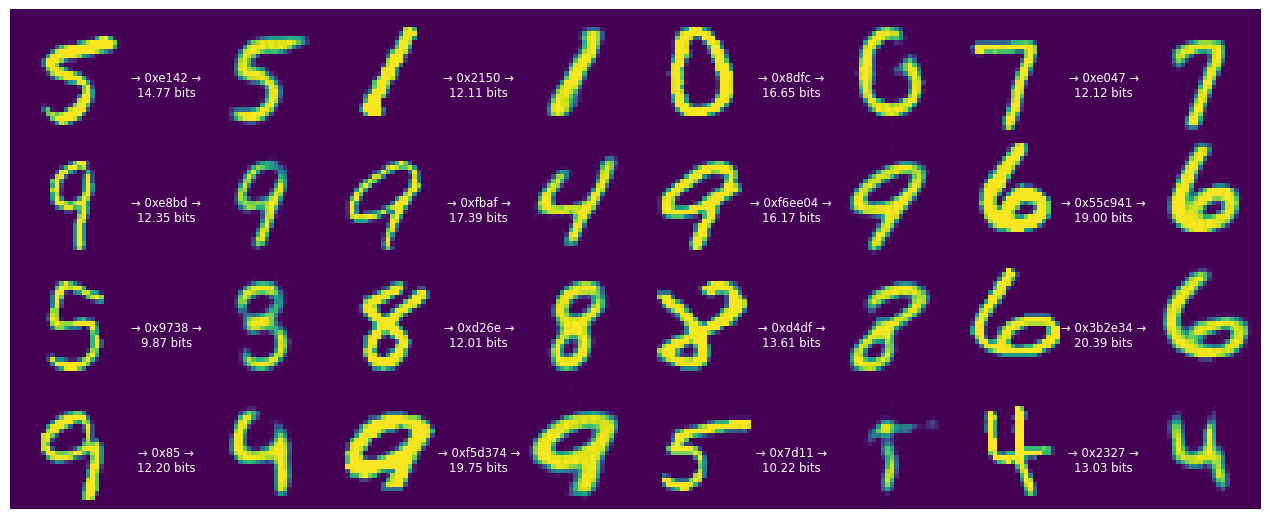

In [ ]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15



  1/469 [..............................] - ETA: 14:02 - loss: 140.1317 - distortion_loss: 0.1241 - rate_loss: 102.9066 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9066


  4/469 [..............................] - ETA: 8s - loss: 142.1121 - distortion_loss: 0.1310 - rate_loss: 102.8232 - distortion_pass_through_loss: 0.1310 - rate_pass_through_loss: 102.8232   


  7/469 [..............................] - ETA: 9s - loss: 142.2690 - distortion_loss: 0.1319 - rate_loss: 102.7137 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.7137


 10/469 [..............................] - ETA: 8s - loss: 142.2438 - distortion_loss: 0.1321 - rate_loss: 102.6068 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6068


 13/469 [..............................] - ETA: 8s - loss: 141.9860 - distortion_loss: 0.1316 - rate_loss: 102.5092 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5092


 16/469 [>.............................] - ETA: 8s - loss: 141.6658 - distortion_loss: 0.1309 - rate_loss: 102.4044 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.4044


 19/469 [>.............................] - ETA: 8s - loss: 141.4616 - distortion_loss: 0.1305 - rate_loss: 102.3054 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 102.3054


 22/469 [>.............................] - ETA: 8s - loss: 141.3124 - distortion_loss: 0.1303 - rate_loss: 102.2155 - distortion_pass_through_loss: 0.1303 - rate_pass_through_loss: 102.2155


 25/469 [>.............................] - ETA: 8s - loss: 140.9907 - distortion_loss: 0.1296 - rate_loss: 102.1236 - distortion_pass_through_loss: 0.1296 - rate_pass_through_loss: 102.1236


 28/469 [>.............................] - ETA: 8s - loss: 140.8795 - distortion_loss: 0.1295 - rate_loss: 102.0287 - distortion_pass_through_loss: 0.1295 - rate_pass_through_loss: 102.0287


 31/469 [>.............................] - ETA: 8s - loss: 140.6079 - distortion_loss: 0.1289 - rate_loss: 101.9410 - distortion_pass_through_loss: 0.1289 - rate_pass_through_loss: 101.9410


 34/469 [=>............................] - ETA: 8s - loss: 140.3509 - distortion_loss: 0.1283 - rate_loss: 101.8566 - distortion_pass_through_loss: 0.1283 - rate_pass_through_loss: 101.8566


 37/469 [=>............................] - ETA: 8s - loss: 140.0090 - distortion_loss: 0.1275 - rate_loss: 101.7728 - distortion_pass_through_loss: 0.1275 - rate_pass_through_loss: 101.7728


 40/469 [=>............................] - ETA: 8s - loss: 139.7074 - distortion_loss: 0.1267 - rate_loss: 101.6872 - distortion_pass_through_loss: 0.1267 - rate_pass_through_loss: 101.6872


 43/469 [=>............................] - ETA: 8s - loss: 139.5062 - distortion_loss: 0.1264 - rate_loss: 101.5959 - distortion_pass_through_loss: 0.1264 - rate_pass_through_loss: 101.5959


 46/469 [=>............................] - ETA: 7s - loss: 139.2752 - distortion_loss: 0.1259 - rate_loss: 101.5066 - distortion_pass_through_loss: 0.1259 - rate_pass_through_loss: 101.5066


 49/469 [==>...........................] - ETA: 7s - loss: 139.0801 - distortion_loss: 0.1255 - rate_loss: 101.4252 - distortion_pass_through_loss: 0.1255 - rate_pass_through_loss: 101.4252


 52/469 [==>...........................] - ETA: 7s - loss: 138.8545 - distortion_loss: 0.1250 - rate_loss: 101.3455 - distortion_pass_through_loss: 0.1250 - rate_pass_through_loss: 101.3455


 55/469 [==>...........................] - ETA: 7s - loss: 138.5775 - distortion_loss: 0.1243 - rate_loss: 101.2775 - distortion_pass_through_loss: 0.1243 - rate_pass_through_loss: 101.2775


 58/469 [==>...........................] - ETA: 7s - loss: 138.3111 - distortion_loss: 0.1237 - rate_loss: 101.2141 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 101.2141


 61/469 [==>...........................] - ETA: 7s - loss: 138.0131 - distortion_loss: 0.1229 - rate_loss: 101.1490 - distortion_pass_through_loss: 0.1229 - rate_pass_through_loss: 101.1490


 64/469 [===>..........................] - ETA: 7s - loss: 137.7419 - distortion_loss: 0.1222 - rate_loss: 101.0815 - distortion_pass_through_loss: 0.1222 - rate_pass_through_loss: 101.0815


 67/469 [===>..........................] - ETA: 7s - loss: 137.4379 - distortion_loss: 0.1214 - rate_loss: 101.0128 - distortion_pass_through_loss: 0.1214 - rate_pass_through_loss: 101.0128


 70/469 [===>..........................] - ETA: 7s - loss: 137.1212 - distortion_loss: 0.1206 - rate_loss: 100.9406 - distortion_pass_through_loss: 0.1206 - rate_pass_through_loss: 100.9406


 73/469 [===>..........................] - ETA: 7s - loss: 136.7733 - distortion_loss: 0.1197 - rate_loss: 100.8680 - distortion_pass_through_loss: 0.1197 - rate_pass_through_loss: 100.8680


 76/469 [===>..........................] - ETA: 7s - loss: 136.4693 - distortion_loss: 0.1189 - rate_loss: 100.7997 - distortion_pass_through_loss: 0.1189 - rate_pass_through_loss: 100.7997


 79/469 [====>.........................] - ETA: 7s - loss: 136.1320 - distortion_loss: 0.1180 - rate_loss: 100.7402 - distortion_pass_through_loss: 0.1180 - rate_pass_through_loss: 100.7402


 82/469 [====>.........................] - ETA: 7s - loss: 135.8003 - distortion_loss: 0.1171 - rate_loss: 100.6744 - distortion_pass_through_loss: 0.1171 - rate_pass_through_loss: 100.6744


 85/469 [====>.........................] - ETA: 7s - loss: 135.4525 - distortion_loss: 0.1161 - rate_loss: 100.6076 - distortion_pass_through_loss: 0.1161 - rate_pass_through_loss: 100.6076


 88/469 [====>.........................] - ETA: 7s - loss: 135.1199 - distortion_loss: 0.1152 - rate_loss: 100.5469 - distortion_pass_through_loss: 0.1152 - rate_pass_through_loss: 100.5469


 91/469 [====>.........................] - ETA: 7s - loss: 134.7682 - distortion_loss: 0.1143 - rate_loss: 100.4854 - distortion_pass_through_loss: 0.1143 - rate_pass_through_loss: 100.4854


 94/469 [=====>........................] - ETA: 6s - loss: 134.4530 - distortion_loss: 0.1134 - rate_loss: 100.4248 - distortion_pass_through_loss: 0.1134 - rate_pass_through_loss: 100.4248


 97/469 [=====>........................] - ETA: 6s - loss: 134.1208 - distortion_loss: 0.1125 - rate_loss: 100.3610 - distortion_pass_through_loss: 0.1125 - rate_pass_through_loss: 100.3610


100/469 [=====>........................] - ETA: 6s - loss: 133.8273 - distortion_loss: 0.1118 - rate_loss: 100.3008 - distortion_pass_through_loss: 0.1118 - rate_pass_through_loss: 100.3008


103/469 [=====>........................] - ETA: 6s - loss: 133.5304 - distortion_loss: 0.1110 - rate_loss: 100.2340 - distortion_pass_through_loss: 0.1110 - rate_pass_through_loss: 100.2340


106/469 [=====>........................] - ETA: 6s - loss: 133.2116 - distortion_loss: 0.1102 - rate_loss: 100.1664 - distortion_pass_through_loss: 0.1102 - rate_pass_through_loss: 100.1664


109/469 [=====>........................] - ETA: 6s - loss: 132.9002 - distortion_loss: 0.1093 - rate_loss: 100.1036 - distortion_pass_through_loss: 0.1093 - rate_pass_through_loss: 100.1036


112/469 [======>.......................] - ETA: 6s - loss: 132.6237 - distortion_loss: 0.1086 - rate_loss: 100.0385 - distortion_pass_through_loss: 0.1086 - rate_pass_through_loss: 100.0385


115/469 [======>.......................] - ETA: 6s - loss: 132.3581 - distortion_loss: 0.1079 - rate_loss: 99.9742 - distortion_pass_through_loss: 0.1079 - rate_pass_through_loss: 99.9742  


118/469 [======>.......................] - ETA: 6s - loss: 132.0652 - distortion_loss: 0.1072 - rate_loss: 99.9093 - distortion_pass_through_loss: 0.1072 - rate_pass_through_loss: 99.9093


121/469 [======>.......................] - ETA: 6s - loss: 131.7876 - distortion_loss: 0.1065 - rate_loss: 99.8451 - distortion_pass_through_loss: 0.1065 - rate_pass_through_loss: 99.8451


124/469 [======>.......................] - ETA: 6s - loss: 131.5134 - distortion_loss: 0.1058 - rate_loss: 99.7779 - distortion_pass_through_loss: 0.1058 - rate_pass_through_loss: 99.7779


127/469 [=======>......................] - ETA: 6s - loss: 131.2310 - distortion_loss: 0.1051 - rate_loss: 99.7109 - distortion_pass_through_loss: 0.1051 - rate_pass_through_loss: 99.7109


130/469 [=======>......................] - ETA: 6s - loss: 130.9549 - distortion_loss: 0.1044 - rate_loss: 99.6402 - distortion_pass_through_loss: 0.1044 - rate_pass_through_loss: 99.6402


133/469 [=======>......................] - ETA: 6s - loss: 130.6826 - distortion_loss: 0.1037 - rate_loss: 99.5734 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 99.5734


136/469 [=======>......................] - ETA: 6s - loss: 130.4299 - distortion_loss: 0.1031 - rate_loss: 99.5038 - distortion_pass_through_loss: 0.1031 - rate_pass_through_loss: 99.5038


139/469 [=======>......................] - ETA: 6s - loss: 130.1859 - distortion_loss: 0.1025 - rate_loss: 99.4370 - distortion_pass_through_loss: 0.1025 - rate_pass_through_loss: 99.4370


142/469 [========>.....................] - ETA: 6s - loss: 129.9347 - distortion_loss: 0.1019 - rate_loss: 99.3709 - distortion_pass_through_loss: 0.1019 - rate_pass_through_loss: 99.3709


145/469 [========>.....................] - ETA: 6s - loss: 129.7001 - distortion_loss: 0.1013 - rate_loss: 99.3020 - distortion_pass_through_loss: 0.1013 - rate_pass_through_loss: 99.3020


148/469 [========>.....................] - ETA: 5s - loss: 129.4644 - distortion_loss: 0.1008 - rate_loss: 99.2323 - distortion_pass_through_loss: 0.1008 - rate_pass_through_loss: 99.2323


151/469 [========>.....................] - ETA: 5s - loss: 129.2290 - distortion_loss: 0.1002 - rate_loss: 99.1647 - distortion_pass_through_loss: 0.1002 - rate_pass_through_loss: 99.1647


154/469 [========>.....................] - ETA: 5s - loss: 129.0129 - distortion_loss: 0.0997 - rate_loss: 99.0952 - distortion_pass_through_loss: 0.0997 - rate_pass_through_loss: 99.0952


157/469 [=========>....................] - ETA: 5s - loss: 128.7950 - distortion_loss: 0.0992 - rate_loss: 99.0276 - distortion_pass_through_loss: 0.0992 - rate_pass_through_loss: 99.0276


160/469 [=========>....................] - ETA: 5s - loss: 128.5819 - distortion_loss: 0.0987 - rate_loss: 98.9578 - distortion_pass_through_loss: 0.0987 - rate_pass_through_loss: 98.9578


163/469 [=========>....................] - ETA: 5s - loss: 128.3564 - distortion_loss: 0.0982 - rate_loss: 98.8862 - distortion_pass_through_loss: 0.0982 - rate_pass_through_loss: 98.8862


166/469 [=========>....................] - ETA: 5s - loss: 128.1454 - distortion_loss: 0.0978 - rate_loss: 98.8159 - distortion_pass_through_loss: 0.0978 - rate_pass_through_loss: 98.8159


169/469 [=========>....................] - ETA: 5s - loss: 127.9402 - distortion_loss: 0.0973 - rate_loss: 98.7453 - distortion_pass_through_loss: 0.0973 - rate_pass_through_loss: 98.7453


172/469 [==========>...................] - ETA: 5s - loss: 127.7284 - distortion_loss: 0.0968 - rate_loss: 98.6759 - distortion_pass_through_loss: 0.0968 - rate_pass_through_loss: 98.6759


175/469 [==========>...................] - ETA: 5s - loss: 127.5294 - distortion_loss: 0.0964 - rate_loss: 98.6038 - distortion_pass_through_loss: 0.0964 - rate_pass_through_loss: 98.6038


178/469 [==========>...................] - ETA: 5s - loss: 127.3260 - distortion_loss: 0.0960 - rate_loss: 98.5331 - distortion_pass_through_loss: 0.0960 - rate_pass_through_loss: 98.5331


181/469 [==========>...................] - ETA: 5s - loss: 127.1338 - distortion_loss: 0.0956 - rate_loss: 98.4646 - distortion_pass_through_loss: 0.0956 - rate_pass_through_loss: 98.4646


184/469 [==========>...................] - ETA: 5s - loss: 126.9410 - distortion_loss: 0.0952 - rate_loss: 98.3934 - distortion_pass_through_loss: 0.0952 - rate_pass_through_loss: 98.3934


187/469 [==========>...................] - ETA: 5s - loss: 126.7424 - distortion_loss: 0.0947 - rate_loss: 98.3220 - distortion_pass_through_loss: 0.0947 - rate_pass_through_loss: 98.3220


190/469 [===========>..................] - ETA: 5s - loss: 126.5544 - distortion_loss: 0.0943 - rate_loss: 98.2503 - distortion_pass_through_loss: 0.0943 - rate_pass_through_loss: 98.2503


193/469 [===========>..................] - ETA: 5s - loss: 126.3688 - distortion_loss: 0.0940 - rate_loss: 98.1764 - distortion_pass_through_loss: 0.0940 - rate_pass_through_loss: 98.1764


196/469 [===========>..................] - ETA: 5s - loss: 126.1832 - distortion_loss: 0.0936 - rate_loss: 98.1035 - distortion_pass_through_loss: 0.0936 - rate_pass_through_loss: 98.1035


199/469 [===========>..................] - ETA: 5s - loss: 125.9890 - distortion_loss: 0.0932 - rate_loss: 98.0281 - distortion_pass_through_loss: 0.0932 - rate_pass_through_loss: 98.0281


202/469 [===========>..................] - ETA: 4s - loss: 125.8005 - distortion_loss: 0.0928 - rate_loss: 97.9555 - distortion_pass_through_loss: 0.0928 - rate_pass_through_loss: 97.9555


205/469 [============>.................] - ETA: 4s - loss: 125.6167 - distortion_loss: 0.0925 - rate_loss: 97.8815 - distortion_pass_through_loss: 0.0925 - rate_pass_through_loss: 97.8815


208/469 [============>.................] - ETA: 4s - loss: 125.4330 - distortion_loss: 0.0921 - rate_loss: 97.8086 - distortion_pass_through_loss: 0.0921 - rate_pass_through_loss: 97.8086


211/469 [============>.................] - ETA: 4s - loss: 125.2451 - distortion_loss: 0.0917 - rate_loss: 97.7342 - distortion_pass_through_loss: 0.0917 - rate_pass_through_loss: 97.7342


214/469 [============>.................] - ETA: 4s - loss: 125.0699 - distortion_loss: 0.0914 - rate_loss: 97.6605 - distortion_pass_through_loss: 0.0914 - rate_pass_through_loss: 97.6605


217/469 [============>.................] - ETA: 4s - loss: 124.8948 - distortion_loss: 0.0910 - rate_loss: 97.5869 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 97.5869


220/469 [=============>................] - ETA: 4s - loss: 124.7211 - distortion_loss: 0.0907 - rate_loss: 97.5137 - distortion_pass_through_loss: 0.0907 - rate_pass_through_loss: 97.5137


223/469 [=============>................] - ETA: 4s - loss: 124.5488 - distortion_loss: 0.0904 - rate_loss: 97.4393 - distortion_pass_through_loss: 0.0904 - rate_pass_through_loss: 97.4393


226/469 [=============>................] - ETA: 4s - loss: 124.3698 - distortion_loss: 0.0900 - rate_loss: 97.3654 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 97.3654


229/469 [=============>................] - ETA: 4s - loss: 124.2047 - distortion_loss: 0.0897 - rate_loss: 97.2913 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 97.2913


232/469 [=============>................] - ETA: 4s - loss: 124.0413 - distortion_loss: 0.0894 - rate_loss: 97.2179 - distortion_pass_through_loss: 0.0894 - rate_pass_through_loss: 97.2179


235/469 [==============>...............] - ETA: 4s - loss: 123.8734 - distortion_loss: 0.0891 - rate_loss: 97.1417 - distortion_pass_through_loss: 0.0891 - rate_pass_through_loss: 97.1417


238/469 [==============>...............] - ETA: 4s - loss: 123.7079 - distortion_loss: 0.0888 - rate_loss: 97.0658 - distortion_pass_through_loss: 0.0888 - rate_pass_through_loss: 97.0658


241/469 [==============>...............] - ETA: 4s - loss: 123.5486 - distortion_loss: 0.0885 - rate_loss: 96.9901 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 96.9901


244/469 [==============>...............] - ETA: 4s - loss: 123.3830 - distortion_loss: 0.0882 - rate_loss: 96.9152 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 96.9152


247/469 [==============>...............] - ETA: 4s - loss: 123.2324 - distortion_loss: 0.0880 - rate_loss: 96.8391 - distortion_pass_through_loss: 0.0880 - rate_pass_through_loss: 96.8391


250/469 [==============>...............] - ETA: 4s - loss: 123.0789 - distortion_loss: 0.0877 - rate_loss: 96.7638 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 96.7638


253/469 [===============>..............] - ETA: 4s - loss: 122.9233 - distortion_loss: 0.0875 - rate_loss: 96.6868 - distortion_pass_through_loss: 0.0875 - rate_pass_through_loss: 96.6868


256/469 [===============>..............] - ETA: 3s - loss: 122.7633 - distortion_loss: 0.0872 - rate_loss: 96.6103 - distortion_pass_through_loss: 0.0872 - rate_pass_through_loss: 96.6103


259/469 [===============>..............] - ETA: 3s - loss: 122.6110 - distortion_loss: 0.0869 - rate_loss: 96.5336 - distortion_pass_through_loss: 0.0869 - rate_pass_through_loss: 96.5336


262/469 [===============>..............] - ETA: 3s - loss: 122.4579 - distortion_loss: 0.0867 - rate_loss: 96.4585 - distortion_pass_through_loss: 0.0867 - rate_pass_through_loss: 96.4585


265/469 [===============>..............] - ETA: 3s - loss: 122.3026 - distortion_loss: 0.0864 - rate_loss: 96.3831 - distortion_pass_through_loss: 0.0864 - rate_pass_through_loss: 96.3831


268/469 [================>.............] - ETA: 3s - loss: 122.1485 - distortion_loss: 0.0861 - rate_loss: 96.3059 - distortion_pass_through_loss: 0.0861 - rate_pass_through_loss: 96.3059


271/469 [================>.............] - ETA: 3s - loss: 121.9987 - distortion_loss: 0.0859 - rate_loss: 96.2292 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 96.2292


274/469 [================>.............] - ETA: 3s - loss: 121.8526 - distortion_loss: 0.0857 - rate_loss: 96.1511 - distortion_pass_through_loss: 0.0857 - rate_pass_through_loss: 96.1511


277/469 [================>.............] - ETA: 3s - loss: 121.7048 - distortion_loss: 0.0854 - rate_loss: 96.0743 - distortion_pass_through_loss: 0.0854 - rate_pass_through_loss: 96.0743


280/469 [================>.............] - ETA: 3s - loss: 121.5553 - distortion_loss: 0.0852 - rate_loss: 95.9985 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 95.9985


283/469 [=================>............] - ETA: 3s - loss: 121.4211 - distortion_loss: 0.0850 - rate_loss: 95.9221 - distortion_pass_through_loss: 0.0850 - rate_pass_through_loss: 95.9221


286/469 [=================>............] - ETA: 3s - loss: 121.2813 - distortion_loss: 0.0848 - rate_loss: 95.8472 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 95.8472


289/469 [=================>............] - ETA: 3s - loss: 121.1394 - distortion_loss: 0.0846 - rate_loss: 95.7699 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 95.7699


292/469 [=================>............] - ETA: 3s - loss: 120.9906 - distortion_loss: 0.0843 - rate_loss: 95.6913 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 95.6913


295/469 [=================>............] - ETA: 3s - loss: 120.8456 - distortion_loss: 0.0841 - rate_loss: 95.6132 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 95.6132


298/469 [==================>...........] - ETA: 3s - loss: 120.7013 - distortion_loss: 0.0839 - rate_loss: 95.5361 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 95.5361


301/469 [==================>...........] - ETA: 3s - loss: 120.5651 - distortion_loss: 0.0837 - rate_loss: 95.4595 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 95.4595


304/469 [==================>...........] - ETA: 3s - loss: 120.4224 - distortion_loss: 0.0835 - rate_loss: 95.3802 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 95.3802


307/469 [==================>...........] - ETA: 3s - loss: 120.2880 - distortion_loss: 0.0833 - rate_loss: 95.3028 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 95.3028


310/469 [==================>...........] - ETA: 2s - loss: 120.1536 - distortion_loss: 0.0831 - rate_loss: 95.2249 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 95.2249


313/469 [===================>..........] - ETA: 2s - loss: 120.0180 - distortion_loss: 0.0829 - rate_loss: 95.1490 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 95.1490


316/469 [===================>..........] - ETA: 2s - loss: 119.8820 - distortion_loss: 0.0827 - rate_loss: 95.0696 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 95.0696


319/469 [===================>..........] - ETA: 2s - loss: 119.7465 - distortion_loss: 0.0825 - rate_loss: 94.9922 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 94.9922


322/469 [===================>..........] - ETA: 2s - loss: 119.6136 - distortion_loss: 0.0823 - rate_loss: 94.9141 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 94.9141


325/469 [===================>..........] - ETA: 2s - loss: 119.4793 - distortion_loss: 0.0821 - rate_loss: 94.8369 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 94.8369


328/469 [===================>..........] - ETA: 2s - loss: 119.3489 - distortion_loss: 0.0820 - rate_loss: 94.7595 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 94.7595


331/469 [====================>.........] - ETA: 2s - loss: 119.2165 - distortion_loss: 0.0818 - rate_loss: 94.6821 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 94.6821


334/469 [====================>.........] - ETA: 2s - loss: 119.0869 - distortion_loss: 0.0816 - rate_loss: 94.6026 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 94.6026


337/469 [====================>.........] - ETA: 2s - loss: 118.9573 - distortion_loss: 0.0814 - rate_loss: 94.5234 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 94.5234


340/469 [====================>.........] - ETA: 2s - loss: 118.8270 - distortion_loss: 0.0813 - rate_loss: 94.4451 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 94.4451


343/469 [====================>.........] - ETA: 2s - loss: 118.6970 - distortion_loss: 0.0811 - rate_loss: 94.3670 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 94.3670


346/469 [=====================>........] - ETA: 2s - loss: 118.5655 - distortion_loss: 0.0809 - rate_loss: 94.2874 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 94.2874


349/469 [=====================>........] - ETA: 2s - loss: 118.4430 - distortion_loss: 0.0808 - rate_loss: 94.2106 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 94.2106


352/469 [=====================>........] - ETA: 2s - loss: 118.3176 - distortion_loss: 0.0806 - rate_loss: 94.1315 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 94.1315


355/469 [=====================>........] - ETA: 2s - loss: 118.1894 - distortion_loss: 0.0805 - rate_loss: 94.0526 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 94.0526


358/469 [=====================>........] - ETA: 2s - loss: 118.0629 - distortion_loss: 0.0803 - rate_loss: 93.9735 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 93.9735


361/469 [======================>.......] - ETA: 2s - loss: 117.9415 - distortion_loss: 0.0802 - rate_loss: 93.8946 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 93.8946


364/469 [======================>.......] - ETA: 1s - loss: 117.8178 - distortion_loss: 0.0800 - rate_loss: 93.8159 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 93.8159


367/469 [======================>.......] - ETA: 1s - loss: 117.6946 - distortion_loss: 0.0799 - rate_loss: 93.7373 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 93.7373


370/469 [======================>.......] - ETA: 1s - loss: 117.5703 - distortion_loss: 0.0797 - rate_loss: 93.6587 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 93.6587


373/469 [======================>.......] - ETA: 1s - loss: 117.4474 - distortion_loss: 0.0796 - rate_loss: 93.5805 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 93.5805


376/469 [=======================>......] - ETA: 1s - loss: 117.3245 - distortion_loss: 0.0794 - rate_loss: 93.5006 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 93.5006


379/469 [=======================>......] - ETA: 1s - loss: 117.2029 - distortion_loss: 0.0793 - rate_loss: 93.4212 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 93.4212


382/469 [=======================>......] - ETA: 1s - loss: 117.0805 - distortion_loss: 0.0791 - rate_loss: 93.3427 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 93.3427


385/469 [=======================>......] - ETA: 1s - loss: 116.9574 - distortion_loss: 0.0790 - rate_loss: 93.2644 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 93.2644


388/469 [=======================>......] - ETA: 1s - loss: 116.8403 - distortion_loss: 0.0788 - rate_loss: 93.1855 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 93.1855


391/469 [========================>.....] - ETA: 1s - loss: 116.7182 - distortion_loss: 0.0787 - rate_loss: 93.1053 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 93.1053


394/469 [========================>.....] - ETA: 1s - loss: 116.5976 - distortion_loss: 0.0786 - rate_loss: 93.0265 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 93.0265


397/469 [========================>.....] - ETA: 1s - loss: 116.4783 - distortion_loss: 0.0784 - rate_loss: 92.9476 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 92.9476


400/469 [========================>.....] - ETA: 1s - loss: 116.3593 - distortion_loss: 0.0783 - rate_loss: 92.8682 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 92.8682


403/469 [========================>.....] - ETA: 1s - loss: 116.2362 - distortion_loss: 0.0782 - rate_loss: 92.7885 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 92.7885


406/469 [========================>.....] - ETA: 1s - loss: 116.1208 - distortion_loss: 0.0780 - rate_loss: 92.7093 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 92.7093


409/469 [=========================>....] - ETA: 1s - loss: 116.0038 - distortion_loss: 0.0779 - rate_loss: 92.6300 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 92.6300


412/469 [=========================>....] - ETA: 1s - loss: 115.8901 - distortion_loss: 0.0778 - rate_loss: 92.5509 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 92.5509


415/469 [=========================>....] - ETA: 1s - loss: 115.7743 - distortion_loss: 0.0777 - rate_loss: 92.4724 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 92.4724


418/469 [=========================>....] - ETA: 0s - loss: 115.6576 - distortion_loss: 0.0775 - rate_loss: 92.3933 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 92.3933


421/469 [=========================>....] - ETA: 0s - loss: 115.5416 - distortion_loss: 0.0774 - rate_loss: 92.3144 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 92.3144


424/469 [==========================>...] - ETA: 0s - loss: 115.4265 - distortion_loss: 0.0773 - rate_loss: 92.2358 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 92.2358


427/469 [==========================>...] - ETA: 0s - loss: 115.3160 - distortion_loss: 0.0772 - rate_loss: 92.1567 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 92.1567


430/469 [==========================>...] - ETA: 0s - loss: 115.2079 - distortion_loss: 0.0771 - rate_loss: 92.0777 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 92.0777


433/469 [==========================>...] - ETA: 0s - loss: 115.0958 - distortion_loss: 0.0770 - rate_loss: 91.9978 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 91.9978


436/469 [==========================>...] - ETA: 0s - loss: 114.9820 - distortion_loss: 0.0769 - rate_loss: 91.9181 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 91.9181


439/469 [===========================>..] - ETA: 0s - loss: 114.8710 - distortion_loss: 0.0768 - rate_loss: 91.8390 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 91.8390


442/469 [===========================>..] - ETA: 0s - loss: 114.7612 - distortion_loss: 0.0767 - rate_loss: 91.7604 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 91.7604


445/469 [===========================>..] - ETA: 0s - loss: 114.6491 - distortion_loss: 0.0766 - rate_loss: 91.6814 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 91.6814


448/469 [===========================>..] - ETA: 0s - loss: 114.5419 - distortion_loss: 0.0765 - rate_loss: 91.6030 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 91.6030


451/469 [===========================>..] - ETA: 0s - loss: 114.4312 - distortion_loss: 0.0764 - rate_loss: 91.5249 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 91.5249


454/469 [============================>.] - ETA: 0s - loss: 114.3208 - distortion_loss: 0.0763 - rate_loss: 91.4454 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 91.4454


457/469 [============================>.] - ETA: 0s - loss: 114.2114 - distortion_loss: 0.0761 - rate_loss: 91.3674 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 91.3674


460/469 [============================>.] - ETA: 0s - loss: 114.1036 - distortion_loss: 0.0761 - rate_loss: 91.2882 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 91.2882


463/469 [============================>.] - ETA: 0s - loss: 113.9955 - distortion_loss: 0.0760 - rate_loss: 91.2087 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 91.2087


466/469 [============================>.] - ETA: 0s - loss: 113.8880 - distortion_loss: 0.0759 - rate_loss: 91.1298 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 91.1298


469/469 [==============================] - ETA: 0s - loss: 113.7853 - distortion_loss: 0.0758 - rate_loss: 91.0564 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 91.0497


469/469 [==============================] - 11s 20ms/step - loss: 113.7853 - distortion_loss: 0.0758 - rate_loss: 91.0564 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 91.0497 - val_loss: 96.0908 - val_distortion_loss: 0.0651 - val_rate_loss: 76.5526 - val_distortion_pass_through_loss: 0.0652 - val_rate_pass_through_loss: 76.5547


Epoch 2/15



  1/469 [..............................] - ETA: 10s - loss: 95.6689 - distortion_loss: 0.0571 - rate_loss: 78.5272 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 78.5272


  4/469 [..............................] - ETA: 8s - loss: 96.4890 - distortion_loss: 0.0597 - rate_loss: 78.5911 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 78.5911 


  7/469 [..............................] - ETA: 8s - loss: 96.6263 - distortion_loss: 0.0603 - rate_loss: 78.5495 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 78.5495


 10/469 [..............................] - ETA: 8s - loss: 96.7075 - distortion_loss: 0.0608 - rate_loss: 78.4757 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 78.4757


 13/469 [..............................] - ETA: 8s - loss: 96.5409 - distortion_loss: 0.0606 - rate_loss: 78.3700 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 78.3700


 16/469 [>.............................] - ETA: 8s - loss: 96.4445 - distortion_loss: 0.0605 - rate_loss: 78.2979 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 78.2979


 19/469 [>.............................] - ETA: 8s - loss: 96.4153 - distortion_loss: 0.0606 - rate_loss: 78.2362 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 78.2362


 22/469 [>.............................] - ETA: 8s - loss: 96.3771 - distortion_loss: 0.0607 - rate_loss: 78.1642 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.1642


 25/469 [>.............................] - ETA: 8s - loss: 96.2792 - distortion_loss: 0.0607 - rate_loss: 78.0775 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.0775


 28/469 [>.............................] - ETA: 8s - loss: 96.2340 - distortion_loss: 0.0607 - rate_loss: 78.0182 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.0182


 31/469 [>.............................] - ETA: 8s - loss: 96.1226 - distortion_loss: 0.0606 - rate_loss: 77.9276 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.9276


 34/469 [=>............................] - ETA: 8s - loss: 96.0645 - distortion_loss: 0.0607 - rate_loss: 77.8537 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.8537


 37/469 [=>............................] - ETA: 7s - loss: 95.9329 - distortion_loss: 0.0606 - rate_loss: 77.7585 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.7585


 40/469 [=>............................] - ETA: 7s - loss: 95.8668 - distortion_loss: 0.0606 - rate_loss: 77.6854 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.6854


 43/469 [=>............................] - ETA: 7s - loss: 95.7798 - distortion_loss: 0.0606 - rate_loss: 77.6021 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.6021


 46/469 [=>............................] - ETA: 7s - loss: 95.6814 - distortion_loss: 0.0605 - rate_loss: 77.5191 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 77.5191


 49/469 [==>...........................] - ETA: 7s - loss: 95.6262 - distortion_loss: 0.0606 - rate_loss: 77.4478 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.4478


 52/469 [==>...........................] - ETA: 7s - loss: 95.5546 - distortion_loss: 0.0606 - rate_loss: 77.3722 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.3722


 55/469 [==>...........................] - ETA: 7s - loss: 95.4725 - distortion_loss: 0.0606 - rate_loss: 77.2946 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.2946


 58/469 [==>...........................] - ETA: 7s - loss: 95.4026 - distortion_loss: 0.0606 - rate_loss: 77.2243 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.2243


 61/469 [==>...........................] - ETA: 7s - loss: 95.3280 - distortion_loss: 0.0606 - rate_loss: 77.1544 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 77.1544


 64/469 [===>..........................] - ETA: 7s - loss: 95.2763 - distortion_loss: 0.0607 - rate_loss: 77.0780 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.0780


 67/469 [===>..........................] - ETA: 7s - loss: 95.2113 - distortion_loss: 0.0607 - rate_loss: 77.0000 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 77.0000


 70/469 [===>..........................] - ETA: 7s - loss: 95.1269 - distortion_loss: 0.0607 - rate_loss: 76.9294 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.9294


 73/469 [===>..........................] - ETA: 7s - loss: 95.0277 - distortion_loss: 0.0606 - rate_loss: 76.8510 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.8510


 76/469 [===>..........................] - ETA: 7s - loss: 94.9524 - distortion_loss: 0.0606 - rate_loss: 76.7739 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.7739


 79/469 [====>.........................] - ETA: 7s - loss: 94.8664 - distortion_loss: 0.0606 - rate_loss: 76.6911 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6911


 82/469 [====>.........................] - ETA: 7s - loss: 94.7893 - distortion_loss: 0.0606 - rate_loss: 76.6199 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 76.6199


 85/469 [====>.........................] - ETA: 7s - loss: 94.7005 - distortion_loss: 0.0605 - rate_loss: 76.5487 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.5487


 88/469 [====>.........................] - ETA: 7s - loss: 94.6160 - distortion_loss: 0.0605 - rate_loss: 76.4713 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 76.4713


 91/469 [====>.........................] - ETA: 7s - loss: 94.5185 - distortion_loss: 0.0604 - rate_loss: 76.3922 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.3922


 94/469 [=====>........................] - ETA: 6s - loss: 94.4450 - distortion_loss: 0.0604 - rate_loss: 76.3147 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.3147


 97/469 [=====>........................] - ETA: 6s - loss: 94.3580 - distortion_loss: 0.0604 - rate_loss: 76.2399 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.2399


100/469 [=====>........................] - ETA: 6s - loss: 94.2886 - distortion_loss: 0.0604 - rate_loss: 76.1734 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.1734


103/469 [=====>........................] - ETA: 6s - loss: 94.2177 - distortion_loss: 0.0604 - rate_loss: 76.0956 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.0956


106/469 [=====>........................] - ETA: 6s - loss: 94.1288 - distortion_loss: 0.0604 - rate_loss: 76.0194 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 76.0194


109/469 [=====>........................] - ETA: 6s - loss: 94.0441 - distortion_loss: 0.0603 - rate_loss: 75.9399 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.9399


112/469 [======>.......................] - ETA: 6s - loss: 93.9699 - distortion_loss: 0.0603 - rate_loss: 75.8708 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.8708


115/469 [======>.......................] - ETA: 6s - loss: 93.9106 - distortion_loss: 0.0604 - rate_loss: 75.7920 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.7920


118/469 [======>.......................] - ETA: 6s - loss: 93.8216 - distortion_loss: 0.0604 - rate_loss: 75.7132 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.7132


121/469 [======>.......................] - ETA: 6s - loss: 93.7368 - distortion_loss: 0.0603 - rate_loss: 75.6426 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.6426


124/469 [======>.......................] - ETA: 6s - loss: 93.6556 - distortion_loss: 0.0603 - rate_loss: 75.5689 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.5689


127/469 [=======>......................] - ETA: 6s - loss: 93.5705 - distortion_loss: 0.0603 - rate_loss: 75.4919 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 75.4919


130/469 [=======>......................] - ETA: 6s - loss: 93.4855 - distortion_loss: 0.0602 - rate_loss: 75.4154 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.4154


133/469 [=======>......................] - ETA: 6s - loss: 93.4026 - distortion_loss: 0.0602 - rate_loss: 75.3372 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.3372


136/469 [=======>......................] - ETA: 6s - loss: 93.3305 - distortion_loss: 0.0602 - rate_loss: 75.2621 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.2621


139/469 [=======>......................] - ETA: 6s - loss: 93.2583 - distortion_loss: 0.0602 - rate_loss: 75.1901 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.1901


142/469 [========>.....................] - ETA: 6s - loss: 93.1811 - distortion_loss: 0.0602 - rate_loss: 75.1139 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.1139


145/469 [========>.....................] - ETA: 6s - loss: 93.1102 - distortion_loss: 0.0602 - rate_loss: 75.0404 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 75.0404


148/469 [========>.....................] - ETA: 6s - loss: 93.0383 - distortion_loss: 0.0603 - rate_loss: 74.9624 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.9624


151/469 [========>.....................] - ETA: 5s - loss: 92.9656 - distortion_loss: 0.0603 - rate_loss: 74.8891 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.8891


154/469 [========>.....................] - ETA: 5s - loss: 92.9028 - distortion_loss: 0.0603 - rate_loss: 74.8192 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.8192


157/469 [=========>....................] - ETA: 5s - loss: 92.8313 - distortion_loss: 0.0603 - rate_loss: 74.7465 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.7465


160/469 [=========>....................] - ETA: 5s - loss: 92.7613 - distortion_loss: 0.0603 - rate_loss: 74.6716 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.6716


163/469 [=========>....................] - ETA: 5s - loss: 92.6843 - distortion_loss: 0.0603 - rate_loss: 74.5988 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.5988


166/469 [=========>....................] - ETA: 5s - loss: 92.6159 - distortion_loss: 0.0603 - rate_loss: 74.5266 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.5266


169/469 [=========>....................] - ETA: 5s - loss: 92.5469 - distortion_loss: 0.0603 - rate_loss: 74.4565 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.4565


172/469 [==========>...................] - ETA: 5s - loss: 92.4682 - distortion_loss: 0.0603 - rate_loss: 74.3810 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.3810


175/469 [==========>...................] - ETA: 5s - loss: 92.4050 - distortion_loss: 0.0603 - rate_loss: 74.3082 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.3082


178/469 [==========>...................] - ETA: 5s - loss: 92.3306 - distortion_loss: 0.0603 - rate_loss: 74.2359 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.2359


181/469 [==========>...................] - ETA: 5s - loss: 92.2669 - distortion_loss: 0.0603 - rate_loss: 74.1653 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 74.1653


184/469 [==========>...................] - ETA: 5s - loss: 92.1991 - distortion_loss: 0.0604 - rate_loss: 74.0894 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 74.0894


187/469 [==========>...................] - ETA: 5s - loss: 92.1284 - distortion_loss: 0.0604 - rate_loss: 74.0118 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 74.0118


190/469 [===========>..................] - ETA: 5s - loss: 92.0635 - distortion_loss: 0.0604 - rate_loss: 73.9435 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.9435


193/469 [===========>..................] - ETA: 5s - loss: 91.9955 - distortion_loss: 0.0604 - rate_loss: 73.8740 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.8740


196/469 [===========>..................] - ETA: 5s - loss: 91.9242 - distortion_loss: 0.0604 - rate_loss: 73.8052 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.8052


199/469 [===========>..................] - ETA: 5s - loss: 91.8443 - distortion_loss: 0.0604 - rate_loss: 73.7292 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.7292


202/469 [===========>..................] - ETA: 5s - loss: 91.7711 - distortion_loss: 0.0604 - rate_loss: 73.6538 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.6538


205/469 [============>.................] - ETA: 4s - loss: 91.6975 - distortion_loss: 0.0604 - rate_loss: 73.5787 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.5787


208/469 [============>.................] - ETA: 4s - loss: 91.6217 - distortion_loss: 0.0604 - rate_loss: 73.5085 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.5085


211/469 [============>.................] - ETA: 4s - loss: 91.5419 - distortion_loss: 0.0604 - rate_loss: 73.4348 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.4348


214/469 [============>.................] - ETA: 4s - loss: 91.4719 - distortion_loss: 0.0604 - rate_loss: 73.3615 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.3615


217/469 [============>.................] - ETA: 4s - loss: 91.3976 - distortion_loss: 0.0604 - rate_loss: 73.2876 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.2876


220/469 [=============>................] - ETA: 4s - loss: 91.3258 - distortion_loss: 0.0604 - rate_loss: 73.2167 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.2167


223/469 [=============>................] - ETA: 4s - loss: 91.2514 - distortion_loss: 0.0604 - rate_loss: 73.1463 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.1463


226/469 [=============>................] - ETA: 4s - loss: 91.1753 - distortion_loss: 0.0603 - rate_loss: 73.0743 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 73.0743


229/469 [=============>................] - ETA: 4s - loss: 91.1080 - distortion_loss: 0.0604 - rate_loss: 73.0015 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 73.0015


232/469 [=============>................] - ETA: 4s - loss: 91.0410 - distortion_loss: 0.0604 - rate_loss: 72.9285 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.9285


235/469 [==============>...............] - ETA: 4s - loss: 90.9688 - distortion_loss: 0.0604 - rate_loss: 72.8575 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.8575


238/469 [==============>...............] - ETA: 4s - loss: 90.8982 - distortion_loss: 0.0604 - rate_loss: 72.7878 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.7878


241/469 [==============>...............] - ETA: 4s - loss: 90.8300 - distortion_loss: 0.0604 - rate_loss: 72.7168 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.7168


244/469 [==============>...............] - ETA: 4s - loss: 90.7563 - distortion_loss: 0.0604 - rate_loss: 72.6412 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.6412


247/469 [==============>...............] - ETA: 4s - loss: 90.6960 - distortion_loss: 0.0604 - rate_loss: 72.5709 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 72.5709


250/469 [==============>...............] - ETA: 4s - loss: 90.6331 - distortion_loss: 0.0605 - rate_loss: 72.4970 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.4970


253/469 [===============>..............] - ETA: 4s - loss: 90.5682 - distortion_loss: 0.0605 - rate_loss: 72.4278 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.4278


256/469 [===============>..............] - ETA: 4s - loss: 90.4965 - distortion_loss: 0.0605 - rate_loss: 72.3550 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.3550


259/469 [===============>..............] - ETA: 3s - loss: 90.4295 - distortion_loss: 0.0605 - rate_loss: 72.2860 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.2860


262/469 [===============>..............] - ETA: 3s - loss: 90.3603 - distortion_loss: 0.0605 - rate_loss: 72.2153 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.2153


265/469 [===============>..............] - ETA: 3s - loss: 90.2901 - distortion_loss: 0.0605 - rate_loss: 72.1421 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.1421


268/469 [================>.............] - ETA: 3s - loss: 90.2179 - distortion_loss: 0.0605 - rate_loss: 72.0712 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.0712


271/469 [================>.............] - ETA: 3s - loss: 90.1528 - distortion_loss: 0.0605 - rate_loss: 71.9987 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.9987


274/469 [================>.............] - ETA: 3s - loss: 90.0869 - distortion_loss: 0.0605 - rate_loss: 71.9292 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.9292


277/469 [================>.............] - ETA: 3s - loss: 90.0179 - distortion_loss: 0.0605 - rate_loss: 71.8581 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.8581


280/469 [================>.............] - ETA: 3s - loss: 89.9465 - distortion_loss: 0.0605 - rate_loss: 71.7886 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 71.7886


283/469 [=================>............] - ETA: 3s - loss: 89.8855 - distortion_loss: 0.0606 - rate_loss: 71.7189 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.7189


286/469 [=================>............] - ETA: 3s - loss: 89.8195 - distortion_loss: 0.0606 - rate_loss: 71.6504 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.6504


289/469 [=================>............] - ETA: 3s - loss: 89.7522 - distortion_loss: 0.0606 - rate_loss: 71.5813 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.5813


292/469 [=================>............] - ETA: 3s - loss: 89.6779 - distortion_loss: 0.0606 - rate_loss: 71.5104 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.5104


295/469 [=================>............] - ETA: 3s - loss: 89.6062 - distortion_loss: 0.0606 - rate_loss: 71.4394 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.4394


298/469 [==================>...........] - ETA: 3s - loss: 89.5357 - distortion_loss: 0.0606 - rate_loss: 71.3689 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.3689


301/469 [==================>...........] - ETA: 3s - loss: 89.4701 - distortion_loss: 0.0606 - rate_loss: 71.3003 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.3003


304/469 [==================>...........] - ETA: 3s - loss: 89.3969 - distortion_loss: 0.0606 - rate_loss: 71.2291 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.2291


307/469 [==================>...........] - ETA: 3s - loss: 89.3329 - distortion_loss: 0.0606 - rate_loss: 71.1591 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.1591


310/469 [==================>...........] - ETA: 3s - loss: 89.2684 - distortion_loss: 0.0606 - rate_loss: 71.0877 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.0877


313/469 [===================>..........] - ETA: 2s - loss: 89.2024 - distortion_loss: 0.0606 - rate_loss: 71.0217 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.0217


316/469 [===================>..........] - ETA: 2s - loss: 89.1370 - distortion_loss: 0.0606 - rate_loss: 70.9555 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.9555


319/469 [===================>..........] - ETA: 2s - loss: 89.0708 - distortion_loss: 0.0606 - rate_loss: 70.8888 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.8888


322/469 [===================>..........] - ETA: 2s - loss: 89.0042 - distortion_loss: 0.0606 - rate_loss: 70.8176 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.8176


325/469 [===================>..........] - ETA: 2s - loss: 88.9356 - distortion_loss: 0.0606 - rate_loss: 70.7450 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.7450


328/469 [===================>..........] - ETA: 2s - loss: 88.8700 - distortion_loss: 0.0606 - rate_loss: 70.6776 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.6776


331/469 [====================>.........] - ETA: 2s - loss: 88.8004 - distortion_loss: 0.0606 - rate_loss: 70.6103 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.6103


334/469 [====================>.........] - ETA: 2s - loss: 88.7349 - distortion_loss: 0.0606 - rate_loss: 70.5411 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.5411


337/469 [====================>.........] - ETA: 2s - loss: 88.6669 - distortion_loss: 0.0607 - rate_loss: 70.4717 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4717


340/469 [====================>.........] - ETA: 2s - loss: 88.5988 - distortion_loss: 0.0607 - rate_loss: 70.4015 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4015


343/469 [====================>.........] - ETA: 2s - loss: 88.5296 - distortion_loss: 0.0607 - rate_loss: 70.3329 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.3329


346/469 [=====================>........] - ETA: 2s - loss: 88.4576 - distortion_loss: 0.0606 - rate_loss: 70.2641 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 70.2641


349/469 [=====================>........] - ETA: 2s - loss: 88.3958 - distortion_loss: 0.0607 - rate_loss: 70.1966 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1966


352/469 [=====================>........] - ETA: 2s - loss: 88.3332 - distortion_loss: 0.0607 - rate_loss: 70.1290 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1290


355/469 [=====================>........] - ETA: 2s - loss: 88.2659 - distortion_loss: 0.0607 - rate_loss: 70.0597 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.0597


358/469 [=====================>........] - ETA: 2s - loss: 88.1986 - distortion_loss: 0.0607 - rate_loss: 69.9921 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.9921


361/469 [======================>.......] - ETA: 2s - loss: 88.1365 - distortion_loss: 0.0607 - rate_loss: 69.9257 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.9257


364/469 [======================>.......] - ETA: 1s - loss: 88.0741 - distortion_loss: 0.0607 - rate_loss: 69.8572 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.8572


367/469 [======================>.......] - ETA: 1s - loss: 88.0092 - distortion_loss: 0.0607 - rate_loss: 69.7905 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.7905


370/469 [======================>.......] - ETA: 1s - loss: 87.9436 - distortion_loss: 0.0607 - rate_loss: 69.7229 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.7229


373/469 [======================>.......] - ETA: 1s - loss: 87.8781 - distortion_loss: 0.0607 - rate_loss: 69.6561 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.6561


376/469 [=======================>......] - ETA: 1s - loss: 87.8112 - distortion_loss: 0.0607 - rate_loss: 69.5878 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.5878


379/469 [=======================>......] - ETA: 1s - loss: 87.7441 - distortion_loss: 0.0607 - rate_loss: 69.5198 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.5198


382/469 [=======================>......] - ETA: 1s - loss: 87.6772 - distortion_loss: 0.0607 - rate_loss: 69.4523 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.4523


385/469 [=======================>......] - ETA: 1s - loss: 87.6094 - distortion_loss: 0.0607 - rate_loss: 69.3843 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 69.3843


388/469 [=======================>......] - ETA: 1s - loss: 87.5464 - distortion_loss: 0.0608 - rate_loss: 69.3161 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.3161


391/469 [========================>.....] - ETA: 1s - loss: 87.4807 - distortion_loss: 0.0608 - rate_loss: 69.2500 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.2500


394/469 [========================>.....] - ETA: 1s - loss: 87.4152 - distortion_loss: 0.0608 - rate_loss: 69.1795 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.1795


397/469 [========================>.....] - ETA: 1s - loss: 87.3504 - distortion_loss: 0.0608 - rate_loss: 69.1126 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.1126


400/469 [========================>.....] - ETA: 1s - loss: 87.2851 - distortion_loss: 0.0608 - rate_loss: 69.0463 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.0463


403/469 [========================>.....] - ETA: 1s - loss: 87.2143 - distortion_loss: 0.0608 - rate_loss: 68.9818 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.9818


406/469 [========================>.....] - ETA: 1s - loss: 87.1507 - distortion_loss: 0.0608 - rate_loss: 68.9154 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.9154


409/469 [=========================>....] - ETA: 1s - loss: 87.0888 - distortion_loss: 0.0608 - rate_loss: 68.8472 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.8472


412/469 [=========================>....] - ETA: 1s - loss: 87.0267 - distortion_loss: 0.0608 - rate_loss: 68.7815 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.7815


415/469 [=========================>....] - ETA: 1s - loss: 86.9626 - distortion_loss: 0.0608 - rate_loss: 68.7148 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.7148


418/469 [=========================>....] - ETA: 0s - loss: 86.8980 - distortion_loss: 0.0608 - rate_loss: 68.6500 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.6500


421/469 [=========================>....] - ETA: 0s - loss: 86.8337 - distortion_loss: 0.0608 - rate_loss: 68.5847 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.5847


424/469 [==========================>...] - ETA: 0s - loss: 86.7682 - distortion_loss: 0.0608 - rate_loss: 68.5157 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.5157


427/469 [==========================>...] - ETA: 0s - loss: 86.7080 - distortion_loss: 0.0609 - rate_loss: 68.4491 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.4491


430/469 [==========================>...] - ETA: 0s - loss: 86.6500 - distortion_loss: 0.0609 - rate_loss: 68.3858 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.3858


433/469 [==========================>...] - ETA: 0s - loss: 86.5891 - distortion_loss: 0.0609 - rate_loss: 68.3186 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.3186


436/469 [==========================>...] - ETA: 0s - loss: 86.5251 - distortion_loss: 0.0609 - rate_loss: 68.2515 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.2515


439/469 [===========================>..] - ETA: 0s - loss: 86.4612 - distortion_loss: 0.0609 - rate_loss: 68.1849 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.1849


442/469 [===========================>..] - ETA: 0s - loss: 86.4015 - distortion_loss: 0.0609 - rate_loss: 68.1207 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.1207


445/469 [===========================>..] - ETA: 0s - loss: 86.3370 - distortion_loss: 0.0609 - rate_loss: 68.0549 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.0549


448/469 [===========================>..] - ETA: 0s - loss: 86.2759 - distortion_loss: 0.0610 - rate_loss: 67.9903 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9903


451/469 [===========================>..] - ETA: 0s - loss: 86.2109 - distortion_loss: 0.0610 - rate_loss: 67.9229 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9229


454/469 [============================>.] - ETA: 0s - loss: 86.1469 - distortion_loss: 0.0610 - rate_loss: 67.8576 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.8576


457/469 [============================>.] - ETA: 0s - loss: 86.0842 - distortion_loss: 0.0610 - rate_loss: 67.7937 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7937


460/469 [============================>.] - ETA: 0s - loss: 86.0221 - distortion_loss: 0.0610 - rate_loss: 67.7288 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7288


463/469 [============================>.] - ETA: 0s - loss: 85.9591 - distortion_loss: 0.0610 - rate_loss: 67.6644 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.6644


466/469 [============================>.] - ETA: 0s - loss: 85.8976 - distortion_loss: 0.0610 - rate_loss: 67.5995 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5995


469/469 [==============================] - ETA: 0s - loss: 85.8370 - distortion_loss: 0.0610 - rate_loss: 67.5377 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5322


469/469 [==============================] - 10s 20ms/step - loss: 85.8370 - distortion_loss: 0.0610 - rate_loss: 67.5377 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5322 - val_loss: 73.6748 - val_distortion_loss: 0.0746 - val_rate_loss: 51.3058 - val_distortion_pass_through_loss: 0.0746 - val_rate_pass_through_loss: 51.3106


Epoch 3/15



  1/469 [..............................] - ETA: 10s - loss: 74.8911 - distortion_loss: 0.0587 - rate_loss: 57.2673 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 57.2673


  4/469 [..............................] - ETA: 9s - loss: 75.8297 - distortion_loss: 0.0608 - rate_loss: 57.5813 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 57.5813 


  7/469 [..............................] - ETA: 9s - loss: 75.9757 - distortion_loss: 0.0620 - rate_loss: 57.3787 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 57.3787


 10/469 [..............................] - ETA: 9s - loss: 76.0252 - distortion_loss: 0.0623 - rate_loss: 57.3233 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 57.3233


 13/469 [..............................] - ETA: 8s - loss: 75.9215 - distortion_loss: 0.0622 - rate_loss: 57.2672 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.2672


 16/469 [>.............................] - ETA: 8s - loss: 75.7924 - distortion_loss: 0.0621 - rate_loss: 57.1646 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 57.1646


 19/469 [>.............................] - ETA: 8s - loss: 75.7395 - distortion_loss: 0.0622 - rate_loss: 57.0773 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 57.0773


 22/469 [>.............................] - ETA: 8s - loss: 75.7755 - distortion_loss: 0.0625 - rate_loss: 57.0119 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 57.0119


 25/469 [>.............................] - ETA: 8s - loss: 75.7343 - distortion_loss: 0.0627 - rate_loss: 56.9333 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.9333


 28/469 [>.............................] - ETA: 8s - loss: 75.7253 - distortion_loss: 0.0628 - rate_loss: 56.8883 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.8883


 31/469 [>.............................] - ETA: 8s - loss: 75.6713 - distortion_loss: 0.0629 - rate_loss: 56.8094 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.8094


 34/469 [=>............................] - ETA: 8s - loss: 75.6405 - distortion_loss: 0.0630 - rate_loss: 56.7386 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 56.7386


 37/469 [=>............................] - ETA: 8s - loss: 75.5345 - distortion_loss: 0.0628 - rate_loss: 56.6834 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.6834


 40/469 [=>............................] - ETA: 8s - loss: 75.4862 - distortion_loss: 0.0628 - rate_loss: 56.6492 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.6492


 43/469 [=>............................] - ETA: 8s - loss: 75.4208 - distortion_loss: 0.0628 - rate_loss: 56.5901 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.5901


 46/469 [=>............................] - ETA: 8s - loss: 75.3343 - distortion_loss: 0.0627 - rate_loss: 56.5149 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.5149


 49/469 [==>...........................] - ETA: 8s - loss: 75.3063 - distortion_loss: 0.0628 - rate_loss: 56.4638 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.4638


 52/469 [==>...........................] - ETA: 8s - loss: 75.2756 - distortion_loss: 0.0629 - rate_loss: 56.4148 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.4148


 55/469 [==>...........................] - ETA: 7s - loss: 75.2043 - distortion_loss: 0.0628 - rate_loss: 56.3642 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.3642


 58/469 [==>...........................] - ETA: 7s - loss: 75.1433 - distortion_loss: 0.0628 - rate_loss: 56.2907 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.2907


 61/469 [==>...........................] - ETA: 7s - loss: 75.0934 - distortion_loss: 0.0629 - rate_loss: 56.2224 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.2224


 64/469 [===>..........................] - ETA: 7s - loss: 75.0588 - distortion_loss: 0.0630 - rate_loss: 56.1715 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 56.1715


 67/469 [===>..........................] - ETA: 7s - loss: 75.0170 - distortion_loss: 0.0629 - rate_loss: 56.1371 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1371


 70/469 [===>..........................] - ETA: 7s - loss: 74.9532 - distortion_loss: 0.0629 - rate_loss: 56.0751 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0751


 73/469 [===>..........................] - ETA: 7s - loss: 74.8812 - distortion_loss: 0.0629 - rate_loss: 56.0110 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.0110


 76/469 [===>..........................] - ETA: 7s - loss: 74.8341 - distortion_loss: 0.0629 - rate_loss: 55.9626 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9626


 79/469 [====>.........................] - ETA: 7s - loss: 74.7804 - distortion_loss: 0.0629 - rate_loss: 55.9098 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9098


 82/469 [====>.........................] - ETA: 7s - loss: 74.7271 - distortion_loss: 0.0629 - rate_loss: 55.8625 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.8625


 85/469 [====>.........................] - ETA: 7s - loss: 74.6593 - distortion_loss: 0.0629 - rate_loss: 55.7926 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7926


 88/469 [====>.........................] - ETA: 7s - loss: 74.6060 - distortion_loss: 0.0629 - rate_loss: 55.7392 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7392


 91/469 [====>.........................] - ETA: 7s - loss: 74.5315 - distortion_loss: 0.0628 - rate_loss: 55.6790 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.6790


 94/469 [=====>........................] - ETA: 7s - loss: 74.4794 - distortion_loss: 0.0629 - rate_loss: 55.6239 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.6239


 97/469 [=====>........................] - ETA: 7s - loss: 74.4097 - distortion_loss: 0.0628 - rate_loss: 55.5763 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5763


100/469 [=====>........................] - ETA: 7s - loss: 74.3632 - distortion_loss: 0.0628 - rate_loss: 55.5233 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5233


103/469 [=====>........................] - ETA: 6s - loss: 74.3106 - distortion_loss: 0.0628 - rate_loss: 55.4582 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4582


106/469 [=====>........................] - ETA: 6s - loss: 74.2439 - distortion_loss: 0.0628 - rate_loss: 55.4037 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.4037


109/469 [=====>........................] - ETA: 6s - loss: 74.1781 - distortion_loss: 0.0628 - rate_loss: 55.3470 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3470


112/469 [======>.......................] - ETA: 6s - loss: 74.1371 - distortion_loss: 0.0628 - rate_loss: 55.2918 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2918


115/469 [======>.......................] - ETA: 6s - loss: 74.1048 - distortion_loss: 0.0629 - rate_loss: 55.2421 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.2421


118/469 [======>.......................] - ETA: 6s - loss: 74.0430 - distortion_loss: 0.0629 - rate_loss: 55.1840 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.1840


121/469 [======>.......................] - ETA: 6s - loss: 73.9849 - distortion_loss: 0.0629 - rate_loss: 55.1293 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.1293


124/469 [======>.......................] - ETA: 6s - loss: 73.9399 - distortion_loss: 0.0629 - rate_loss: 55.0747 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.0747


127/469 [=======>......................] - ETA: 6s - loss: 73.8844 - distortion_loss: 0.0629 - rate_loss: 55.0175 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.0175


130/469 [=======>......................] - ETA: 6s - loss: 73.8245 - distortion_loss: 0.0629 - rate_loss: 54.9624 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.9624


133/469 [=======>......................] - ETA: 6s - loss: 73.7651 - distortion_loss: 0.0629 - rate_loss: 54.9064 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.9064


136/469 [=======>......................] - ETA: 6s - loss: 73.7154 - distortion_loss: 0.0629 - rate_loss: 54.8501 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.8501


139/469 [=======>......................] - ETA: 6s - loss: 73.6703 - distortion_loss: 0.0629 - rate_loss: 54.7982 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.7982


142/469 [========>.....................] - ETA: 6s - loss: 73.6165 - distortion_loss: 0.0629 - rate_loss: 54.7465 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.7465


145/469 [========>.....................] - ETA: 6s - loss: 73.5699 - distortion_loss: 0.0629 - rate_loss: 54.6935 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.6935


148/469 [========>.....................] - ETA: 6s - loss: 73.5177 - distortion_loss: 0.0629 - rate_loss: 54.6403 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.6403


151/469 [========>.....................] - ETA: 6s - loss: 73.4741 - distortion_loss: 0.0630 - rate_loss: 54.5877 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.5877


154/469 [========>.....................] - ETA: 6s - loss: 73.4346 - distortion_loss: 0.0630 - rate_loss: 54.5385 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.5385


157/469 [=========>....................] - ETA: 6s - loss: 73.3896 - distortion_loss: 0.0630 - rate_loss: 54.4852 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.4852


160/469 [=========>....................] - ETA: 5s - loss: 73.3463 - distortion_loss: 0.0630 - rate_loss: 54.4387 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.4387


163/469 [=========>....................] - ETA: 5s - loss: 73.2935 - distortion_loss: 0.0630 - rate_loss: 54.3822 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.3822


166/469 [=========>....................] - ETA: 5s - loss: 73.2490 - distortion_loss: 0.0631 - rate_loss: 54.3260 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.3260


169/469 [=========>....................] - ETA: 5s - loss: 73.2050 - distortion_loss: 0.0631 - rate_loss: 54.2710 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.2710


172/469 [==========>...................] - ETA: 5s - loss: 73.1485 - distortion_loss: 0.0631 - rate_loss: 54.2207 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.2207


175/469 [==========>...................] - ETA: 5s - loss: 73.1081 - distortion_loss: 0.0631 - rate_loss: 54.1681 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.1681


178/469 [==========>...................] - ETA: 5s - loss: 73.0598 - distortion_loss: 0.0631 - rate_loss: 54.1160 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.1160


181/469 [==========>...................] - ETA: 5s - loss: 73.0146 - distortion_loss: 0.0632 - rate_loss: 54.0657 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 54.0657


184/469 [==========>...................] - ETA: 5s - loss: 72.9709 - distortion_loss: 0.0632 - rate_loss: 54.0147 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 54.0147


187/469 [==========>...................] - ETA: 5s - loss: 72.9220 - distortion_loss: 0.0632 - rate_loss: 53.9626 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.9626


190/469 [===========>..................] - ETA: 5s - loss: 72.8788 - distortion_loss: 0.0632 - rate_loss: 53.9099 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.9099


193/469 [===========>..................] - ETA: 5s - loss: 72.8331 - distortion_loss: 0.0633 - rate_loss: 53.8579 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.8579


196/469 [===========>..................] - ETA: 5s - loss: 72.7894 - distortion_loss: 0.0633 - rate_loss: 53.8098 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.8098


199/469 [===========>..................] - ETA: 5s - loss: 72.7388 - distortion_loss: 0.0633 - rate_loss: 53.7556 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.7556


202/469 [===========>..................] - ETA: 5s - loss: 72.6873 - distortion_loss: 0.0633 - rate_loss: 53.7059 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.7059


205/469 [============>.................] - ETA: 5s - loss: 72.6402 - distortion_loss: 0.0633 - rate_loss: 53.6508 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.6508


208/469 [============>.................] - ETA: 5s - loss: 72.5925 - distortion_loss: 0.0633 - rate_loss: 53.5980 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.5980


211/469 [============>.................] - ETA: 4s - loss: 72.5398 - distortion_loss: 0.0633 - rate_loss: 53.5463 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.5463


214/469 [============>.................] - ETA: 4s - loss: 72.4917 - distortion_loss: 0.0633 - rate_loss: 53.4940 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4940


217/469 [============>.................] - ETA: 4s - loss: 72.4444 - distortion_loss: 0.0633 - rate_loss: 53.4400 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4400


220/469 [=============>................] - ETA: 4s - loss: 72.4008 - distortion_loss: 0.0634 - rate_loss: 53.3908 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.3908


223/469 [=============>................] - ETA: 4s - loss: 72.3504 - distortion_loss: 0.0634 - rate_loss: 53.3371 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.3371


226/469 [=============>................] - ETA: 4s - loss: 72.2949 - distortion_loss: 0.0634 - rate_loss: 53.2862 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.2862


229/469 [=============>................] - ETA: 4s - loss: 72.2506 - distortion_loss: 0.0634 - rate_loss: 53.2391 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.2391


232/469 [=============>................] - ETA: 4s - loss: 72.2073 - distortion_loss: 0.0634 - rate_loss: 53.1860 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.1860


235/469 [==============>...............] - ETA: 4s - loss: 72.1570 - distortion_loss: 0.0634 - rate_loss: 53.1348 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.1348


238/469 [==============>...............] - ETA: 4s - loss: 72.1122 - distortion_loss: 0.0634 - rate_loss: 53.0863 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0863


241/469 [==============>...............] - ETA: 4s - loss: 72.0671 - distortion_loss: 0.0634 - rate_loss: 53.0337 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0337


244/469 [==============>...............] - ETA: 4s - loss: 72.0125 - distortion_loss: 0.0634 - rate_loss: 52.9810 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.9810


247/469 [==============>...............] - ETA: 4s - loss: 71.9739 - distortion_loss: 0.0635 - rate_loss: 52.9343 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.9343


250/469 [==============>...............] - ETA: 4s - loss: 71.9322 - distortion_loss: 0.0635 - rate_loss: 52.8857 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8857


253/469 [===============>..............] - ETA: 4s - loss: 71.8849 - distortion_loss: 0.0635 - rate_loss: 52.8343 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8343


256/469 [===============>..............] - ETA: 4s - loss: 71.8364 - distortion_loss: 0.0635 - rate_loss: 52.7840 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7840


259/469 [===============>..............] - ETA: 4s - loss: 71.7891 - distortion_loss: 0.0635 - rate_loss: 52.7390 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7390


262/469 [===============>..............] - ETA: 3s - loss: 71.7420 - distortion_loss: 0.0635 - rate_loss: 52.6849 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6849


265/469 [===============>..............] - ETA: 3s - loss: 71.6914 - distortion_loss: 0.0635 - rate_loss: 52.6320 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6320


268/469 [================>.............] - ETA: 3s - loss: 71.6415 - distortion_loss: 0.0635 - rate_loss: 52.5840 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5840


271/469 [================>.............] - ETA: 3s - loss: 71.5996 - distortion_loss: 0.0635 - rate_loss: 52.5383 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5383


274/469 [================>.............] - ETA: 3s - loss: 71.5542 - distortion_loss: 0.0636 - rate_loss: 52.4841 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.4841


277/469 [================>.............] - ETA: 3s - loss: 71.5081 - distortion_loss: 0.0636 - rate_loss: 52.4311 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.4311


280/469 [================>.............] - ETA: 3s - loss: 71.4601 - distortion_loss: 0.0636 - rate_loss: 52.3843 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3843


283/469 [=================>............] - ETA: 3s - loss: 71.4252 - distortion_loss: 0.0636 - rate_loss: 52.3413 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3413


286/469 [=================>............] - ETA: 3s - loss: 71.3808 - distortion_loss: 0.0636 - rate_loss: 52.2928 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2928


289/469 [=================>............] - ETA: 3s - loss: 71.3379 - distortion_loss: 0.0637 - rate_loss: 52.2428 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.2428


292/469 [=================>............] - ETA: 3s - loss: 71.2892 - distortion_loss: 0.0636 - rate_loss: 52.1949 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1949


295/469 [=================>............] - ETA: 3s - loss: 71.2401 - distortion_loss: 0.0636 - rate_loss: 52.1477 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.1477


298/469 [==================>...........] - ETA: 3s - loss: 71.1904 - distortion_loss: 0.0636 - rate_loss: 52.0977 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0977


301/469 [==================>...........] - ETA: 3s - loss: 71.1504 - distortion_loss: 0.0637 - rate_loss: 52.0470 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.0470


304/469 [==================>...........] - ETA: 3s - loss: 71.1014 - distortion_loss: 0.0637 - rate_loss: 51.9978 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9978


307/469 [==================>...........] - ETA: 3s - loss: 71.0618 - distortion_loss: 0.0637 - rate_loss: 51.9543 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9543


310/469 [==================>...........] - ETA: 3s - loss: 71.0166 - distortion_loss: 0.0637 - rate_loss: 51.9052 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9052


313/469 [===================>..........] - ETA: 2s - loss: 70.9748 - distortion_loss: 0.0637 - rate_loss: 51.8550 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8550


316/469 [===================>..........] - ETA: 2s - loss: 70.9329 - distortion_loss: 0.0638 - rate_loss: 51.8043 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.8043


319/469 [===================>..........] - ETA: 2s - loss: 70.8867 - distortion_loss: 0.0638 - rate_loss: 51.7596 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7596


322/469 [===================>..........] - ETA: 2s - loss: 70.8453 - distortion_loss: 0.0638 - rate_loss: 51.7142 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7142


325/469 [===================>..........] - ETA: 2s - loss: 70.8007 - distortion_loss: 0.0638 - rate_loss: 51.6632 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6632


328/469 [===================>..........] - ETA: 2s - loss: 70.7612 - distortion_loss: 0.0638 - rate_loss: 51.6210 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6210


331/469 [====================>.........] - ETA: 2s - loss: 70.7185 - distortion_loss: 0.0638 - rate_loss: 51.5723 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5723


334/469 [====================>.........] - ETA: 2s - loss: 70.6804 - distortion_loss: 0.0639 - rate_loss: 51.5223 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.5223


337/469 [====================>.........] - ETA: 2s - loss: 70.6390 - distortion_loss: 0.0639 - rate_loss: 51.4790 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4790


340/469 [====================>.........] - ETA: 2s - loss: 70.5956 - distortion_loss: 0.0639 - rate_loss: 51.4337 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4337


343/469 [====================>.........] - ETA: 2s - loss: 70.5506 - distortion_loss: 0.0639 - rate_loss: 51.3860 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3860


346/469 [=====================>........] - ETA: 2s - loss: 70.5023 - distortion_loss: 0.0639 - rate_loss: 51.3347 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3347


349/469 [=====================>........] - ETA: 2s - loss: 70.4639 - distortion_loss: 0.0639 - rate_loss: 51.2885 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2885


352/469 [=====================>........] - ETA: 2s - loss: 70.4218 - distortion_loss: 0.0639 - rate_loss: 51.2427 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.2427


355/469 [=====================>........] - ETA: 2s - loss: 70.3780 - distortion_loss: 0.0639 - rate_loss: 51.1959 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1959


358/469 [=====================>........] - ETA: 2s - loss: 70.3330 - distortion_loss: 0.0639 - rate_loss: 51.1508 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1508


361/469 [======================>.......] - ETA: 2s - loss: 70.2937 - distortion_loss: 0.0640 - rate_loss: 51.1027 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.1027


364/469 [======================>.......] - ETA: 2s - loss: 70.2552 - distortion_loss: 0.0640 - rate_loss: 51.0536 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0536


367/469 [======================>.......] - ETA: 1s - loss: 70.2122 - distortion_loss: 0.0640 - rate_loss: 51.0105 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0105


370/469 [======================>.......] - ETA: 1s - loss: 70.1662 - distortion_loss: 0.0640 - rate_loss: 50.9631 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9631


373/469 [======================>.......] - ETA: 1s - loss: 70.1235 - distortion_loss: 0.0640 - rate_loss: 50.9159 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.9159


376/469 [=======================>......] - ETA: 1s - loss: 70.0769 - distortion_loss: 0.0640 - rate_loss: 50.8668 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8668


379/469 [=======================>......] - ETA: 1s - loss: 70.0344 - distortion_loss: 0.0640 - rate_loss: 50.8199 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8199


382/469 [=======================>......] - ETA: 1s - loss: 69.9903 - distortion_loss: 0.0640 - rate_loss: 50.7765 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.7765


385/469 [=======================>......] - ETA: 1s - loss: 69.9465 - distortion_loss: 0.0641 - rate_loss: 50.7305 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.7305


388/469 [=======================>......] - ETA: 1s - loss: 69.9091 - distortion_loss: 0.0641 - rate_loss: 50.6817 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6817


391/469 [========================>.....] - ETA: 1s - loss: 69.8646 - distortion_loss: 0.0641 - rate_loss: 50.6351 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.6351


394/469 [========================>.....] - ETA: 1s - loss: 69.8223 - distortion_loss: 0.0641 - rate_loss: 50.5901 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5901


397/469 [========================>.....] - ETA: 1s - loss: 69.7819 - distortion_loss: 0.0641 - rate_loss: 50.5445 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5445


400/469 [========================>.....] - ETA: 1s - loss: 69.7390 - distortion_loss: 0.0641 - rate_loss: 50.4984 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4984


403/469 [========================>.....] - ETA: 1s - loss: 69.6928 - distortion_loss: 0.0641 - rate_loss: 50.4535 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4535


406/469 [========================>.....] - ETA: 1s - loss: 69.6512 - distortion_loss: 0.0641 - rate_loss: 50.4082 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.4082


409/469 [=========================>....] - ETA: 1s - loss: 69.6102 - distortion_loss: 0.0642 - rate_loss: 50.3609 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3609


412/469 [=========================>....] - ETA: 1s - loss: 69.5754 - distortion_loss: 0.0642 - rate_loss: 50.3171 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.3171


415/469 [=========================>....] - ETA: 1s - loss: 69.5339 - distortion_loss: 0.0642 - rate_loss: 50.2711 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2711


418/469 [=========================>....] - ETA: 0s - loss: 69.4927 - distortion_loss: 0.0642 - rate_loss: 50.2272 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.2272


421/469 [=========================>....] - ETA: 0s - loss: 69.4498 - distortion_loss: 0.0642 - rate_loss: 50.1797 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1797


424/469 [==========================>...] - ETA: 0s - loss: 69.4079 - distortion_loss: 0.0643 - rate_loss: 50.1325 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.1325


427/469 [==========================>...] - ETA: 0s - loss: 69.3688 - distortion_loss: 0.0643 - rate_loss: 50.0894 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0894


430/469 [==========================>...] - ETA: 0s - loss: 69.3333 - distortion_loss: 0.0643 - rate_loss: 50.0460 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0460


433/469 [==========================>...] - ETA: 0s - loss: 69.2947 - distortion_loss: 0.0643 - rate_loss: 50.0005 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.0005


436/469 [==========================>...] - ETA: 0s - loss: 69.2526 - distortion_loss: 0.0643 - rate_loss: 49.9513 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9513


439/469 [===========================>..] - ETA: 0s - loss: 69.2134 - distortion_loss: 0.0643 - rate_loss: 49.9101 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.9101


442/469 [===========================>..] - ETA: 0s - loss: 69.1747 - distortion_loss: 0.0644 - rate_loss: 49.8677 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8677


445/469 [===========================>..] - ETA: 0s - loss: 69.1343 - distortion_loss: 0.0644 - rate_loss: 49.8199 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8199


448/469 [===========================>..] - ETA: 0s - loss: 69.0972 - distortion_loss: 0.0644 - rate_loss: 49.7776 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7776


451/469 [===========================>..] - ETA: 0s - loss: 69.0545 - distortion_loss: 0.0644 - rate_loss: 49.7323 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.7323


454/469 [============================>.] - ETA: 0s - loss: 69.0129 - distortion_loss: 0.0644 - rate_loss: 49.6864 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6864


457/469 [============================>.] - ETA: 0s - loss: 68.9718 - distortion_loss: 0.0644 - rate_loss: 49.6421 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.6421


460/469 [============================>.] - ETA: 0s - loss: 68.9325 - distortion_loss: 0.0644 - rate_loss: 49.5999 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.5999


463/469 [============================>.] - ETA: 0s - loss: 68.8932 - distortion_loss: 0.0645 - rate_loss: 49.5558 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5558


466/469 [============================>.] - ETA: 0s - loss: 68.8558 - distortion_loss: 0.0645 - rate_loss: 49.5133 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.5133


469/469 [==============================] - ETA: 0s - loss: 68.8140 - distortion_loss: 0.0645 - rate_loss: 49.4723 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4686


469/469 [==============================] - 10s 20ms/step - loss: 68.8140 - distortion_loss: 0.0645 - rate_loss: 49.4723 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.4686 - val_loss: 58.1460 - val_distortion_loss: 0.0887 - val_rate_loss: 31.5460 - val_distortion_pass_through_loss: 0.0888 - val_rate_pass_through_loss: 31.5357


Epoch 4/15



  1/469 [..............................] - ETA: 10s - loss: 61.3778 - distortion_loss: 0.0633 - rate_loss: 42.3818 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 42.3818


  4/469 [..............................] - ETA: 9s - loss: 62.3081 - distortion_loss: 0.0666 - rate_loss: 42.3223 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 42.3223 


  7/469 [..............................] - ETA: 8s - loss: 62.5707 - distortion_loss: 0.0670 - rate_loss: 42.4802 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.4802


 10/469 [..............................] - ETA: 9s - loss: 62.7517 - distortion_loss: 0.0674 - rate_loss: 42.5422 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.5422


 13/469 [..............................] - ETA: 8s - loss: 62.5289 - distortion_loss: 0.0670 - rate_loss: 42.4327 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.4327


 16/469 [>.............................] - ETA: 8s - loss: 62.3928 - distortion_loss: 0.0668 - rate_loss: 42.3440 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 42.3440


 19/469 [>.............................] - ETA: 8s - loss: 62.4067 - distortion_loss: 0.0669 - rate_loss: 42.3297 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.3297


 22/469 [>.............................] - ETA: 8s - loss: 62.4483 - distortion_loss: 0.0671 - rate_loss: 42.3247 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 42.3247


 25/469 [>.............................] - ETA: 8s - loss: 62.4042 - distortion_loss: 0.0672 - rate_loss: 42.2541 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.2541


 28/469 [>.............................] - ETA: 8s - loss: 62.4093 - distortion_loss: 0.0671 - rate_loss: 42.2773 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 42.2773


 31/469 [>.............................] - ETA: 8s - loss: 62.3429 - distortion_loss: 0.0670 - rate_loss: 42.2454 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2454


 34/469 [=>............................] - ETA: 8s - loss: 62.3091 - distortion_loss: 0.0670 - rate_loss: 42.2055 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.2055


 37/469 [=>............................] - ETA: 8s - loss: 62.2220 - distortion_loss: 0.0670 - rate_loss: 42.1337 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.1337


 40/469 [=>............................] - ETA: 8s - loss: 62.1693 - distortion_loss: 0.0670 - rate_loss: 42.0792 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 42.0792


 43/469 [=>............................] - ETA: 8s - loss: 62.1410 - distortion_loss: 0.0669 - rate_loss: 42.0745 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.0745


 46/469 [=>............................] - ETA: 8s - loss: 62.0903 - distortion_loss: 0.0669 - rate_loss: 42.0312 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.0312


 49/469 [==>...........................] - ETA: 7s - loss: 62.0897 - distortion_loss: 0.0670 - rate_loss: 41.9766 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9766


 52/469 [==>...........................] - ETA: 7s - loss: 62.0799 - distortion_loss: 0.0671 - rate_loss: 41.9565 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.9565


 55/469 [==>...........................] - ETA: 7s - loss: 62.0278 - distortion_loss: 0.0670 - rate_loss: 41.9285 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.9285


 58/469 [==>...........................] - ETA: 7s - loss: 62.0217 - distortion_loss: 0.0672 - rate_loss: 41.8748 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.8748


 61/469 [==>...........................] - ETA: 7s - loss: 62.0212 - distortion_loss: 0.0672 - rate_loss: 41.8649 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.8649


 64/469 [===>..........................] - ETA: 7s - loss: 62.0090 - distortion_loss: 0.0673 - rate_loss: 41.8326 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.8326


 67/469 [===>..........................] - ETA: 7s - loss: 62.0213 - distortion_loss: 0.0675 - rate_loss: 41.7743 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7743


 70/469 [===>..........................] - ETA: 7s - loss: 61.9953 - distortion_loss: 0.0675 - rate_loss: 41.7556 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7556


 73/469 [===>..........................] - ETA: 7s - loss: 61.9497 - distortion_loss: 0.0674 - rate_loss: 41.7241 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.7241


 76/469 [===>..........................] - ETA: 7s - loss: 61.9267 - distortion_loss: 0.0675 - rate_loss: 41.6789 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6789


 79/469 [====>.........................] - ETA: 7s - loss: 61.8869 - distortion_loss: 0.0675 - rate_loss: 41.6460 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6460


 82/469 [====>.........................] - ETA: 7s - loss: 61.8638 - distortion_loss: 0.0675 - rate_loss: 41.6280 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6280


 85/469 [====>.........................] - ETA: 7s - loss: 61.8232 - distortion_loss: 0.0675 - rate_loss: 41.5850 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5850


 88/469 [====>.........................] - ETA: 7s - loss: 61.7823 - distortion_loss: 0.0675 - rate_loss: 41.5363 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5363


 91/469 [====>.........................] - ETA: 7s - loss: 61.7302 - distortion_loss: 0.0674 - rate_loss: 41.4977 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4977


 94/469 [=====>........................] - ETA: 7s - loss: 61.7008 - distortion_loss: 0.0674 - rate_loss: 41.4737 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4737


 97/469 [=====>........................] - ETA: 7s - loss: 61.6540 - distortion_loss: 0.0674 - rate_loss: 41.4328 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4328


100/469 [=====>........................] - ETA: 7s - loss: 61.6341 - distortion_loss: 0.0675 - rate_loss: 41.3986 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.3986


103/469 [=====>........................] - ETA: 6s - loss: 61.5971 - distortion_loss: 0.0675 - rate_loss: 41.3563 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.3563


106/469 [=====>........................] - ETA: 6s - loss: 61.5518 - distortion_loss: 0.0674 - rate_loss: 41.3278 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3278


109/469 [=====>........................] - ETA: 6s - loss: 61.4963 - distortion_loss: 0.0674 - rate_loss: 41.2799 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2799


112/469 [======>.......................] - ETA: 6s - loss: 61.4679 - distortion_loss: 0.0674 - rate_loss: 41.2378 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.2378


115/469 [======>.......................] - ETA: 6s - loss: 61.4575 - distortion_loss: 0.0675 - rate_loss: 41.2014 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.2014


118/469 [======>.......................] - ETA: 6s - loss: 61.4106 - distortion_loss: 0.0675 - rate_loss: 41.1663 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1663


121/469 [======>.......................] - ETA: 6s - loss: 61.3764 - distortion_loss: 0.0675 - rate_loss: 41.1383 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1383


124/469 [======>.......................] - ETA: 6s - loss: 61.3386 - distortion_loss: 0.0675 - rate_loss: 41.0981 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0981


127/469 [=======>......................] - ETA: 6s - loss: 61.2992 - distortion_loss: 0.0675 - rate_loss: 41.0559 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0559


130/469 [=======>......................] - ETA: 6s - loss: 61.2650 - distortion_loss: 0.0674 - rate_loss: 41.0358 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.0358


133/469 [=======>......................] - ETA: 6s - loss: 61.2157 - distortion_loss: 0.0674 - rate_loss: 40.9957 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9957


136/469 [=======>......................] - ETA: 6s - loss: 61.1803 - distortion_loss: 0.0674 - rate_loss: 40.9494 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.9494


139/469 [=======>......................] - ETA: 6s - loss: 61.1481 - distortion_loss: 0.0675 - rate_loss: 40.9109 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.9109


142/469 [========>.....................] - ETA: 6s - loss: 61.1161 - distortion_loss: 0.0674 - rate_loss: 40.8849 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.8849


145/469 [========>.....................] - ETA: 6s - loss: 61.0862 - distortion_loss: 0.0675 - rate_loss: 40.8466 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8466


148/469 [========>.....................] - ETA: 6s - loss: 61.0587 - distortion_loss: 0.0675 - rate_loss: 40.8068 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8068


151/469 [========>.....................] - ETA: 6s - loss: 61.0314 - distortion_loss: 0.0675 - rate_loss: 40.7708 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.7708


154/469 [========>.....................] - ETA: 5s - loss: 61.0113 - distortion_loss: 0.0676 - rate_loss: 40.7421 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7421


157/469 [=========>....................] - ETA: 5s - loss: 60.9814 - distortion_loss: 0.0676 - rate_loss: 40.7116 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7116


160/469 [=========>....................] - ETA: 5s - loss: 60.9536 - distortion_loss: 0.0676 - rate_loss: 40.6867 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6867


163/469 [=========>....................] - ETA: 5s - loss: 60.9161 - distortion_loss: 0.0675 - rate_loss: 40.6520 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.6520


166/469 [=========>....................] - ETA: 5s - loss: 60.8869 - distortion_loss: 0.0676 - rate_loss: 40.6113 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6113


169/469 [=========>....................] - ETA: 5s - loss: 60.8512 - distortion_loss: 0.0676 - rate_loss: 40.5743 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5743


172/469 [==========>...................] - ETA: 5s - loss: 60.8194 - distortion_loss: 0.0676 - rate_loss: 40.5452 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5452


175/469 [==========>...................] - ETA: 5s - loss: 60.7977 - distortion_loss: 0.0676 - rate_loss: 40.5147 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.5147


178/469 [==========>...................] - ETA: 5s - loss: 60.7641 - distortion_loss: 0.0676 - rate_loss: 40.4778 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.4778


181/469 [==========>...................] - ETA: 5s - loss: 60.7392 - distortion_loss: 0.0676 - rate_loss: 40.4462 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.4462


184/469 [==========>...................] - ETA: 5s - loss: 60.7101 - distortion_loss: 0.0677 - rate_loss: 40.4088 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4088


187/469 [==========>...................] - ETA: 5s - loss: 60.6783 - distortion_loss: 0.0677 - rate_loss: 40.3744 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3744


190/469 [===========>..................] - ETA: 5s - loss: 60.6542 - distortion_loss: 0.0677 - rate_loss: 40.3441 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3441


193/469 [===========>..................] - ETA: 5s - loss: 60.6257 - distortion_loss: 0.0677 - rate_loss: 40.3078 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.3078


196/469 [===========>..................] - ETA: 5s - loss: 60.5937 - distortion_loss: 0.0677 - rate_loss: 40.2759 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2759


199/469 [===========>..................] - ETA: 5s - loss: 60.5594 - distortion_loss: 0.0677 - rate_loss: 40.2408 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2408


202/469 [===========>..................] - ETA: 5s - loss: 60.5292 - distortion_loss: 0.0677 - rate_loss: 40.2064 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.2064


205/469 [============>.................] - ETA: 5s - loss: 60.4984 - distortion_loss: 0.0677 - rate_loss: 40.1751 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1751


208/469 [============>.................] - ETA: 4s - loss: 60.4658 - distortion_loss: 0.0677 - rate_loss: 40.1433 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1433


211/469 [============>.................] - ETA: 4s - loss: 60.4292 - distortion_loss: 0.0677 - rate_loss: 40.1072 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.1072


214/469 [============>.................] - ETA: 4s - loss: 60.3978 - distortion_loss: 0.0678 - rate_loss: 40.0722 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0722


217/469 [============>.................] - ETA: 4s - loss: 60.3641 - distortion_loss: 0.0678 - rate_loss: 40.0387 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.0387


220/469 [=============>................] - ETA: 4s - loss: 60.3294 - distortion_loss: 0.0677 - rate_loss: 40.0068 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.0068


223/469 [=============>................] - ETA: 4s - loss: 60.3021 - distortion_loss: 0.0678 - rate_loss: 39.9733 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9733


226/469 [=============>................] - ETA: 4s - loss: 60.2652 - distortion_loss: 0.0678 - rate_loss: 39.9378 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9378


229/469 [=============>................] - ETA: 4s - loss: 60.2407 - distortion_loss: 0.0678 - rate_loss: 39.9052 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.9052


232/469 [=============>................] - ETA: 4s - loss: 60.2152 - distortion_loss: 0.0678 - rate_loss: 39.8750 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8750


235/469 [==============>...............] - ETA: 4s - loss: 60.1841 - distortion_loss: 0.0678 - rate_loss: 39.8438 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8438


238/469 [==============>...............] - ETA: 4s - loss: 60.1566 - distortion_loss: 0.0678 - rate_loss: 39.8116 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.8116


241/469 [==============>...............] - ETA: 4s - loss: 60.1269 - distortion_loss: 0.0678 - rate_loss: 39.7740 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.7740


244/469 [==============>...............] - ETA: 4s - loss: 60.0941 - distortion_loss: 0.0678 - rate_loss: 39.7411 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.7411


247/469 [==============>...............] - ETA: 4s - loss: 60.0733 - distortion_loss: 0.0679 - rate_loss: 39.7135 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.7135


250/469 [==============>...............] - ETA: 4s - loss: 60.0487 - distortion_loss: 0.0679 - rate_loss: 39.6800 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6800


253/469 [===============>..............] - ETA: 4s - loss: 60.0204 - distortion_loss: 0.0679 - rate_loss: 39.6473 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6473


256/469 [===============>..............] - ETA: 4s - loss: 59.9880 - distortion_loss: 0.0679 - rate_loss: 39.6173 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.6173


259/469 [===============>..............] - ETA: 4s - loss: 59.9599 - distortion_loss: 0.0679 - rate_loss: 39.5825 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.5825


262/469 [===============>..............] - ETA: 3s - loss: 59.9363 - distortion_loss: 0.0680 - rate_loss: 39.5487 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.5487


265/469 [===============>..............] - ETA: 3s - loss: 59.9053 - distortion_loss: 0.0680 - rate_loss: 39.5192 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.5192


268/469 [================>.............] - ETA: 3s - loss: 59.8761 - distortion_loss: 0.0680 - rate_loss: 39.4872 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4872


271/469 [================>.............] - ETA: 3s - loss: 59.8509 - distortion_loss: 0.0680 - rate_loss: 39.4503 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4503


274/469 [================>.............] - ETA: 3s - loss: 59.8285 - distortion_loss: 0.0680 - rate_loss: 39.4208 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4208


277/469 [================>.............] - ETA: 3s - loss: 59.8056 - distortion_loss: 0.0680 - rate_loss: 39.3931 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.3931


280/469 [================>.............] - ETA: 3s - loss: 59.7769 - distortion_loss: 0.0680 - rate_loss: 39.3643 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.3643


283/469 [=================>............] - ETA: 3s - loss: 59.7577 - distortion_loss: 0.0681 - rate_loss: 39.3310 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.3310


286/469 [=================>............] - ETA: 3s - loss: 59.7347 - distortion_loss: 0.0681 - rate_loss: 39.3014 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.3014


289/469 [=================>............] - ETA: 3s - loss: 59.7100 - distortion_loss: 0.0681 - rate_loss: 39.2752 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2752


292/469 [=================>............] - ETA: 3s - loss: 59.6799 - distortion_loss: 0.0681 - rate_loss: 39.2447 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2447


295/469 [=================>............] - ETA: 3s - loss: 59.6503 - distortion_loss: 0.0681 - rate_loss: 39.2099 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.2099


298/469 [==================>...........] - ETA: 3s - loss: 59.6208 - distortion_loss: 0.0681 - rate_loss: 39.1817 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.1817


301/469 [==================>...........] - ETA: 3s - loss: 59.6016 - distortion_loss: 0.0682 - rate_loss: 39.1529 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.1529


304/469 [==================>...........] - ETA: 3s - loss: 59.5671 - distortion_loss: 0.0682 - rate_loss: 39.1167 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.1167


307/469 [==================>...........] - ETA: 3s - loss: 59.5443 - distortion_loss: 0.0682 - rate_loss: 39.0884 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0884


310/469 [==================>...........] - ETA: 3s - loss: 59.5187 - distortion_loss: 0.0682 - rate_loss: 39.0645 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0645


313/469 [===================>..........] - ETA: 2s - loss: 59.4912 - distortion_loss: 0.0682 - rate_loss: 39.0288 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.0288


316/469 [===================>..........] - ETA: 2s - loss: 59.4672 - distortion_loss: 0.0682 - rate_loss: 38.9943 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 38.9943


319/469 [===================>..........] - ETA: 2s - loss: 59.4418 - distortion_loss: 0.0683 - rate_loss: 38.9641 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9641


322/469 [===================>..........] - ETA: 2s - loss: 59.4179 - distortion_loss: 0.0683 - rate_loss: 38.9389 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9389


325/469 [===================>..........] - ETA: 2s - loss: 59.3886 - distortion_loss: 0.0683 - rate_loss: 38.9041 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.9041


328/469 [===================>..........] - ETA: 2s - loss: 59.3636 - distortion_loss: 0.0683 - rate_loss: 38.8709 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8709


331/469 [====================>.........] - ETA: 2s - loss: 59.3356 - distortion_loss: 0.0683 - rate_loss: 38.8422 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8422


334/469 [====================>.........] - ETA: 2s - loss: 59.3121 - distortion_loss: 0.0683 - rate_loss: 38.8123 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8123


337/469 [====================>.........] - ETA: 2s - loss: 59.2879 - distortion_loss: 0.0684 - rate_loss: 38.7818 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7818


340/469 [====================>.........] - ETA: 2s - loss: 59.2626 - distortion_loss: 0.0684 - rate_loss: 38.7520 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7520


343/469 [====================>.........] - ETA: 2s - loss: 59.2382 - distortion_loss: 0.0684 - rate_loss: 38.7220 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.7220


346/469 [=====================>........] - ETA: 2s - loss: 59.2081 - distortion_loss: 0.0684 - rate_loss: 38.6906 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6906


349/469 [=====================>........] - ETA: 2s - loss: 59.1889 - distortion_loss: 0.0684 - rate_loss: 38.6629 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6629


352/469 [=====================>........] - ETA: 2s - loss: 59.1637 - distortion_loss: 0.0684 - rate_loss: 38.6312 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6312


355/469 [=====================>........] - ETA: 2s - loss: 59.1337 - distortion_loss: 0.0684 - rate_loss: 38.6021 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.6021


358/469 [=====================>........] - ETA: 2s - loss: 59.1080 - distortion_loss: 0.0685 - rate_loss: 38.5677 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5677


361/469 [======================>.......] - ETA: 2s - loss: 59.0852 - distortion_loss: 0.0685 - rate_loss: 38.5398 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5398


364/469 [======================>.......] - ETA: 1s - loss: 59.0603 - distortion_loss: 0.0685 - rate_loss: 38.5092 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.5092


367/469 [======================>.......] - ETA: 1s - loss: 59.0344 - distortion_loss: 0.0685 - rate_loss: 38.4773 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.4773


370/469 [======================>.......] - ETA: 1s - loss: 59.0070 - distortion_loss: 0.0685 - rate_loss: 38.4478 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.4478


373/469 [======================>.......] - ETA: 1s - loss: 58.9849 - distortion_loss: 0.0686 - rate_loss: 38.4191 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.4191


376/469 [=======================>......] - ETA: 1s - loss: 58.9578 - distortion_loss: 0.0686 - rate_loss: 38.3919 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3919


379/469 [=======================>......] - ETA: 1s - loss: 58.9304 - distortion_loss: 0.0686 - rate_loss: 38.3622 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3622


382/469 [=======================>......] - ETA: 1s - loss: 58.9048 - distortion_loss: 0.0686 - rate_loss: 38.3291 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.3291


385/469 [=======================>......] - ETA: 1s - loss: 58.8770 - distortion_loss: 0.0686 - rate_loss: 38.2991 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2991


388/469 [=======================>......] - ETA: 1s - loss: 58.8581 - distortion_loss: 0.0686 - rate_loss: 38.2749 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2749


391/469 [========================>.....] - ETA: 1s - loss: 58.8294 - distortion_loss: 0.0686 - rate_loss: 38.2446 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2446


394/469 [========================>.....] - ETA: 1s - loss: 58.8038 - distortion_loss: 0.0686 - rate_loss: 38.2124 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2124


397/469 [========================>.....] - ETA: 1s - loss: 58.7786 - distortion_loss: 0.0686 - rate_loss: 38.1849 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1849


400/469 [========================>.....] - ETA: 1s - loss: 58.7519 - distortion_loss: 0.0686 - rate_loss: 38.1579 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1579


403/469 [========================>.....] - ETA: 1s - loss: 58.7183 - distortion_loss: 0.0686 - rate_loss: 38.1262 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1262


406/469 [========================>.....] - ETA: 1s - loss: 58.6946 - distortion_loss: 0.0687 - rate_loss: 38.0962 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0962


409/469 [=========================>....] - ETA: 1s - loss: 58.6701 - distortion_loss: 0.0687 - rate_loss: 38.0662 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0662


412/469 [=========================>....] - ETA: 1s - loss: 58.6481 - distortion_loss: 0.0687 - rate_loss: 38.0390 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0390


415/469 [=========================>....] - ETA: 1s - loss: 58.6251 - distortion_loss: 0.0687 - rate_loss: 38.0110 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0110


418/469 [=========================>....] - ETA: 0s - loss: 58.6005 - distortion_loss: 0.0687 - rate_loss: 37.9840 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.9840


421/469 [=========================>....] - ETA: 0s - loss: 58.5744 - distortion_loss: 0.0687 - rate_loss: 37.9542 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.9542


424/469 [==========================>...] - ETA: 0s - loss: 58.5510 - distortion_loss: 0.0688 - rate_loss: 37.9247 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.9247


427/469 [==========================>...] - ETA: 0s - loss: 58.5322 - distortion_loss: 0.0688 - rate_loss: 37.8936 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8936


430/469 [==========================>...] - ETA: 0s - loss: 58.5117 - distortion_loss: 0.0688 - rate_loss: 37.8721 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8721


433/469 [==========================>...] - ETA: 0s - loss: 58.4897 - distortion_loss: 0.0688 - rate_loss: 37.8451 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8451


436/469 [==========================>...] - ETA: 0s - loss: 58.4648 - distortion_loss: 0.0688 - rate_loss: 37.8107 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.8107


439/469 [===========================>..] - ETA: 0s - loss: 58.4431 - distortion_loss: 0.0689 - rate_loss: 37.7812 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7812


442/469 [===========================>..] - ETA: 0s - loss: 58.4186 - distortion_loss: 0.0689 - rate_loss: 37.7543 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7543


445/469 [===========================>..] - ETA: 0s - loss: 58.3926 - distortion_loss: 0.0689 - rate_loss: 37.7285 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.7285


448/469 [===========================>..] - ETA: 0s - loss: 58.3720 - distortion_loss: 0.0689 - rate_loss: 37.6994 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6994


451/469 [===========================>..] - ETA: 0s - loss: 58.3470 - distortion_loss: 0.0689 - rate_loss: 37.6682 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6682


454/469 [============================>.] - ETA: 0s - loss: 58.3219 - distortion_loss: 0.0689 - rate_loss: 37.6392 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.6392


457/469 [============================>.] - ETA: 0s - loss: 58.3013 - distortion_loss: 0.0690 - rate_loss: 37.6119 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.6119


460/469 [============================>.] - ETA: 0s - loss: 58.2783 - distortion_loss: 0.0690 - rate_loss: 37.5833 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5833


463/469 [============================>.] - ETA: 0s - loss: 58.2548 - distortion_loss: 0.0690 - rate_loss: 37.5540 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5540


466/469 [============================>.] - ETA: 0s - loss: 58.2334 - distortion_loss: 0.0690 - rate_loss: 37.5270 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5270


469/469 [==============================] - ETA: 0s - loss: 58.2076 - distortion_loss: 0.0690 - rate_loss: 37.5055 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5033


469/469 [==============================] - 9s 20ms/step - loss: 58.2076 - distortion_loss: 0.0690 - rate_loss: 37.5055 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.5033 - val_loss: 49.1852 - val_distortion_loss: 0.1023 - val_rate_loss: 18.4882 - val_distortion_pass_through_loss: 0.1023 - val_rate_pass_through_loss: 18.4779


Epoch 5/15



  1/469 [..............................] - ETA: 10s - loss: 52.9990 - distortion_loss: 0.0672 - rate_loss: 32.8407 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 32.8407


  4/469 [..............................] - ETA: 9s - loss: 54.4699 - distortion_loss: 0.0724 - rate_loss: 32.7565 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 32.7565 


  7/469 [..............................] - ETA: 9s - loss: 54.6442 - distortion_loss: 0.0726 - rate_loss: 32.8547 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 32.8547


 10/469 [..............................] - ETA: 8s - loss: 54.7703 - distortion_loss: 0.0723 - rate_loss: 33.0850 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 33.0850


 13/469 [..............................] - ETA: 8s - loss: 54.5547 - distortion_loss: 0.0716 - rate_loss: 33.0611 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 33.0611


 16/469 [>.............................] - ETA: 8s - loss: 54.5063 - distortion_loss: 0.0719 - rate_loss: 32.9293 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.9293


 19/469 [>.............................] - ETA: 8s - loss: 54.5171 - distortion_loss: 0.0718 - rate_loss: 32.9869 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.9869


 22/469 [>.............................] - ETA: 8s - loss: 54.5991 - distortion_loss: 0.0720 - rate_loss: 32.9847 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9847


 25/469 [>.............................] - ETA: 8s - loss: 54.5600 - distortion_loss: 0.0721 - rate_loss: 32.9315 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.9315


 28/469 [>.............................] - ETA: 8s - loss: 54.5869 - distortion_loss: 0.0722 - rate_loss: 32.9138 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.9138


 31/469 [>.............................] - ETA: 8s - loss: 54.5267 - distortion_loss: 0.0720 - rate_loss: 32.9178 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.9178


 34/469 [=>............................] - ETA: 8s - loss: 54.5373 - distortion_loss: 0.0722 - rate_loss: 32.8631 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 32.8631


 37/469 [=>............................] - ETA: 8s - loss: 54.4387 - distortion_loss: 0.0720 - rate_loss: 32.8319 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.8319


 40/469 [=>............................] - ETA: 8s - loss: 54.4258 - distortion_loss: 0.0720 - rate_loss: 32.8148 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.8148


 43/469 [=>............................] - ETA: 8s - loss: 54.3662 - distortion_loss: 0.0719 - rate_loss: 32.7965 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7965


 46/469 [=>............................] - ETA: 8s - loss: 54.3333 - distortion_loss: 0.0719 - rate_loss: 32.7497 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7497


 49/469 [==>...........................] - ETA: 8s - loss: 54.3526 - distortion_loss: 0.0720 - rate_loss: 32.7383 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7383


 52/469 [==>...........................] - ETA: 8s - loss: 54.3373 - distortion_loss: 0.0720 - rate_loss: 32.7234 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7234


 55/469 [==>...........................] - ETA: 8s - loss: 54.2804 - distortion_loss: 0.0719 - rate_loss: 32.7065 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7065


 58/469 [==>...........................] - ETA: 7s - loss: 54.2711 - distortion_loss: 0.0720 - rate_loss: 32.6839 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6839


 61/469 [==>...........................] - ETA: 7s - loss: 54.2769 - distortion_loss: 0.0719 - rate_loss: 32.6921 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6921


 64/469 [===>..........................] - ETA: 7s - loss: 54.2754 - distortion_loss: 0.0720 - rate_loss: 32.6799 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6799


 67/469 [===>..........................] - ETA: 7s - loss: 54.2554 - distortion_loss: 0.0720 - rate_loss: 32.6526 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6526


 70/469 [===>..........................] - ETA: 7s - loss: 54.2378 - distortion_loss: 0.0721 - rate_loss: 32.6214 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 32.6214


 73/469 [===>..........................] - ETA: 7s - loss: 54.1810 - distortion_loss: 0.0719 - rate_loss: 32.6119 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6119


 76/469 [===>..........................] - ETA: 7s - loss: 54.1513 - distortion_loss: 0.0718 - rate_loss: 32.5988 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.5988


 79/469 [====>.........................] - ETA: 7s - loss: 54.1356 - distortion_loss: 0.0719 - rate_loss: 32.5747 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5747


 82/469 [====>.........................] - ETA: 7s - loss: 54.1022 - distortion_loss: 0.0719 - rate_loss: 32.5410 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5410


 85/469 [====>.........................] - ETA: 7s - loss: 54.0523 - distortion_loss: 0.0718 - rate_loss: 32.5117 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.5117


 88/469 [====>.........................] - ETA: 7s - loss: 54.0367 - distortion_loss: 0.0718 - rate_loss: 32.4950 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4950


 91/469 [====>.........................] - ETA: 7s - loss: 54.0066 - distortion_loss: 0.0718 - rate_loss: 32.4654 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4654


 94/469 [=====>........................] - ETA: 7s - loss: 53.9846 - distortion_loss: 0.0718 - rate_loss: 32.4440 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4440


 97/469 [=====>........................] - ETA: 7s - loss: 53.9433 - distortion_loss: 0.0718 - rate_loss: 32.4118 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4118


100/469 [=====>........................] - ETA: 7s - loss: 53.9318 - distortion_loss: 0.0718 - rate_loss: 32.3950 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3950


103/469 [=====>........................] - ETA: 7s - loss: 53.9084 - distortion_loss: 0.0718 - rate_loss: 32.3832 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3832


106/469 [=====>........................] - ETA: 6s - loss: 53.8745 - distortion_loss: 0.0717 - rate_loss: 32.3583 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.3583


109/469 [=====>........................] - ETA: 6s - loss: 53.8429 - distortion_loss: 0.0717 - rate_loss: 32.3241 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.3241


112/469 [======>.......................] - ETA: 6s - loss: 53.8334 - distortion_loss: 0.0718 - rate_loss: 32.3068 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3068


115/469 [======>.......................] - ETA: 6s - loss: 53.8346 - distortion_loss: 0.0718 - rate_loss: 32.2877 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2877


118/469 [======>.......................] - ETA: 6s - loss: 53.7944 - distortion_loss: 0.0718 - rate_loss: 32.2593 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2593


121/469 [======>.......................] - ETA: 6s - loss: 53.7638 - distortion_loss: 0.0717 - rate_loss: 32.2397 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2397


124/469 [======>.......................] - ETA: 6s - loss: 53.7398 - distortion_loss: 0.0717 - rate_loss: 32.2208 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2208


127/469 [=======>......................] - ETA: 6s - loss: 53.7044 - distortion_loss: 0.0717 - rate_loss: 32.2011 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.2011


130/469 [=======>......................] - ETA: 6s - loss: 53.6743 - distortion_loss: 0.0717 - rate_loss: 32.1724 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1724


133/469 [=======>......................] - ETA: 6s - loss: 53.6479 - distortion_loss: 0.0717 - rate_loss: 32.1460 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1460


136/469 [=======>......................] - ETA: 6s - loss: 53.6333 - distortion_loss: 0.0717 - rate_loss: 32.1280 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1280


139/469 [=======>......................] - ETA: 6s - loss: 53.6246 - distortion_loss: 0.0717 - rate_loss: 32.1023 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.1023


142/469 [========>.....................] - ETA: 6s - loss: 53.6026 - distortion_loss: 0.0717 - rate_loss: 32.0812 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0812


145/469 [========>.....................] - ETA: 6s - loss: 53.5864 - distortion_loss: 0.0717 - rate_loss: 32.0617 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0617


148/469 [========>.....................] - ETA: 6s - loss: 53.5701 - distortion_loss: 0.0718 - rate_loss: 32.0316 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0316


151/469 [========>.....................] - ETA: 6s - loss: 53.5473 - distortion_loss: 0.0718 - rate_loss: 32.0084 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.0084


154/469 [========>.....................] - ETA: 6s - loss: 53.5444 - distortion_loss: 0.0718 - rate_loss: 31.9970 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 31.9970


157/469 [=========>....................] - ETA: 5s - loss: 53.5365 - distortion_loss: 0.0718 - rate_loss: 31.9823 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 31.9823


160/469 [=========>....................] - ETA: 5s - loss: 53.5258 - distortion_loss: 0.0719 - rate_loss: 31.9625 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9625


163/469 [=========>....................] - ETA: 5s - loss: 53.4957 - distortion_loss: 0.0719 - rate_loss: 31.9318 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9318


166/469 [=========>....................] - ETA: 5s - loss: 53.4872 - distortion_loss: 0.0719 - rate_loss: 31.9097 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.9097


169/469 [=========>....................] - ETA: 5s - loss: 53.4770 - distortion_loss: 0.0720 - rate_loss: 31.8895 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8895


172/469 [==========>...................] - ETA: 5s - loss: 53.4532 - distortion_loss: 0.0720 - rate_loss: 31.8647 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8647


175/469 [==========>...................] - ETA: 5s - loss: 53.4449 - distortion_loss: 0.0720 - rate_loss: 31.8462 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8462


178/469 [==========>...................] - ETA: 5s - loss: 53.4323 - distortion_loss: 0.0720 - rate_loss: 31.8250 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.8250


181/469 [==========>...................] - ETA: 5s - loss: 53.4264 - distortion_loss: 0.0721 - rate_loss: 31.8078 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8078


184/469 [==========>...................] - ETA: 5s - loss: 53.4137 - distortion_loss: 0.0721 - rate_loss: 31.7903 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7903


187/469 [==========>...................] - ETA: 5s - loss: 53.3919 - distortion_loss: 0.0721 - rate_loss: 31.7574 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7574


190/469 [===========>..................] - ETA: 5s - loss: 53.3850 - distortion_loss: 0.0722 - rate_loss: 31.7374 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7374


193/469 [===========>..................] - ETA: 5s - loss: 53.3736 - distortion_loss: 0.0721 - rate_loss: 31.7291 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.7291


196/469 [===========>..................] - ETA: 5s - loss: 53.3611 - distortion_loss: 0.0722 - rate_loss: 31.7051 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7051


199/469 [===========>..................] - ETA: 5s - loss: 53.3406 - distortion_loss: 0.0722 - rate_loss: 31.6769 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6769


202/469 [===========>..................] - ETA: 5s - loss: 53.3223 - distortion_loss: 0.0722 - rate_loss: 31.6545 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6545


205/469 [============>.................] - ETA: 5s - loss: 53.3075 - distortion_loss: 0.0722 - rate_loss: 31.6436 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6436


208/469 [============>.................] - ETA: 5s - loss: 53.2876 - distortion_loss: 0.0722 - rate_loss: 31.6151 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.6151


211/469 [============>.................] - ETA: 4s - loss: 53.2553 - distortion_loss: 0.0722 - rate_loss: 31.5889 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5889


214/469 [============>.................] - ETA: 4s - loss: 53.2360 - distortion_loss: 0.0722 - rate_loss: 31.5625 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.5625


217/469 [============>.................] - ETA: 4s - loss: 53.2181 - distortion_loss: 0.0723 - rate_loss: 31.5429 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5429


220/469 [=============>................] - ETA: 4s - loss: 53.2004 - distortion_loss: 0.0723 - rate_loss: 31.5232 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5232


223/469 [=============>................] - ETA: 4s - loss: 53.1810 - distortion_loss: 0.0723 - rate_loss: 31.5035 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5035


226/469 [=============>................] - ETA: 4s - loss: 53.1565 - distortion_loss: 0.0723 - rate_loss: 31.4790 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4790


229/469 [=============>................] - ETA: 4s - loss: 53.1418 - distortion_loss: 0.0723 - rate_loss: 31.4619 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4619


232/469 [=============>................] - ETA: 4s - loss: 53.1271 - distortion_loss: 0.0723 - rate_loss: 31.4502 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4502


235/469 [==============>...............] - ETA: 4s - loss: 53.1090 - distortion_loss: 0.0723 - rate_loss: 31.4203 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4203


238/469 [==============>...............] - ETA: 4s - loss: 53.0928 - distortion_loss: 0.0723 - rate_loss: 31.3987 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3987


241/469 [==============>...............] - ETA: 4s - loss: 53.0779 - distortion_loss: 0.0723 - rate_loss: 31.3862 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3862


244/469 [==============>...............] - ETA: 4s - loss: 53.0552 - distortion_loss: 0.0723 - rate_loss: 31.3619 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3619


247/469 [==============>...............] - ETA: 4s - loss: 53.0475 - distortion_loss: 0.0724 - rate_loss: 31.3357 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3357


250/469 [==============>...............] - ETA: 4s - loss: 53.0332 - distortion_loss: 0.0724 - rate_loss: 31.3132 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3132


253/469 [===============>..............] - ETA: 4s - loss: 53.0188 - distortion_loss: 0.0724 - rate_loss: 31.2992 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2992


256/469 [===============>..............] - ETA: 4s - loss: 52.9974 - distortion_loss: 0.0724 - rate_loss: 31.2770 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2770


259/469 [===============>..............] - ETA: 4s - loss: 52.9843 - distortion_loss: 0.0724 - rate_loss: 31.2540 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2540


262/469 [===============>..............] - ETA: 3s - loss: 52.9700 - distortion_loss: 0.0724 - rate_loss: 31.2384 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2384


265/469 [===============>..............] - ETA: 3s - loss: 52.9473 - distortion_loss: 0.0724 - rate_loss: 31.2150 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2150


268/469 [================>.............] - ETA: 3s - loss: 52.9269 - distortion_loss: 0.0725 - rate_loss: 31.1912 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1912


271/469 [================>.............] - ETA: 3s - loss: 52.9130 - distortion_loss: 0.0725 - rate_loss: 31.1707 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1707


274/469 [================>.............] - ETA: 3s - loss: 52.9020 - distortion_loss: 0.0725 - rate_loss: 31.1536 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1536


277/469 [================>.............] - ETA: 3s - loss: 52.8875 - distortion_loss: 0.0725 - rate_loss: 31.1329 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1329


280/469 [================>.............] - ETA: 3s - loss: 52.8697 - distortion_loss: 0.0725 - rate_loss: 31.1100 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1100


283/469 [=================>............] - ETA: 3s - loss: 52.8629 - distortion_loss: 0.0726 - rate_loss: 31.0909 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0909


286/469 [=================>............] - ETA: 3s - loss: 52.8493 - distortion_loss: 0.0726 - rate_loss: 31.0768 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0768


289/469 [=================>............] - ETA: 3s - loss: 52.8312 - distortion_loss: 0.0726 - rate_loss: 31.0542 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0542


292/469 [=================>............] - ETA: 3s - loss: 52.8118 - distortion_loss: 0.0726 - rate_loss: 31.0298 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0298


295/469 [=================>............] - ETA: 3s - loss: 52.7950 - distortion_loss: 0.0726 - rate_loss: 31.0144 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0144


298/469 [==================>...........] - ETA: 3s - loss: 52.7723 - distortion_loss: 0.0726 - rate_loss: 30.9949 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9949


301/469 [==================>...........] - ETA: 3s - loss: 52.7607 - distortion_loss: 0.0726 - rate_loss: 30.9690 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9690


304/469 [==================>...........] - ETA: 3s - loss: 52.7385 - distortion_loss: 0.0726 - rate_loss: 30.9480 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9480


307/469 [==================>...........] - ETA: 3s - loss: 52.7239 - distortion_loss: 0.0726 - rate_loss: 30.9328 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9328


310/469 [==================>...........] - ETA: 3s - loss: 52.7114 - distortion_loss: 0.0726 - rate_loss: 30.9171 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.9171


313/469 [===================>..........] - ETA: 2s - loss: 52.6962 - distortion_loss: 0.0727 - rate_loss: 30.8953 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8953


316/469 [===================>..........] - ETA: 2s - loss: 52.6817 - distortion_loss: 0.0727 - rate_loss: 30.8737 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8737


319/469 [===================>..........] - ETA: 2s - loss: 52.6616 - distortion_loss: 0.0727 - rate_loss: 30.8586 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8586


322/469 [===================>..........] - ETA: 2s - loss: 52.6488 - distortion_loss: 0.0727 - rate_loss: 30.8342 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8342


325/469 [===================>..........] - ETA: 2s - loss: 52.6281 - distortion_loss: 0.0727 - rate_loss: 30.8179 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8179


328/469 [===================>..........] - ETA: 2s - loss: 52.6168 - distortion_loss: 0.0727 - rate_loss: 30.7998 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7998


331/469 [====================>.........] - ETA: 2s - loss: 52.5994 - distortion_loss: 0.0727 - rate_loss: 30.7779 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7779


334/469 [====================>.........] - ETA: 2s - loss: 52.5849 - distortion_loss: 0.0727 - rate_loss: 30.7616 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7616


337/469 [====================>.........] - ETA: 2s - loss: 52.5715 - distortion_loss: 0.0728 - rate_loss: 30.7451 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7451


340/469 [====================>.........] - ETA: 2s - loss: 52.5562 - distortion_loss: 0.0728 - rate_loss: 30.7244 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7244


343/469 [====================>.........] - ETA: 2s - loss: 52.5384 - distortion_loss: 0.0728 - rate_loss: 30.7028 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.7028


346/469 [=====================>........] - ETA: 2s - loss: 52.5212 - distortion_loss: 0.0728 - rate_loss: 30.6838 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6838


349/469 [=====================>........] - ETA: 2s - loss: 52.5116 - distortion_loss: 0.0728 - rate_loss: 30.6689 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6689


352/469 [=====================>........] - ETA: 2s - loss: 52.4989 - distortion_loss: 0.0728 - rate_loss: 30.6462 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6462


355/469 [=====================>........] - ETA: 2s - loss: 52.4763 - distortion_loss: 0.0728 - rate_loss: 30.6239 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6239


358/469 [=====================>........] - ETA: 2s - loss: 52.4557 - distortion_loss: 0.0728 - rate_loss: 30.6036 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6036


361/469 [======================>.......] - ETA: 2s - loss: 52.4431 - distortion_loss: 0.0729 - rate_loss: 30.5861 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5861


364/469 [======================>.......] - ETA: 2s - loss: 52.4294 - distortion_loss: 0.0729 - rate_loss: 30.5680 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5680


367/469 [======================>.......] - ETA: 1s - loss: 52.4136 - distortion_loss: 0.0729 - rate_loss: 30.5501 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5501


370/469 [======================>.......] - ETA: 1s - loss: 52.3990 - distortion_loss: 0.0729 - rate_loss: 30.5282 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5282


373/469 [======================>.......] - ETA: 1s - loss: 52.3845 - distortion_loss: 0.0729 - rate_loss: 30.5066 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5066


376/469 [=======================>......] - ETA: 1s - loss: 52.3675 - distortion_loss: 0.0729 - rate_loss: 30.4908 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4908


379/469 [=======================>......] - ETA: 1s - loss: 52.3524 - distortion_loss: 0.0729 - rate_loss: 30.4713 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4713


382/469 [=======================>......] - ETA: 1s - loss: 52.3352 - distortion_loss: 0.0729 - rate_loss: 30.4507 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4507


385/469 [=======================>......] - ETA: 1s - loss: 52.3186 - distortion_loss: 0.0730 - rate_loss: 30.4313 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4313


388/469 [=======================>......] - ETA: 1s - loss: 52.3095 - distortion_loss: 0.0730 - rate_loss: 30.4122 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.4122


391/469 [========================>.....] - ETA: 1s - loss: 52.2896 - distortion_loss: 0.0730 - rate_loss: 30.3927 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3927


394/469 [========================>.....] - ETA: 1s - loss: 52.2745 - distortion_loss: 0.0730 - rate_loss: 30.3749 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3749


397/469 [========================>.....] - ETA: 1s - loss: 52.2605 - distortion_loss: 0.0730 - rate_loss: 30.3551 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3551


400/469 [========================>.....] - ETA: 1s - loss: 52.2477 - distortion_loss: 0.0730 - rate_loss: 30.3373 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3373


403/469 [========================>.....] - ETA: 1s - loss: 52.2257 - distortion_loss: 0.0730 - rate_loss: 30.3152 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3152


406/469 [========================>.....] - ETA: 1s - loss: 52.2147 - distortion_loss: 0.0730 - rate_loss: 30.3007 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3007


409/469 [=========================>....] - ETA: 1s - loss: 52.2000 - distortion_loss: 0.0731 - rate_loss: 30.2819 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2819


412/469 [=========================>....] - ETA: 1s - loss: 52.1889 - distortion_loss: 0.0731 - rate_loss: 30.2589 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2589


415/469 [=========================>....] - ETA: 1s - loss: 52.1770 - distortion_loss: 0.0731 - rate_loss: 30.2441 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2441


418/469 [=========================>....] - ETA: 0s - loss: 52.1618 - distortion_loss: 0.0731 - rate_loss: 30.2297 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2297


421/469 [=========================>....] - ETA: 0s - loss: 52.1453 - distortion_loss: 0.0731 - rate_loss: 30.2089 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.2089


424/469 [==========================>...] - ETA: 0s - loss: 52.1280 - distortion_loss: 0.0731 - rate_loss: 30.1887 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.1887


427/469 [==========================>...] - ETA: 0s - loss: 52.1161 - distortion_loss: 0.0732 - rate_loss: 30.1709 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1709


430/469 [==========================>...] - ETA: 0s - loss: 52.1054 - distortion_loss: 0.0732 - rate_loss: 30.1528 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1528


433/469 [==========================>...] - ETA: 0s - loss: 52.0911 - distortion_loss: 0.0732 - rate_loss: 30.1358 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1358


436/469 [==========================>...] - ETA: 0s - loss: 52.0740 - distortion_loss: 0.0732 - rate_loss: 30.1158 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.1158


439/469 [===========================>..] - ETA: 0s - loss: 52.0596 - distortion_loss: 0.0732 - rate_loss: 30.0953 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0953


442/469 [===========================>..] - ETA: 0s - loss: 52.0462 - distortion_loss: 0.0732 - rate_loss: 30.0821 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0821


445/469 [===========================>..] - ETA: 0s - loss: 52.0306 - distortion_loss: 0.0732 - rate_loss: 30.0655 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0655


448/469 [===========================>..] - ETA: 0s - loss: 52.0183 - distortion_loss: 0.0732 - rate_loss: 30.0457 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0457


451/469 [===========================>..] - ETA: 0s - loss: 52.0037 - distortion_loss: 0.0733 - rate_loss: 30.0282 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0282


454/469 [============================>.] - ETA: 0s - loss: 51.9872 - distortion_loss: 0.0733 - rate_loss: 30.0077 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0077


457/469 [============================>.] - ETA: 0s - loss: 51.9762 - distortion_loss: 0.0733 - rate_loss: 29.9906 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9906


460/469 [============================>.] - ETA: 0s - loss: 51.9649 - distortion_loss: 0.0733 - rate_loss: 29.9769 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9769


463/469 [============================>.] - ETA: 0s - loss: 51.9518 - distortion_loss: 0.0733 - rate_loss: 29.9572 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9572


466/469 [============================>.] - ETA: 0s - loss: 51.9416 - distortion_loss: 0.0733 - rate_loss: 29.9379 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9379


469/469 [==============================] - ETA: 0s - loss: 51.9230 - distortion_loss: 0.0733 - rate_loss: 29.9208 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9190


469/469 [==============================] - 9s 20ms/step - loss: 51.9230 - distortion_loss: 0.0733 - rate_loss: 29.9208 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9190 - val_loss: 42.5391 - val_distortion_loss: 0.1029 - val_rate_loss: 11.6811 - val_distortion_pass_through_loss: 0.1029 - val_rate_pass_through_loss: 11.6709


Epoch 6/15



  1/469 [..............................] - ETA: 10s - loss: 48.5362 - distortion_loss: 0.0717 - rate_loss: 27.0147 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 27.0147


  4/469 [..............................] - ETA: 9s - loss: 49.3450 - distortion_loss: 0.0746 - rate_loss: 26.9597 - distortion_pass_through_loss: 0.0746 - rate_pass_through_loss: 26.9597 


  7/469 [..............................] - ETA: 9s - loss: 49.7586 - distortion_loss: 0.0760 - rate_loss: 26.9639 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.9639


 10/469 [..............................] - ETA: 8s - loss: 49.9068 - distortion_loss: 0.0763 - rate_loss: 27.0169 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 27.0169


 13/469 [..............................] - ETA: 8s - loss: 49.7622 - distortion_loss: 0.0758 - rate_loss: 27.0297 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 27.0297


 16/469 [>.............................] - ETA: 8s - loss: 49.6708 - distortion_loss: 0.0757 - rate_loss: 26.9746 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.9746


 19/469 [>.............................] - ETA: 8s - loss: 49.7093 - distortion_loss: 0.0759 - rate_loss: 26.9275 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9275


 22/469 [>.............................] - ETA: 8s - loss: 49.7777 - distortion_loss: 0.0763 - rate_loss: 26.9014 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.9014


 25/469 [>.............................] - ETA: 8s - loss: 49.7170 - distortion_loss: 0.0761 - rate_loss: 26.8753 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.8753


 28/469 [>.............................] - ETA: 8s - loss: 49.7791 - distortion_loss: 0.0763 - rate_loss: 26.8772 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.8772


 31/469 [>.............................] - ETA: 8s - loss: 49.7636 - distortion_loss: 0.0763 - rate_loss: 26.8773 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 26.8773


 34/469 [=>............................] - ETA: 8s - loss: 49.7677 - distortion_loss: 0.0762 - rate_loss: 26.8937 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.8937


 37/469 [=>............................] - ETA: 8s - loss: 49.6783 - distortion_loss: 0.0759 - rate_loss: 26.9039 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.9039


 40/469 [=>............................] - ETA: 8s - loss: 49.6296 - distortion_loss: 0.0759 - rate_loss: 26.8476 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8476


 43/469 [=>............................] - ETA: 7s - loss: 49.5950 - distortion_loss: 0.0759 - rate_loss: 26.8350 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8350


 46/469 [=>............................] - ETA: 7s - loss: 49.5599 - distortion_loss: 0.0757 - rate_loss: 26.8519 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8519


 49/469 [==>...........................] - ETA: 7s - loss: 49.5898 - distortion_loss: 0.0758 - rate_loss: 26.8453 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8453


 52/469 [==>...........................] - ETA: 7s - loss: 49.6021 - distortion_loss: 0.0758 - rate_loss: 26.8548 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8548


 55/469 [==>...........................] - ETA: 7s - loss: 49.5684 - distortion_loss: 0.0758 - rate_loss: 26.8255 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8255


 58/469 [==>...........................] - ETA: 7s - loss: 49.5588 - distortion_loss: 0.0759 - rate_loss: 26.8028 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.8028


 61/469 [==>...........................] - ETA: 7s - loss: 49.5450 - distortion_loss: 0.0758 - rate_loss: 26.8035 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8035


 64/469 [===>..........................] - ETA: 7s - loss: 49.5523 - distortion_loss: 0.0758 - rate_loss: 26.8004 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8004


 67/469 [===>..........................] - ETA: 7s - loss: 49.5520 - distortion_loss: 0.0759 - rate_loss: 26.7777 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7777


 70/469 [===>..........................] - ETA: 7s - loss: 49.5261 - distortion_loss: 0.0759 - rate_loss: 26.7527 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7527


 73/469 [===>..........................] - ETA: 7s - loss: 49.4747 - distortion_loss: 0.0758 - rate_loss: 26.7346 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7346


 76/469 [===>..........................] - ETA: 7s - loss: 49.4679 - distortion_loss: 0.0758 - rate_loss: 26.7368 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7368


 79/469 [====>.........................] - ETA: 7s - loss: 49.4500 - distortion_loss: 0.0758 - rate_loss: 26.7240 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7240


 82/469 [====>.........................] - ETA: 7s - loss: 49.4451 - distortion_loss: 0.0758 - rate_loss: 26.7015 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7015


 85/469 [====>.........................] - ETA: 7s - loss: 49.4205 - distortion_loss: 0.0758 - rate_loss: 26.6867 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.6867


 88/469 [====>.........................] - ETA: 7s - loss: 49.4053 - distortion_loss: 0.0757 - rate_loss: 26.6930 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6930


 91/469 [====>.........................] - ETA: 7s - loss: 49.3707 - distortion_loss: 0.0757 - rate_loss: 26.6655 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6655


 94/469 [=====>........................] - ETA: 7s - loss: 49.3538 - distortion_loss: 0.0757 - rate_loss: 26.6333 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6333


 97/469 [=====>........................] - ETA: 7s - loss: 49.3336 - distortion_loss: 0.0757 - rate_loss: 26.6231 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6231


100/469 [=====>........................] - ETA: 6s - loss: 49.3304 - distortion_loss: 0.0757 - rate_loss: 26.6214 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6214


103/469 [=====>........................] - ETA: 6s - loss: 49.3269 - distortion_loss: 0.0757 - rate_loss: 26.6054 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6054


106/469 [=====>........................] - ETA: 6s - loss: 49.2977 - distortion_loss: 0.0757 - rate_loss: 26.5840 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5840


109/469 [=====>........................] - ETA: 6s - loss: 49.2756 - distortion_loss: 0.0757 - rate_loss: 26.5642 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5642


112/469 [======>.......................] - ETA: 6s - loss: 49.2734 - distortion_loss: 0.0757 - rate_loss: 26.5683 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5683


115/469 [======>.......................] - ETA: 6s - loss: 49.2770 - distortion_loss: 0.0758 - rate_loss: 26.5449 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.5449


118/469 [======>.......................] - ETA: 6s - loss: 49.2426 - distortion_loss: 0.0758 - rate_loss: 26.5157 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.5157


121/469 [======>.......................] - ETA: 6s - loss: 49.2267 - distortion_loss: 0.0757 - rate_loss: 26.5260 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5260


124/469 [======>.......................] - ETA: 6s - loss: 49.2091 - distortion_loss: 0.0757 - rate_loss: 26.5039 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5039


127/469 [=======>......................] - ETA: 6s - loss: 49.1748 - distortion_loss: 0.0757 - rate_loss: 26.4705 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.4705


130/469 [=======>......................] - ETA: 6s - loss: 49.1421 - distortion_loss: 0.0756 - rate_loss: 26.4579 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4579


133/469 [=======>......................] - ETA: 6s - loss: 49.1212 - distortion_loss: 0.0755 - rate_loss: 26.4586 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.4586


136/469 [=======>......................] - ETA: 6s - loss: 49.1054 - distortion_loss: 0.0756 - rate_loss: 26.4308 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4308


139/469 [=======>......................] - ETA: 6s - loss: 49.0975 - distortion_loss: 0.0756 - rate_loss: 26.4085 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4085


142/469 [========>.....................] - ETA: 6s - loss: 49.0800 - distortion_loss: 0.0756 - rate_loss: 26.3947 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.3947


145/469 [========>.....................] - ETA: 6s - loss: 49.0710 - distortion_loss: 0.0756 - rate_loss: 26.3916 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.3916


148/469 [========>.....................] - ETA: 6s - loss: 49.0630 - distortion_loss: 0.0757 - rate_loss: 26.3677 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3677


151/469 [========>.....................] - ETA: 5s - loss: 49.0494 - distortion_loss: 0.0757 - rate_loss: 26.3394 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3394


154/469 [========>.....................] - ETA: 5s - loss: 49.0581 - distortion_loss: 0.0758 - rate_loss: 26.3299 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3299


157/469 [=========>....................] - ETA: 5s - loss: 49.0623 - distortion_loss: 0.0758 - rate_loss: 26.3335 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3335


160/469 [=========>....................] - ETA: 5s - loss: 49.0647 - distortion_loss: 0.0758 - rate_loss: 26.3253 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3253


163/469 [=========>....................] - ETA: 5s - loss: 49.0404 - distortion_loss: 0.0758 - rate_loss: 26.3007 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3007


166/469 [=========>....................] - ETA: 5s - loss: 49.0351 - distortion_loss: 0.0758 - rate_loss: 26.2851 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2851


169/469 [=========>....................] - ETA: 5s - loss: 49.0285 - distortion_loss: 0.0759 - rate_loss: 26.2729 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2729


172/469 [==========>...................] - ETA: 5s - loss: 49.0128 - distortion_loss: 0.0758 - rate_loss: 26.2605 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2605


175/469 [==========>...................] - ETA: 5s - loss: 49.0056 - distortion_loss: 0.0759 - rate_loss: 26.2477 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2477


178/469 [==========>...................] - ETA: 5s - loss: 48.9951 - distortion_loss: 0.0759 - rate_loss: 26.2274 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2274


181/469 [==========>...................] - ETA: 5s - loss: 48.9875 - distortion_loss: 0.0759 - rate_loss: 26.2136 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2136


184/469 [==========>...................] - ETA: 5s - loss: 48.9777 - distortion_loss: 0.0759 - rate_loss: 26.1993 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1993


187/469 [==========>...................] - ETA: 5s - loss: 48.9675 - distortion_loss: 0.0759 - rate_loss: 26.1893 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1893


190/469 [===========>..................] - ETA: 5s - loss: 48.9621 - distortion_loss: 0.0760 - rate_loss: 26.1710 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1710


193/469 [===========>..................] - ETA: 5s - loss: 48.9567 - distortion_loss: 0.0760 - rate_loss: 26.1596 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1596


196/469 [===========>..................] - ETA: 5s - loss: 48.9488 - distortion_loss: 0.0760 - rate_loss: 26.1357 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1357


199/469 [===========>..................] - ETA: 5s - loss: 48.9312 - distortion_loss: 0.0760 - rate_loss: 26.1230 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1230


202/469 [===========>..................] - ETA: 5s - loss: 48.9180 - distortion_loss: 0.0760 - rate_loss: 26.1154 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1154


205/469 [============>.................] - ETA: 4s - loss: 48.9025 - distortion_loss: 0.0760 - rate_loss: 26.0910 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0910


208/469 [============>.................] - ETA: 4s - loss: 48.8878 - distortion_loss: 0.0760 - rate_loss: 26.0747 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0747


211/469 [============>.................] - ETA: 4s - loss: 48.8665 - distortion_loss: 0.0760 - rate_loss: 26.0594 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0594


214/469 [============>.................] - ETA: 4s - loss: 48.8583 - distortion_loss: 0.0760 - rate_loss: 26.0433 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0433


217/469 [============>.................] - ETA: 4s - loss: 48.8469 - distortion_loss: 0.0761 - rate_loss: 26.0304 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.0304


220/469 [=============>................] - ETA: 4s - loss: 48.8337 - distortion_loss: 0.0761 - rate_loss: 26.0110 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.0110


223/469 [=============>................] - ETA: 4s - loss: 48.8238 - distortion_loss: 0.0761 - rate_loss: 25.9970 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9970


226/469 [=============>................] - ETA: 4s - loss: 48.8038 - distortion_loss: 0.0760 - rate_loss: 25.9902 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9902


229/469 [=============>................] - ETA: 4s - loss: 48.7950 - distortion_loss: 0.0761 - rate_loss: 25.9741 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9741


232/469 [=============>................] - ETA: 4s - loss: 48.7929 - distortion_loss: 0.0761 - rate_loss: 25.9630 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9630


235/469 [==============>...............] - ETA: 4s - loss: 48.7789 - distortion_loss: 0.0761 - rate_loss: 25.9407 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9407


238/469 [==============>...............] - ETA: 4s - loss: 48.7725 - distortion_loss: 0.0761 - rate_loss: 25.9363 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9363


241/469 [==============>...............] - ETA: 4s - loss: 48.7587 - distortion_loss: 0.0761 - rate_loss: 25.9242 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9242


244/469 [==============>...............] - ETA: 4s - loss: 48.7376 - distortion_loss: 0.0761 - rate_loss: 25.8954 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8954


247/469 [==============>...............] - ETA: 4s - loss: 48.7358 - distortion_loss: 0.0762 - rate_loss: 25.8864 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8864


250/469 [==============>...............] - ETA: 4s - loss: 48.7267 - distortion_loss: 0.0762 - rate_loss: 25.8792 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8792


253/469 [===============>..............] - ETA: 4s - loss: 48.7195 - distortion_loss: 0.0762 - rate_loss: 25.8607 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8607


256/469 [===============>..............] - ETA: 4s - loss: 48.7078 - distortion_loss: 0.0762 - rate_loss: 25.8468 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8468


259/469 [===============>..............] - ETA: 3s - loss: 48.6991 - distortion_loss: 0.0762 - rate_loss: 25.8344 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8344


262/469 [===============>..............] - ETA: 3s - loss: 48.6884 - distortion_loss: 0.0762 - rate_loss: 25.8171 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8171


265/469 [===============>..............] - ETA: 3s - loss: 48.6752 - distortion_loss: 0.0762 - rate_loss: 25.8048 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.8048


268/469 [================>.............] - ETA: 3s - loss: 48.6599 - distortion_loss: 0.0762 - rate_loss: 25.7916 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7916


271/469 [================>.............] - ETA: 3s - loss: 48.6541 - distortion_loss: 0.0762 - rate_loss: 25.7792 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7792


274/469 [================>.............] - ETA: 3s - loss: 48.6455 - distortion_loss: 0.0763 - rate_loss: 25.7614 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7614


277/469 [================>.............] - ETA: 3s - loss: 48.6383 - distortion_loss: 0.0763 - rate_loss: 25.7495 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7495


280/469 [================>.............] - ETA: 3s - loss: 48.6261 - distortion_loss: 0.0763 - rate_loss: 25.7407 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7407


283/469 [=================>............] - ETA: 3s - loss: 48.6288 - distortion_loss: 0.0763 - rate_loss: 25.7283 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7283


286/469 [=================>............] - ETA: 3s - loss: 48.6197 - distortion_loss: 0.0763 - rate_loss: 25.7154 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.7154


289/469 [=================>............] - ETA: 3s - loss: 48.6118 - distortion_loss: 0.0764 - rate_loss: 25.7022 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.7022


292/469 [=================>............] - ETA: 3s - loss: 48.5968 - distortion_loss: 0.0763 - rate_loss: 25.6949 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6949


295/469 [=================>............] - ETA: 3s - loss: 48.5790 - distortion_loss: 0.0763 - rate_loss: 25.6774 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6774


298/469 [==================>...........] - ETA: 3s - loss: 48.5638 - distortion_loss: 0.0763 - rate_loss: 25.6602 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6602


301/469 [==================>...........] - ETA: 3s - loss: 48.5594 - distortion_loss: 0.0764 - rate_loss: 25.6490 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6490


304/469 [==================>...........] - ETA: 3s - loss: 48.5437 - distortion_loss: 0.0764 - rate_loss: 25.6374 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6374


307/469 [==================>...........] - ETA: 3s - loss: 48.5373 - distortion_loss: 0.0764 - rate_loss: 25.6202 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6202


310/469 [==================>...........] - ETA: 2s - loss: 48.5334 - distortion_loss: 0.0764 - rate_loss: 25.6045 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6045


313/469 [===================>..........] - ETA: 2s - loss: 48.5236 - distortion_loss: 0.0764 - rate_loss: 25.5909 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5909


316/469 [===================>..........] - ETA: 2s - loss: 48.5162 - distortion_loss: 0.0765 - rate_loss: 25.5785 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5785


319/469 [===================>..........] - ETA: 2s - loss: 48.5075 - distortion_loss: 0.0765 - rate_loss: 25.5666 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5666


322/469 [===================>..........] - ETA: 2s - loss: 48.4972 - distortion_loss: 0.0765 - rate_loss: 25.5557 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5557


325/469 [===================>..........] - ETA: 2s - loss: 48.4805 - distortion_loss: 0.0765 - rate_loss: 25.5376 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5376


328/469 [===================>..........] - ETA: 2s - loss: 48.4701 - distortion_loss: 0.0765 - rate_loss: 25.5245 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5245


331/469 [====================>.........] - ETA: 2s - loss: 48.4576 - distortion_loss: 0.0765 - rate_loss: 25.5098 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.5098


334/469 [====================>.........] - ETA: 2s - loss: 48.4496 - distortion_loss: 0.0765 - rate_loss: 25.4931 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4931


337/469 [====================>.........] - ETA: 2s - loss: 48.4422 - distortion_loss: 0.0765 - rate_loss: 25.4845 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4845


340/469 [====================>.........] - ETA: 2s - loss: 48.4309 - distortion_loss: 0.0765 - rate_loss: 25.4674 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4674


343/469 [====================>.........] - ETA: 2s - loss: 48.4201 - distortion_loss: 0.0765 - rate_loss: 25.4572 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4572


346/469 [=====================>........] - ETA: 2s - loss: 48.4056 - distortion_loss: 0.0765 - rate_loss: 25.4426 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4426


349/469 [=====================>........] - ETA: 2s - loss: 48.4007 - distortion_loss: 0.0766 - rate_loss: 25.4273 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4273


352/469 [=====================>........] - ETA: 2s - loss: 48.3918 - distortion_loss: 0.0766 - rate_loss: 25.4168 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4168


355/469 [=====================>........] - ETA: 2s - loss: 48.3790 - distortion_loss: 0.0766 - rate_loss: 25.4044 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.4044


358/469 [=====================>........] - ETA: 2s - loss: 48.3675 - distortion_loss: 0.0766 - rate_loss: 25.3891 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3891


361/469 [======================>.......] - ETA: 2s - loss: 48.3598 - distortion_loss: 0.0766 - rate_loss: 25.3777 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3777


364/469 [======================>.......] - ETA: 1s - loss: 48.3490 - distortion_loss: 0.0766 - rate_loss: 25.3692 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3692


367/469 [======================>.......] - ETA: 1s - loss: 48.3389 - distortion_loss: 0.0766 - rate_loss: 25.3540 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3540


370/469 [======================>.......] - ETA: 1s - loss: 48.3282 - distortion_loss: 0.0766 - rate_loss: 25.3396 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3396


373/469 [======================>.......] - ETA: 1s - loss: 48.3175 - distortion_loss: 0.0766 - rate_loss: 25.3276 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3276


376/469 [=======================>......] - ETA: 1s - loss: 48.3052 - distortion_loss: 0.0766 - rate_loss: 25.3125 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3125


379/469 [=======================>......] - ETA: 1s - loss: 48.2921 - distortion_loss: 0.0766 - rate_loss: 25.3019 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3019


382/469 [=======================>......] - ETA: 1s - loss: 48.2817 - distortion_loss: 0.0767 - rate_loss: 25.2858 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2858


385/469 [=======================>......] - ETA: 1s - loss: 48.2706 - distortion_loss: 0.0767 - rate_loss: 25.2695 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2695


388/469 [=======================>......] - ETA: 1s - loss: 48.2663 - distortion_loss: 0.0767 - rate_loss: 25.2619 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2619


391/469 [========================>.....] - ETA: 1s - loss: 48.2546 - distortion_loss: 0.0767 - rate_loss: 25.2508 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2508


394/469 [========================>.....] - ETA: 1s - loss: 48.2453 - distortion_loss: 0.0767 - rate_loss: 25.2353 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2353


397/469 [========================>.....] - ETA: 1s - loss: 48.2337 - distortion_loss: 0.0767 - rate_loss: 25.2203 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2203


400/469 [========================>.....] - ETA: 1s - loss: 48.2210 - distortion_loss: 0.0767 - rate_loss: 25.2094 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2094


403/469 [========================>.....] - ETA: 1s - loss: 48.2020 - distortion_loss: 0.0767 - rate_loss: 25.1940 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1940


406/469 [========================>.....] - ETA: 1s - loss: 48.1924 - distortion_loss: 0.0767 - rate_loss: 25.1790 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1790


409/469 [=========================>....] - ETA: 1s - loss: 48.1851 - distortion_loss: 0.0767 - rate_loss: 25.1686 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1686


412/469 [=========================>....] - ETA: 1s - loss: 48.1770 - distortion_loss: 0.0767 - rate_loss: 25.1588 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1588


415/469 [=========================>....] - ETA: 1s - loss: 48.1680 - distortion_loss: 0.0768 - rate_loss: 25.1398 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1398


418/469 [=========================>....] - ETA: 0s - loss: 48.1551 - distortion_loss: 0.0768 - rate_loss: 25.1283 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1283


421/469 [=========================>....] - ETA: 0s - loss: 48.1458 - distortion_loss: 0.0768 - rate_loss: 25.1187 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1187


424/469 [==========================>...] - ETA: 0s - loss: 48.1372 - distortion_loss: 0.0768 - rate_loss: 25.1070 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1070


427/469 [==========================>...] - ETA: 0s - loss: 48.1303 - distortion_loss: 0.0768 - rate_loss: 25.0928 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0928


430/469 [==========================>...] - ETA: 0s - loss: 48.1246 - distortion_loss: 0.0768 - rate_loss: 25.0809 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0809


433/469 [==========================>...] - ETA: 0s - loss: 48.1130 - distortion_loss: 0.0768 - rate_loss: 25.0683 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0683


436/469 [==========================>...] - ETA: 0s - loss: 48.1011 - distortion_loss: 0.0768 - rate_loss: 25.0506 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0506


439/469 [===========================>..] - ETA: 0s - loss: 48.0931 - distortion_loss: 0.0769 - rate_loss: 25.0353 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0353


442/469 [===========================>..] - ETA: 0s - loss: 48.0858 - distortion_loss: 0.0769 - rate_loss: 25.0226 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0226


445/469 [===========================>..] - ETA: 0s - loss: 48.0725 - distortion_loss: 0.0769 - rate_loss: 25.0117 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0117


448/469 [===========================>..] - ETA: 0s - loss: 48.0665 - distortion_loss: 0.0769 - rate_loss: 24.9992 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9992


451/469 [===========================>..] - ETA: 0s - loss: 48.0563 - distortion_loss: 0.0769 - rate_loss: 24.9822 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9822


454/469 [============================>.] - ETA: 0s - loss: 48.0469 - distortion_loss: 0.0769 - rate_loss: 24.9743 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9743


457/469 [============================>.] - ETA: 0s - loss: 48.0353 - distortion_loss: 0.0769 - rate_loss: 24.9600 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9600


460/469 [============================>.] - ETA: 0s - loss: 48.0262 - distortion_loss: 0.0769 - rate_loss: 24.9453 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9453


463/469 [============================>.] - ETA: 0s - loss: 48.0158 - distortion_loss: 0.0769 - rate_loss: 24.9343 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9343


466/469 [============================>.] - ETA: 0s - loss: 48.0070 - distortion_loss: 0.0770 - rate_loss: 24.9207 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9207


469/469 [==============================] - ETA: 0s - loss: 47.9933 - distortion_loss: 0.0770 - rate_loss: 24.9060 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9045


469/469 [==============================] - 9s 20ms/step - loss: 47.9933 - distortion_loss: 0.0770 - rate_loss: 24.9060 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 24.9045 - val_loss: 38.7066 - val_distortion_loss: 0.1028 - val_rate_loss: 7.8647 - val_distortion_pass_through_loss: 0.1028 - val_rate_pass_through_loss: 7.8524


Epoch 7/15



  1/469 [..............................] - ETA: 10s - loss: 44.6978 - distortion_loss: 0.0741 - rate_loss: 22.4614 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 22.4614


  4/469 [..............................] - ETA: 8s - loss: 46.0300 - distortion_loss: 0.0753 - rate_loss: 23.4501 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 23.4501 


  7/469 [..............................] - ETA: 9s - loss: 46.4882 - distortion_loss: 0.0768 - rate_loss: 23.4417 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 23.4417


 10/469 [..............................] - ETA: 8s - loss: 46.5476 - distortion_loss: 0.0780 - rate_loss: 23.1572 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 23.1572


 13/469 [..............................] - ETA: 8s - loss: 46.4242 - distortion_loss: 0.0781 - rate_loss: 22.9977 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 22.9977


 16/469 [>.............................] - ETA: 8s - loss: 46.4234 - distortion_loss: 0.0777 - rate_loss: 23.1082 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 23.1082


 19/469 [>.............................] - ETA: 8s - loss: 46.4393 - distortion_loss: 0.0778 - rate_loss: 23.1100 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 23.1100


 22/469 [>.............................] - ETA: 8s - loss: 46.5232 - distortion_loss: 0.0783 - rate_loss: 23.0208 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 23.0208


 25/469 [>.............................] - ETA: 8s - loss: 46.4747 - distortion_loss: 0.0783 - rate_loss: 22.9870 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 22.9870


 28/469 [>.............................] - ETA: 8s - loss: 46.5367 - distortion_loss: 0.0784 - rate_loss: 23.0188 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 23.0188


 31/469 [>.............................] - ETA: 8s - loss: 46.4978 - distortion_loss: 0.0782 - rate_loss: 23.0248 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 23.0248


 34/469 [=>............................] - ETA: 8s - loss: 46.5362 - distortion_loss: 0.0784 - rate_loss: 23.0087 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 23.0087


 37/469 [=>............................] - ETA: 8s - loss: 46.4651 - distortion_loss: 0.0784 - rate_loss: 22.9576 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.9576


 40/469 [=>............................] - ETA: 8s - loss: 46.4323 - distortion_loss: 0.0783 - rate_loss: 22.9303 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 22.9303


 43/469 [=>............................] - ETA: 7s - loss: 46.4161 - distortion_loss: 0.0784 - rate_loss: 22.9055 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.9055


 46/469 [=>............................] - ETA: 7s - loss: 46.3639 - distortion_loss: 0.0784 - rate_loss: 22.8587 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.8587


 49/469 [==>...........................] - ETA: 7s - loss: 46.3967 - distortion_loss: 0.0785 - rate_loss: 22.8498 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.8498


 52/469 [==>...........................] - ETA: 7s - loss: 46.4132 - distortion_loss: 0.0786 - rate_loss: 22.8270 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8270


 55/469 [==>...........................] - ETA: 7s - loss: 46.3978 - distortion_loss: 0.0787 - rate_loss: 22.7982 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7982


 58/469 [==>...........................] - ETA: 7s - loss: 46.4101 - distortion_loss: 0.0787 - rate_loss: 22.8093 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8093


 61/469 [==>...........................] - ETA: 7s - loss: 46.4069 - distortion_loss: 0.0786 - rate_loss: 22.8224 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8224


 64/469 [===>..........................] - ETA: 7s - loss: 46.4200 - distortion_loss: 0.0788 - rate_loss: 22.7854 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7854


 67/469 [===>..........................] - ETA: 7s - loss: 46.4270 - distortion_loss: 0.0789 - rate_loss: 22.7572 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.7572


 70/469 [===>..........................] - ETA: 7s - loss: 46.4148 - distortion_loss: 0.0789 - rate_loss: 22.7593 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.7593


 73/469 [===>..........................] - ETA: 7s - loss: 46.3861 - distortion_loss: 0.0788 - rate_loss: 22.7436 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7436


 76/469 [===>..........................] - ETA: 7s - loss: 46.3867 - distortion_loss: 0.0788 - rate_loss: 22.7606 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7606


 79/469 [====>.........................] - ETA: 7s - loss: 46.3694 - distortion_loss: 0.0788 - rate_loss: 22.7425 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7425


 82/469 [====>.........................] - ETA: 7s - loss: 46.3693 - distortion_loss: 0.0789 - rate_loss: 22.6937 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.6937


 85/469 [====>.........................] - ETA: 7s - loss: 46.3377 - distortion_loss: 0.0787 - rate_loss: 22.7140 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7140


 88/469 [====>.........................] - ETA: 7s - loss: 46.3215 - distortion_loss: 0.0787 - rate_loss: 22.7018 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7018


 91/469 [====>.........................] - ETA: 6s - loss: 46.3027 - distortion_loss: 0.0788 - rate_loss: 22.6735 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6735


 94/469 [=====>........................] - ETA: 6s - loss: 46.3046 - distortion_loss: 0.0788 - rate_loss: 22.6733 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6733


 97/469 [=====>........................] - ETA: 6s - loss: 46.2885 - distortion_loss: 0.0788 - rate_loss: 22.6597 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6597


100/469 [=====>........................] - ETA: 6s - loss: 46.2944 - distortion_loss: 0.0788 - rate_loss: 22.6661 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6661


103/469 [=====>........................] - ETA: 6s - loss: 46.2936 - distortion_loss: 0.0788 - rate_loss: 22.6523 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6523


106/469 [=====>........................] - ETA: 6s - loss: 46.2591 - distortion_loss: 0.0788 - rate_loss: 22.6300 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.6300


109/469 [=====>........................] - ETA: 6s - loss: 46.2270 - distortion_loss: 0.0787 - rate_loss: 22.6094 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.6094


112/469 [======>.......................] - ETA: 6s - loss: 46.2217 - distortion_loss: 0.0787 - rate_loss: 22.6108 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.6108


115/469 [======>.......................] - ETA: 6s - loss: 46.2325 - distortion_loss: 0.0788 - rate_loss: 22.5986 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5986


118/469 [======>.......................] - ETA: 6s - loss: 46.2070 - distortion_loss: 0.0788 - rate_loss: 22.5746 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5746


121/469 [======>.......................] - ETA: 6s - loss: 46.1957 - distortion_loss: 0.0788 - rate_loss: 22.5588 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.5588


124/469 [======>.......................] - ETA: 6s - loss: 46.1740 - distortion_loss: 0.0787 - rate_loss: 22.5557 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5557


127/469 [=======>......................] - ETA: 6s - loss: 46.1500 - distortion_loss: 0.0787 - rate_loss: 22.5435 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5435


130/469 [=======>......................] - ETA: 6s - loss: 46.1280 - distortion_loss: 0.0787 - rate_loss: 22.5280 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5280


133/469 [=======>......................] - ETA: 6s - loss: 46.1024 - distortion_loss: 0.0786 - rate_loss: 22.5149 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5149


136/469 [=======>......................] - ETA: 6s - loss: 46.0899 - distortion_loss: 0.0786 - rate_loss: 22.5091 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5091


139/469 [=======>......................] - ETA: 6s - loss: 46.0837 - distortion_loss: 0.0786 - rate_loss: 22.5068 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5068


142/469 [========>.....................] - ETA: 6s - loss: 46.0693 - distortion_loss: 0.0786 - rate_loss: 22.4919 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4919


145/469 [========>.....................] - ETA: 6s - loss: 46.0680 - distortion_loss: 0.0786 - rate_loss: 22.4843 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4843


148/469 [========>.....................] - ETA: 5s - loss: 46.0553 - distortion_loss: 0.0787 - rate_loss: 22.4549 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4549


151/469 [========>.....................] - ETA: 5s - loss: 46.0513 - distortion_loss: 0.0787 - rate_loss: 22.4452 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4452


154/469 [========>.....................] - ETA: 5s - loss: 46.0637 - distortion_loss: 0.0787 - rate_loss: 22.4543 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4543


157/469 [=========>....................] - ETA: 5s - loss: 46.0645 - distortion_loss: 0.0788 - rate_loss: 22.4368 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4368


160/469 [=========>....................] - ETA: 5s - loss: 46.0628 - distortion_loss: 0.0788 - rate_loss: 22.4247 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4247


163/469 [=========>....................] - ETA: 5s - loss: 46.0447 - distortion_loss: 0.0787 - rate_loss: 22.4199 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4199


166/469 [=========>....................] - ETA: 5s - loss: 46.0338 - distortion_loss: 0.0788 - rate_loss: 22.4001 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.4001


169/469 [=========>....................] - ETA: 5s - loss: 46.0297 - distortion_loss: 0.0788 - rate_loss: 22.3915 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3915


172/469 [==========>...................] - ETA: 5s - loss: 46.0160 - distortion_loss: 0.0788 - rate_loss: 22.3793 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3793


175/469 [==========>...................] - ETA: 5s - loss: 46.0215 - distortion_loss: 0.0789 - rate_loss: 22.3613 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3613


178/469 [==========>...................] - ETA: 5s - loss: 46.0129 - distortion_loss: 0.0789 - rate_loss: 22.3576 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3576


181/469 [==========>...................] - ETA: 5s - loss: 46.0087 - distortion_loss: 0.0789 - rate_loss: 22.3481 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3481


184/469 [==========>...................] - ETA: 5s - loss: 46.0123 - distortion_loss: 0.0789 - rate_loss: 22.3390 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3390


187/469 [==========>...................] - ETA: 5s - loss: 45.9951 - distortion_loss: 0.0789 - rate_loss: 22.3279 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3279


190/469 [===========>..................] - ETA: 5s - loss: 45.9928 - distortion_loss: 0.0789 - rate_loss: 22.3180 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3180


193/469 [===========>..................] - ETA: 5s - loss: 45.9898 - distortion_loss: 0.0790 - rate_loss: 22.2979 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2979


196/469 [===========>..................] - ETA: 5s - loss: 45.9806 - distortion_loss: 0.0790 - rate_loss: 22.2849 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2849


199/469 [===========>..................] - ETA: 5s - loss: 45.9658 - distortion_loss: 0.0789 - rate_loss: 22.2814 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2814


202/469 [===========>..................] - ETA: 4s - loss: 45.9544 - distortion_loss: 0.0789 - rate_loss: 22.2696 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2696


205/469 [============>.................] - ETA: 4s - loss: 45.9423 - distortion_loss: 0.0790 - rate_loss: 22.2540 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2540


208/469 [============>.................] - ETA: 4s - loss: 45.9338 - distortion_loss: 0.0790 - rate_loss: 22.2426 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2426


211/469 [============>.................] - ETA: 4s - loss: 45.9130 - distortion_loss: 0.0789 - rate_loss: 22.2315 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2315


214/469 [============>.................] - ETA: 4s - loss: 45.9066 - distortion_loss: 0.0790 - rate_loss: 22.2203 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.2203


217/469 [============>.................] - ETA: 4s - loss: 45.8976 - distortion_loss: 0.0789 - rate_loss: 22.2148 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2148


220/469 [=============>................] - ETA: 4s - loss: 45.8946 - distortion_loss: 0.0790 - rate_loss: 22.1976 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1976


223/469 [=============>................] - ETA: 4s - loss: 45.8904 - distortion_loss: 0.0790 - rate_loss: 22.1907 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1907


226/469 [=============>................] - ETA: 4s - loss: 45.8732 - distortion_loss: 0.0790 - rate_loss: 22.1798 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1798


229/469 [=============>................] - ETA: 4s - loss: 45.8659 - distortion_loss: 0.0790 - rate_loss: 22.1678 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1678


232/469 [=============>................] - ETA: 4s - loss: 45.8645 - distortion_loss: 0.0790 - rate_loss: 22.1575 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1575


235/469 [==============>...............] - ETA: 4s - loss: 45.8567 - distortion_loss: 0.0791 - rate_loss: 22.1413 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1413


238/469 [==============>...............] - ETA: 4s - loss: 45.8492 - distortion_loss: 0.0791 - rate_loss: 22.1271 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1271


241/469 [==============>...............] - ETA: 4s - loss: 45.8448 - distortion_loss: 0.0791 - rate_loss: 22.1164 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1164


244/469 [==============>...............] - ETA: 4s - loss: 45.8291 - distortion_loss: 0.0791 - rate_loss: 22.1031 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.1031


247/469 [==============>...............] - ETA: 4s - loss: 45.8281 - distortion_loss: 0.0791 - rate_loss: 22.0931 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0931


250/469 [==============>...............] - ETA: 4s - loss: 45.8253 - distortion_loss: 0.0792 - rate_loss: 22.0789 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0789


253/469 [===============>..............] - ETA: 4s - loss: 45.8165 - distortion_loss: 0.0792 - rate_loss: 22.0670 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0670


256/469 [===============>..............] - ETA: 3s - loss: 45.8041 - distortion_loss: 0.0792 - rate_loss: 22.0591 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0591


259/469 [===============>..............] - ETA: 3s - loss: 45.7969 - distortion_loss: 0.0792 - rate_loss: 22.0508 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0508


262/469 [===============>..............] - ETA: 3s - loss: 45.7879 - distortion_loss: 0.0792 - rate_loss: 22.0378 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0378


265/469 [===============>..............] - ETA: 3s - loss: 45.7766 - distortion_loss: 0.0792 - rate_loss: 22.0272 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0272


268/469 [================>.............] - ETA: 3s - loss: 45.7619 - distortion_loss: 0.0792 - rate_loss: 22.0157 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0157


271/469 [================>.............] - ETA: 3s - loss: 45.7501 - distortion_loss: 0.0792 - rate_loss: 22.0038 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 22.0038


274/469 [================>.............] - ETA: 3s - loss: 45.7468 - distortion_loss: 0.0792 - rate_loss: 21.9935 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9935


277/469 [================>.............] - ETA: 3s - loss: 45.7417 - distortion_loss: 0.0792 - rate_loss: 21.9852 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9852


280/469 [================>.............] - ETA: 3s - loss: 45.7289 - distortion_loss: 0.0792 - rate_loss: 21.9789 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9789


283/469 [=================>............] - ETA: 3s - loss: 45.7326 - distortion_loss: 0.0792 - rate_loss: 21.9677 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9677


286/469 [=================>............] - ETA: 3s - loss: 45.7301 - distortion_loss: 0.0792 - rate_loss: 21.9618 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9618


289/469 [=================>............] - ETA: 3s - loss: 45.7226 - distortion_loss: 0.0792 - rate_loss: 21.9568 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9568


292/469 [=================>............] - ETA: 3s - loss: 45.7097 - distortion_loss: 0.0792 - rate_loss: 21.9421 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9421


295/469 [=================>............] - ETA: 3s - loss: 45.6968 - distortion_loss: 0.0792 - rate_loss: 21.9287 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9287


298/469 [==================>...........] - ETA: 3s - loss: 45.6843 - distortion_loss: 0.0792 - rate_loss: 21.9209 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9209


301/469 [==================>...........] - ETA: 3s - loss: 45.6831 - distortion_loss: 0.0792 - rate_loss: 21.9089 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9089


304/469 [==================>...........] - ETA: 3s - loss: 45.6707 - distortion_loss: 0.0792 - rate_loss: 21.8978 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8978


307/469 [==================>...........] - ETA: 3s - loss: 45.6701 - distortion_loss: 0.0793 - rate_loss: 21.8903 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8903


310/469 [==================>...........] - ETA: 2s - loss: 45.6715 - distortion_loss: 0.0793 - rate_loss: 21.8784 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8784


313/469 [===================>..........] - ETA: 2s - loss: 45.6625 - distortion_loss: 0.0793 - rate_loss: 21.8698 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8698


316/469 [===================>..........] - ETA: 2s - loss: 45.6609 - distortion_loss: 0.0793 - rate_loss: 21.8677 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8677


319/469 [===================>..........] - ETA: 2s - loss: 45.6560 - distortion_loss: 0.0793 - rate_loss: 21.8536 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8536


322/469 [===================>..........] - ETA: 2s - loss: 45.6502 - distortion_loss: 0.0794 - rate_loss: 21.8434 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8434


325/469 [===================>..........] - ETA: 2s - loss: 45.6389 - distortion_loss: 0.0794 - rate_loss: 21.8337 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8337


328/469 [===================>..........] - ETA: 2s - loss: 45.6350 - distortion_loss: 0.0794 - rate_loss: 21.8225 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8225


331/469 [====================>.........] - ETA: 2s - loss: 45.6272 - distortion_loss: 0.0794 - rate_loss: 21.8088 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.8088


334/469 [====================>.........] - ETA: 2s - loss: 45.6200 - distortion_loss: 0.0794 - rate_loss: 21.7999 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7999


337/469 [====================>.........] - ETA: 2s - loss: 45.6160 - distortion_loss: 0.0794 - rate_loss: 21.7936 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7936


340/469 [====================>.........] - ETA: 2s - loss: 45.6061 - distortion_loss: 0.0794 - rate_loss: 21.7801 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7801


343/469 [====================>.........] - ETA: 2s - loss: 45.5976 - distortion_loss: 0.0794 - rate_loss: 21.7698 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7698


346/469 [=====================>........] - ETA: 2s - loss: 45.5861 - distortion_loss: 0.0794 - rate_loss: 21.7635 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7635


349/469 [=====================>........] - ETA: 2s - loss: 45.5870 - distortion_loss: 0.0794 - rate_loss: 21.7569 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7569


352/469 [=====================>........] - ETA: 2s - loss: 45.5809 - distortion_loss: 0.0794 - rate_loss: 21.7474 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7474


355/469 [=====================>........] - ETA: 2s - loss: 45.5699 - distortion_loss: 0.0794 - rate_loss: 21.7389 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7389


358/469 [=====================>........] - ETA: 2s - loss: 45.5626 - distortion_loss: 0.0795 - rate_loss: 21.7270 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7270


361/469 [======================>.......] - ETA: 2s - loss: 45.5597 - distortion_loss: 0.0795 - rate_loss: 21.7211 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7211


364/469 [======================>.......] - ETA: 1s - loss: 45.5538 - distortion_loss: 0.0795 - rate_loss: 21.7114 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.7114


367/469 [======================>.......] - ETA: 1s - loss: 45.5464 - distortion_loss: 0.0795 - rate_loss: 21.6990 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6990


370/469 [======================>.......] - ETA: 1s - loss: 45.5389 - distortion_loss: 0.0795 - rate_loss: 21.6891 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6891


373/469 [======================>.......] - ETA: 1s - loss: 45.5306 - distortion_loss: 0.0795 - rate_loss: 21.6848 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6848


376/469 [=======================>......] - ETA: 1s - loss: 45.5219 - distortion_loss: 0.0795 - rate_loss: 21.6709 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6709


379/469 [=======================>......] - ETA: 1s - loss: 45.5177 - distortion_loss: 0.0795 - rate_loss: 21.6605 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6605


382/469 [=======================>......] - ETA: 1s - loss: 45.5073 - distortion_loss: 0.0795 - rate_loss: 21.6555 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6555


385/469 [=======================>......] - ETA: 1s - loss: 45.4959 - distortion_loss: 0.0795 - rate_loss: 21.6496 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6496


388/469 [=======================>......] - ETA: 1s - loss: 45.4932 - distortion_loss: 0.0795 - rate_loss: 21.6383 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6383


391/469 [========================>.....] - ETA: 1s - loss: 45.4855 - distortion_loss: 0.0795 - rate_loss: 21.6256 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6256


394/469 [========================>.....] - ETA: 1s - loss: 45.4771 - distortion_loss: 0.0795 - rate_loss: 21.6153 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6153


397/469 [========================>.....] - ETA: 1s - loss: 45.4686 - distortion_loss: 0.0795 - rate_loss: 21.6097 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6097


400/469 [========================>.....] - ETA: 1s - loss: 45.4563 - distortion_loss: 0.0795 - rate_loss: 21.6016 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.6016


403/469 [========================>.....] - ETA: 1s - loss: 45.4395 - distortion_loss: 0.0795 - rate_loss: 21.5845 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5845


406/469 [========================>.....] - ETA: 1s - loss: 45.4331 - distortion_loss: 0.0795 - rate_loss: 21.5738 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5738


409/469 [=========================>....] - ETA: 1s - loss: 45.4295 - distortion_loss: 0.0795 - rate_loss: 21.5686 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5686


412/469 [=========================>....] - ETA: 1s - loss: 45.4268 - distortion_loss: 0.0795 - rate_loss: 21.5623 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5623


415/469 [=========================>....] - ETA: 1s - loss: 45.4234 - distortion_loss: 0.0796 - rate_loss: 21.5504 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5504


418/469 [=========================>....] - ETA: 0s - loss: 45.4141 - distortion_loss: 0.0796 - rate_loss: 21.5402 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5402


421/469 [=========================>....] - ETA: 0s - loss: 45.4041 - distortion_loss: 0.0796 - rate_loss: 21.5338 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5338


424/469 [==========================>...] - ETA: 0s - loss: 45.3972 - distortion_loss: 0.0796 - rate_loss: 21.5276 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5276


427/469 [==========================>...] - ETA: 0s - loss: 45.3946 - distortion_loss: 0.0796 - rate_loss: 21.5178 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5178


430/469 [==========================>...] - ETA: 0s - loss: 45.3927 - distortion_loss: 0.0796 - rate_loss: 21.5078 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.5078


433/469 [==========================>...] - ETA: 0s - loss: 45.3853 - distortion_loss: 0.0796 - rate_loss: 21.4974 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4974


436/469 [==========================>...] - ETA: 0s - loss: 45.3748 - distortion_loss: 0.0796 - rate_loss: 21.4865 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4865


439/469 [===========================>..] - ETA: 0s - loss: 45.3688 - distortion_loss: 0.0796 - rate_loss: 21.4767 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4767


442/469 [===========================>..] - ETA: 0s - loss: 45.3664 - distortion_loss: 0.0797 - rate_loss: 21.4638 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4638


445/469 [===========================>..] - ETA: 0s - loss: 45.3596 - distortion_loss: 0.0797 - rate_loss: 21.4553 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4553


448/469 [===========================>..] - ETA: 0s - loss: 45.3548 - distortion_loss: 0.0797 - rate_loss: 21.4468 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4468


451/469 [===========================>..] - ETA: 0s - loss: 45.3488 - distortion_loss: 0.0797 - rate_loss: 21.4378 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4378


454/469 [============================>.] - ETA: 0s - loss: 45.3421 - distortion_loss: 0.0797 - rate_loss: 21.4253 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4253


457/469 [============================>.] - ETA: 0s - loss: 45.3356 - distortion_loss: 0.0797 - rate_loss: 21.4193 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4193


460/469 [============================>.] - ETA: 0s - loss: 45.3326 - distortion_loss: 0.0797 - rate_loss: 21.4099 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4099


463/469 [============================>.] - ETA: 0s - loss: 45.3265 - distortion_loss: 0.0797 - rate_loss: 21.4032 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 21.4032


466/469 [============================>.] - ETA: 0s - loss: 45.3230 - distortion_loss: 0.0798 - rate_loss: 21.3958 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3958


469/469 [==============================] - ETA: 0s - loss: 45.3103 - distortion_loss: 0.0798 - rate_loss: 21.3831 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3816


469/469 [==============================] - 9s 20ms/step - loss: 45.3103 - distortion_loss: 0.0798 - rate_loss: 21.3831 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 21.3816 - val_loss: 36.5812 - val_distortion_loss: 0.1029 - val_rate_loss: 5.7230 - val_distortion_pass_through_loss: 0.1028 - val_rate_pass_through_loss: 5.7155


Epoch 8/15



  1/469 [..............................] - ETA: 10s - loss: 42.3415 - distortion_loss: 0.0766 - rate_loss: 19.3618 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 19.3618


  4/469 [..............................] - ETA: 9s - loss: 43.9238 - distortion_loss: 0.0807 - rate_loss: 19.7271 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.7271 


  7/469 [..............................] - ETA: 9s - loss: 44.1581 - distortion_loss: 0.0810 - rate_loss: 19.8466 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8466


 10/469 [..............................] - ETA: 8s - loss: 44.3427 - distortion_loss: 0.0819 - rate_loss: 19.7587 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 19.7587


 13/469 [..............................] - ETA: 8s - loss: 44.2597 - distortion_loss: 0.0816 - rate_loss: 19.7854 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.7854


 16/469 [>.............................] - ETA: 8s - loss: 44.1620 - distortion_loss: 0.0813 - rate_loss: 19.7761 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.7761


 19/469 [>.............................] - ETA: 8s - loss: 44.2720 - distortion_loss: 0.0815 - rate_loss: 19.8369 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8369


 22/469 [>.............................] - ETA: 8s - loss: 44.3604 - distortion_loss: 0.0816 - rate_loss: 19.8808 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.8808


 25/469 [>.............................] - ETA: 8s - loss: 44.2427 - distortion_loss: 0.0814 - rate_loss: 19.8211 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.8211


 28/469 [>.............................] - ETA: 8s - loss: 44.2774 - distortion_loss: 0.0816 - rate_loss: 19.7876 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.7876


 31/469 [>.............................] - ETA: 8s - loss: 44.2374 - distortion_loss: 0.0815 - rate_loss: 19.7821 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.7821


 34/469 [=>............................] - ETA: 8s - loss: 44.2607 - distortion_loss: 0.0815 - rate_loss: 19.8194 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.8194


 37/469 [=>............................] - ETA: 8s - loss: 44.1543 - distortion_loss: 0.0811 - rate_loss: 19.8265 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8265


 40/469 [=>............................] - ETA: 8s - loss: 44.1227 - distortion_loss: 0.0812 - rate_loss: 19.7592 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7592


 43/469 [=>............................] - ETA: 8s - loss: 44.1034 - distortion_loss: 0.0812 - rate_loss: 19.7406 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7406


 46/469 [=>............................] - ETA: 8s - loss: 44.0593 - distortion_loss: 0.0810 - rate_loss: 19.7450 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7450


 49/469 [==>...........................] - ETA: 7s - loss: 44.0820 - distortion_loss: 0.0811 - rate_loss: 19.7465 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7465


 52/469 [==>...........................] - ETA: 7s - loss: 44.1086 - distortion_loss: 0.0812 - rate_loss: 19.7341 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7341


 55/469 [==>...........................] - ETA: 7s - loss: 44.0613 - distortion_loss: 0.0811 - rate_loss: 19.7380 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.7380


 58/469 [==>...........................] - ETA: 7s - loss: 44.0733 - distortion_loss: 0.0812 - rate_loss: 19.7243 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7243


 61/469 [==>...........................] - ETA: 7s - loss: 44.0909 - distortion_loss: 0.0812 - rate_loss: 19.7219 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7219


 64/469 [===>..........................] - ETA: 7s - loss: 44.0831 - distortion_loss: 0.0812 - rate_loss: 19.7379 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7379


 67/469 [===>..........................] - ETA: 7s - loss: 44.0878 - distortion_loss: 0.0812 - rate_loss: 19.7236 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.7236


 70/469 [===>..........................] - ETA: 7s - loss: 44.0767 - distortion_loss: 0.0813 - rate_loss: 19.6982 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.6982


 73/469 [===>..........................] - ETA: 7s - loss: 44.0301 - distortion_loss: 0.0812 - rate_loss: 19.6835 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6835


 76/469 [===>..........................] - ETA: 7s - loss: 44.0378 - distortion_loss: 0.0812 - rate_loss: 19.6750 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6750


 79/469 [====>.........................] - ETA: 7s - loss: 44.0336 - distortion_loss: 0.0812 - rate_loss: 19.6798 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6798


 82/469 [====>.........................] - ETA: 7s - loss: 44.0487 - distortion_loss: 0.0812 - rate_loss: 19.6739 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6739


 85/469 [====>.........................] - ETA: 7s - loss: 44.0199 - distortion_loss: 0.0813 - rate_loss: 19.6382 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.6382


 88/469 [====>.........................] - ETA: 7s - loss: 44.0062 - distortion_loss: 0.0812 - rate_loss: 19.6381 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6381


 91/469 [====>.........................] - ETA: 7s - loss: 43.9666 - distortion_loss: 0.0811 - rate_loss: 19.6317 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6317


 94/469 [=====>........................] - ETA: 7s - loss: 43.9625 - distortion_loss: 0.0812 - rate_loss: 19.6136 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.6136


 97/469 [=====>........................] - ETA: 7s - loss: 43.9223 - distortion_loss: 0.0811 - rate_loss: 19.6030 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6030


100/469 [=====>........................] - ETA: 7s - loss: 43.9257 - distortion_loss: 0.0811 - rate_loss: 19.6092 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.6092


103/469 [=====>........................] - ETA: 6s - loss: 43.9166 - distortion_loss: 0.0811 - rate_loss: 19.5946 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5946


106/469 [=====>........................] - ETA: 6s - loss: 43.8889 - distortion_loss: 0.0811 - rate_loss: 19.5708 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5708


109/469 [=====>........................] - ETA: 6s - loss: 43.8621 - distortion_loss: 0.0810 - rate_loss: 19.5679 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5679


112/469 [======>.......................] - ETA: 6s - loss: 43.8651 - distortion_loss: 0.0810 - rate_loss: 19.5656 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5656


115/469 [======>.......................] - ETA: 6s - loss: 43.8745 - distortion_loss: 0.0811 - rate_loss: 19.5551 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.5551


118/469 [======>.......................] - ETA: 6s - loss: 43.8386 - distortion_loss: 0.0810 - rate_loss: 19.5420 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5420


121/469 [======>.......................] - ETA: 6s - loss: 43.8277 - distortion_loss: 0.0810 - rate_loss: 19.5308 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5308


124/469 [======>.......................] - ETA: 6s - loss: 43.8100 - distortion_loss: 0.0810 - rate_loss: 19.5226 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.5226


127/469 [=======>......................] - ETA: 6s - loss: 43.7907 - distortion_loss: 0.0809 - rate_loss: 19.5272 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.5272


130/469 [=======>......................] - ETA: 6s - loss: 43.7714 - distortion_loss: 0.0809 - rate_loss: 19.5106 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.5106


133/469 [=======>......................] - ETA: 6s - loss: 43.7486 - distortion_loss: 0.0808 - rate_loss: 19.5002 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5002


136/469 [=======>......................] - ETA: 6s - loss: 43.7396 - distortion_loss: 0.0808 - rate_loss: 19.4881 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4881


139/469 [=======>......................] - ETA: 6s - loss: 43.7383 - distortion_loss: 0.0808 - rate_loss: 19.4852 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4852


142/469 [========>.....................] - ETA: 6s - loss: 43.7215 - distortion_loss: 0.0808 - rate_loss: 19.4782 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4782


145/469 [========>.....................] - ETA: 6s - loss: 43.7189 - distortion_loss: 0.0808 - rate_loss: 19.4747 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4747


148/469 [========>.....................] - ETA: 6s - loss: 43.7143 - distortion_loss: 0.0808 - rate_loss: 19.4724 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4724


151/469 [========>.....................] - ETA: 6s - loss: 43.6997 - distortion_loss: 0.0808 - rate_loss: 19.4578 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4578


154/469 [========>.....................] - ETA: 5s - loss: 43.7131 - distortion_loss: 0.0809 - rate_loss: 19.4515 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4515


157/469 [=========>....................] - ETA: 5s - loss: 43.7129 - distortion_loss: 0.0809 - rate_loss: 19.4472 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4472


160/469 [=========>....................] - ETA: 5s - loss: 43.7165 - distortion_loss: 0.0809 - rate_loss: 19.4486 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4486


163/469 [=========>....................] - ETA: 5s - loss: 43.7014 - distortion_loss: 0.0809 - rate_loss: 19.4452 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4452


166/469 [=========>....................] - ETA: 5s - loss: 43.6953 - distortion_loss: 0.0809 - rate_loss: 19.4308 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4308


169/469 [=========>....................] - ETA: 5s - loss: 43.6970 - distortion_loss: 0.0809 - rate_loss: 19.4164 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4164


172/469 [==========>...................] - ETA: 5s - loss: 43.6839 - distortion_loss: 0.0809 - rate_loss: 19.4138 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4138


175/469 [==========>...................] - ETA: 5s - loss: 43.6888 - distortion_loss: 0.0809 - rate_loss: 19.4089 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.4089


178/469 [==========>...................] - ETA: 5s - loss: 43.6900 - distortion_loss: 0.0810 - rate_loss: 19.4025 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.4025


181/469 [==========>...................] - ETA: 5s - loss: 43.6920 - distortion_loss: 0.0810 - rate_loss: 19.3979 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3979


184/469 [==========>...................] - ETA: 5s - loss: 43.6910 - distortion_loss: 0.0810 - rate_loss: 19.3883 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3883


187/469 [==========>...................] - ETA: 5s - loss: 43.6859 - distortion_loss: 0.0810 - rate_loss: 19.3788 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3788


190/469 [===========>..................] - ETA: 5s - loss: 43.6946 - distortion_loss: 0.0810 - rate_loss: 19.3833 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3833


193/469 [===========>..................] - ETA: 5s - loss: 43.6911 - distortion_loss: 0.0811 - rate_loss: 19.3718 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3718


196/469 [===========>..................] - ETA: 5s - loss: 43.6886 - distortion_loss: 0.0811 - rate_loss: 19.3603 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3603


199/469 [===========>..................] - ETA: 5s - loss: 43.6749 - distortion_loss: 0.0811 - rate_loss: 19.3481 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3481


202/469 [===========>..................] - ETA: 5s - loss: 43.6592 - distortion_loss: 0.0811 - rate_loss: 19.3362 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3362


205/469 [============>.................] - ETA: 4s - loss: 43.6552 - distortion_loss: 0.0811 - rate_loss: 19.3320 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3320


208/469 [============>.................] - ETA: 4s - loss: 43.6475 - distortion_loss: 0.0811 - rate_loss: 19.3278 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3278


211/469 [============>.................] - ETA: 4s - loss: 43.6306 - distortion_loss: 0.0811 - rate_loss: 19.3075 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3075


214/469 [============>.................] - ETA: 4s - loss: 43.6228 - distortion_loss: 0.0811 - rate_loss: 19.3056 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.3056


217/469 [============>.................] - ETA: 4s - loss: 43.6145 - distortion_loss: 0.0810 - rate_loss: 19.3066 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.3066


220/469 [=============>................] - ETA: 4s - loss: 43.6095 - distortion_loss: 0.0811 - rate_loss: 19.2940 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2940


223/469 [=============>................] - ETA: 4s - loss: 43.6023 - distortion_loss: 0.0810 - rate_loss: 19.2884 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2884


226/469 [=============>................] - ETA: 4s - loss: 43.5854 - distortion_loss: 0.0810 - rate_loss: 19.2803 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2803


229/469 [=============>................] - ETA: 4s - loss: 43.5902 - distortion_loss: 0.0811 - rate_loss: 19.2619 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2619


232/469 [=============>................] - ETA: 4s - loss: 43.5926 - distortion_loss: 0.0811 - rate_loss: 19.2677 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2677


235/469 [==============>...............] - ETA: 4s - loss: 43.5943 - distortion_loss: 0.0811 - rate_loss: 19.2634 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2634


238/469 [==============>...............] - ETA: 4s - loss: 43.5903 - distortion_loss: 0.0811 - rate_loss: 19.2541 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2541


241/469 [==============>...............] - ETA: 4s - loss: 43.5864 - distortion_loss: 0.0811 - rate_loss: 19.2498 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2498


244/469 [==============>...............] - ETA: 4s - loss: 43.5737 - distortion_loss: 0.0811 - rate_loss: 19.2368 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.2368


247/469 [==============>...............] - ETA: 4s - loss: 43.5803 - distortion_loss: 0.0812 - rate_loss: 19.2291 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2291


250/469 [==============>...............] - ETA: 4s - loss: 43.5761 - distortion_loss: 0.0812 - rate_loss: 19.2196 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2196


253/469 [===============>..............] - ETA: 4s - loss: 43.5684 - distortion_loss: 0.0812 - rate_loss: 19.2100 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2100


256/469 [===============>..............] - ETA: 4s - loss: 43.5605 - distortion_loss: 0.0812 - rate_loss: 19.2039 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.2039


259/469 [===============>..............] - ETA: 3s - loss: 43.5574 - distortion_loss: 0.0812 - rate_loss: 19.1967 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1967


262/469 [===============>..............] - ETA: 3s - loss: 43.5515 - distortion_loss: 0.0812 - rate_loss: 19.1906 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1906


265/469 [===============>..............] - ETA: 3s - loss: 43.5432 - distortion_loss: 0.0812 - rate_loss: 19.1854 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1854


268/469 [================>.............] - ETA: 3s - loss: 43.5350 - distortion_loss: 0.0812 - rate_loss: 19.1695 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1695


271/469 [================>.............] - ETA: 3s - loss: 43.5310 - distortion_loss: 0.0812 - rate_loss: 19.1608 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1608


274/469 [================>.............] - ETA: 3s - loss: 43.5270 - distortion_loss: 0.0812 - rate_loss: 19.1522 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1522


277/469 [================>.............] - ETA: 3s - loss: 43.5198 - distortion_loss: 0.0812 - rate_loss: 19.1469 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.1469


280/469 [================>.............] - ETA: 3s - loss: 43.5134 - distortion_loss: 0.0813 - rate_loss: 19.1378 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1378


283/469 [=================>............] - ETA: 3s - loss: 43.5206 - distortion_loss: 0.0813 - rate_loss: 19.1295 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1295


286/469 [=================>............] - ETA: 3s - loss: 43.5239 - distortion_loss: 0.0813 - rate_loss: 19.1242 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.1242


289/469 [=================>............] - ETA: 3s - loss: 43.5209 - distortion_loss: 0.0814 - rate_loss: 19.1137 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1137


292/469 [=================>............] - ETA: 3s - loss: 43.5105 - distortion_loss: 0.0814 - rate_loss: 19.1005 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.1005


295/469 [=================>............] - ETA: 3s - loss: 43.4984 - distortion_loss: 0.0813 - rate_loss: 19.0942 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0942


298/469 [==================>...........] - ETA: 3s - loss: 43.4867 - distortion_loss: 0.0813 - rate_loss: 19.0862 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0862


301/469 [==================>...........] - ETA: 3s - loss: 43.4876 - distortion_loss: 0.0814 - rate_loss: 19.0804 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0804


304/469 [==================>...........] - ETA: 3s - loss: 43.4774 - distortion_loss: 0.0813 - rate_loss: 19.0725 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.0725


307/469 [==================>...........] - ETA: 3s - loss: 43.4761 - distortion_loss: 0.0814 - rate_loss: 19.0696 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0696


310/469 [==================>...........] - ETA: 2s - loss: 43.4728 - distortion_loss: 0.0814 - rate_loss: 19.0541 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0541


313/469 [===================>..........] - ETA: 2s - loss: 43.4705 - distortion_loss: 0.0814 - rate_loss: 19.0508 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0508


316/469 [===================>..........] - ETA: 2s - loss: 43.4659 - distortion_loss: 0.0814 - rate_loss: 19.0485 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0485


319/469 [===================>..........] - ETA: 2s - loss: 43.4599 - distortion_loss: 0.0814 - rate_loss: 19.0415 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0415


322/469 [===================>..........] - ETA: 2s - loss: 43.4537 - distortion_loss: 0.0814 - rate_loss: 19.0326 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0326


325/469 [===================>..........] - ETA: 2s - loss: 43.4457 - distortion_loss: 0.0814 - rate_loss: 19.0269 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0269


328/469 [===================>..........] - ETA: 2s - loss: 43.4436 - distortion_loss: 0.0814 - rate_loss: 19.0205 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0205


331/469 [====================>.........] - ETA: 2s - loss: 43.4367 - distortion_loss: 0.0814 - rate_loss: 19.0122 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0122


334/469 [====================>.........] - ETA: 2s - loss: 43.4328 - distortion_loss: 0.0814 - rate_loss: 19.0088 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0088


337/469 [====================>.........] - ETA: 2s - loss: 43.4290 - distortion_loss: 0.0814 - rate_loss: 19.0028 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.0028


340/469 [====================>.........] - ETA: 2s - loss: 43.4239 - distortion_loss: 0.0814 - rate_loss: 18.9907 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9907


343/469 [====================>.........] - ETA: 2s - loss: 43.4165 - distortion_loss: 0.0814 - rate_loss: 18.9872 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9872


346/469 [=====================>........] - ETA: 2s - loss: 43.4035 - distortion_loss: 0.0814 - rate_loss: 18.9804 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9804


349/469 [=====================>........] - ETA: 2s - loss: 43.4033 - distortion_loss: 0.0814 - rate_loss: 18.9730 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9730


352/469 [=====================>........] - ETA: 2s - loss: 43.4000 - distortion_loss: 0.0815 - rate_loss: 18.9643 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9643


355/469 [=====================>........] - ETA: 2s - loss: 43.3900 - distortion_loss: 0.0814 - rate_loss: 18.9578 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9578


358/469 [=====================>........] - ETA: 2s - loss: 43.3786 - distortion_loss: 0.0814 - rate_loss: 18.9459 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 18.9459


361/469 [======================>.......] - ETA: 2s - loss: 43.3771 - distortion_loss: 0.0815 - rate_loss: 18.9383 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9383


364/469 [======================>.......] - ETA: 1s - loss: 43.3759 - distortion_loss: 0.0815 - rate_loss: 18.9366 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9366


367/469 [======================>.......] - ETA: 1s - loss: 43.3732 - distortion_loss: 0.0815 - rate_loss: 18.9271 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9271


370/469 [======================>.......] - ETA: 1s - loss: 43.3657 - distortion_loss: 0.0815 - rate_loss: 18.9210 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9210


373/469 [======================>.......] - ETA: 1s - loss: 43.3631 - distortion_loss: 0.0815 - rate_loss: 18.9186 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9186


376/469 [=======================>......] - ETA: 1s - loss: 43.3534 - distortion_loss: 0.0815 - rate_loss: 18.9059 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.9059


379/469 [=======================>......] - ETA: 1s - loss: 43.3467 - distortion_loss: 0.0815 - rate_loss: 18.8936 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8936


382/469 [=======================>......] - ETA: 1s - loss: 43.3381 - distortion_loss: 0.0815 - rate_loss: 18.8923 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8923


385/469 [=======================>......] - ETA: 1s - loss: 43.3298 - distortion_loss: 0.0815 - rate_loss: 18.8816 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8816


388/469 [=======================>......] - ETA: 1s - loss: 43.3284 - distortion_loss: 0.0815 - rate_loss: 18.8718 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8718


391/469 [========================>.....] - ETA: 1s - loss: 43.3154 - distortion_loss: 0.0815 - rate_loss: 18.8655 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8655


394/469 [========================>.....] - ETA: 1s - loss: 43.3077 - distortion_loss: 0.0815 - rate_loss: 18.8571 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8571


397/469 [========================>.....] - ETA: 1s - loss: 43.3022 - distortion_loss: 0.0815 - rate_loss: 18.8503 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8503


400/469 [========================>.....] - ETA: 1s - loss: 43.2953 - distortion_loss: 0.0815 - rate_loss: 18.8430 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8430


403/469 [========================>.....] - ETA: 1s - loss: 43.2794 - distortion_loss: 0.0815 - rate_loss: 18.8325 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8325


406/469 [========================>.....] - ETA: 1s - loss: 43.2728 - distortion_loss: 0.0815 - rate_loss: 18.8230 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8230


409/469 [=========================>....] - ETA: 1s - loss: 43.2664 - distortion_loss: 0.0815 - rate_loss: 18.8174 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8174


412/469 [=========================>....] - ETA: 1s - loss: 43.2638 - distortion_loss: 0.0815 - rate_loss: 18.8120 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8120


415/469 [=========================>....] - ETA: 1s - loss: 43.2579 - distortion_loss: 0.0815 - rate_loss: 18.8017 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.8017


418/469 [=========================>....] - ETA: 0s - loss: 43.2510 - distortion_loss: 0.0815 - rate_loss: 18.7961 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7961


421/469 [=========================>....] - ETA: 0s - loss: 43.2409 - distortion_loss: 0.0815 - rate_loss: 18.7901 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7901


424/469 [==========================>...] - ETA: 0s - loss: 43.2344 - distortion_loss: 0.0815 - rate_loss: 18.7808 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7808


427/469 [==========================>...] - ETA: 0s - loss: 43.2322 - distortion_loss: 0.0815 - rate_loss: 18.7758 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7758


430/469 [==========================>...] - ETA: 0s - loss: 43.2301 - distortion_loss: 0.0815 - rate_loss: 18.7699 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7699


433/469 [==========================>...] - ETA: 0s - loss: 43.2248 - distortion_loss: 0.0815 - rate_loss: 18.7615 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7615


436/469 [==========================>...] - ETA: 0s - loss: 43.2174 - distortion_loss: 0.0815 - rate_loss: 18.7535 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7535


439/469 [===========================>..] - ETA: 0s - loss: 43.2115 - distortion_loss: 0.0815 - rate_loss: 18.7473 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 18.7473


442/469 [===========================>..] - ETA: 0s - loss: 43.2056 - distortion_loss: 0.0816 - rate_loss: 18.7378 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7378


445/469 [===========================>..] - ETA: 0s - loss: 43.1970 - distortion_loss: 0.0816 - rate_loss: 18.7288 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7288


448/469 [===========================>..] - ETA: 0s - loss: 43.1945 - distortion_loss: 0.0816 - rate_loss: 18.7202 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7202


451/469 [===========================>..] - ETA: 0s - loss: 43.1879 - distortion_loss: 0.0816 - rate_loss: 18.7129 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7129


454/469 [============================>.] - ETA: 0s - loss: 43.1828 - distortion_loss: 0.0816 - rate_loss: 18.7083 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7083


457/469 [============================>.] - ETA: 0s - loss: 43.1790 - distortion_loss: 0.0816 - rate_loss: 18.7046 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.7046


460/469 [============================>.] - ETA: 0s - loss: 43.1727 - distortion_loss: 0.0816 - rate_loss: 18.6941 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6941


463/469 [============================>.] - ETA: 0s - loss: 43.1688 - distortion_loss: 0.0816 - rate_loss: 18.6889 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6889


466/469 [============================>.] - ETA: 0s - loss: 43.1658 - distortion_loss: 0.0816 - rate_loss: 18.6820 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6820


469/469 [==============================] - ETA: 0s - loss: 43.1561 - distortion_loss: 0.0816 - rate_loss: 18.6731 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6724


469/469 [==============================] - 9s 20ms/step - loss: 43.1561 - distortion_loss: 0.0816 - rate_loss: 18.6731 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 18.6724 - val_loss: 35.3589 - val_distortion_loss: 0.1006 - val_rate_loss: 5.1785 - val_distortion_pass_through_loss: 0.1006 - val_rate_pass_through_loss: 5.1699


Epoch 9/15



  1/469 [..............................] - ETA: 9s - loss: 40.6996 - distortion_loss: 0.0797 - rate_loss: 16.7964 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 16.7964


  4/469 [..............................] - ETA: 8s - loss: 42.0700 - distortion_loss: 0.0817 - rate_loss: 17.5617 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5617


  7/469 [..............................] - ETA: 8s - loss: 42.3650 - distortion_loss: 0.0824 - rate_loss: 17.6349 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.6349


 10/469 [..............................] - ETA: 8s - loss: 42.5420 - distortion_loss: 0.0834 - rate_loss: 17.5189 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 17.5189


 13/469 [..............................] - ETA: 8s - loss: 42.3886 - distortion_loss: 0.0822 - rate_loss: 17.7295 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.7295


 16/469 [>.............................] - ETA: 8s - loss: 42.3124 - distortion_loss: 0.0819 - rate_loss: 17.7378 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.7378


 19/469 [>.............................] - ETA: 8s - loss: 42.3125 - distortion_loss: 0.0821 - rate_loss: 17.6745 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.6745


 22/469 [>.............................] - ETA: 8s - loss: 42.4035 - distortion_loss: 0.0827 - rate_loss: 17.6034 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.6034


 25/469 [>.............................] - ETA: 8s - loss: 42.3346 - distortion_loss: 0.0825 - rate_loss: 17.5734 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.5734


 28/469 [>.............................] - ETA: 8s - loss: 42.3983 - distortion_loss: 0.0826 - rate_loss: 17.6062 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 17.6062


 31/469 [>.............................] - ETA: 8s - loss: 42.3611 - distortion_loss: 0.0825 - rate_loss: 17.6006 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.6006


 34/469 [=>............................] - ETA: 7s - loss: 42.3850 - distortion_loss: 0.0827 - rate_loss: 17.5641 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.5641


 37/469 [=>............................] - ETA: 7s - loss: 42.2596 - distortion_loss: 0.0825 - rate_loss: 17.5179 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.5179


 40/469 [=>............................] - ETA: 7s - loss: 42.2301 - distortion_loss: 0.0824 - rate_loss: 17.5062 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5062


 43/469 [=>............................] - ETA: 7s - loss: 42.2208 - distortion_loss: 0.0822 - rate_loss: 17.5533 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.5533


 46/469 [=>............................] - ETA: 7s - loss: 42.1807 - distortion_loss: 0.0822 - rate_loss: 17.5302 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.5302


 49/469 [==>...........................] - ETA: 7s - loss: 42.2264 - distortion_loss: 0.0824 - rate_loss: 17.5070 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5070


 52/469 [==>...........................] - ETA: 7s - loss: 42.2186 - distortion_loss: 0.0824 - rate_loss: 17.5090 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.5090


 55/469 [==>...........................] - ETA: 7s - loss: 42.1879 - distortion_loss: 0.0823 - rate_loss: 17.5011 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.5011


 58/469 [==>...........................] - ETA: 7s - loss: 42.1953 - distortion_loss: 0.0824 - rate_loss: 17.4792 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4792


 61/469 [==>...........................] - ETA: 7s - loss: 42.2081 - distortion_loss: 0.0824 - rate_loss: 17.4845 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4845


 64/469 [===>..........................] - ETA: 7s - loss: 42.2229 - distortion_loss: 0.0825 - rate_loss: 17.4620 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4620


 67/469 [===>..........................] - ETA: 7s - loss: 42.2234 - distortion_loss: 0.0825 - rate_loss: 17.4720 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4720


 70/469 [===>..........................] - ETA: 7s - loss: 42.2029 - distortion_loss: 0.0825 - rate_loss: 17.4440 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4440


 73/469 [===>..........................] - ETA: 7s - loss: 42.1690 - distortion_loss: 0.0825 - rate_loss: 17.4228 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4228


 76/469 [===>..........................] - ETA: 7s - loss: 42.1587 - distortion_loss: 0.0825 - rate_loss: 17.4164 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.4164


 79/469 [====>.........................] - ETA: 7s - loss: 42.1402 - distortion_loss: 0.0824 - rate_loss: 17.4079 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4079


 82/469 [====>.........................] - ETA: 7s - loss: 42.1399 - distortion_loss: 0.0825 - rate_loss: 17.3980 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 17.3980


 85/469 [====>.........................] - ETA: 7s - loss: 42.1135 - distortion_loss: 0.0824 - rate_loss: 17.4041 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.4041


 88/469 [====>.........................] - ETA: 7s - loss: 42.0953 - distortion_loss: 0.0824 - rate_loss: 17.3871 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3871


 91/469 [====>.........................] - ETA: 6s - loss: 42.0681 - distortion_loss: 0.0823 - rate_loss: 17.3805 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3805


 94/469 [=====>........................] - ETA: 6s - loss: 42.0639 - distortion_loss: 0.0823 - rate_loss: 17.3872 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3872


 97/469 [=====>........................] - ETA: 6s - loss: 42.0355 - distortion_loss: 0.0823 - rate_loss: 17.3585 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3585


100/469 [=====>........................] - ETA: 6s - loss: 42.0411 - distortion_loss: 0.0823 - rate_loss: 17.3501 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3501


103/469 [=====>........................] - ETA: 6s - loss: 42.0513 - distortion_loss: 0.0823 - rate_loss: 17.3609 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3609


106/469 [=====>........................] - ETA: 6s - loss: 42.0315 - distortion_loss: 0.0823 - rate_loss: 17.3557 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3557


109/469 [=====>........................] - ETA: 6s - loss: 42.0235 - distortion_loss: 0.0823 - rate_loss: 17.3444 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3444


112/469 [======>.......................] - ETA: 6s - loss: 42.0238 - distortion_loss: 0.0823 - rate_loss: 17.3309 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3309


115/469 [======>.......................] - ETA: 6s - loss: 42.0463 - distortion_loss: 0.0824 - rate_loss: 17.3346 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 17.3346


118/469 [======>.......................] - ETA: 6s - loss: 42.0133 - distortion_loss: 0.0823 - rate_loss: 17.3285 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.3285


121/469 [======>.......................] - ETA: 6s - loss: 41.9864 - distortion_loss: 0.0822 - rate_loss: 17.3220 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3220


124/469 [======>.......................] - ETA: 6s - loss: 41.9699 - distortion_loss: 0.0822 - rate_loss: 17.3116 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.3116


127/469 [=======>......................] - ETA: 6s - loss: 41.9476 - distortion_loss: 0.0822 - rate_loss: 17.2998 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2998


130/469 [=======>......................] - ETA: 6s - loss: 41.9259 - distortion_loss: 0.0821 - rate_loss: 17.2907 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2907


133/469 [=======>......................] - ETA: 6s - loss: 41.9047 - distortion_loss: 0.0821 - rate_loss: 17.2870 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2870


136/469 [=======>......................] - ETA: 6s - loss: 41.8962 - distortion_loss: 0.0820 - rate_loss: 17.2813 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 17.2813


139/469 [=======>......................] - ETA: 6s - loss: 41.8891 - distortion_loss: 0.0821 - rate_loss: 17.2707 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2707


142/469 [========>.....................] - ETA: 6s - loss: 41.8814 - distortion_loss: 0.0821 - rate_loss: 17.2576 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2576


145/469 [========>.....................] - ETA: 5s - loss: 41.8770 - distortion_loss: 0.0821 - rate_loss: 17.2468 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2468


148/469 [========>.....................] - ETA: 5s - loss: 41.8739 - distortion_loss: 0.0821 - rate_loss: 17.2383 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2383


151/469 [========>.....................] - ETA: 5s - loss: 41.8712 - distortion_loss: 0.0821 - rate_loss: 17.2325 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2325


154/469 [========>.....................] - ETA: 5s - loss: 41.8779 - distortion_loss: 0.0821 - rate_loss: 17.2389 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2389


157/469 [=========>....................] - ETA: 5s - loss: 41.8712 - distortion_loss: 0.0821 - rate_loss: 17.2291 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.2291


160/469 [=========>....................] - ETA: 5s - loss: 41.8787 - distortion_loss: 0.0822 - rate_loss: 17.2195 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2195


163/469 [=========>....................] - ETA: 5s - loss: 41.8596 - distortion_loss: 0.0822 - rate_loss: 17.2123 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2123


166/469 [=========>....................] - ETA: 5s - loss: 41.8592 - distortion_loss: 0.0822 - rate_loss: 17.2117 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2117


169/469 [=========>....................] - ETA: 5s - loss: 41.8603 - distortion_loss: 0.0822 - rate_loss: 17.1989 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1989


172/469 [==========>...................] - ETA: 5s - loss: 41.8451 - distortion_loss: 0.0822 - rate_loss: 17.1965 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1965


175/469 [==========>...................] - ETA: 5s - loss: 41.8533 - distortion_loss: 0.0822 - rate_loss: 17.2022 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.2022


178/469 [==========>...................] - ETA: 5s - loss: 41.8458 - distortion_loss: 0.0822 - rate_loss: 17.1882 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1882


181/469 [==========>...................] - ETA: 5s - loss: 41.8505 - distortion_loss: 0.0823 - rate_loss: 17.1753 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1753


184/469 [==========>...................] - ETA: 5s - loss: 41.8525 - distortion_loss: 0.0823 - rate_loss: 17.1764 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1764


187/469 [==========>...................] - ETA: 5s - loss: 41.8372 - distortion_loss: 0.0822 - rate_loss: 17.1689 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1689


190/469 [===========>..................] - ETA: 5s - loss: 41.8368 - distortion_loss: 0.0822 - rate_loss: 17.1663 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1663


193/469 [===========>..................] - ETA: 5s - loss: 41.8387 - distortion_loss: 0.0822 - rate_loss: 17.1667 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1667


196/469 [===========>..................] - ETA: 5s - loss: 41.8375 - distortion_loss: 0.0823 - rate_loss: 17.1618 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.1618


199/469 [===========>..................] - ETA: 4s - loss: 41.8253 - distortion_loss: 0.0822 - rate_loss: 17.1531 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1531


202/469 [===========>..................] - ETA: 4s - loss: 41.8153 - distortion_loss: 0.0822 - rate_loss: 17.1444 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1444


205/469 [============>.................] - ETA: 4s - loss: 41.8044 - distortion_loss: 0.0822 - rate_loss: 17.1424 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1424


208/469 [============>.................] - ETA: 4s - loss: 41.7982 - distortion_loss: 0.0822 - rate_loss: 17.1354 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1354


211/469 [============>.................] - ETA: 4s - loss: 41.7811 - distortion_loss: 0.0822 - rate_loss: 17.1221 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1221


214/469 [============>.................] - ETA: 4s - loss: 41.7766 - distortion_loss: 0.0822 - rate_loss: 17.1166 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1166


217/469 [============>.................] - ETA: 4s - loss: 41.7633 - distortion_loss: 0.0822 - rate_loss: 17.1151 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1151


220/469 [=============>................] - ETA: 4s - loss: 41.7645 - distortion_loss: 0.0822 - rate_loss: 17.1192 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1192


223/469 [=============>................] - ETA: 4s - loss: 41.7586 - distortion_loss: 0.0822 - rate_loss: 17.1036 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.1036


226/469 [=============>................] - ETA: 4s - loss: 41.7444 - distortion_loss: 0.0822 - rate_loss: 17.0899 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0899


229/469 [=============>................] - ETA: 4s - loss: 41.7472 - distortion_loss: 0.0822 - rate_loss: 17.0882 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0882


232/469 [=============>................] - ETA: 4s - loss: 41.7469 - distortion_loss: 0.0822 - rate_loss: 17.0875 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0875


235/469 [==============>...............] - ETA: 4s - loss: 41.7456 - distortion_loss: 0.0822 - rate_loss: 17.0777 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0777


238/469 [==============>...............] - ETA: 4s - loss: 41.7416 - distortion_loss: 0.0823 - rate_loss: 17.0659 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0659


241/469 [==============>...............] - ETA: 4s - loss: 41.7367 - distortion_loss: 0.0822 - rate_loss: 17.0638 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0638


244/469 [==============>...............] - ETA: 4s - loss: 41.7268 - distortion_loss: 0.0822 - rate_loss: 17.0556 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 17.0556


247/469 [==============>...............] - ETA: 4s - loss: 41.7338 - distortion_loss: 0.0823 - rate_loss: 17.0499 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0499


250/469 [==============>...............] - ETA: 4s - loss: 41.7313 - distortion_loss: 0.0823 - rate_loss: 17.0458 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0458


253/469 [===============>..............] - ETA: 3s - loss: 41.7201 - distortion_loss: 0.0823 - rate_loss: 17.0319 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0319


256/469 [===============>..............] - ETA: 3s - loss: 41.7064 - distortion_loss: 0.0823 - rate_loss: 17.0260 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0260


259/469 [===============>..............] - ETA: 3s - loss: 41.7034 - distortion_loss: 0.0823 - rate_loss: 17.0221 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0221


262/469 [===============>..............] - ETA: 3s - loss: 41.7000 - distortion_loss: 0.0823 - rate_loss: 17.0153 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0153


265/469 [===============>..............] - ETA: 3s - loss: 41.6942 - distortion_loss: 0.0823 - rate_loss: 17.0140 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0140


268/469 [================>.............] - ETA: 3s - loss: 41.6831 - distortion_loss: 0.0823 - rate_loss: 17.0050 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 17.0050


271/469 [================>.............] - ETA: 3s - loss: 41.6799 - distortion_loss: 0.0823 - rate_loss: 16.9985 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9985


274/469 [================>.............] - ETA: 3s - loss: 41.6803 - distortion_loss: 0.0823 - rate_loss: 16.9916 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9916


277/469 [================>.............] - ETA: 3s - loss: 41.6773 - distortion_loss: 0.0823 - rate_loss: 16.9878 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9878


280/469 [================>.............] - ETA: 3s - loss: 41.6676 - distortion_loss: 0.0823 - rate_loss: 16.9765 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9765


283/469 [=================>............] - ETA: 3s - loss: 41.6757 - distortion_loss: 0.0824 - rate_loss: 16.9652 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9652


286/469 [=================>............] - ETA: 3s - loss: 41.6752 - distortion_loss: 0.0824 - rate_loss: 16.9619 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9619


289/469 [=================>............] - ETA: 3s - loss: 41.6718 - distortion_loss: 0.0824 - rate_loss: 16.9601 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9601


292/469 [=================>............] - ETA: 3s - loss: 41.6587 - distortion_loss: 0.0824 - rate_loss: 16.9521 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9521


295/469 [=================>............] - ETA: 3s - loss: 41.6451 - distortion_loss: 0.0823 - rate_loss: 16.9436 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9436


298/469 [==================>...........] - ETA: 3s - loss: 41.6310 - distortion_loss: 0.0823 - rate_loss: 16.9363 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9363


301/469 [==================>...........] - ETA: 3s - loss: 41.6307 - distortion_loss: 0.0823 - rate_loss: 16.9322 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9322


304/469 [==================>...........] - ETA: 3s - loss: 41.6206 - distortion_loss: 0.0823 - rate_loss: 16.9241 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9241


307/469 [==================>...........] - ETA: 2s - loss: 41.6193 - distortion_loss: 0.0823 - rate_loss: 16.9180 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9180


310/469 [==================>...........] - ETA: 2s - loss: 41.6187 - distortion_loss: 0.0823 - rate_loss: 16.9154 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 16.9154


313/469 [===================>..........] - ETA: 2s - loss: 41.6170 - distortion_loss: 0.0824 - rate_loss: 16.9106 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9106


316/469 [===================>..........] - ETA: 2s - loss: 41.6123 - distortion_loss: 0.0824 - rate_loss: 16.9028 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9028


319/469 [===================>..........] - ETA: 2s - loss: 41.6103 - distortion_loss: 0.0824 - rate_loss: 16.9014 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.9014


322/469 [===================>..........] - ETA: 2s - loss: 41.6059 - distortion_loss: 0.0824 - rate_loss: 16.8930 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8930


325/469 [===================>..........] - ETA: 2s - loss: 41.5979 - distortion_loss: 0.0824 - rate_loss: 16.8830 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8830


328/469 [===================>..........] - ETA: 2s - loss: 41.5972 - distortion_loss: 0.0824 - rate_loss: 16.8805 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8805


331/469 [====================>.........] - ETA: 2s - loss: 41.5890 - distortion_loss: 0.0824 - rate_loss: 16.8717 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8717


334/469 [====================>.........] - ETA: 2s - loss: 41.5835 - distortion_loss: 0.0824 - rate_loss: 16.8641 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8641


337/469 [====================>.........] - ETA: 2s - loss: 41.5763 - distortion_loss: 0.0824 - rate_loss: 16.8578 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8578


340/469 [====================>.........] - ETA: 2s - loss: 41.5718 - distortion_loss: 0.0824 - rate_loss: 16.8514 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8514


343/469 [====================>.........] - ETA: 2s - loss: 41.5654 - distortion_loss: 0.0824 - rate_loss: 16.8479 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8479


346/469 [=====================>........] - ETA: 2s - loss: 41.5553 - distortion_loss: 0.0824 - rate_loss: 16.8385 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8385


349/469 [=====================>........] - ETA: 2s - loss: 41.5580 - distortion_loss: 0.0824 - rate_loss: 16.8357 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8357


352/469 [=====================>........] - ETA: 2s - loss: 41.5545 - distortion_loss: 0.0824 - rate_loss: 16.8303 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8303


355/469 [=====================>........] - ETA: 2s - loss: 41.5476 - distortion_loss: 0.0824 - rate_loss: 16.8238 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8238


358/469 [=====================>........] - ETA: 2s - loss: 41.5428 - distortion_loss: 0.0824 - rate_loss: 16.8201 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8201


361/469 [======================>.......] - ETA: 1s - loss: 41.5418 - distortion_loss: 0.0824 - rate_loss: 16.8188 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8188


364/469 [======================>.......] - ETA: 1s - loss: 41.5415 - distortion_loss: 0.0824 - rate_loss: 16.8102 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.8102


367/469 [======================>.......] - ETA: 1s - loss: 41.5347 - distortion_loss: 0.0824 - rate_loss: 16.7998 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7998


370/469 [======================>.......] - ETA: 1s - loss: 41.5261 - distortion_loss: 0.0824 - rate_loss: 16.7992 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7992


373/469 [======================>.......] - ETA: 1s - loss: 41.5209 - distortion_loss: 0.0824 - rate_loss: 16.7947 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7947


376/469 [=======================>......] - ETA: 1s - loss: 41.5140 - distortion_loss: 0.0824 - rate_loss: 16.7885 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7885


379/469 [=======================>......] - ETA: 1s - loss: 41.5080 - distortion_loss: 0.0824 - rate_loss: 16.7805 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7805


382/469 [=======================>......] - ETA: 1s - loss: 41.5002 - distortion_loss: 0.0824 - rate_loss: 16.7752 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7752


385/469 [=======================>......] - ETA: 1s - loss: 41.4911 - distortion_loss: 0.0824 - rate_loss: 16.7705 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7705


388/469 [=======================>......] - ETA: 1s - loss: 41.4892 - distortion_loss: 0.0824 - rate_loss: 16.7610 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7610


391/469 [========================>.....] - ETA: 1s - loss: 41.4790 - distortion_loss: 0.0824 - rate_loss: 16.7562 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7562


394/469 [========================>.....] - ETA: 1s - loss: 41.4731 - distortion_loss: 0.0824 - rate_loss: 16.7529 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7529


397/469 [========================>.....] - ETA: 1s - loss: 41.4658 - distortion_loss: 0.0824 - rate_loss: 16.7483 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7483


400/469 [========================>.....] - ETA: 1s - loss: 41.4585 - distortion_loss: 0.0824 - rate_loss: 16.7399 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7399


403/469 [========================>.....] - ETA: 1s - loss: 41.4431 - distortion_loss: 0.0824 - rate_loss: 16.7319 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7319


406/469 [========================>.....] - ETA: 1s - loss: 41.4379 - distortion_loss: 0.0824 - rate_loss: 16.7278 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7278


409/469 [=========================>....] - ETA: 1s - loss: 41.4327 - distortion_loss: 0.0824 - rate_loss: 16.7239 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7239


412/469 [=========================>....] - ETA: 1s - loss: 41.4335 - distortion_loss: 0.0824 - rate_loss: 16.7192 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7192


415/469 [=========================>....] - ETA: 0s - loss: 41.4296 - distortion_loss: 0.0824 - rate_loss: 16.7121 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7121


418/469 [=========================>....] - ETA: 0s - loss: 41.4241 - distortion_loss: 0.0824 - rate_loss: 16.7083 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7083


421/469 [=========================>....] - ETA: 0s - loss: 41.4180 - distortion_loss: 0.0824 - rate_loss: 16.7018 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.7018


424/469 [==========================>...] - ETA: 0s - loss: 41.4095 - distortion_loss: 0.0824 - rate_loss: 16.6943 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6943


427/469 [==========================>...] - ETA: 0s - loss: 41.4081 - distortion_loss: 0.0824 - rate_loss: 16.6845 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6845


430/469 [==========================>...] - ETA: 0s - loss: 41.4083 - distortion_loss: 0.0824 - rate_loss: 16.6807 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6807


433/469 [==========================>...] - ETA: 0s - loss: 41.3997 - distortion_loss: 0.0824 - rate_loss: 16.6766 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6766


436/469 [==========================>...] - ETA: 0s - loss: 41.3929 - distortion_loss: 0.0824 - rate_loss: 16.6688 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6688


439/469 [===========================>..] - ETA: 0s - loss: 41.3857 - distortion_loss: 0.0824 - rate_loss: 16.6626 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6626


442/469 [===========================>..] - ETA: 0s - loss: 41.3813 - distortion_loss: 0.0824 - rate_loss: 16.6555 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6555


445/469 [===========================>..] - ETA: 0s - loss: 41.3740 - distortion_loss: 0.0824 - rate_loss: 16.6485 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6485


448/469 [===========================>..] - ETA: 0s - loss: 41.3714 - distortion_loss: 0.0824 - rate_loss: 16.6441 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6441


451/469 [===========================>..] - ETA: 0s - loss: 41.3651 - distortion_loss: 0.0824 - rate_loss: 16.6381 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6381


454/469 [============================>.] - ETA: 0s - loss: 41.3591 - distortion_loss: 0.0824 - rate_loss: 16.6332 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6332


457/469 [============================>.] - ETA: 0s - loss: 41.3566 - distortion_loss: 0.0824 - rate_loss: 16.6270 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6270


460/469 [============================>.] - ETA: 0s - loss: 41.3522 - distortion_loss: 0.0824 - rate_loss: 16.6220 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6220


463/469 [============================>.] - ETA: 0s - loss: 41.3470 - distortion_loss: 0.0824 - rate_loss: 16.6201 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6201


466/469 [============================>.] - ETA: 0s - loss: 41.3463 - distortion_loss: 0.0824 - rate_loss: 16.6135 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6135


469/469 [==============================] - ETA: 0s - loss: 41.3388 - distortion_loss: 0.0824 - rate_loss: 16.6067 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6062


469/469 [==============================] - 9s 19ms/step - loss: 41.3388 - distortion_loss: 0.0824 - rate_loss: 16.6067 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 16.6062 - val_loss: 33.7429 - val_distortion_loss: 0.0914 - val_rate_loss: 6.3253 - val_distortion_pass_through_loss: 0.0914 - val_rate_pass_through_loss: 6.3279


Epoch 10/15



  1/469 [..............................] - ETA: 11s - loss: 38.7601 - distortion_loss: 0.0782 - rate_loss: 15.2932 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 15.2932


  4/469 [..............................] - ETA: 8s - loss: 40.3794 - distortion_loss: 0.0809 - rate_loss: 16.0968 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 16.0968 


  7/469 [..............................] - ETA: 8s - loss: 40.6082 - distortion_loss: 0.0830 - rate_loss: 15.7039 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 15.7039


 10/469 [..............................] - ETA: 8s - loss: 40.7060 - distortion_loss: 0.0835 - rate_loss: 15.6525 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 15.6525


 13/469 [..............................] - ETA: 8s - loss: 40.5069 - distortion_loss: 0.0824 - rate_loss: 15.7896 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.7896


 16/469 [>.............................] - ETA: 8s - loss: 40.3924 - distortion_loss: 0.0825 - rate_loss: 15.6323 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6323


 19/469 [>.............................] - ETA: 8s - loss: 40.4451 - distortion_loss: 0.0827 - rate_loss: 15.6372 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6372


 22/469 [>.............................] - ETA: 8s - loss: 40.5482 - distortion_loss: 0.0829 - rate_loss: 15.6800 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6800


 25/469 [>.............................] - ETA: 7s - loss: 40.4824 - distortion_loss: 0.0828 - rate_loss: 15.6305 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6305


 28/469 [>.............................] - ETA: 8s - loss: 40.5114 - distortion_loss: 0.0830 - rate_loss: 15.6028 - distortion_pass_through_loss: 0.0830 - rate_pass_through_loss: 15.6028


 31/469 [>.............................] - ETA: 7s - loss: 40.4500 - distortion_loss: 0.0827 - rate_loss: 15.6402 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6402


 34/469 [=>............................] - ETA: 7s - loss: 40.5073 - distortion_loss: 0.0829 - rate_loss: 15.6253 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 15.6253


 37/469 [=>............................] - ETA: 7s - loss: 40.4182 - distortion_loss: 0.0826 - rate_loss: 15.6235 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6235


 40/469 [=>............................] - ETA: 7s - loss: 40.4102 - distortion_loss: 0.0827 - rate_loss: 15.6144 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6144


 43/469 [=>............................] - ETA: 7s - loss: 40.3914 - distortion_loss: 0.0825 - rate_loss: 15.6359 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6359


 46/469 [=>............................] - ETA: 7s - loss: 40.3758 - distortion_loss: 0.0825 - rate_loss: 15.6299 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.6299


 49/469 [==>...........................] - ETA: 7s - loss: 40.4108 - distortion_loss: 0.0826 - rate_loss: 15.6165 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6165


 52/469 [==>...........................] - ETA: 7s - loss: 40.4264 - distortion_loss: 0.0827 - rate_loss: 15.6073 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6073


 55/469 [==>...........................] - ETA: 7s - loss: 40.3998 - distortion_loss: 0.0826 - rate_loss: 15.6065 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6065


 58/469 [==>...........................] - ETA: 7s - loss: 40.4029 - distortion_loss: 0.0826 - rate_loss: 15.6229 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.6229


 61/469 [==>...........................] - ETA: 7s - loss: 40.4083 - distortion_loss: 0.0827 - rate_loss: 15.6021 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6021


 64/469 [===>..........................] - ETA: 7s - loss: 40.4389 - distortion_loss: 0.0828 - rate_loss: 15.6024 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6024


 67/469 [===>..........................] - ETA: 7s - loss: 40.4595 - distortion_loss: 0.0828 - rate_loss: 15.6190 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 15.6190


 70/469 [===>..........................] - ETA: 7s - loss: 40.4367 - distortion_loss: 0.0827 - rate_loss: 15.6166 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.6166


 73/469 [===>..........................] - ETA: 7s - loss: 40.3911 - distortion_loss: 0.0826 - rate_loss: 15.5970 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.5970


 76/469 [===>..........................] - ETA: 7s - loss: 40.3868 - distortion_loss: 0.0827 - rate_loss: 15.5773 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.5773


 79/469 [====>.........................] - ETA: 7s - loss: 40.3580 - distortion_loss: 0.0827 - rate_loss: 15.5532 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 15.5532


 82/469 [====>.........................] - ETA: 7s - loss: 40.3589 - distortion_loss: 0.0826 - rate_loss: 15.5749 - distortion_pass_through_loss: 0.0826 - rate_pass_through_loss: 15.5749


 85/469 [====>.........................] - ETA: 7s - loss: 40.3372 - distortion_loss: 0.0825 - rate_loss: 15.5792 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5792


 88/469 [====>.........................] - ETA: 7s - loss: 40.3282 - distortion_loss: 0.0825 - rate_loss: 15.5708 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5708


 91/469 [====>.........................] - ETA: 6s - loss: 40.3080 - distortion_loss: 0.0825 - rate_loss: 15.5728 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 15.5728


 94/469 [=====>........................] - ETA: 6s - loss: 40.2964 - distortion_loss: 0.0824 - rate_loss: 15.5644 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5644


 97/469 [=====>........................] - ETA: 6s - loss: 40.2663 - distortion_loss: 0.0823 - rate_loss: 15.5635 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5635


100/469 [=====>........................] - ETA: 6s - loss: 40.2644 - distortion_loss: 0.0823 - rate_loss: 15.5710 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5710


103/469 [=====>........................] - ETA: 6s - loss: 40.2646 - distortion_loss: 0.0824 - rate_loss: 15.5441 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5441


106/469 [=====>........................] - ETA: 6s - loss: 40.2513 - distortion_loss: 0.0824 - rate_loss: 15.5319 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 15.5319


109/469 [=====>........................] - ETA: 6s - loss: 40.2259 - distortion_loss: 0.0822 - rate_loss: 15.5509 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5509


112/469 [======>.......................] - ETA: 6s - loss: 40.2275 - distortion_loss: 0.0823 - rate_loss: 15.5471 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5471


115/469 [======>.......................] - ETA: 6s - loss: 40.2259 - distortion_loss: 0.0823 - rate_loss: 15.5246 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5246


118/469 [======>.......................] - ETA: 6s - loss: 40.2051 - distortion_loss: 0.0823 - rate_loss: 15.5265 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 15.5265


121/469 [======>.......................] - ETA: 6s - loss: 40.1944 - distortion_loss: 0.0822 - rate_loss: 15.5289 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5289


124/469 [======>.......................] - ETA: 6s - loss: 40.1872 - distortion_loss: 0.0822 - rate_loss: 15.5233 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5233


127/469 [=======>......................] - ETA: 6s - loss: 40.1587 - distortion_loss: 0.0822 - rate_loss: 15.5114 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.5114


130/469 [=======>......................] - ETA: 6s - loss: 40.1348 - distortion_loss: 0.0821 - rate_loss: 15.5035 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.5035


133/469 [=======>......................] - ETA: 6s - loss: 40.1094 - distortion_loss: 0.0820 - rate_loss: 15.4962 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4962


136/469 [=======>......................] - ETA: 6s - loss: 40.1015 - distortion_loss: 0.0821 - rate_loss: 15.4844 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4844


139/469 [=======>......................] - ETA: 6s - loss: 40.1007 - distortion_loss: 0.0821 - rate_loss: 15.4836 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4836


142/469 [========>.....................] - ETA: 6s - loss: 40.0900 - distortion_loss: 0.0821 - rate_loss: 15.4746 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4746


145/469 [========>.....................] - ETA: 6s - loss: 40.0849 - distortion_loss: 0.0821 - rate_loss: 15.4638 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4638


148/469 [========>.....................] - ETA: 5s - loss: 40.0796 - distortion_loss: 0.0821 - rate_loss: 15.4644 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4644


151/469 [========>.....................] - ETA: 5s - loss: 40.0728 - distortion_loss: 0.0820 - rate_loss: 15.4651 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.4651


154/469 [========>.....................] - ETA: 5s - loss: 40.0901 - distortion_loss: 0.0821 - rate_loss: 15.4638 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4638


157/469 [=========>....................] - ETA: 5s - loss: 40.0955 - distortion_loss: 0.0821 - rate_loss: 15.4616 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4616


160/469 [=========>....................] - ETA: 5s - loss: 40.0998 - distortion_loss: 0.0821 - rate_loss: 15.4594 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4594


163/469 [=========>....................] - ETA: 5s - loss: 40.0863 - distortion_loss: 0.0821 - rate_loss: 15.4496 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4496


166/469 [=========>....................] - ETA: 5s - loss: 40.0840 - distortion_loss: 0.0821 - rate_loss: 15.4446 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4446


169/469 [=========>....................] - ETA: 5s - loss: 40.0879 - distortion_loss: 0.0821 - rate_loss: 15.4524 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4524


172/469 [==========>...................] - ETA: 5s - loss: 40.0728 - distortion_loss: 0.0821 - rate_loss: 15.4411 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4411


175/469 [==========>...................] - ETA: 5s - loss: 40.0756 - distortion_loss: 0.0821 - rate_loss: 15.4314 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4314


178/469 [==========>...................] - ETA: 5s - loss: 40.0675 - distortion_loss: 0.0821 - rate_loss: 15.4266 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.4266


181/469 [==========>...................] - ETA: 5s - loss: 40.0746 - distortion_loss: 0.0822 - rate_loss: 15.4261 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4261


184/469 [==========>...................] - ETA: 5s - loss: 40.0721 - distortion_loss: 0.0822 - rate_loss: 15.4199 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4199


187/469 [==========>...................] - ETA: 5s - loss: 40.0654 - distortion_loss: 0.0822 - rate_loss: 15.4152 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4152


190/469 [===========>..................] - ETA: 5s - loss: 40.0699 - distortion_loss: 0.0822 - rate_loss: 15.4221 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4221


193/469 [===========>..................] - ETA: 5s - loss: 40.0753 - distortion_loss: 0.0822 - rate_loss: 15.4100 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4100


196/469 [===========>..................] - ETA: 5s - loss: 40.0749 - distortion_loss: 0.0822 - rate_loss: 15.4028 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.4028


199/469 [===========>..................] - ETA: 5s - loss: 40.0665 - distortion_loss: 0.0822 - rate_loss: 15.3976 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3976


202/469 [===========>..................] - ETA: 4s - loss: 40.0605 - distortion_loss: 0.0822 - rate_loss: 15.3893 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3893


205/469 [============>.................] - ETA: 4s - loss: 40.0537 - distortion_loss: 0.0822 - rate_loss: 15.3820 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3820


208/469 [============>.................] - ETA: 4s - loss: 40.0449 - distortion_loss: 0.0822 - rate_loss: 15.3785 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3785


211/469 [============>.................] - ETA: 4s - loss: 40.0275 - distortion_loss: 0.0822 - rate_loss: 15.3667 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3667


214/469 [============>.................] - ETA: 4s - loss: 40.0200 - distortion_loss: 0.0822 - rate_loss: 15.3579 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3579


217/469 [============>.................] - ETA: 4s - loss: 40.0134 - distortion_loss: 0.0822 - rate_loss: 15.3580 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3580


220/469 [=============>................] - ETA: 4s - loss: 40.0104 - distortion_loss: 0.0822 - rate_loss: 15.3568 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3568


223/469 [=============>................] - ETA: 4s - loss: 40.0094 - distortion_loss: 0.0822 - rate_loss: 15.3610 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3610


226/469 [=============>................] - ETA: 4s - loss: 39.9950 - distortion_loss: 0.0821 - rate_loss: 15.3555 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3555


229/469 [=============>................] - ETA: 4s - loss: 39.9934 - distortion_loss: 0.0821 - rate_loss: 15.3499 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3499


232/469 [=============>................] - ETA: 4s - loss: 39.9925 - distortion_loss: 0.0822 - rate_loss: 15.3441 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3441


235/469 [==============>...............] - ETA: 4s - loss: 39.9889 - distortion_loss: 0.0822 - rate_loss: 15.3392 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3392


238/469 [==============>...............] - ETA: 4s - loss: 39.9866 - distortion_loss: 0.0822 - rate_loss: 15.3396 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3396


241/469 [==============>...............] - ETA: 4s - loss: 39.9803 - distortion_loss: 0.0822 - rate_loss: 15.3351 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3351


244/469 [==============>...............] - ETA: 4s - loss: 39.9715 - distortion_loss: 0.0821 - rate_loss: 15.3277 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3277


247/469 [==============>...............] - ETA: 4s - loss: 39.9745 - distortion_loss: 0.0822 - rate_loss: 15.3283 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3283


250/469 [==============>...............] - ETA: 4s - loss: 39.9707 - distortion_loss: 0.0822 - rate_loss: 15.3180 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3180


253/469 [===============>..............] - ETA: 4s - loss: 39.9665 - distortion_loss: 0.0822 - rate_loss: 15.3118 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3118


256/469 [===============>..............] - ETA: 3s - loss: 39.9588 - distortion_loss: 0.0822 - rate_loss: 15.3116 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3116


259/469 [===============>..............] - ETA: 3s - loss: 39.9575 - distortion_loss: 0.0822 - rate_loss: 15.3101 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.3101


262/469 [===============>..............] - ETA: 3s - loss: 39.9489 - distortion_loss: 0.0821 - rate_loss: 15.3051 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.3051


265/469 [===============>..............] - ETA: 3s - loss: 39.9420 - distortion_loss: 0.0821 - rate_loss: 15.2990 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2990


268/469 [================>.............] - ETA: 3s - loss: 39.9319 - distortion_loss: 0.0821 - rate_loss: 15.2931 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2931


271/469 [================>.............] - ETA: 3s - loss: 39.9280 - distortion_loss: 0.0821 - rate_loss: 15.2897 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2897


274/469 [================>.............] - ETA: 3s - loss: 39.9289 - distortion_loss: 0.0821 - rate_loss: 15.2909 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2909


277/469 [================>.............] - ETA: 3s - loss: 39.9244 - distortion_loss: 0.0821 - rate_loss: 15.2828 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2828


280/469 [================>.............] - ETA: 3s - loss: 39.9164 - distortion_loss: 0.0821 - rate_loss: 15.2740 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2740


283/469 [=================>............] - ETA: 3s - loss: 39.9258 - distortion_loss: 0.0822 - rate_loss: 15.2761 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2761


286/469 [=================>............] - ETA: 3s - loss: 39.9252 - distortion_loss: 0.0822 - rate_loss: 15.2757 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2757


289/469 [=================>............] - ETA: 3s - loss: 39.9206 - distortion_loss: 0.0822 - rate_loss: 15.2704 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2704


292/469 [=================>............] - ETA: 3s - loss: 39.9083 - distortion_loss: 0.0822 - rate_loss: 15.2616 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 15.2616


295/469 [=================>............] - ETA: 3s - loss: 39.8961 - distortion_loss: 0.0821 - rate_loss: 15.2562 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2562


298/469 [==================>...........] - ETA: 3s - loss: 39.8828 - distortion_loss: 0.0821 - rate_loss: 15.2502 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2502


301/469 [==================>...........] - ETA: 3s - loss: 39.8815 - distortion_loss: 0.0821 - rate_loss: 15.2500 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2500


304/469 [==================>...........] - ETA: 3s - loss: 39.8719 - distortion_loss: 0.0821 - rate_loss: 15.2470 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2470


307/469 [==================>...........] - ETA: 3s - loss: 39.8641 - distortion_loss: 0.0821 - rate_loss: 15.2373 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2373


310/469 [==================>...........] - ETA: 2s - loss: 39.8621 - distortion_loss: 0.0821 - rate_loss: 15.2351 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2351


313/469 [===================>..........] - ETA: 2s - loss: 39.8599 - distortion_loss: 0.0821 - rate_loss: 15.2272 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2272


316/469 [===================>..........] - ETA: 2s - loss: 39.8556 - distortion_loss: 0.0821 - rate_loss: 15.2198 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2198


319/469 [===================>..........] - ETA: 2s - loss: 39.8542 - distortion_loss: 0.0821 - rate_loss: 15.2194 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2194


322/469 [===================>..........] - ETA: 2s - loss: 39.8521 - distortion_loss: 0.0821 - rate_loss: 15.2186 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2186


325/469 [===================>..........] - ETA: 2s - loss: 39.8431 - distortion_loss: 0.0821 - rate_loss: 15.2120 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2120


328/469 [===================>..........] - ETA: 2s - loss: 39.8412 - distortion_loss: 0.0821 - rate_loss: 15.2096 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2096


331/469 [====================>.........] - ETA: 2s - loss: 39.8342 - distortion_loss: 0.0821 - rate_loss: 15.2065 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.2065


334/469 [====================>.........] - ETA: 2s - loss: 39.8329 - distortion_loss: 0.0821 - rate_loss: 15.1996 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1996


337/469 [====================>.........] - ETA: 2s - loss: 39.8303 - distortion_loss: 0.0821 - rate_loss: 15.1933 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1933


340/469 [====================>.........] - ETA: 2s - loss: 39.8248 - distortion_loss: 0.0821 - rate_loss: 15.1903 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1903


343/469 [====================>.........] - ETA: 2s - loss: 39.8182 - distortion_loss: 0.0821 - rate_loss: 15.1851 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1851


346/469 [=====================>........] - ETA: 2s - loss: 39.8054 - distortion_loss: 0.0821 - rate_loss: 15.1780 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1780


349/469 [=====================>........] - ETA: 2s - loss: 39.8068 - distortion_loss: 0.0821 - rate_loss: 15.1786 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1786


352/469 [=====================>........] - ETA: 2s - loss: 39.8049 - distortion_loss: 0.0821 - rate_loss: 15.1718 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1718


355/469 [=====================>........] - ETA: 2s - loss: 39.7983 - distortion_loss: 0.0821 - rate_loss: 15.1683 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1683


358/469 [=====================>........] - ETA: 2s - loss: 39.7931 - distortion_loss: 0.0821 - rate_loss: 15.1701 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1701


361/469 [======================>.......] - ETA: 2s - loss: 39.7920 - distortion_loss: 0.0821 - rate_loss: 15.1624 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1624


364/469 [======================>.......] - ETA: 1s - loss: 39.7893 - distortion_loss: 0.0821 - rate_loss: 15.1577 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1577


367/469 [======================>.......] - ETA: 1s - loss: 39.7832 - distortion_loss: 0.0821 - rate_loss: 15.1531 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1531


370/469 [======================>.......] - ETA: 1s - loss: 39.7763 - distortion_loss: 0.0821 - rate_loss: 15.1522 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1522


373/469 [======================>.......] - ETA: 1s - loss: 39.7711 - distortion_loss: 0.0821 - rate_loss: 15.1466 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1466


376/469 [=======================>......] - ETA: 1s - loss: 39.7634 - distortion_loss: 0.0821 - rate_loss: 15.1396 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1396


379/469 [=======================>......] - ETA: 1s - loss: 39.7575 - distortion_loss: 0.0821 - rate_loss: 15.1355 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1355


382/469 [=======================>......] - ETA: 1s - loss: 39.7518 - distortion_loss: 0.0821 - rate_loss: 15.1315 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1315


385/469 [=======================>......] - ETA: 1s - loss: 39.7467 - distortion_loss: 0.0821 - rate_loss: 15.1277 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1277


388/469 [=======================>......] - ETA: 1s - loss: 39.7473 - distortion_loss: 0.0821 - rate_loss: 15.1215 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1215


391/469 [========================>.....] - ETA: 1s - loss: 39.7388 - distortion_loss: 0.0821 - rate_loss: 15.1209 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1209


394/469 [========================>.....] - ETA: 1s - loss: 39.7359 - distortion_loss: 0.0821 - rate_loss: 15.1167 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1167


397/469 [========================>.....] - ETA: 1s - loss: 39.7331 - distortion_loss: 0.0821 - rate_loss: 15.1089 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1089


400/469 [========================>.....] - ETA: 1s - loss: 39.7262 - distortion_loss: 0.0821 - rate_loss: 15.1094 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.1094


403/469 [========================>.....] - ETA: 1s - loss: 39.7105 - distortion_loss: 0.0820 - rate_loss: 15.1022 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.1022


406/469 [========================>.....] - ETA: 1s - loss: 39.7051 - distortion_loss: 0.0820 - rate_loss: 15.0967 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0967


409/469 [=========================>....] - ETA: 1s - loss: 39.7008 - distortion_loss: 0.0820 - rate_loss: 15.0919 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0919


412/469 [=========================>....] - ETA: 1s - loss: 39.7036 - distortion_loss: 0.0820 - rate_loss: 15.0888 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0888


415/469 [=========================>....] - ETA: 1s - loss: 39.7004 - distortion_loss: 0.0821 - rate_loss: 15.0836 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 15.0836


418/469 [=========================>....] - ETA: 0s - loss: 39.6910 - distortion_loss: 0.0820 - rate_loss: 15.0834 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0834


421/469 [=========================>....] - ETA: 0s - loss: 39.6827 - distortion_loss: 0.0820 - rate_loss: 15.0795 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0795


424/469 [==========================>...] - ETA: 0s - loss: 39.6765 - distortion_loss: 0.0820 - rate_loss: 15.0711 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0711


427/469 [==========================>...] - ETA: 0s - loss: 39.6743 - distortion_loss: 0.0820 - rate_loss: 15.0640 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0640


430/469 [==========================>...] - ETA: 0s - loss: 39.6705 - distortion_loss: 0.0820 - rate_loss: 15.0622 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0622


433/469 [==========================>...] - ETA: 0s - loss: 39.6656 - distortion_loss: 0.0820 - rate_loss: 15.0603 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0603


436/469 [==========================>...] - ETA: 0s - loss: 39.6593 - distortion_loss: 0.0820 - rate_loss: 15.0550 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0550


439/469 [===========================>..] - ETA: 0s - loss: 39.6541 - distortion_loss: 0.0820 - rate_loss: 15.0528 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0528


442/469 [===========================>..] - ETA: 0s - loss: 39.6496 - distortion_loss: 0.0820 - rate_loss: 15.0483 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0483


445/469 [===========================>..] - ETA: 0s - loss: 39.6417 - distortion_loss: 0.0820 - rate_loss: 15.0429 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0429


448/469 [===========================>..] - ETA: 0s - loss: 39.6394 - distortion_loss: 0.0820 - rate_loss: 15.0375 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0375


451/469 [===========================>..] - ETA: 0s - loss: 39.6338 - distortion_loss: 0.0820 - rate_loss: 15.0344 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0344


454/469 [============================>.] - ETA: 0s - loss: 39.6287 - distortion_loss: 0.0820 - rate_loss: 15.0284 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0284


457/469 [============================>.] - ETA: 0s - loss: 39.6251 - distortion_loss: 0.0820 - rate_loss: 15.0271 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0271


460/469 [============================>.] - ETA: 0s - loss: 39.6211 - distortion_loss: 0.0820 - rate_loss: 15.0232 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0232


463/469 [============================>.] - ETA: 0s - loss: 39.6178 - distortion_loss: 0.0820 - rate_loss: 15.0178 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0178


466/469 [============================>.] - ETA: 0s - loss: 39.6192 - distortion_loss: 0.0820 - rate_loss: 15.0176 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0176


469/469 [==============================] - ETA: 0s - loss: 39.6093 - distortion_loss: 0.0820 - rate_loss: 15.0123 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0116


469/469 [==============================] - 9s 20ms/step - loss: 39.6093 - distortion_loss: 0.0820 - rate_loss: 15.0123 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 15.0116 - val_loss: 33.0214 - val_distortion_loss: 0.0883 - val_rate_loss: 6.5239 - val_distortion_pass_through_loss: 0.0884 - val_rate_pass_through_loss: 6.5204


Epoch 11/15



  1/469 [..............................] - ETA: 10s - loss: 36.8385 - distortion_loss: 0.0764 - rate_loss: 13.9147 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 13.9147


  4/469 [..............................] - ETA: 8s - loss: 38.5922 - distortion_loss: 0.0804 - rate_loss: 14.4645 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.4645 


  7/469 [..............................] - ETA: 8s - loss: 38.9097 - distortion_loss: 0.0814 - rate_loss: 14.4879 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4879


 10/469 [..............................] - ETA: 8s - loss: 39.1456 - distortion_loss: 0.0821 - rate_loss: 14.5226 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 14.5226


 13/469 [..............................] - ETA: 8s - loss: 38.8749 - distortion_loss: 0.0812 - rate_loss: 14.5124 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.5124


 16/469 [>.............................] - ETA: 8s - loss: 38.7580 - distortion_loss: 0.0810 - rate_loss: 14.4619 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.4619


 19/469 [>.............................] - ETA: 8s - loss: 38.8578 - distortion_loss: 0.0814 - rate_loss: 14.4263 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.4263


 22/469 [>.............................] - ETA: 8s - loss: 38.9867 - distortion_loss: 0.0821 - rate_loss: 14.3660 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 14.3660


 25/469 [>.............................] - ETA: 8s - loss: 38.8998 - distortion_loss: 0.0819 - rate_loss: 14.3415 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 14.3415


 28/469 [>.............................] - ETA: 8s - loss: 38.9803 - distortion_loss: 0.0820 - rate_loss: 14.3913 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3913


 31/469 [>.............................] - ETA: 8s - loss: 38.9688 - distortion_loss: 0.0820 - rate_loss: 14.3656 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3656


 34/469 [=>............................] - ETA: 8s - loss: 38.9948 - distortion_loss: 0.0820 - rate_loss: 14.3837 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 14.3837


 37/469 [=>............................] - ETA: 8s - loss: 38.9230 - distortion_loss: 0.0818 - rate_loss: 14.3919 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3919


 40/469 [=>............................] - ETA: 8s - loss: 38.9138 - distortion_loss: 0.0818 - rate_loss: 14.3824 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3824


 43/469 [=>............................] - ETA: 8s - loss: 38.8713 - distortion_loss: 0.0817 - rate_loss: 14.3486 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3486


 46/469 [=>............................] - ETA: 7s - loss: 38.8611 - distortion_loss: 0.0817 - rate_loss: 14.3531 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3531


 49/469 [==>...........................] - ETA: 7s - loss: 38.9097 - distortion_loss: 0.0818 - rate_loss: 14.3732 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3732


 52/469 [==>...........................] - ETA: 7s - loss: 38.9192 - distortion_loss: 0.0818 - rate_loss: 14.3705 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3705


 55/469 [==>...........................] - ETA: 7s - loss: 38.8800 - distortion_loss: 0.0817 - rate_loss: 14.3712 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3712


 58/469 [==>...........................] - ETA: 7s - loss: 38.8759 - distortion_loss: 0.0817 - rate_loss: 14.3590 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3590


 61/469 [==>...........................] - ETA: 7s - loss: 38.8872 - distortion_loss: 0.0818 - rate_loss: 14.3613 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3613


 64/469 [===>..........................] - ETA: 7s - loss: 38.8905 - distortion_loss: 0.0818 - rate_loss: 14.3577 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3577


 67/469 [===>..........................] - ETA: 7s - loss: 38.8981 - distortion_loss: 0.0818 - rate_loss: 14.3553 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3553


 70/469 [===>..........................] - ETA: 7s - loss: 38.8753 - distortion_loss: 0.0818 - rate_loss: 14.3465 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 14.3465


 73/469 [===>..........................] - ETA: 7s - loss: 38.8401 - distortion_loss: 0.0817 - rate_loss: 14.3434 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3434


 76/469 [===>..........................] - ETA: 7s - loss: 38.8340 - distortion_loss: 0.0817 - rate_loss: 14.3366 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 14.3366


 79/469 [====>.........................] - ETA: 7s - loss: 38.8215 - distortion_loss: 0.0816 - rate_loss: 14.3378 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.3378


 82/469 [====>.........................] - ETA: 7s - loss: 38.8340 - distortion_loss: 0.0816 - rate_loss: 14.3461 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 14.3461


 85/469 [====>.........................] - ETA: 7s - loss: 38.8158 - distortion_loss: 0.0815 - rate_loss: 14.3582 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.3582


 88/469 [====>.........................] - ETA: 7s - loss: 38.7865 - distortion_loss: 0.0815 - rate_loss: 14.3440 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 14.3440


 91/469 [====>.........................] - ETA: 7s - loss: 38.7498 - distortion_loss: 0.0814 - rate_loss: 14.3416 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3416


 94/469 [=====>........................] - ETA: 7s - loss: 38.7554 - distortion_loss: 0.0814 - rate_loss: 14.3386 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3386


 97/469 [=====>........................] - ETA: 6s - loss: 38.7296 - distortion_loss: 0.0813 - rate_loss: 14.3254 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3254


100/469 [=====>........................] - ETA: 6s - loss: 38.7291 - distortion_loss: 0.0813 - rate_loss: 14.3314 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3314


103/469 [=====>........................] - ETA: 6s - loss: 38.7283 - distortion_loss: 0.0814 - rate_loss: 14.3120 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.3120


106/469 [=====>........................] - ETA: 6s - loss: 38.7004 - distortion_loss: 0.0814 - rate_loss: 14.2909 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2909


109/469 [=====>........................] - ETA: 6s - loss: 38.6846 - distortion_loss: 0.0813 - rate_loss: 14.2955 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.2955


112/469 [======>.......................] - ETA: 6s - loss: 38.6979 - distortion_loss: 0.0813 - rate_loss: 14.3000 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.3000


115/469 [======>.......................] - ETA: 6s - loss: 38.7141 - distortion_loss: 0.0814 - rate_loss: 14.2879 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2879


118/469 [======>.......................] - ETA: 6s - loss: 38.6892 - distortion_loss: 0.0814 - rate_loss: 14.2807 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 14.2807


121/469 [======>.......................] - ETA: 6s - loss: 38.6681 - distortion_loss: 0.0813 - rate_loss: 14.2785 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 14.2785


124/469 [======>.......................] - ETA: 6s - loss: 38.6487 - distortion_loss: 0.0812 - rate_loss: 14.2750 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.2750


127/469 [=======>......................] - ETA: 6s - loss: 38.6242 - distortion_loss: 0.0812 - rate_loss: 14.2761 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 14.2761


130/469 [=======>......................] - ETA: 6s - loss: 38.5971 - distortion_loss: 0.0811 - rate_loss: 14.2591 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2591


133/469 [=======>......................] - ETA: 6s - loss: 38.5691 - distortion_loss: 0.0811 - rate_loss: 14.2487 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2487


136/469 [=======>......................] - ETA: 6s - loss: 38.5642 - distortion_loss: 0.0811 - rate_loss: 14.2487 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2487


139/469 [=======>......................] - ETA: 6s - loss: 38.5630 - distortion_loss: 0.0810 - rate_loss: 14.2578 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2578


142/469 [========>.....................] - ETA: 6s - loss: 38.5522 - distortion_loss: 0.0810 - rate_loss: 14.2486 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2486


145/469 [========>.....................] - ETA: 6s - loss: 38.5466 - distortion_loss: 0.0810 - rate_loss: 14.2420 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2420


148/469 [========>.....................] - ETA: 6s - loss: 38.5400 - distortion_loss: 0.0810 - rate_loss: 14.2410 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2410


151/469 [========>.....................] - ETA: 5s - loss: 38.5348 - distortion_loss: 0.0810 - rate_loss: 14.2335 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2335


154/469 [========>.....................] - ETA: 5s - loss: 38.5426 - distortion_loss: 0.0810 - rate_loss: 14.2286 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2286


157/469 [=========>....................] - ETA: 5s - loss: 38.5459 - distortion_loss: 0.0811 - rate_loss: 14.2276 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2276


160/469 [=========>....................] - ETA: 5s - loss: 38.5470 - distortion_loss: 0.0811 - rate_loss: 14.2314 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.2314


163/469 [=========>....................] - ETA: 5s - loss: 38.5296 - distortion_loss: 0.0810 - rate_loss: 14.2280 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2280


166/469 [=========>....................] - ETA: 5s - loss: 38.5269 - distortion_loss: 0.0810 - rate_loss: 14.2168 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2168


169/469 [=========>....................] - ETA: 5s - loss: 38.5293 - distortion_loss: 0.0810 - rate_loss: 14.2206 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2206


172/469 [==========>...................] - ETA: 5s - loss: 38.5146 - distortion_loss: 0.0810 - rate_loss: 14.2095 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.2095


175/469 [==========>...................] - ETA: 5s - loss: 38.5197 - distortion_loss: 0.0811 - rate_loss: 14.1993 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1993


178/469 [==========>...................] - ETA: 5s - loss: 38.5152 - distortion_loss: 0.0811 - rate_loss: 14.1996 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1996


181/469 [==========>...................] - ETA: 5s - loss: 38.5234 - distortion_loss: 0.0811 - rate_loss: 14.1945 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1945


184/469 [==========>...................] - ETA: 5s - loss: 38.5223 - distortion_loss: 0.0811 - rate_loss: 14.1906 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1906


187/469 [==========>...................] - ETA: 5s - loss: 38.5047 - distortion_loss: 0.0811 - rate_loss: 14.1848 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1848


190/469 [===========>..................] - ETA: 5s - loss: 38.5058 - distortion_loss: 0.0811 - rate_loss: 14.1821 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1821


193/469 [===========>..................] - ETA: 5s - loss: 38.5118 - distortion_loss: 0.0811 - rate_loss: 14.1771 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1771


196/469 [===========>..................] - ETA: 5s - loss: 38.5131 - distortion_loss: 0.0811 - rate_loss: 14.1744 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1744


199/469 [===========>..................] - ETA: 5s - loss: 38.4991 - distortion_loss: 0.0811 - rate_loss: 14.1675 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1675


202/469 [===========>..................] - ETA: 5s - loss: 38.4886 - distortion_loss: 0.0811 - rate_loss: 14.1632 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1632


205/469 [============>.................] - ETA: 4s - loss: 38.4865 - distortion_loss: 0.0811 - rate_loss: 14.1658 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1658


208/469 [============>.................] - ETA: 4s - loss: 38.4798 - distortion_loss: 0.0811 - rate_loss: 14.1628 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 14.1628


211/469 [============>.................] - ETA: 4s - loss: 38.4578 - distortion_loss: 0.0810 - rate_loss: 14.1519 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1519


214/469 [============>.................] - ETA: 4s - loss: 38.4564 - distortion_loss: 0.0810 - rate_loss: 14.1472 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1472


217/469 [============>.................] - ETA: 4s - loss: 38.4426 - distortion_loss: 0.0810 - rate_loss: 14.1491 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1491


220/469 [=============>................] - ETA: 4s - loss: 38.4378 - distortion_loss: 0.0810 - rate_loss: 14.1494 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1494


223/469 [=============>................] - ETA: 4s - loss: 38.4322 - distortion_loss: 0.0809 - rate_loss: 14.1495 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1495


226/469 [=============>................] - ETA: 4s - loss: 38.4215 - distortion_loss: 0.0809 - rate_loss: 14.1472 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1472


229/469 [=============>................] - ETA: 4s - loss: 38.4225 - distortion_loss: 0.0809 - rate_loss: 14.1410 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1410


232/469 [=============>................] - ETA: 4s - loss: 38.4214 - distortion_loss: 0.0810 - rate_loss: 14.1346 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1346


235/469 [==============>...............] - ETA: 4s - loss: 38.4176 - distortion_loss: 0.0810 - rate_loss: 14.1246 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1246


238/469 [==============>...............] - ETA: 4s - loss: 38.4084 - distortion_loss: 0.0810 - rate_loss: 14.1230 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.1230


241/469 [==============>...............] - ETA: 4s - loss: 38.3994 - distortion_loss: 0.0809 - rate_loss: 14.1159 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1159


244/469 [==============>...............] - ETA: 4s - loss: 38.3897 - distortion_loss: 0.0809 - rate_loss: 14.1117 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1117


247/469 [==============>...............] - ETA: 4s - loss: 38.3931 - distortion_loss: 0.0809 - rate_loss: 14.1126 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1126


250/469 [==============>...............] - ETA: 4s - loss: 38.3925 - distortion_loss: 0.0809 - rate_loss: 14.1098 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1098


253/469 [===============>..............] - ETA: 4s - loss: 38.3857 - distortion_loss: 0.0809 - rate_loss: 14.1030 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1030


256/469 [===============>..............] - ETA: 3s - loss: 38.3786 - distortion_loss: 0.0809 - rate_loss: 14.1059 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1059


259/469 [===============>..............] - ETA: 3s - loss: 38.3753 - distortion_loss: 0.0809 - rate_loss: 14.1029 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1029


262/469 [===============>..............] - ETA: 3s - loss: 38.3730 - distortion_loss: 0.0809 - rate_loss: 14.1011 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.1011


265/469 [===============>..............] - ETA: 3s - loss: 38.3676 - distortion_loss: 0.0809 - rate_loss: 14.0995 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0995


268/469 [================>.............] - ETA: 3s - loss: 38.3636 - distortion_loss: 0.0809 - rate_loss: 14.0958 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0958


271/469 [================>.............] - ETA: 3s - loss: 38.3626 - distortion_loss: 0.0809 - rate_loss: 14.0928 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0928


274/469 [================>.............] - ETA: 3s - loss: 38.3618 - distortion_loss: 0.0809 - rate_loss: 14.0882 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0882


277/469 [================>.............] - ETA: 3s - loss: 38.3586 - distortion_loss: 0.0809 - rate_loss: 14.0814 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0814


280/469 [================>.............] - ETA: 3s - loss: 38.3537 - distortion_loss: 0.0809 - rate_loss: 14.0777 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0777


283/469 [=================>............] - ETA: 3s - loss: 38.3603 - distortion_loss: 0.0809 - rate_loss: 14.0765 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0765


286/469 [=================>............] - ETA: 3s - loss: 38.3603 - distortion_loss: 0.0810 - rate_loss: 14.0739 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.0739


289/469 [=================>............] - ETA: 3s - loss: 38.3594 - distortion_loss: 0.0810 - rate_loss: 14.0692 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 14.0692


292/469 [=================>............] - ETA: 3s - loss: 38.3490 - distortion_loss: 0.0809 - rate_loss: 14.0665 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0665


295/469 [=================>............] - ETA: 3s - loss: 38.3397 - distortion_loss: 0.0809 - rate_loss: 14.0609 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0609


298/469 [==================>...........] - ETA: 3s - loss: 38.3288 - distortion_loss: 0.0809 - rate_loss: 14.0565 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0565


301/469 [==================>...........] - ETA: 3s - loss: 38.3251 - distortion_loss: 0.0809 - rate_loss: 14.0547 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0547


304/469 [==================>...........] - ETA: 3s - loss: 38.3131 - distortion_loss: 0.0809 - rate_loss: 14.0458 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0458


307/469 [==================>...........] - ETA: 3s - loss: 38.3134 - distortion_loss: 0.0809 - rate_loss: 14.0398 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0398


310/469 [==================>...........] - ETA: 2s - loss: 38.3138 - distortion_loss: 0.0809 - rate_loss: 14.0378 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0378


313/469 [===================>..........] - ETA: 2s - loss: 38.3109 - distortion_loss: 0.0809 - rate_loss: 14.0380 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0380


316/469 [===================>..........] - ETA: 2s - loss: 38.3079 - distortion_loss: 0.0809 - rate_loss: 14.0321 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0321


319/469 [===================>..........] - ETA: 2s - loss: 38.3051 - distortion_loss: 0.0809 - rate_loss: 14.0272 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0272


322/469 [===================>..........] - ETA: 2s - loss: 38.3033 - distortion_loss: 0.0809 - rate_loss: 14.0237 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0237


325/469 [===================>..........] - ETA: 2s - loss: 38.2940 - distortion_loss: 0.0809 - rate_loss: 14.0189 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0189


328/469 [===================>..........] - ETA: 2s - loss: 38.2922 - distortion_loss: 0.0809 - rate_loss: 14.0156 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0156


331/469 [====================>.........] - ETA: 2s - loss: 38.2861 - distortion_loss: 0.0809 - rate_loss: 14.0125 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0125


334/469 [====================>.........] - ETA: 2s - loss: 38.2851 - distortion_loss: 0.0809 - rate_loss: 14.0080 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0080


337/469 [====================>.........] - ETA: 2s - loss: 38.2809 - distortion_loss: 0.0809 - rate_loss: 14.0054 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0054


340/469 [====================>.........] - ETA: 2s - loss: 38.2754 - distortion_loss: 0.0809 - rate_loss: 14.0042 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0042


343/469 [====================>.........] - ETA: 2s - loss: 38.2690 - distortion_loss: 0.0809 - rate_loss: 14.0032 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 14.0032


346/469 [=====================>........] - ETA: 2s - loss: 38.2574 - distortion_loss: 0.0809 - rate_loss: 13.9958 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9958


349/469 [=====================>........] - ETA: 2s - loss: 38.2568 - distortion_loss: 0.0809 - rate_loss: 13.9943 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9943


352/469 [=====================>........] - ETA: 2s - loss: 38.2526 - distortion_loss: 0.0809 - rate_loss: 13.9900 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9900


355/469 [=====================>........] - ETA: 2s - loss: 38.2461 - distortion_loss: 0.0809 - rate_loss: 13.9855 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9855


358/469 [=====================>........] - ETA: 2s - loss: 38.2396 - distortion_loss: 0.0808 - rate_loss: 13.9865 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9865


361/469 [======================>.......] - ETA: 2s - loss: 38.2413 - distortion_loss: 0.0809 - rate_loss: 13.9836 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9836


364/469 [======================>.......] - ETA: 1s - loss: 38.2377 - distortion_loss: 0.0809 - rate_loss: 13.9784 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9784


367/469 [======================>.......] - ETA: 1s - loss: 38.2327 - distortion_loss: 0.0809 - rate_loss: 13.9759 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9759


370/469 [======================>.......] - ETA: 1s - loss: 38.2265 - distortion_loss: 0.0808 - rate_loss: 13.9725 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9725


373/469 [======================>.......] - ETA: 1s - loss: 38.2212 - distortion_loss: 0.0809 - rate_loss: 13.9658 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 13.9658


376/469 [=======================>......] - ETA: 1s - loss: 38.2120 - distortion_loss: 0.0808 - rate_loss: 13.9601 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9601


379/469 [=======================>......] - ETA: 1s - loss: 38.2056 - distortion_loss: 0.0808 - rate_loss: 13.9568 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9568


382/469 [=======================>......] - ETA: 1s - loss: 38.1984 - distortion_loss: 0.0808 - rate_loss: 13.9541 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9541


385/469 [=======================>......] - ETA: 1s - loss: 38.1911 - distortion_loss: 0.0808 - rate_loss: 13.9496 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9496


388/469 [=======================>......] - ETA: 1s - loss: 38.1908 - distortion_loss: 0.0808 - rate_loss: 13.9466 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9466


391/469 [========================>.....] - ETA: 1s - loss: 38.1829 - distortion_loss: 0.0808 - rate_loss: 13.9415 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9415


394/469 [========================>.....] - ETA: 1s - loss: 38.1800 - distortion_loss: 0.0808 - rate_loss: 13.9416 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9416


397/469 [========================>.....] - ETA: 1s - loss: 38.1754 - distortion_loss: 0.0808 - rate_loss: 13.9379 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9379


400/469 [========================>.....] - ETA: 1s - loss: 38.1686 - distortion_loss: 0.0808 - rate_loss: 13.9330 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9330


403/469 [========================>.....] - ETA: 1s - loss: 38.1572 - distortion_loss: 0.0808 - rate_loss: 13.9293 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9293


406/469 [========================>.....] - ETA: 1s - loss: 38.1519 - distortion_loss: 0.0808 - rate_loss: 13.9243 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9243


409/469 [=========================>....] - ETA: 1s - loss: 38.1477 - distortion_loss: 0.0808 - rate_loss: 13.9197 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9197


412/469 [=========================>....] - ETA: 1s - loss: 38.1497 - distortion_loss: 0.0808 - rate_loss: 13.9169 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9169


415/469 [=========================>....] - ETA: 1s - loss: 38.1480 - distortion_loss: 0.0808 - rate_loss: 13.9145 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9145


418/469 [=========================>....] - ETA: 0s - loss: 38.1423 - distortion_loss: 0.0808 - rate_loss: 13.9139 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9139


421/469 [=========================>....] - ETA: 0s - loss: 38.1385 - distortion_loss: 0.0808 - rate_loss: 13.9104 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9104


424/469 [==========================>...] - ETA: 0s - loss: 38.1327 - distortion_loss: 0.0807 - rate_loss: 13.9081 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.9081


427/469 [==========================>...] - ETA: 0s - loss: 38.1300 - distortion_loss: 0.0808 - rate_loss: 13.9022 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9022


430/469 [==========================>...] - ETA: 0s - loss: 38.1273 - distortion_loss: 0.0808 - rate_loss: 13.9012 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.9012


433/469 [==========================>...] - ETA: 0s - loss: 38.1238 - distortion_loss: 0.0808 - rate_loss: 13.8970 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.8970


436/469 [==========================>...] - ETA: 0s - loss: 38.1137 - distortion_loss: 0.0807 - rate_loss: 13.8908 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8908


439/469 [===========================>..] - ETA: 0s - loss: 38.1088 - distortion_loss: 0.0807 - rate_loss: 13.8871 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8871


442/469 [===========================>..] - ETA: 0s - loss: 38.1066 - distortion_loss: 0.0807 - rate_loss: 13.8853 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8853


445/469 [===========================>..] - ETA: 0s - loss: 38.0999 - distortion_loss: 0.0807 - rate_loss: 13.8812 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8812


448/469 [===========================>..] - ETA: 0s - loss: 38.0985 - distortion_loss: 0.0807 - rate_loss: 13.8791 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8791


451/469 [===========================>..] - ETA: 0s - loss: 38.0944 - distortion_loss: 0.0807 - rate_loss: 13.8753 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8753


454/469 [============================>.] - ETA: 0s - loss: 38.0871 - distortion_loss: 0.0807 - rate_loss: 13.8700 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8700


457/469 [============================>.] - ETA: 0s - loss: 38.0842 - distortion_loss: 0.0807 - rate_loss: 13.8668 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8668


460/469 [============================>.] - ETA: 0s - loss: 38.0807 - distortion_loss: 0.0807 - rate_loss: 13.8632 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8632


463/469 [============================>.] - ETA: 0s - loss: 38.0757 - distortion_loss: 0.0807 - rate_loss: 13.8607 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8607


466/469 [============================>.] - ETA: 0s - loss: 38.0751 - distortion_loss: 0.0807 - rate_loss: 13.8580 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8580


469/469 [==============================] - ETA: 0s - loss: 38.0652 - distortion_loss: 0.0807 - rate_loss: 13.8541 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8539


469/469 [==============================] - 9s 20ms/step - loss: 38.0652 - distortion_loss: 0.0807 - rate_loss: 13.8541 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 13.8539 - val_loss: 32.4908 - val_distortion_loss: 0.0845 - val_rate_loss: 7.1557 - val_distortion_pass_through_loss: 0.0845 - val_rate_pass_through_loss: 7.1498


Epoch 12/15



  1/469 [..............................] - ETA: 10s - loss: 36.2454 - distortion_loss: 0.0778 - rate_loss: 12.9040 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.9040


  4/469 [..............................] - ETA: 8s - loss: 37.1577 - distortion_loss: 0.0792 - rate_loss: 13.3972 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.3972 


  7/469 [..............................] - ETA: 8s - loss: 37.4877 - distortion_loss: 0.0802 - rate_loss: 13.4414 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.4414


 10/469 [..............................] - ETA: 8s - loss: 37.6092 - distortion_loss: 0.0808 - rate_loss: 13.3766 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 13.3766


 13/469 [..............................] - ETA: 8s - loss: 37.3793 - distortion_loss: 0.0803 - rate_loss: 13.2931 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.2931


 16/469 [>.............................] - ETA: 8s - loss: 37.3312 - distortion_loss: 0.0799 - rate_loss: 13.3726 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3726


 19/469 [>.............................] - ETA: 8s - loss: 37.3956 - distortion_loss: 0.0802 - rate_loss: 13.3440 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3440


 22/469 [>.............................] - ETA: 8s - loss: 37.4704 - distortion_loss: 0.0804 - rate_loss: 13.3529 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 13.3529


 25/469 [>.............................] - ETA: 8s - loss: 37.4207 - distortion_loss: 0.0803 - rate_loss: 13.3414 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3414


 28/469 [>.............................] - ETA: 8s - loss: 37.4700 - distortion_loss: 0.0804 - rate_loss: 13.3430 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 13.3430


 31/469 [>.............................] - ETA: 8s - loss: 37.4373 - distortion_loss: 0.0803 - rate_loss: 13.3566 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3566


 34/469 [=>............................] - ETA: 8s - loss: 37.4320 - distortion_loss: 0.0803 - rate_loss: 13.3556 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 13.3556


 37/469 [=>............................] - ETA: 7s - loss: 37.3812 - distortion_loss: 0.0801 - rate_loss: 13.3392 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3392


 40/469 [=>............................] - ETA: 7s - loss: 37.3601 - distortion_loss: 0.0802 - rate_loss: 13.3119 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3119


 43/469 [=>............................] - ETA: 7s - loss: 37.3432 - distortion_loss: 0.0801 - rate_loss: 13.2990 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.2990


 46/469 [=>............................] - ETA: 7s - loss: 37.3132 - distortion_loss: 0.0800 - rate_loss: 13.3104 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.3104


 49/469 [==>...........................] - ETA: 7s - loss: 37.3634 - distortion_loss: 0.0801 - rate_loss: 13.3237 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3237


 52/469 [==>...........................] - ETA: 7s - loss: 37.3834 - distortion_loss: 0.0802 - rate_loss: 13.3363 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 13.3363


 55/469 [==>...........................] - ETA: 7s - loss: 37.3361 - distortion_loss: 0.0801 - rate_loss: 13.3067 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3067


 58/469 [==>...........................] - ETA: 7s - loss: 37.3341 - distortion_loss: 0.0800 - rate_loss: 13.3243 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.3243


 61/469 [==>...........................] - ETA: 7s - loss: 37.3329 - distortion_loss: 0.0801 - rate_loss: 13.3149 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3149


 64/469 [===>..........................] - ETA: 7s - loss: 37.3574 - distortion_loss: 0.0801 - rate_loss: 13.3406 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3406


 67/469 [===>..........................] - ETA: 7s - loss: 37.3630 - distortion_loss: 0.0801 - rate_loss: 13.3304 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3304


 70/469 [===>..........................] - ETA: 7s - loss: 37.3369 - distortion_loss: 0.0801 - rate_loss: 13.3049 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 13.3049


 73/469 [===>..........................] - ETA: 7s - loss: 37.2974 - distortion_loss: 0.0799 - rate_loss: 13.3135 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3135


 76/469 [===>..........................] - ETA: 7s - loss: 37.3029 - distortion_loss: 0.0799 - rate_loss: 13.3241 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3241


 79/469 [====>.........................] - ETA: 7s - loss: 37.2903 - distortion_loss: 0.0799 - rate_loss: 13.3237 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3237


 82/469 [====>.........................] - ETA: 7s - loss: 37.2948 - distortion_loss: 0.0799 - rate_loss: 13.3115 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 13.3115


 85/469 [====>.........................] - ETA: 7s - loss: 37.2729 - distortion_loss: 0.0798 - rate_loss: 13.3208 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.3208


 88/469 [====>.........................] - ETA: 7s - loss: 37.2534 - distortion_loss: 0.0798 - rate_loss: 13.3109 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.3109


 91/469 [====>.........................] - ETA: 6s - loss: 37.2313 - distortion_loss: 0.0797 - rate_loss: 13.3142 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3142


 94/469 [=====>........................] - ETA: 6s - loss: 37.2262 - distortion_loss: 0.0797 - rate_loss: 13.3047 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3047


 97/469 [=====>........................] - ETA: 6s - loss: 37.2034 - distortion_loss: 0.0797 - rate_loss: 13.3020 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3020


100/469 [=====>........................] - ETA: 6s - loss: 37.1997 - distortion_loss: 0.0796 - rate_loss: 13.3141 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.3141


103/469 [=====>........................] - ETA: 6s - loss: 37.2079 - distortion_loss: 0.0797 - rate_loss: 13.3015 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 13.3015


106/469 [=====>........................] - ETA: 6s - loss: 37.1815 - distortion_loss: 0.0796 - rate_loss: 13.2943 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2943


109/469 [=====>........................] - ETA: 6s - loss: 37.1550 - distortion_loss: 0.0796 - rate_loss: 13.2807 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2807


112/469 [======>.......................] - ETA: 6s - loss: 37.1548 - distortion_loss: 0.0796 - rate_loss: 13.2805 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2805


115/469 [======>.......................] - ETA: 6s - loss: 37.1555 - distortion_loss: 0.0796 - rate_loss: 13.2744 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 13.2744


118/469 [======>.......................] - ETA: 6s - loss: 37.1289 - distortion_loss: 0.0795 - rate_loss: 13.2696 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.2696


121/469 [======>.......................] - ETA: 6s - loss: 37.1155 - distortion_loss: 0.0795 - rate_loss: 13.2695 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.2695


124/469 [======>.......................] - ETA: 6s - loss: 37.0975 - distortion_loss: 0.0794 - rate_loss: 13.2688 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2688


127/469 [=======>......................] - ETA: 6s - loss: 37.0761 - distortion_loss: 0.0793 - rate_loss: 13.2717 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2717


130/469 [=======>......................] - ETA: 6s - loss: 37.0535 - distortion_loss: 0.0793 - rate_loss: 13.2600 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2600


133/469 [=======>......................] - ETA: 6s - loss: 37.0313 - distortion_loss: 0.0793 - rate_loss: 13.2554 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2554


136/469 [=======>......................] - ETA: 6s - loss: 37.0285 - distortion_loss: 0.0793 - rate_loss: 13.2473 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2473


139/469 [=======>......................] - ETA: 6s - loss: 37.0298 - distortion_loss: 0.0793 - rate_loss: 13.2467 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2467


142/469 [========>.....................] - ETA: 6s - loss: 37.0159 - distortion_loss: 0.0792 - rate_loss: 13.2499 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2499


145/469 [========>.....................] - ETA: 6s - loss: 37.0073 - distortion_loss: 0.0792 - rate_loss: 13.2485 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2485


148/469 [========>.....................] - ETA: 5s - loss: 37.0133 - distortion_loss: 0.0792 - rate_loss: 13.2409 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2409


151/469 [========>.....................] - ETA: 5s - loss: 37.0053 - distortion_loss: 0.0792 - rate_loss: 13.2358 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.2358


154/469 [========>.....................] - ETA: 5s - loss: 37.0190 - distortion_loss: 0.0793 - rate_loss: 13.2421 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2421


157/469 [=========>....................] - ETA: 5s - loss: 37.0305 - distortion_loss: 0.0793 - rate_loss: 13.2413 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2413


160/469 [=========>....................] - ETA: 5s - loss: 37.0324 - distortion_loss: 0.0793 - rate_loss: 13.2390 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2390


163/469 [=========>....................] - ETA: 5s - loss: 37.0200 - distortion_loss: 0.0793 - rate_loss: 13.2305 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2305


166/469 [=========>....................] - ETA: 5s - loss: 37.0196 - distortion_loss: 0.0793 - rate_loss: 13.2202 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2202


169/469 [=========>....................] - ETA: 5s - loss: 37.0190 - distortion_loss: 0.0793 - rate_loss: 13.2286 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2286


172/469 [==========>...................] - ETA: 5s - loss: 37.0073 - distortion_loss: 0.0793 - rate_loss: 13.2248 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2248


175/469 [==========>...................] - ETA: 5s - loss: 37.0145 - distortion_loss: 0.0793 - rate_loss: 13.2194 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2194


178/469 [==========>...................] - ETA: 5s - loss: 37.0129 - distortion_loss: 0.0793 - rate_loss: 13.2221 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2221


181/469 [==========>...................] - ETA: 5s - loss: 37.0213 - distortion_loss: 0.0793 - rate_loss: 13.2209 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2209


184/469 [==========>...................] - ETA: 5s - loss: 37.0209 - distortion_loss: 0.0793 - rate_loss: 13.2179 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2179


187/469 [==========>...................] - ETA: 5s - loss: 37.0127 - distortion_loss: 0.0793 - rate_loss: 13.2132 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2132


190/469 [===========>..................] - ETA: 5s - loss: 37.0164 - distortion_loss: 0.0793 - rate_loss: 13.2132 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.2132


193/469 [===========>..................] - ETA: 5s - loss: 37.0181 - distortion_loss: 0.0794 - rate_loss: 13.2084 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2084


196/469 [===========>..................] - ETA: 5s - loss: 37.0202 - distortion_loss: 0.0794 - rate_loss: 13.2045 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.2045


199/469 [===========>..................] - ETA: 5s - loss: 37.0133 - distortion_loss: 0.0794 - rate_loss: 13.1980 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1980


202/469 [===========>..................] - ETA: 4s - loss: 37.0058 - distortion_loss: 0.0794 - rate_loss: 13.1926 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1926


205/469 [============>.................] - ETA: 4s - loss: 36.9990 - distortion_loss: 0.0794 - rate_loss: 13.1894 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.1894


208/469 [============>.................] - ETA: 4s - loss: 36.9900 - distortion_loss: 0.0793 - rate_loss: 13.1883 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1883


211/469 [============>.................] - ETA: 4s - loss: 36.9725 - distortion_loss: 0.0793 - rate_loss: 13.1811 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1811


214/469 [============>.................] - ETA: 4s - loss: 36.9707 - distortion_loss: 0.0793 - rate_loss: 13.1768 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1768


217/469 [============>.................] - ETA: 4s - loss: 36.9610 - distortion_loss: 0.0793 - rate_loss: 13.1782 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1782


220/469 [=============>................] - ETA: 4s - loss: 36.9585 - distortion_loss: 0.0793 - rate_loss: 13.1811 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1811


223/469 [=============>................] - ETA: 4s - loss: 36.9545 - distortion_loss: 0.0792 - rate_loss: 13.1800 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1800


226/469 [=============>................] - ETA: 4s - loss: 36.9414 - distortion_loss: 0.0792 - rate_loss: 13.1737 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1737


229/469 [=============>................] - ETA: 4s - loss: 36.9433 - distortion_loss: 0.0792 - rate_loss: 13.1716 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1716


232/469 [=============>................] - ETA: 4s - loss: 36.9473 - distortion_loss: 0.0793 - rate_loss: 13.1692 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1692


235/469 [==============>...............] - ETA: 4s - loss: 36.9425 - distortion_loss: 0.0793 - rate_loss: 13.1633 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1633


238/469 [==============>...............] - ETA: 4s - loss: 36.9345 - distortion_loss: 0.0792 - rate_loss: 13.1679 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1679


241/469 [==============>...............] - ETA: 4s - loss: 36.9310 - distortion_loss: 0.0792 - rate_loss: 13.1606 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1606


244/469 [==============>...............] - ETA: 4s - loss: 36.9204 - distortion_loss: 0.0792 - rate_loss: 13.1542 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1542


247/469 [==============>...............] - ETA: 4s - loss: 36.9301 - distortion_loss: 0.0792 - rate_loss: 13.1570 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1570


250/469 [==============>...............] - ETA: 4s - loss: 36.9328 - distortion_loss: 0.0793 - rate_loss: 13.1556 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1556


253/469 [===============>..............] - ETA: 4s - loss: 36.9281 - distortion_loss: 0.0793 - rate_loss: 13.1497 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.1497


256/469 [===============>..............] - ETA: 3s - loss: 36.9165 - distortion_loss: 0.0792 - rate_loss: 13.1458 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1458


259/469 [===============>..............] - ETA: 3s - loss: 36.9118 - distortion_loss: 0.0792 - rate_loss: 13.1397 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1397


262/469 [===============>..............] - ETA: 3s - loss: 36.9068 - distortion_loss: 0.0792 - rate_loss: 13.1377 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1377


265/469 [===============>..............] - ETA: 3s - loss: 36.8995 - distortion_loss: 0.0792 - rate_loss: 13.1377 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1377


268/469 [================>.............] - ETA: 3s - loss: 36.8902 - distortion_loss: 0.0792 - rate_loss: 13.1304 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1304


271/469 [================>.............] - ETA: 3s - loss: 36.8862 - distortion_loss: 0.0792 - rate_loss: 13.1288 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1288


274/469 [================>.............] - ETA: 3s - loss: 36.8855 - distortion_loss: 0.0792 - rate_loss: 13.1287 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1287


277/469 [================>.............] - ETA: 3s - loss: 36.8846 - distortion_loss: 0.0792 - rate_loss: 13.1225 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1225


280/469 [================>.............] - ETA: 3s - loss: 36.8810 - distortion_loss: 0.0792 - rate_loss: 13.1166 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1166


283/469 [=================>............] - ETA: 3s - loss: 36.8912 - distortion_loss: 0.0792 - rate_loss: 13.1202 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1202


286/469 [=================>............] - ETA: 3s - loss: 36.8916 - distortion_loss: 0.0792 - rate_loss: 13.1209 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1209


289/469 [=================>............] - ETA: 3s - loss: 36.8874 - distortion_loss: 0.0792 - rate_loss: 13.1178 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1178


292/469 [=================>............] - ETA: 3s - loss: 36.8804 - distortion_loss: 0.0792 - rate_loss: 13.1150 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1150


295/469 [=================>............] - ETA: 3s - loss: 36.8690 - distortion_loss: 0.0792 - rate_loss: 13.1098 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1098


298/469 [==================>...........] - ETA: 3s - loss: 36.8586 - distortion_loss: 0.0792 - rate_loss: 13.1047 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1047


301/469 [==================>...........] - ETA: 3s - loss: 36.8601 - distortion_loss: 0.0792 - rate_loss: 13.1053 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.1053


304/469 [==================>...........] - ETA: 3s - loss: 36.8510 - distortion_loss: 0.0792 - rate_loss: 13.0980 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0980


307/469 [==================>...........] - ETA: 3s - loss: 36.8511 - distortion_loss: 0.0792 - rate_loss: 13.0952 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0952


310/469 [==================>...........] - ETA: 2s - loss: 36.8477 - distortion_loss: 0.0792 - rate_loss: 13.0933 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0933


313/469 [===================>..........] - ETA: 2s - loss: 36.8450 - distortion_loss: 0.0792 - rate_loss: 13.0875 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0875


316/469 [===================>..........] - ETA: 2s - loss: 36.8457 - distortion_loss: 0.0792 - rate_loss: 13.0853 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0853


319/469 [===================>..........] - ETA: 2s - loss: 36.8429 - distortion_loss: 0.0792 - rate_loss: 13.0871 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0871


322/469 [===================>..........] - ETA: 2s - loss: 36.8416 - distortion_loss: 0.0792 - rate_loss: 13.0829 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0829


325/469 [===================>..........] - ETA: 2s - loss: 36.8373 - distortion_loss: 0.0792 - rate_loss: 13.0811 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0811


328/469 [===================>..........] - ETA: 2s - loss: 36.8330 - distortion_loss: 0.0792 - rate_loss: 13.0827 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0827


331/469 [====================>.........] - ETA: 2s - loss: 36.8280 - distortion_loss: 0.0792 - rate_loss: 13.0776 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0776


334/469 [====================>.........] - ETA: 2s - loss: 36.8271 - distortion_loss: 0.0792 - rate_loss: 13.0740 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0740


337/469 [====================>.........] - ETA: 2s - loss: 36.8253 - distortion_loss: 0.0792 - rate_loss: 13.0756 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0756


340/469 [====================>.........] - ETA: 2s - loss: 36.8174 - distortion_loss: 0.0792 - rate_loss: 13.0723 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.0723


343/469 [====================>.........] - ETA: 2s - loss: 36.8098 - distortion_loss: 0.0791 - rate_loss: 13.0732 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0732


346/469 [=====================>........] - ETA: 2s - loss: 36.7987 - distortion_loss: 0.0791 - rate_loss: 13.0657 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0657


349/469 [=====================>........] - ETA: 2s - loss: 36.7997 - distortion_loss: 0.0791 - rate_loss: 13.0657 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0657


352/469 [=====================>........] - ETA: 2s - loss: 36.7970 - distortion_loss: 0.0791 - rate_loss: 13.0609 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0609


355/469 [=====================>........] - ETA: 2s - loss: 36.7920 - distortion_loss: 0.0791 - rate_loss: 13.0578 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0578


358/469 [=====================>........] - ETA: 2s - loss: 36.7879 - distortion_loss: 0.0791 - rate_loss: 13.0572 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0572


361/469 [======================>.......] - ETA: 2s - loss: 36.7889 - distortion_loss: 0.0791 - rate_loss: 13.0562 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0562


364/469 [======================>.......] - ETA: 1s - loss: 36.7905 - distortion_loss: 0.0791 - rate_loss: 13.0544 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0544


367/469 [======================>.......] - ETA: 1s - loss: 36.7887 - distortion_loss: 0.0791 - rate_loss: 13.0526 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0526


370/469 [======================>.......] - ETA: 1s - loss: 36.7816 - distortion_loss: 0.0791 - rate_loss: 13.0491 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0491


373/469 [======================>.......] - ETA: 1s - loss: 36.7764 - distortion_loss: 0.0791 - rate_loss: 13.0442 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0442


376/469 [=======================>......] - ETA: 1s - loss: 36.7720 - distortion_loss: 0.0791 - rate_loss: 13.0407 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0407


379/469 [=======================>......] - ETA: 1s - loss: 36.7706 - distortion_loss: 0.0791 - rate_loss: 13.0377 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0377


382/469 [=======================>......] - ETA: 1s - loss: 36.7663 - distortion_loss: 0.0791 - rate_loss: 13.0338 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0338


385/469 [=======================>......] - ETA: 1s - loss: 36.7615 - distortion_loss: 0.0791 - rate_loss: 13.0341 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0341


388/469 [=======================>......] - ETA: 1s - loss: 36.7626 - distortion_loss: 0.0791 - rate_loss: 13.0291 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0291


391/469 [========================>.....] - ETA: 1s - loss: 36.7546 - distortion_loss: 0.0791 - rate_loss: 13.0258 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0258


394/469 [========================>.....] - ETA: 1s - loss: 36.7489 - distortion_loss: 0.0791 - rate_loss: 13.0237 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0237


397/469 [========================>.....] - ETA: 1s - loss: 36.7443 - distortion_loss: 0.0791 - rate_loss: 13.0217 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0217


400/469 [========================>.....] - ETA: 1s - loss: 36.7375 - distortion_loss: 0.0791 - rate_loss: 13.0176 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.0176


403/469 [========================>.....] - ETA: 1s - loss: 36.7254 - distortion_loss: 0.0790 - rate_loss: 13.0155 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0155


406/469 [========================>.....] - ETA: 1s - loss: 36.7217 - distortion_loss: 0.0790 - rate_loss: 13.0116 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0116


409/469 [=========================>....] - ETA: 1s - loss: 36.7184 - distortion_loss: 0.0790 - rate_loss: 13.0081 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0081


412/469 [=========================>....] - ETA: 1s - loss: 36.7187 - distortion_loss: 0.0790 - rate_loss: 13.0075 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0075


415/469 [=========================>....] - ETA: 1s - loss: 36.7162 - distortion_loss: 0.0790 - rate_loss: 13.0040 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.0040


418/469 [=========================>....] - ETA: 0s - loss: 36.7119 - distortion_loss: 0.0790 - rate_loss: 12.9998 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9998


421/469 [=========================>....] - ETA: 0s - loss: 36.7083 - distortion_loss: 0.0790 - rate_loss: 12.9968 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9968


424/469 [==========================>...] - ETA: 0s - loss: 36.7053 - distortion_loss: 0.0790 - rate_loss: 12.9955 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9955


427/469 [==========================>...] - ETA: 0s - loss: 36.7039 - distortion_loss: 0.0790 - rate_loss: 12.9935 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9935


430/469 [==========================>...] - ETA: 0s - loss: 36.7045 - distortion_loss: 0.0790 - rate_loss: 12.9909 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9909


433/469 [==========================>...] - ETA: 0s - loss: 36.6992 - distortion_loss: 0.0790 - rate_loss: 12.9887 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9887


436/469 [==========================>...] - ETA: 0s - loss: 36.6924 - distortion_loss: 0.0790 - rate_loss: 12.9856 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9856


439/469 [===========================>..] - ETA: 0s - loss: 36.6875 - distortion_loss: 0.0790 - rate_loss: 12.9822 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9822


442/469 [===========================>..] - ETA: 0s - loss: 36.6834 - distortion_loss: 0.0790 - rate_loss: 12.9819 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9819


445/469 [===========================>..] - ETA: 0s - loss: 36.6780 - distortion_loss: 0.0790 - rate_loss: 12.9788 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9788


448/469 [===========================>..] - ETA: 0s - loss: 36.6776 - distortion_loss: 0.0790 - rate_loss: 12.9742 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9742


451/469 [===========================>..] - ETA: 0s - loss: 36.6730 - distortion_loss: 0.0790 - rate_loss: 12.9708 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9708


454/469 [============================>.] - ETA: 0s - loss: 36.6699 - distortion_loss: 0.0790 - rate_loss: 12.9686 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9686


457/469 [============================>.] - ETA: 0s - loss: 36.6678 - distortion_loss: 0.0790 - rate_loss: 12.9665 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9665


460/469 [============================>.] - ETA: 0s - loss: 36.6655 - distortion_loss: 0.0790 - rate_loss: 12.9661 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9661


463/469 [============================>.] - ETA: 0s - loss: 36.6655 - distortion_loss: 0.0790 - rate_loss: 12.9628 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9628


466/469 [============================>.] - ETA: 0s - loss: 36.6680 - distortion_loss: 0.0790 - rate_loss: 12.9619 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9619


469/469 [==============================] - ETA: 0s - loss: 36.6624 - distortion_loss: 0.0790 - rate_loss: 12.9590 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9590


469/469 [==============================] - 9s 20ms/step - loss: 36.6624 - distortion_loss: 0.0790 - rate_loss: 12.9590 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.9590 - val_loss: 32.2448 - val_distortion_loss: 0.0813 - val_rate_loss: 7.8613 - val_distortion_pass_through_loss: 0.0813 - val_rate_pass_through_loss: 7.8654


Epoch 13/15



  1/469 [..............................] - ETA: 10s - loss: 34.9213 - distortion_loss: 0.0770 - rate_loss: 11.8216 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 11.8216


  4/469 [..............................] - ETA: 8s - loss: 35.9993 - distortion_loss: 0.0783 - rate_loss: 12.5104 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5104 


  7/469 [..............................] - ETA: 9s - loss: 36.1570 - distortion_loss: 0.0789 - rate_loss: 12.4940 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4940


 10/469 [..............................] - ETA: 8s - loss: 36.2751 - distortion_loss: 0.0794 - rate_loss: 12.4651 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 12.4651


 13/469 [..............................] - ETA: 8s - loss: 36.0958 - distortion_loss: 0.0786 - rate_loss: 12.5234 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5234


 16/469 [>.............................] - ETA: 8s - loss: 36.0302 - distortion_loss: 0.0783 - rate_loss: 12.5314 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5314


 19/469 [>.............................] - ETA: 8s - loss: 36.0978 - distortion_loss: 0.0788 - rate_loss: 12.4715 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.4715


 22/469 [>.............................] - ETA: 8s - loss: 36.2247 - distortion_loss: 0.0791 - rate_loss: 12.4973 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 12.4973


 25/469 [>.............................] - ETA: 8s - loss: 36.1523 - distortion_loss: 0.0789 - rate_loss: 12.4689 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4689


 28/469 [>.............................] - ETA: 8s - loss: 36.2218 - distortion_loss: 0.0790 - rate_loss: 12.5207 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.5207


 31/469 [>.............................] - ETA: 8s - loss: 36.1928 - distortion_loss: 0.0789 - rate_loss: 12.5202 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.5202


 34/469 [=>............................] - ETA: 8s - loss: 36.2225 - distortion_loss: 0.0790 - rate_loss: 12.5326 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 12.5326


 37/469 [=>............................] - ETA: 8s - loss: 36.1587 - distortion_loss: 0.0789 - rate_loss: 12.4996 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 12.4996


 40/469 [=>............................] - ETA: 8s - loss: 36.1687 - distortion_loss: 0.0788 - rate_loss: 12.5279 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5279


 43/469 [=>............................] - ETA: 7s - loss: 36.1546 - distortion_loss: 0.0788 - rate_loss: 12.5125 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5125


 46/469 [=>............................] - ETA: 7s - loss: 36.1391 - distortion_loss: 0.0787 - rate_loss: 12.5392 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5392


 49/469 [==>...........................] - ETA: 7s - loss: 36.1860 - distortion_loss: 0.0787 - rate_loss: 12.5669 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5669


 52/469 [==>...........................] - ETA: 7s - loss: 36.1972 - distortion_loss: 0.0788 - rate_loss: 12.5521 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5521


 55/469 [==>...........................] - ETA: 7s - loss: 36.1508 - distortion_loss: 0.0787 - rate_loss: 12.5432 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5432


 58/469 [==>...........................] - ETA: 7s - loss: 36.1446 - distortion_loss: 0.0786 - rate_loss: 12.5522 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5522


 61/469 [==>...........................] - ETA: 7s - loss: 36.1582 - distortion_loss: 0.0787 - rate_loss: 12.5528 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5528


 64/469 [===>..........................] - ETA: 7s - loss: 36.1666 - distortion_loss: 0.0787 - rate_loss: 12.5439 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5439


 67/469 [===>..........................] - ETA: 7s - loss: 36.1800 - distortion_loss: 0.0788 - rate_loss: 12.5490 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 12.5490


 70/469 [===>..........................] - ETA: 7s - loss: 36.1621 - distortion_loss: 0.0787 - rate_loss: 12.5495 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 12.5495


 73/469 [===>..........................] - ETA: 7s - loss: 36.1281 - distortion_loss: 0.0786 - rate_loss: 12.5390 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5390


 76/469 [===>..........................] - ETA: 7s - loss: 36.1241 - distortion_loss: 0.0786 - rate_loss: 12.5491 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5491


 79/469 [====>.........................] - ETA: 7s - loss: 36.1172 - distortion_loss: 0.0786 - rate_loss: 12.5450 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5450


 82/469 [====>.........................] - ETA: 7s - loss: 36.1287 - distortion_loss: 0.0786 - rate_loss: 12.5440 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.5440


 85/469 [====>.........................] - ETA: 7s - loss: 36.1121 - distortion_loss: 0.0785 - rate_loss: 12.5514 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5514


 88/469 [====>.........................] - ETA: 7s - loss: 36.0931 - distortion_loss: 0.0785 - rate_loss: 12.5447 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5447


 91/469 [====>.........................] - ETA: 7s - loss: 36.0662 - distortion_loss: 0.0784 - rate_loss: 12.5328 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5328


 94/469 [=====>........................] - ETA: 6s - loss: 36.0702 - distortion_loss: 0.0785 - rate_loss: 12.5318 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.5318


 97/469 [=====>........................] - ETA: 6s - loss: 36.0443 - distortion_loss: 0.0784 - rate_loss: 12.5221 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5221


100/469 [=====>........................] - ETA: 6s - loss: 36.0383 - distortion_loss: 0.0784 - rate_loss: 12.5291 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5291


103/469 [=====>........................] - ETA: 6s - loss: 36.0393 - distortion_loss: 0.0784 - rate_loss: 12.5239 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5239


106/469 [=====>........................] - ETA: 6s - loss: 36.0203 - distortion_loss: 0.0784 - rate_loss: 12.5076 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 12.5076


109/469 [=====>........................] - ETA: 6s - loss: 35.9979 - distortion_loss: 0.0783 - rate_loss: 12.5022 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5022


112/469 [======>.......................] - ETA: 6s - loss: 36.0037 - distortion_loss: 0.0783 - rate_loss: 12.5065 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5065


115/469 [======>.......................] - ETA: 6s - loss: 36.0211 - distortion_loss: 0.0783 - rate_loss: 12.5178 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5178


118/469 [======>.......................] - ETA: 6s - loss: 35.9967 - distortion_loss: 0.0783 - rate_loss: 12.5176 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.5176


121/469 [======>.......................] - ETA: 6s - loss: 35.9786 - distortion_loss: 0.0782 - rate_loss: 12.5068 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.5068


124/469 [======>.......................] - ETA: 6s - loss: 35.9636 - distortion_loss: 0.0782 - rate_loss: 12.5094 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.5094


127/469 [=======>......................] - ETA: 6s - loss: 35.9484 - distortion_loss: 0.0781 - rate_loss: 12.5155 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.5155


130/469 [=======>......................] - ETA: 6s - loss: 35.9313 - distortion_loss: 0.0781 - rate_loss: 12.5054 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.5054


133/469 [=======>......................] - ETA: 6s - loss: 35.9024 - distortion_loss: 0.0780 - rate_loss: 12.4998 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4998


136/469 [=======>......................] - ETA: 6s - loss: 35.8946 - distortion_loss: 0.0780 - rate_loss: 12.4894 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4894


139/469 [=======>......................] - ETA: 6s - loss: 35.8951 - distortion_loss: 0.0780 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4869


142/469 [========>.....................] - ETA: 6s - loss: 35.8819 - distortion_loss: 0.0780 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4869


145/469 [========>.....................] - ETA: 6s - loss: 35.8790 - distortion_loss: 0.0780 - rate_loss: 12.4855 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4855


148/469 [========>.....................] - ETA: 6s - loss: 35.8708 - distortion_loss: 0.0780 - rate_loss: 12.4835 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4835


151/469 [========>.....................] - ETA: 5s - loss: 35.8655 - distortion_loss: 0.0779 - rate_loss: 12.4869 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4869


154/469 [========>.....................] - ETA: 5s - loss: 35.8787 - distortion_loss: 0.0780 - rate_loss: 12.4908 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4908


157/469 [=========>....................] - ETA: 5s - loss: 35.8842 - distortion_loss: 0.0780 - rate_loss: 12.4941 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4941


160/469 [=========>....................] - ETA: 5s - loss: 35.8892 - distortion_loss: 0.0780 - rate_loss: 12.4915 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4915


163/469 [=========>....................] - ETA: 5s - loss: 35.8727 - distortion_loss: 0.0780 - rate_loss: 12.4858 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4858


166/469 [=========>....................] - ETA: 5s - loss: 35.8716 - distortion_loss: 0.0779 - rate_loss: 12.4874 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4874


169/469 [=========>....................] - ETA: 5s - loss: 35.8707 - distortion_loss: 0.0780 - rate_loss: 12.4806 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4806


172/469 [==========>...................] - ETA: 5s - loss: 35.8617 - distortion_loss: 0.0779 - rate_loss: 12.4823 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4823


175/469 [==========>...................] - ETA: 5s - loss: 35.8697 - distortion_loss: 0.0780 - rate_loss: 12.4799 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4799


178/469 [==========>...................] - ETA: 5s - loss: 35.8708 - distortion_loss: 0.0780 - rate_loss: 12.4684 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4684


181/469 [==========>...................] - ETA: 5s - loss: 35.8824 - distortion_loss: 0.0780 - rate_loss: 12.4726 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4726


184/469 [==========>...................] - ETA: 5s - loss: 35.8860 - distortion_loss: 0.0780 - rate_loss: 12.4725 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4725


187/469 [==========>...................] - ETA: 5s - loss: 35.8792 - distortion_loss: 0.0780 - rate_loss: 12.4681 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4681


190/469 [===========>..................] - ETA: 5s - loss: 35.8849 - distortion_loss: 0.0780 - rate_loss: 12.4742 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4742


193/469 [===========>..................] - ETA: 5s - loss: 35.8934 - distortion_loss: 0.0780 - rate_loss: 12.4788 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4788


196/469 [===========>..................] - ETA: 5s - loss: 35.8929 - distortion_loss: 0.0781 - rate_loss: 12.4744 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.4744


199/469 [===========>..................] - ETA: 5s - loss: 35.8769 - distortion_loss: 0.0780 - rate_loss: 12.4688 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4688


202/469 [===========>..................] - ETA: 4s - loss: 35.8710 - distortion_loss: 0.0780 - rate_loss: 12.4640 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4640


205/469 [============>.................] - ETA: 4s - loss: 35.8643 - distortion_loss: 0.0780 - rate_loss: 12.4574 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4574


208/469 [============>.................] - ETA: 4s - loss: 35.8565 - distortion_loss: 0.0780 - rate_loss: 12.4547 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4547


211/469 [============>.................] - ETA: 4s - loss: 35.8437 - distortion_loss: 0.0780 - rate_loss: 12.4513 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4513


214/469 [============>.................] - ETA: 4s - loss: 35.8419 - distortion_loss: 0.0780 - rate_loss: 12.4502 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4502


217/469 [============>.................] - ETA: 4s - loss: 35.8389 - distortion_loss: 0.0780 - rate_loss: 12.4494 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4494


220/469 [=============>................] - ETA: 4s - loss: 35.8377 - distortion_loss: 0.0780 - rate_loss: 12.4505 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4505


223/469 [=============>................] - ETA: 4s - loss: 35.8367 - distortion_loss: 0.0780 - rate_loss: 12.4504 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.4504


226/469 [=============>................] - ETA: 4s - loss: 35.8298 - distortion_loss: 0.0779 - rate_loss: 12.4492 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4492


229/469 [=============>................] - ETA: 4s - loss: 35.8325 - distortion_loss: 0.0779 - rate_loss: 12.4475 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4475


232/469 [=============>................] - ETA: 4s - loss: 35.8349 - distortion_loss: 0.0779 - rate_loss: 12.4509 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4509


235/469 [==============>...............] - ETA: 4s - loss: 35.8270 - distortion_loss: 0.0779 - rate_loss: 12.4460 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4460


238/469 [==============>...............] - ETA: 4s - loss: 35.8242 - distortion_loss: 0.0779 - rate_loss: 12.4428 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4428


241/469 [==============>...............] - ETA: 4s - loss: 35.8188 - distortion_loss: 0.0779 - rate_loss: 12.4383 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4383


244/469 [==============>...............] - ETA: 4s - loss: 35.8045 - distortion_loss: 0.0779 - rate_loss: 12.4304 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4304


247/469 [==============>...............] - ETA: 4s - loss: 35.8124 - distortion_loss: 0.0779 - rate_loss: 12.4315 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4315


250/469 [==============>...............] - ETA: 4s - loss: 35.8140 - distortion_loss: 0.0779 - rate_loss: 12.4367 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4367


253/469 [===============>..............] - ETA: 4s - loss: 35.8089 - distortion_loss: 0.0779 - rate_loss: 12.4314 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4314


256/469 [===============>..............] - ETA: 3s - loss: 35.7997 - distortion_loss: 0.0779 - rate_loss: 12.4299 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4299


259/469 [===============>..............] - ETA: 3s - loss: 35.7998 - distortion_loss: 0.0779 - rate_loss: 12.4322 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4322


262/469 [===============>..............] - ETA: 3s - loss: 35.7955 - distortion_loss: 0.0779 - rate_loss: 12.4269 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4269


265/469 [===============>..............] - ETA: 3s - loss: 35.7912 - distortion_loss: 0.0779 - rate_loss: 12.4194 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4194


268/469 [================>.............] - ETA: 3s - loss: 35.7871 - distortion_loss: 0.0779 - rate_loss: 12.4232 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4232


271/469 [================>.............] - ETA: 3s - loss: 35.7877 - distortion_loss: 0.0779 - rate_loss: 12.4210 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4210


274/469 [================>.............] - ETA: 3s - loss: 35.7884 - distortion_loss: 0.0779 - rate_loss: 12.4197 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4197


277/469 [================>.............] - ETA: 3s - loss: 35.7888 - distortion_loss: 0.0779 - rate_loss: 12.4183 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4183


280/469 [================>.............] - ETA: 3s - loss: 35.7841 - distortion_loss: 0.0779 - rate_loss: 12.4181 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4181


283/469 [=================>............] - ETA: 3s - loss: 35.7916 - distortion_loss: 0.0779 - rate_loss: 12.4196 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4196


286/469 [=================>............] - ETA: 3s - loss: 35.7932 - distortion_loss: 0.0779 - rate_loss: 12.4177 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4177


289/469 [=================>............] - ETA: 3s - loss: 35.7913 - distortion_loss: 0.0779 - rate_loss: 12.4174 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4174


292/469 [=================>............] - ETA: 3s - loss: 35.7882 - distortion_loss: 0.0779 - rate_loss: 12.4131 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4131


295/469 [=================>............] - ETA: 3s - loss: 35.7820 - distortion_loss: 0.0779 - rate_loss: 12.4082 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4082


298/469 [==================>...........] - ETA: 3s - loss: 35.7713 - distortion_loss: 0.0779 - rate_loss: 12.4097 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4097


301/469 [==================>...........] - ETA: 3s - loss: 35.7738 - distortion_loss: 0.0779 - rate_loss: 12.4092 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4092


304/469 [==================>...........] - ETA: 3s - loss: 35.7638 - distortion_loss: 0.0779 - rate_loss: 12.4022 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4022


307/469 [==================>...........] - ETA: 3s - loss: 35.7658 - distortion_loss: 0.0779 - rate_loss: 12.4008 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4008


310/469 [==================>...........] - ETA: 2s - loss: 35.7670 - distortion_loss: 0.0779 - rate_loss: 12.4005 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.4005


313/469 [===================>..........] - ETA: 2s - loss: 35.7678 - distortion_loss: 0.0779 - rate_loss: 12.3946 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3946


316/469 [===================>..........] - ETA: 2s - loss: 35.7649 - distortion_loss: 0.0779 - rate_loss: 12.3920 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3920


319/469 [===================>..........] - ETA: 2s - loss: 35.7641 - distortion_loss: 0.0779 - rate_loss: 12.3960 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3960


322/469 [===================>..........] - ETA: 2s - loss: 35.7625 - distortion_loss: 0.0779 - rate_loss: 12.3911 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3911


325/469 [===================>..........] - ETA: 2s - loss: 35.7602 - distortion_loss: 0.0779 - rate_loss: 12.3893 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3893


328/469 [===================>..........] - ETA: 2s - loss: 35.7593 - distortion_loss: 0.0779 - rate_loss: 12.3907 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3907


331/469 [====================>.........] - ETA: 2s - loss: 35.7535 - distortion_loss: 0.0779 - rate_loss: 12.3873 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3873


334/469 [====================>.........] - ETA: 2s - loss: 35.7502 - distortion_loss: 0.0779 - rate_loss: 12.3846 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3846


337/469 [====================>.........] - ETA: 2s - loss: 35.7480 - distortion_loss: 0.0779 - rate_loss: 12.3839 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3839


340/469 [====================>.........] - ETA: 2s - loss: 35.7442 - distortion_loss: 0.0779 - rate_loss: 12.3847 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3847


343/469 [====================>.........] - ETA: 2s - loss: 35.7400 - distortion_loss: 0.0778 - rate_loss: 12.3881 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3881


346/469 [=====================>........] - ETA: 2s - loss: 35.7323 - distortion_loss: 0.0778 - rate_loss: 12.3849 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3849


349/469 [=====================>........] - ETA: 2s - loss: 35.7362 - distortion_loss: 0.0778 - rate_loss: 12.3866 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3866


352/469 [=====================>........] - ETA: 2s - loss: 35.7358 - distortion_loss: 0.0779 - rate_loss: 12.3787 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3787


355/469 [=====================>........] - ETA: 2s - loss: 35.7302 - distortion_loss: 0.0778 - rate_loss: 12.3772 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3772


358/469 [=====================>........] - ETA: 2s - loss: 35.7255 - distortion_loss: 0.0778 - rate_loss: 12.3770 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3770


361/469 [======================>.......] - ETA: 2s - loss: 35.7278 - distortion_loss: 0.0778 - rate_loss: 12.3734 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3734


364/469 [======================>.......] - ETA: 1s - loss: 35.7298 - distortion_loss: 0.0779 - rate_loss: 12.3724 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3724


367/469 [======================>.......] - ETA: 1s - loss: 35.7283 - distortion_loss: 0.0779 - rate_loss: 12.3702 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3702


370/469 [======================>.......] - ETA: 1s - loss: 35.7256 - distortion_loss: 0.0778 - rate_loss: 12.3709 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3709


373/469 [======================>.......] - ETA: 1s - loss: 35.7224 - distortion_loss: 0.0778 - rate_loss: 12.3683 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3683


376/469 [=======================>......] - ETA: 1s - loss: 35.7188 - distortion_loss: 0.0779 - rate_loss: 12.3637 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.3637


379/469 [=======================>......] - ETA: 1s - loss: 35.7142 - distortion_loss: 0.0778 - rate_loss: 12.3603 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3603


382/469 [=======================>......] - ETA: 1s - loss: 35.7087 - distortion_loss: 0.0778 - rate_loss: 12.3595 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3595


385/469 [=======================>......] - ETA: 1s - loss: 35.7046 - distortion_loss: 0.0778 - rate_loss: 12.3575 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3575


388/469 [=======================>......] - ETA: 1s - loss: 35.7066 - distortion_loss: 0.0778 - rate_loss: 12.3579 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3579


391/469 [========================>.....] - ETA: 1s - loss: 35.7010 - distortion_loss: 0.0778 - rate_loss: 12.3544 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3544


394/469 [========================>.....] - ETA: 1s - loss: 35.6976 - distortion_loss: 0.0778 - rate_loss: 12.3513 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3513


397/469 [========================>.....] - ETA: 1s - loss: 35.6948 - distortion_loss: 0.0778 - rate_loss: 12.3515 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3515


400/469 [========================>.....] - ETA: 1s - loss: 35.6881 - distortion_loss: 0.0778 - rate_loss: 12.3509 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3509


403/469 [========================>.....] - ETA: 1s - loss: 35.6778 - distortion_loss: 0.0778 - rate_loss: 12.3458 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3458


406/469 [========================>.....] - ETA: 1s - loss: 35.6741 - distortion_loss: 0.0778 - rate_loss: 12.3457 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3457


409/469 [=========================>....] - ETA: 1s - loss: 35.6699 - distortion_loss: 0.0778 - rate_loss: 12.3448 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3448


412/469 [=========================>....] - ETA: 1s - loss: 35.6740 - distortion_loss: 0.0778 - rate_loss: 12.3409 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3409


415/469 [=========================>....] - ETA: 1s - loss: 35.6732 - distortion_loss: 0.0778 - rate_loss: 12.3404 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3404


418/469 [=========================>....] - ETA: 0s - loss: 35.6689 - distortion_loss: 0.0778 - rate_loss: 12.3389 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3389


421/469 [=========================>....] - ETA: 0s - loss: 35.6631 - distortion_loss: 0.0778 - rate_loss: 12.3350 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3350


424/469 [==========================>...] - ETA: 0s - loss: 35.6602 - distortion_loss: 0.0778 - rate_loss: 12.3352 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3352


427/469 [==========================>...] - ETA: 0s - loss: 35.6601 - distortion_loss: 0.0778 - rate_loss: 12.3321 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3321


430/469 [==========================>...] - ETA: 0s - loss: 35.6618 - distortion_loss: 0.0778 - rate_loss: 12.3282 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3282


433/469 [==========================>...] - ETA: 0s - loss: 35.6602 - distortion_loss: 0.0778 - rate_loss: 12.3258 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3258


436/469 [==========================>...] - ETA: 0s - loss: 35.6540 - distortion_loss: 0.0778 - rate_loss: 12.3218 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3218


439/469 [===========================>..] - ETA: 0s - loss: 35.6499 - distortion_loss: 0.0778 - rate_loss: 12.3223 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3223


442/469 [===========================>..] - ETA: 0s - loss: 35.6470 - distortion_loss: 0.0778 - rate_loss: 12.3211 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3211


445/469 [===========================>..] - ETA: 0s - loss: 35.6450 - distortion_loss: 0.0777 - rate_loss: 12.3202 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3202


448/469 [===========================>..] - ETA: 0s - loss: 35.6447 - distortion_loss: 0.0778 - rate_loss: 12.3174 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3174


451/469 [===========================>..] - ETA: 0s - loss: 35.6420 - distortion_loss: 0.0778 - rate_loss: 12.3135 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3135


454/469 [============================>.] - ETA: 0s - loss: 35.6403 - distortion_loss: 0.0778 - rate_loss: 12.3135 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3135


457/469 [============================>.] - ETA: 0s - loss: 35.6392 - distortion_loss: 0.0778 - rate_loss: 12.3117 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3117


460/469 [============================>.] - ETA: 0s - loss: 35.6365 - distortion_loss: 0.0778 - rate_loss: 12.3112 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3112


463/469 [============================>.] - ETA: 0s - loss: 35.6356 - distortion_loss: 0.0777 - rate_loss: 12.3128 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3128


466/469 [============================>.] - ETA: 0s - loss: 35.6363 - distortion_loss: 0.0778 - rate_loss: 12.3094 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.3094


469/469 [==============================] - ETA: 0s - loss: 35.6282 - distortion_loss: 0.0777 - rate_loss: 12.3067 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3064


469/469 [==============================] - 9s 20ms/step - loss: 35.6282 - distortion_loss: 0.0777 - rate_loss: 12.3067 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.3064 - val_loss: 31.8343 - val_distortion_loss: 0.0774 - val_rate_loss: 8.6183 - val_distortion_pass_through_loss: 0.0774 - val_rate_pass_through_loss: 8.6194


Epoch 14/15



  1/469 [..............................] - ETA: 10s - loss: 33.6501 - distortion_loss: 0.0719 - rate_loss: 12.0726 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 12.0726


  4/469 [..............................] - ETA: 8s - loss: 35.1769 - distortion_loss: 0.0770 - rate_loss: 12.0784 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0784 


  7/469 [..............................] - ETA: 8s - loss: 35.3871 - distortion_loss: 0.0781 - rate_loss: 11.9561 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 11.9561


 10/469 [..............................] - ETA: 8s - loss: 35.4612 - distortion_loss: 0.0779 - rate_loss: 12.1024 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1024


 13/469 [..............................] - ETA: 8s - loss: 35.2667 - distortion_loss: 0.0770 - rate_loss: 12.1708 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1708


 16/469 [>.............................] - ETA: 8s - loss: 35.1725 - distortion_loss: 0.0771 - rate_loss: 12.0350 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0350


 19/469 [>.............................] - ETA: 8s - loss: 35.2512 - distortion_loss: 0.0774 - rate_loss: 12.0428 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0428


 22/469 [>.............................] - ETA: 8s - loss: 35.3531 - distortion_loss: 0.0778 - rate_loss: 12.0047 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0047


 25/469 [>.............................] - ETA: 8s - loss: 35.3257 - distortion_loss: 0.0778 - rate_loss: 11.9873 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 11.9873


 28/469 [>.............................] - ETA: 8s - loss: 35.3604 - distortion_loss: 0.0778 - rate_loss: 12.0071 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0071


 31/469 [>.............................] - ETA: 8s - loss: 35.3516 - distortion_loss: 0.0778 - rate_loss: 12.0188 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0188


 34/469 [=>............................] - ETA: 8s - loss: 35.3599 - distortion_loss: 0.0778 - rate_loss: 12.0155 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.0155


 37/469 [=>............................] - ETA: 8s - loss: 35.2907 - distortion_loss: 0.0776 - rate_loss: 11.9994 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9994


 40/469 [=>............................] - ETA: 7s - loss: 35.2662 - distortion_loss: 0.0776 - rate_loss: 11.9942 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9942


 43/469 [=>............................] - ETA: 7s - loss: 35.2503 - distortion_loss: 0.0776 - rate_loss: 11.9847 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 11.9847


 46/469 [=>............................] - ETA: 7s - loss: 35.2171 - distortion_loss: 0.0773 - rate_loss: 12.0185 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0185


 49/469 [==>...........................] - ETA: 7s - loss: 35.2517 - distortion_loss: 0.0774 - rate_loss: 12.0217 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0217


 52/469 [==>...........................] - ETA: 7s - loss: 35.2589 - distortion_loss: 0.0775 - rate_loss: 12.0180 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.0180


 55/469 [==>...........................] - ETA: 7s - loss: 35.2223 - distortion_loss: 0.0774 - rate_loss: 12.0134 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0134


 58/469 [==>...........................] - ETA: 7s - loss: 35.2159 - distortion_loss: 0.0773 - rate_loss: 12.0137 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0137


 61/469 [==>...........................] - ETA: 7s - loss: 35.2285 - distortion_loss: 0.0774 - rate_loss: 12.0226 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0226


 64/469 [===>..........................] - ETA: 7s - loss: 35.2466 - distortion_loss: 0.0774 - rate_loss: 12.0277 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0277


 67/469 [===>..........................] - ETA: 7s - loss: 35.2683 - distortion_loss: 0.0775 - rate_loss: 12.0232 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.0232


 70/469 [===>..........................] - ETA: 7s - loss: 35.2458 - distortion_loss: 0.0774 - rate_loss: 12.0270 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.0270


 73/469 [===>..........................] - ETA: 7s - loss: 35.2070 - distortion_loss: 0.0773 - rate_loss: 12.0267 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0267


 76/469 [===>..........................] - ETA: 7s - loss: 35.2108 - distortion_loss: 0.0773 - rate_loss: 12.0190 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0190


 79/469 [====>.........................] - ETA: 7s - loss: 35.2032 - distortion_loss: 0.0772 - rate_loss: 12.0311 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.0311


 82/469 [====>.........................] - ETA: 7s - loss: 35.2146 - distortion_loss: 0.0773 - rate_loss: 12.0228 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.0228


 85/469 [====>.........................] - ETA: 7s - loss: 35.1896 - distortion_loss: 0.0772 - rate_loss: 12.0176 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.0176


 88/469 [====>.........................] - ETA: 7s - loss: 35.1742 - distortion_loss: 0.0771 - rate_loss: 12.0376 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0376


 91/469 [====>.........................] - ETA: 7s - loss: 35.1501 - distortion_loss: 0.0771 - rate_loss: 12.0304 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0304


 94/469 [=====>........................] - ETA: 6s - loss: 35.1540 - distortion_loss: 0.0771 - rate_loss: 12.0262 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0262


 97/469 [=====>........................] - ETA: 6s - loss: 35.1292 - distortion_loss: 0.0770 - rate_loss: 12.0292 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0292


100/469 [=====>........................] - ETA: 6s - loss: 35.1274 - distortion_loss: 0.0770 - rate_loss: 12.0296 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0296


103/469 [=====>........................] - ETA: 6s - loss: 35.1294 - distortion_loss: 0.0770 - rate_loss: 12.0198 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0198


106/469 [=====>........................] - ETA: 6s - loss: 35.1089 - distortion_loss: 0.0770 - rate_loss: 12.0187 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0187


109/469 [=====>........................] - ETA: 6s - loss: 35.0884 - distortion_loss: 0.0769 - rate_loss: 12.0107 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0107


112/469 [======>.......................] - ETA: 6s - loss: 35.0871 - distortion_loss: 0.0769 - rate_loss: 12.0064 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0064


115/469 [======>.......................] - ETA: 6s - loss: 35.1057 - distortion_loss: 0.0770 - rate_loss: 12.0066 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.0066


118/469 [======>.......................] - ETA: 6s - loss: 35.0782 - distortion_loss: 0.0769 - rate_loss: 12.0057 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0057


121/469 [======>.......................] - ETA: 6s - loss: 35.0637 - distortion_loss: 0.0769 - rate_loss: 11.9986 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.9986


124/469 [======>.......................] - ETA: 6s - loss: 35.0453 - distortion_loss: 0.0768 - rate_loss: 12.0046 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0046


127/469 [=======>......................] - ETA: 6s - loss: 35.0225 - distortion_loss: 0.0767 - rate_loss: 12.0000 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0000


130/469 [=======>......................] - ETA: 6s - loss: 35.0024 - distortion_loss: 0.0767 - rate_loss: 11.9915 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9915


133/469 [=======>......................] - ETA: 6s - loss: 34.9857 - distortion_loss: 0.0767 - rate_loss: 11.9862 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9862


136/469 [=======>......................] - ETA: 6s - loss: 34.9862 - distortion_loss: 0.0767 - rate_loss: 11.9776 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9776


139/469 [=======>......................] - ETA: 6s - loss: 34.9842 - distortion_loss: 0.0767 - rate_loss: 11.9799 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9799


142/469 [========>.....................] - ETA: 6s - loss: 34.9794 - distortion_loss: 0.0767 - rate_loss: 11.9756 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9756


145/469 [========>.....................] - ETA: 6s - loss: 34.9810 - distortion_loss: 0.0767 - rate_loss: 11.9765 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9765


148/469 [========>.....................] - ETA: 5s - loss: 34.9866 - distortion_loss: 0.0767 - rate_loss: 11.9750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9750


151/469 [========>.....................] - ETA: 5s - loss: 34.9822 - distortion_loss: 0.0767 - rate_loss: 11.9750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9750


154/469 [========>.....................] - ETA: 5s - loss: 34.9964 - distortion_loss: 0.0767 - rate_loss: 11.9778 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9778


157/469 [=========>....................] - ETA: 5s - loss: 34.9987 - distortion_loss: 0.0767 - rate_loss: 11.9807 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9807


160/469 [=========>....................] - ETA: 5s - loss: 35.0016 - distortion_loss: 0.0767 - rate_loss: 11.9793 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9793


163/469 [=========>....................] - ETA: 5s - loss: 34.9854 - distortion_loss: 0.0767 - rate_loss: 11.9785 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9785


166/469 [=========>....................] - ETA: 5s - loss: 34.9863 - distortion_loss: 0.0767 - rate_loss: 11.9757 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9757


169/469 [=========>....................] - ETA: 5s - loss: 34.9890 - distortion_loss: 0.0767 - rate_loss: 11.9707 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9707


172/469 [==========>...................] - ETA: 5s - loss: 34.9790 - distortion_loss: 0.0767 - rate_loss: 11.9721 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9721


175/469 [==========>...................] - ETA: 5s - loss: 34.9889 - distortion_loss: 0.0768 - rate_loss: 11.9632 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9632


178/469 [==========>...................] - ETA: 5s - loss: 34.9873 - distortion_loss: 0.0767 - rate_loss: 11.9632 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9632


181/469 [==========>...................] - ETA: 5s - loss: 34.9951 - distortion_loss: 0.0768 - rate_loss: 11.9667 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9667


184/469 [==========>...................] - ETA: 5s - loss: 34.9990 - distortion_loss: 0.0768 - rate_loss: 11.9577 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9577


187/469 [==========>...................] - ETA: 5s - loss: 34.9894 - distortion_loss: 0.0768 - rate_loss: 11.9558 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9558


190/469 [===========>..................] - ETA: 5s - loss: 34.9938 - distortion_loss: 0.0768 - rate_loss: 11.9556 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9556


193/469 [===========>..................] - ETA: 5s - loss: 34.9960 - distortion_loss: 0.0768 - rate_loss: 11.9557 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9557


196/469 [===========>..................] - ETA: 5s - loss: 34.9975 - distortion_loss: 0.0768 - rate_loss: 11.9561 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9561


199/469 [===========>..................] - ETA: 5s - loss: 34.9881 - distortion_loss: 0.0768 - rate_loss: 11.9473 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9473


202/469 [===========>..................] - ETA: 4s - loss: 34.9821 - distortion_loss: 0.0768 - rate_loss: 11.9423 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9423


205/469 [============>.................] - ETA: 4s - loss: 34.9748 - distortion_loss: 0.0768 - rate_loss: 11.9404 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9404


208/469 [============>.................] - ETA: 4s - loss: 34.9669 - distortion_loss: 0.0768 - rate_loss: 11.9413 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.9413


211/469 [============>.................] - ETA: 4s - loss: 34.9513 - distortion_loss: 0.0767 - rate_loss: 11.9350 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9350


214/469 [============>.................] - ETA: 4s - loss: 34.9490 - distortion_loss: 0.0767 - rate_loss: 11.9356 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9356


217/469 [============>.................] - ETA: 4s - loss: 34.9391 - distortion_loss: 0.0767 - rate_loss: 11.9311 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9311


220/469 [=============>................] - ETA: 4s - loss: 34.9349 - distortion_loss: 0.0767 - rate_loss: 11.9305 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9305


223/469 [=============>................] - ETA: 4s - loss: 34.9362 - distortion_loss: 0.0767 - rate_loss: 11.9310 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9310


226/469 [=============>................] - ETA: 4s - loss: 34.9251 - distortion_loss: 0.0767 - rate_loss: 11.9261 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9261


229/469 [=============>................] - ETA: 4s - loss: 34.9267 - distortion_loss: 0.0767 - rate_loss: 11.9255 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9255


232/469 [=============>................] - ETA: 4s - loss: 34.9300 - distortion_loss: 0.0767 - rate_loss: 11.9282 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9282


235/469 [==============>...............] - ETA: 4s - loss: 34.9280 - distortion_loss: 0.0767 - rate_loss: 11.9269 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9269


238/469 [==============>...............] - ETA: 4s - loss: 34.9256 - distortion_loss: 0.0767 - rate_loss: 11.9253 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9253


241/469 [==============>...............] - ETA: 4s - loss: 34.9178 - distortion_loss: 0.0767 - rate_loss: 11.9195 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9195


244/469 [==============>...............] - ETA: 4s - loss: 34.9081 - distortion_loss: 0.0766 - rate_loss: 11.9144 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9144


247/469 [==============>...............] - ETA: 4s - loss: 34.9163 - distortion_loss: 0.0767 - rate_loss: 11.9146 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9146


250/469 [==============>...............] - ETA: 4s - loss: 34.9179 - distortion_loss: 0.0767 - rate_loss: 11.9136 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9136


253/469 [===============>..............] - ETA: 4s - loss: 34.9148 - distortion_loss: 0.0767 - rate_loss: 11.9131 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9131


256/469 [===============>..............] - ETA: 3s - loss: 34.9079 - distortion_loss: 0.0767 - rate_loss: 11.9125 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9125


259/469 [===============>..............] - ETA: 3s - loss: 34.9031 - distortion_loss: 0.0766 - rate_loss: 11.9119 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9119


262/469 [===============>..............] - ETA: 3s - loss: 34.8951 - distortion_loss: 0.0766 - rate_loss: 11.9062 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9062


265/469 [===============>..............] - ETA: 3s - loss: 34.8932 - distortion_loss: 0.0766 - rate_loss: 11.9070 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9070


268/469 [================>.............] - ETA: 3s - loss: 34.8880 - distortion_loss: 0.0766 - rate_loss: 11.9049 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9049


271/469 [================>.............] - ETA: 3s - loss: 34.8848 - distortion_loss: 0.0766 - rate_loss: 11.9015 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9015


274/469 [================>.............] - ETA: 3s - loss: 34.8873 - distortion_loss: 0.0766 - rate_loss: 11.9016 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.9016


277/469 [================>.............] - ETA: 3s - loss: 34.8850 - distortion_loss: 0.0766 - rate_loss: 11.8983 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8983


280/469 [================>.............] - ETA: 3s - loss: 34.8832 - distortion_loss: 0.0766 - rate_loss: 11.8919 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8919


283/469 [=================>............] - ETA: 3s - loss: 34.8954 - distortion_loss: 0.0767 - rate_loss: 11.8999 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8999


286/469 [=================>............] - ETA: 3s - loss: 34.9014 - distortion_loss: 0.0767 - rate_loss: 11.8987 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8987


289/469 [=================>............] - ETA: 3s - loss: 34.9026 - distortion_loss: 0.0767 - rate_loss: 11.8940 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8940


292/469 [=================>............] - ETA: 3s - loss: 34.8949 - distortion_loss: 0.0767 - rate_loss: 11.8964 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8964


295/469 [=================>............] - ETA: 3s - loss: 34.8853 - distortion_loss: 0.0766 - rate_loss: 11.8923 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8923


298/469 [==================>...........] - ETA: 3s - loss: 34.8785 - distortion_loss: 0.0766 - rate_loss: 11.8874 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8874


301/469 [==================>...........] - ETA: 3s - loss: 34.8833 - distortion_loss: 0.0767 - rate_loss: 11.8874 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8874


304/469 [==================>...........] - ETA: 3s - loss: 34.8757 - distortion_loss: 0.0766 - rate_loss: 11.8825 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8825


307/469 [==================>...........] - ETA: 3s - loss: 34.8791 - distortion_loss: 0.0767 - rate_loss: 11.8815 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8815


310/469 [==================>...........] - ETA: 2s - loss: 34.8824 - distortion_loss: 0.0767 - rate_loss: 11.8832 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8832


313/469 [===================>..........] - ETA: 2s - loss: 34.8818 - distortion_loss: 0.0767 - rate_loss: 11.8814 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8814


316/469 [===================>..........] - ETA: 2s - loss: 34.8812 - distortion_loss: 0.0767 - rate_loss: 11.8755 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8755


319/469 [===================>..........] - ETA: 2s - loss: 34.8792 - distortion_loss: 0.0767 - rate_loss: 11.8750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8750


322/469 [===================>..........] - ETA: 2s - loss: 34.8794 - distortion_loss: 0.0767 - rate_loss: 11.8725 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8725


325/469 [===================>..........] - ETA: 2s - loss: 34.8772 - distortion_loss: 0.0767 - rate_loss: 11.8717 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8717


328/469 [===================>..........] - ETA: 2s - loss: 34.8765 - distortion_loss: 0.0767 - rate_loss: 11.8764 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8764


331/469 [====================>.........] - ETA: 2s - loss: 34.8732 - distortion_loss: 0.0767 - rate_loss: 11.8714 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8714


334/469 [====================>.........] - ETA: 2s - loss: 34.8744 - distortion_loss: 0.0767 - rate_loss: 11.8692 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8692


337/469 [====================>.........] - ETA: 2s - loss: 34.8745 - distortion_loss: 0.0767 - rate_loss: 11.8721 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8721


340/469 [====================>.........] - ETA: 2s - loss: 34.8708 - distortion_loss: 0.0767 - rate_loss: 11.8708 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8708


343/469 [====================>.........] - ETA: 2s - loss: 34.8668 - distortion_loss: 0.0767 - rate_loss: 11.8704 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8704


346/469 [=====================>........] - ETA: 2s - loss: 34.8595 - distortion_loss: 0.0766 - rate_loss: 11.8680 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8680


349/469 [=====================>........] - ETA: 2s - loss: 34.8633 - distortion_loss: 0.0766 - rate_loss: 11.8694 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8694


352/469 [=====================>........] - ETA: 2s - loss: 34.8616 - distortion_loss: 0.0766 - rate_loss: 11.8672 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8672


355/469 [=====================>........] - ETA: 2s - loss: 34.8584 - distortion_loss: 0.0766 - rate_loss: 11.8656 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8656


358/469 [=====================>........] - ETA: 2s - loss: 34.8549 - distortion_loss: 0.0766 - rate_loss: 11.8626 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8626


361/469 [======================>.......] - ETA: 2s - loss: 34.8576 - distortion_loss: 0.0766 - rate_loss: 11.8635 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8635


364/469 [======================>.......] - ETA: 1s - loss: 34.8582 - distortion_loss: 0.0766 - rate_loss: 11.8640 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8640


367/469 [======================>.......] - ETA: 1s - loss: 34.8564 - distortion_loss: 0.0767 - rate_loss: 11.8602 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.8602


370/469 [======================>.......] - ETA: 1s - loss: 34.8525 - distortion_loss: 0.0766 - rate_loss: 11.8609 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8609


373/469 [======================>.......] - ETA: 1s - loss: 34.8521 - distortion_loss: 0.0766 - rate_loss: 11.8606 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8606


376/469 [=======================>......] - ETA: 1s - loss: 34.8486 - distortion_loss: 0.0766 - rate_loss: 11.8569 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8569


379/469 [=======================>......] - ETA: 1s - loss: 34.8440 - distortion_loss: 0.0766 - rate_loss: 11.8555 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8555


382/469 [=======================>......] - ETA: 1s - loss: 34.8390 - distortion_loss: 0.0766 - rate_loss: 11.8549 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8549


385/469 [=======================>......] - ETA: 1s - loss: 34.8339 - distortion_loss: 0.0766 - rate_loss: 11.8534 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8534


388/469 [=======================>......] - ETA: 1s - loss: 34.8377 - distortion_loss: 0.0766 - rate_loss: 11.8492 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8492


391/469 [========================>.....] - ETA: 1s - loss: 34.8321 - distortion_loss: 0.0766 - rate_loss: 11.8478 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8478


394/469 [========================>.....] - ETA: 1s - loss: 34.8293 - distortion_loss: 0.0766 - rate_loss: 11.8480 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8480


397/469 [========================>.....] - ETA: 1s - loss: 34.8264 - distortion_loss: 0.0766 - rate_loss: 11.8454 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8454


400/469 [========================>.....] - ETA: 1s - loss: 34.8213 - distortion_loss: 0.0766 - rate_loss: 11.8429 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8429


403/469 [========================>.....] - ETA: 1s - loss: 34.8140 - distortion_loss: 0.0766 - rate_loss: 11.8408 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8408


406/469 [========================>.....] - ETA: 1s - loss: 34.8110 - distortion_loss: 0.0766 - rate_loss: 11.8417 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8417


409/469 [=========================>....] - ETA: 1s - loss: 34.8069 - distortion_loss: 0.0766 - rate_loss: 11.8409 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8409


412/469 [=========================>....] - ETA: 1s - loss: 34.8083 - distortion_loss: 0.0766 - rate_loss: 11.8386 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8386


415/469 [=========================>....] - ETA: 1s - loss: 34.8071 - distortion_loss: 0.0766 - rate_loss: 11.8382 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8382


418/469 [=========================>....] - ETA: 0s - loss: 34.8066 - distortion_loss: 0.0766 - rate_loss: 11.8401 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8401


421/469 [=========================>....] - ETA: 0s - loss: 34.8034 - distortion_loss: 0.0766 - rate_loss: 11.8352 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8352


424/469 [==========================>...] - ETA: 0s - loss: 34.8011 - distortion_loss: 0.0766 - rate_loss: 11.8324 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8324


427/469 [==========================>...] - ETA: 0s - loss: 34.8020 - distortion_loss: 0.0766 - rate_loss: 11.8316 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8316


430/469 [==========================>...] - ETA: 0s - loss: 34.8039 - distortion_loss: 0.0766 - rate_loss: 11.8307 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8307


433/469 [==========================>...] - ETA: 0s - loss: 34.8021 - distortion_loss: 0.0766 - rate_loss: 11.8317 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8317


436/469 [==========================>...] - ETA: 0s - loss: 34.7977 - distortion_loss: 0.0766 - rate_loss: 11.8293 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8293


439/469 [===========================>..] - ETA: 0s - loss: 34.7935 - distortion_loss: 0.0766 - rate_loss: 11.8250 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8250


442/469 [===========================>..] - ETA: 0s - loss: 34.7922 - distortion_loss: 0.0766 - rate_loss: 11.8261 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8261


445/469 [===========================>..] - ETA: 0s - loss: 34.7893 - distortion_loss: 0.0766 - rate_loss: 11.8236 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8236


448/469 [===========================>..] - ETA: 0s - loss: 34.7897 - distortion_loss: 0.0766 - rate_loss: 11.8243 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8243


451/469 [===========================>..] - ETA: 0s - loss: 34.7845 - distortion_loss: 0.0765 - rate_loss: 11.8222 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8222


454/469 [============================>.] - ETA: 0s - loss: 34.7829 - distortion_loss: 0.0765 - rate_loss: 11.8180 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8180


457/469 [============================>.] - ETA: 0s - loss: 34.7813 - distortion_loss: 0.0765 - rate_loss: 11.8171 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8171


460/469 [============================>.] - ETA: 0s - loss: 34.7821 - distortion_loss: 0.0765 - rate_loss: 11.8196 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8196


463/469 [============================>.] - ETA: 0s - loss: 34.7814 - distortion_loss: 0.0765 - rate_loss: 11.8185 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8185


466/469 [============================>.] - ETA: 0s - loss: 34.7829 - distortion_loss: 0.0766 - rate_loss: 11.8174 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.8174


469/469 [==============================] - ETA: 0s - loss: 34.7768 - distortion_loss: 0.0765 - rate_loss: 11.8150 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8147


469/469 [==============================] - 9s 20ms/step - loss: 34.7768 - distortion_loss: 0.0765 - rate_loss: 11.8150 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8147 - val_loss: 31.8522 - val_distortion_loss: 0.0790 - val_rate_loss: 8.1432 - val_distortion_pass_through_loss: 0.0791 - val_rate_pass_through_loss: 8.1459


Epoch 15/15



  1/469 [..............................] - ETA: 11s - loss: 32.7368 - distortion_loss: 0.0738 - rate_loss: 10.6021 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 10.6021


  4/469 [..............................] - ETA: 8s - loss: 34.3286 - distortion_loss: 0.0760 - rate_loss: 11.5162 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5162 


  7/469 [..............................] - ETA: 8s - loss: 34.6370 - distortion_loss: 0.0765 - rate_loss: 11.6918 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.6918


 10/469 [..............................] - ETA: 8s - loss: 34.7736 - distortion_loss: 0.0772 - rate_loss: 11.6118 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 11.6118


 13/469 [..............................] - ETA: 8s - loss: 34.4916 - distortion_loss: 0.0762 - rate_loss: 11.6250 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.6250


 16/469 [>.............................] - ETA: 8s - loss: 34.4256 - distortion_loss: 0.0762 - rate_loss: 11.5739 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5739


 19/469 [>.............................] - ETA: 8s - loss: 34.4772 - distortion_loss: 0.0765 - rate_loss: 11.5417 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5417


 22/469 [>.............................] - ETA: 8s - loss: 34.5968 - distortion_loss: 0.0769 - rate_loss: 11.5247 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.5247


 25/469 [>.............................] - ETA: 8s - loss: 34.5065 - distortion_loss: 0.0766 - rate_loss: 11.5331 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5331


 28/469 [>.............................] - ETA: 8s - loss: 34.5764 - distortion_loss: 0.0766 - rate_loss: 11.5843 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5843


 31/469 [>.............................] - ETA: 8s - loss: 34.5471 - distortion_loss: 0.0765 - rate_loss: 11.5973 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5973


 34/469 [=>............................] - ETA: 8s - loss: 34.5537 - distortion_loss: 0.0766 - rate_loss: 11.5823 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5823


 37/469 [=>............................] - ETA: 8s - loss: 34.4653 - distortion_loss: 0.0763 - rate_loss: 11.5819 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5819


 40/469 [=>............................] - ETA: 8s - loss: 34.4528 - distortion_loss: 0.0764 - rate_loss: 11.5391 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5391


 43/469 [=>............................] - ETA: 7s - loss: 34.4428 - distortion_loss: 0.0763 - rate_loss: 11.5392 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5392


 46/469 [=>............................] - ETA: 7s - loss: 34.4373 - distortion_loss: 0.0762 - rate_loss: 11.5635 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5635


 49/469 [==>...........................] - ETA: 7s - loss: 34.4876 - distortion_loss: 0.0764 - rate_loss: 11.5685 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5685


 52/469 [==>...........................] - ETA: 7s - loss: 34.5117 - distortion_loss: 0.0764 - rate_loss: 11.5802 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5802


 55/469 [==>...........................] - ETA: 7s - loss: 34.4887 - distortion_loss: 0.0764 - rate_loss: 11.5722 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5722


 58/469 [==>...........................] - ETA: 7s - loss: 34.4940 - distortion_loss: 0.0764 - rate_loss: 11.5711 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5711


 61/469 [==>...........................] - ETA: 7s - loss: 34.5022 - distortion_loss: 0.0764 - rate_loss: 11.5749 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5749


 64/469 [===>..........................] - ETA: 7s - loss: 34.5143 - distortion_loss: 0.0765 - rate_loss: 11.5791 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5791


 67/469 [===>..........................] - ETA: 7s - loss: 34.5312 - distortion_loss: 0.0766 - rate_loss: 11.5581 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.5581


 70/469 [===>..........................] - ETA: 7s - loss: 34.5145 - distortion_loss: 0.0765 - rate_loss: 11.5762 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5762


 73/469 [===>..........................] - ETA: 7s - loss: 34.4786 - distortion_loss: 0.0763 - rate_loss: 11.5823 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5823


 76/469 [===>..........................] - ETA: 7s - loss: 34.4964 - distortion_loss: 0.0764 - rate_loss: 11.5812 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5812


 79/469 [====>.........................] - ETA: 7s - loss: 34.4871 - distortion_loss: 0.0763 - rate_loss: 11.5892 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5892


 82/469 [====>.........................] - ETA: 7s - loss: 34.4936 - distortion_loss: 0.0763 - rate_loss: 11.5914 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5914


 85/469 [====>.........................] - ETA: 7s - loss: 34.4653 - distortion_loss: 0.0762 - rate_loss: 11.5914 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5914


 88/469 [====>.........................] - ETA: 7s - loss: 34.4452 - distortion_loss: 0.0762 - rate_loss: 11.5946 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5946


 91/469 [====>.........................] - ETA: 7s - loss: 34.4145 - distortion_loss: 0.0761 - rate_loss: 11.5806 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5806


 94/469 [=====>........................] - ETA: 7s - loss: 34.4202 - distortion_loss: 0.0761 - rate_loss: 11.5830 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5830


 97/469 [=====>........................] - ETA: 6s - loss: 34.3921 - distortion_loss: 0.0760 - rate_loss: 11.5811 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5811


100/469 [=====>........................] - ETA: 6s - loss: 34.3966 - distortion_loss: 0.0760 - rate_loss: 11.5889 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5889


103/469 [=====>........................] - ETA: 6s - loss: 34.3988 - distortion_loss: 0.0761 - rate_loss: 11.5800 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5800


106/469 [=====>........................] - ETA: 6s - loss: 34.3838 - distortion_loss: 0.0760 - rate_loss: 11.5705 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5705


109/469 [=====>........................] - ETA: 6s - loss: 34.3628 - distortion_loss: 0.0760 - rate_loss: 11.5618 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5618


112/469 [======>.......................] - ETA: 6s - loss: 34.3753 - distortion_loss: 0.0760 - rate_loss: 11.5604 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5604


115/469 [======>.......................] - ETA: 6s - loss: 34.3962 - distortion_loss: 0.0761 - rate_loss: 11.5609 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5609


118/469 [======>.......................] - ETA: 6s - loss: 34.3785 - distortion_loss: 0.0761 - rate_loss: 11.5562 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5562


121/469 [======>.......................] - ETA: 6s - loss: 34.3661 - distortion_loss: 0.0760 - rate_loss: 11.5564 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5564


124/469 [======>.......................] - ETA: 6s - loss: 34.3530 - distortion_loss: 0.0760 - rate_loss: 11.5544 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5544


127/469 [=======>......................] - ETA: 6s - loss: 34.3341 - distortion_loss: 0.0760 - rate_loss: 11.5473 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5473


130/469 [=======>......................] - ETA: 6s - loss: 34.3195 - distortion_loss: 0.0759 - rate_loss: 11.5431 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5431


133/469 [=======>......................] - ETA: 6s - loss: 34.2970 - distortion_loss: 0.0759 - rate_loss: 11.5387 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5387


136/469 [=======>......................] - ETA: 6s - loss: 34.2967 - distortion_loss: 0.0759 - rate_loss: 11.5312 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5312


139/469 [=======>......................] - ETA: 6s - loss: 34.2965 - distortion_loss: 0.0759 - rate_loss: 11.5340 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5340


142/469 [========>.....................] - ETA: 6s - loss: 34.2917 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


145/469 [========>.....................] - ETA: 6s - loss: 34.2992 - distortion_loss: 0.0759 - rate_loss: 11.5313 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5313


148/469 [========>.....................] - ETA: 5s - loss: 34.3005 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


151/469 [========>.....................] - ETA: 5s - loss: 34.2920 - distortion_loss: 0.0758 - rate_loss: 11.5398 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5398


154/469 [========>.....................] - ETA: 5s - loss: 34.3026 - distortion_loss: 0.0759 - rate_loss: 11.5425 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5425


157/469 [=========>....................] - ETA: 5s - loss: 34.3064 - distortion_loss: 0.0759 - rate_loss: 11.5441 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5441


160/469 [=========>....................] - ETA: 5s - loss: 34.3097 - distortion_loss: 0.0759 - rate_loss: 11.5492 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5492


163/469 [=========>....................] - ETA: 5s - loss: 34.3006 - distortion_loss: 0.0759 - rate_loss: 11.5412 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5412


166/469 [=========>....................] - ETA: 5s - loss: 34.3003 - distortion_loss: 0.0759 - rate_loss: 11.5373 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5373


169/469 [=========>....................] - ETA: 5s - loss: 34.3035 - distortion_loss: 0.0759 - rate_loss: 11.5472 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5472


172/469 [==========>...................] - ETA: 5s - loss: 34.2944 - distortion_loss: 0.0758 - rate_loss: 11.5459 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5459


175/469 [==========>...................] - ETA: 5s - loss: 34.3034 - distortion_loss: 0.0759 - rate_loss: 11.5402 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5402


178/469 [==========>...................] - ETA: 5s - loss: 34.3011 - distortion_loss: 0.0759 - rate_loss: 11.5396 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5396


181/469 [==========>...................] - ETA: 5s - loss: 34.3091 - distortion_loss: 0.0759 - rate_loss: 11.5434 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5434


184/469 [==========>...................] - ETA: 5s - loss: 34.3159 - distortion_loss: 0.0759 - rate_loss: 11.5449 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5449


187/469 [==========>...................] - ETA: 5s - loss: 34.3122 - distortion_loss: 0.0759 - rate_loss: 11.5419 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5419


190/469 [===========>..................] - ETA: 5s - loss: 34.3204 - distortion_loss: 0.0759 - rate_loss: 11.5476 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5476


193/469 [===========>..................] - ETA: 5s - loss: 34.3280 - distortion_loss: 0.0759 - rate_loss: 11.5431 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5431


196/469 [===========>..................] - ETA: 5s - loss: 34.3276 - distortion_loss: 0.0759 - rate_loss: 11.5449 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5449


199/469 [===========>..................] - ETA: 5s - loss: 34.3246 - distortion_loss: 0.0759 - rate_loss: 11.5433 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5433


202/469 [===========>..................] - ETA: 4s - loss: 34.3201 - distortion_loss: 0.0759 - rate_loss: 11.5369 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5369


205/469 [============>.................] - ETA: 4s - loss: 34.3185 - distortion_loss: 0.0759 - rate_loss: 11.5383 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5383


208/469 [============>.................] - ETA: 4s - loss: 34.3113 - distortion_loss: 0.0759 - rate_loss: 11.5419 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5419


211/469 [============>.................] - ETA: 4s - loss: 34.2988 - distortion_loss: 0.0759 - rate_loss: 11.5344 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5344


214/469 [============>.................] - ETA: 4s - loss: 34.2998 - distortion_loss: 0.0759 - rate_loss: 11.5298 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5298


217/469 [============>.................] - ETA: 4s - loss: 34.2913 - distortion_loss: 0.0759 - rate_loss: 11.5320 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5320


220/469 [=============>................] - ETA: 4s - loss: 34.2876 - distortion_loss: 0.0758 - rate_loss: 11.5354 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5354


223/469 [=============>................] - ETA: 4s - loss: 34.2844 - distortion_loss: 0.0758 - rate_loss: 11.5371 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5371


226/469 [=============>................] - ETA: 4s - loss: 34.2740 - distortion_loss: 0.0758 - rate_loss: 11.5332 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5332


229/469 [=============>................] - ETA: 4s - loss: 34.2810 - distortion_loss: 0.0758 - rate_loss: 11.5313 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5313


232/469 [=============>................] - ETA: 4s - loss: 34.2866 - distortion_loss: 0.0759 - rate_loss: 11.5271 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5271


235/469 [==============>...............] - ETA: 4s - loss: 34.2816 - distortion_loss: 0.0759 - rate_loss: 11.5216 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5216


238/469 [==============>...............] - ETA: 4s - loss: 34.2838 - distortion_loss: 0.0759 - rate_loss: 11.5241 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5241


241/469 [==============>...............] - ETA: 4s - loss: 34.2798 - distortion_loss: 0.0759 - rate_loss: 11.5220 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5220


244/469 [==============>...............] - ETA: 4s - loss: 34.2728 - distortion_loss: 0.0759 - rate_loss: 11.5149 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5149


247/469 [==============>...............] - ETA: 4s - loss: 34.2835 - distortion_loss: 0.0759 - rate_loss: 11.5164 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5164


250/469 [==============>...............] - ETA: 4s - loss: 34.2842 - distortion_loss: 0.0759 - rate_loss: 11.5158 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5158


253/469 [===============>..............] - ETA: 4s - loss: 34.2836 - distortion_loss: 0.0759 - rate_loss: 11.5151 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5151


256/469 [===============>..............] - ETA: 3s - loss: 34.2767 - distortion_loss: 0.0759 - rate_loss: 11.5151 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5151


259/469 [===============>..............] - ETA: 3s - loss: 34.2769 - distortion_loss: 0.0759 - rate_loss: 11.5160 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5160


262/469 [===============>..............] - ETA: 3s - loss: 34.2718 - distortion_loss: 0.0759 - rate_loss: 11.5147 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5147


265/469 [===============>..............] - ETA: 3s - loss: 34.2702 - distortion_loss: 0.0759 - rate_loss: 11.5132 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5132


268/469 [================>.............] - ETA: 3s - loss: 34.2657 - distortion_loss: 0.0758 - rate_loss: 11.5123 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5123


271/469 [================>.............] - ETA: 3s - loss: 34.2636 - distortion_loss: 0.0758 - rate_loss: 11.5100 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5100


274/469 [================>.............] - ETA: 3s - loss: 34.2632 - distortion_loss: 0.0758 - rate_loss: 11.5117 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5117


277/469 [================>.............] - ETA: 3s - loss: 34.2633 - distortion_loss: 0.0758 - rate_loss: 11.5088 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5088


280/469 [================>.............] - ETA: 3s - loss: 34.2591 - distortion_loss: 0.0758 - rate_loss: 11.5060 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5060


283/469 [=================>............] - ETA: 3s - loss: 34.2657 - distortion_loss: 0.0759 - rate_loss: 11.5097 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5097


286/469 [=================>............] - ETA: 3s - loss: 34.2691 - distortion_loss: 0.0759 - rate_loss: 11.5103 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5103


289/469 [=================>............] - ETA: 3s - loss: 34.2646 - distortion_loss: 0.0759 - rate_loss: 11.5074 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.5074


292/469 [=================>............] - ETA: 3s - loss: 34.2594 - distortion_loss: 0.0758 - rate_loss: 11.5081 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5081


295/469 [=================>............] - ETA: 3s - loss: 34.2532 - distortion_loss: 0.0758 - rate_loss: 11.5034 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5034


298/469 [==================>...........] - ETA: 3s - loss: 34.2479 - distortion_loss: 0.0758 - rate_loss: 11.5006 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5006


301/469 [==================>...........] - ETA: 3s - loss: 34.2535 - distortion_loss: 0.0758 - rate_loss: 11.5025 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5025


304/469 [==================>...........] - ETA: 3s - loss: 34.2463 - distortion_loss: 0.0758 - rate_loss: 11.5007 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.5007


307/469 [==================>...........] - ETA: 3s - loss: 34.2454 - distortion_loss: 0.0758 - rate_loss: 11.4981 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4981


310/469 [==================>...........] - ETA: 2s - loss: 34.2488 - distortion_loss: 0.0758 - rate_loss: 11.4965 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4965


313/469 [===================>..........] - ETA: 2s - loss: 34.2483 - distortion_loss: 0.0758 - rate_loss: 11.4962 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4962


316/469 [===================>..........] - ETA: 2s - loss: 34.2478 - distortion_loss: 0.0758 - rate_loss: 11.4933 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4933


319/469 [===================>..........] - ETA: 2s - loss: 34.2431 - distortion_loss: 0.0758 - rate_loss: 11.4903 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4903


322/469 [===================>..........] - ETA: 2s - loss: 34.2449 - distortion_loss: 0.0759 - rate_loss: 11.4894 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4894


325/469 [===================>..........] - ETA: 2s - loss: 34.2424 - distortion_loss: 0.0759 - rate_loss: 11.4858 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4858


328/469 [===================>..........] - ETA: 2s - loss: 34.2461 - distortion_loss: 0.0759 - rate_loss: 11.4865 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4865


331/469 [====================>.........] - ETA: 2s - loss: 34.2424 - distortion_loss: 0.0758 - rate_loss: 11.4887 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4887


334/469 [====================>.........] - ETA: 2s - loss: 34.2456 - distortion_loss: 0.0759 - rate_loss: 11.4879 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4879


337/469 [====================>.........] - ETA: 2s - loss: 34.2480 - distortion_loss: 0.0759 - rate_loss: 11.4891 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4891


340/469 [====================>.........] - ETA: 2s - loss: 34.2457 - distortion_loss: 0.0759 - rate_loss: 11.4891 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 11.4891


343/469 [====================>.........] - ETA: 2s - loss: 34.2409 - distortion_loss: 0.0758 - rate_loss: 11.4900 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4900


346/469 [=====================>........] - ETA: 2s - loss: 34.2331 - distortion_loss: 0.0758 - rate_loss: 11.4874 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4874


349/469 [=====================>........] - ETA: 2s - loss: 34.2357 - distortion_loss: 0.0758 - rate_loss: 11.4898 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4898


352/469 [=====================>........] - ETA: 2s - loss: 34.2346 - distortion_loss: 0.0758 - rate_loss: 11.4896 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4896


355/469 [=====================>........] - ETA: 2s - loss: 34.2296 - distortion_loss: 0.0758 - rate_loss: 11.4861 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4861


358/469 [=====================>........] - ETA: 2s - loss: 34.2275 - distortion_loss: 0.0758 - rate_loss: 11.4838 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4838


361/469 [======================>.......] - ETA: 2s - loss: 34.2296 - distortion_loss: 0.0758 - rate_loss: 11.4835 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4835


364/469 [======================>.......] - ETA: 1s - loss: 34.2319 - distortion_loss: 0.0758 - rate_loss: 11.4801 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4801


367/469 [======================>.......] - ETA: 1s - loss: 34.2306 - distortion_loss: 0.0758 - rate_loss: 11.4807 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4807


370/469 [======================>.......] - ETA: 1s - loss: 34.2288 - distortion_loss: 0.0758 - rate_loss: 11.4823 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4823


373/469 [======================>.......] - ETA: 1s - loss: 34.2275 - distortion_loss: 0.0758 - rate_loss: 11.4791 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4791


376/469 [=======================>......] - ETA: 1s - loss: 34.2247 - distortion_loss: 0.0758 - rate_loss: 11.4781 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4781


379/469 [=======================>......] - ETA: 1s - loss: 34.2236 - distortion_loss: 0.0758 - rate_loss: 11.4785 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4785


382/469 [=======================>......] - ETA: 1s - loss: 34.2202 - distortion_loss: 0.0758 - rate_loss: 11.4755 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4755


385/469 [=======================>......] - ETA: 1s - loss: 34.2184 - distortion_loss: 0.0758 - rate_loss: 11.4736 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4736


388/469 [=======================>......] - ETA: 1s - loss: 34.2209 - distortion_loss: 0.0758 - rate_loss: 11.4722 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4722


391/469 [========================>.....] - ETA: 1s - loss: 34.2186 - distortion_loss: 0.0758 - rate_loss: 11.4694 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4694


394/469 [========================>.....] - ETA: 1s - loss: 34.2170 - distortion_loss: 0.0758 - rate_loss: 11.4704 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4704


397/469 [========================>.....] - ETA: 1s - loss: 34.2174 - distortion_loss: 0.0758 - rate_loss: 11.4697 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4697


400/469 [========================>.....] - ETA: 1s - loss: 34.2132 - distortion_loss: 0.0758 - rate_loss: 11.4657 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4657


403/469 [========================>.....] - ETA: 1s - loss: 34.2032 - distortion_loss: 0.0758 - rate_loss: 11.4648 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4648


406/469 [========================>.....] - ETA: 1s - loss: 34.2027 - distortion_loss: 0.0758 - rate_loss: 11.4628 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4628


409/469 [=========================>....] - ETA: 1s - loss: 34.2010 - distortion_loss: 0.0758 - rate_loss: 11.4636 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4636


412/469 [=========================>....] - ETA: 1s - loss: 34.2024 - distortion_loss: 0.0758 - rate_loss: 11.4644 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4644


415/469 [=========================>....] - ETA: 1s - loss: 34.2021 - distortion_loss: 0.0758 - rate_loss: 11.4623 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4623


418/469 [=========================>....] - ETA: 0s - loss: 34.2000 - distortion_loss: 0.0758 - rate_loss: 11.4630 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4630


421/469 [=========================>....] - ETA: 0s - loss: 34.1963 - distortion_loss: 0.0758 - rate_loss: 11.4614 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4614


424/469 [==========================>...] - ETA: 0s - loss: 34.1931 - distortion_loss: 0.0758 - rate_loss: 11.4611 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4611


427/469 [==========================>...] - ETA: 0s - loss: 34.1926 - distortion_loss: 0.0758 - rate_loss: 11.4609 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4609


430/469 [==========================>...] - ETA: 0s - loss: 34.1948 - distortion_loss: 0.0758 - rate_loss: 11.4584 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4584


433/469 [==========================>...] - ETA: 0s - loss: 34.1941 - distortion_loss: 0.0758 - rate_loss: 11.4562 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4562


436/469 [==========================>...] - ETA: 0s - loss: 34.1905 - distortion_loss: 0.0758 - rate_loss: 11.4543 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4543


439/469 [===========================>..] - ETA: 0s - loss: 34.1886 - distortion_loss: 0.0758 - rate_loss: 11.4545 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4545


442/469 [===========================>..] - ETA: 0s - loss: 34.1875 - distortion_loss: 0.0758 - rate_loss: 11.4541 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4541


445/469 [===========================>..] - ETA: 0s - loss: 34.1839 - distortion_loss: 0.0758 - rate_loss: 11.4522 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4522


448/469 [===========================>..] - ETA: 0s - loss: 34.1856 - distortion_loss: 0.0758 - rate_loss: 11.4513 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4513


451/469 [===========================>..] - ETA: 0s - loss: 34.1850 - distortion_loss: 0.0758 - rate_loss: 11.4495 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4495


454/469 [============================>.] - ETA: 0s - loss: 34.1836 - distortion_loss: 0.0758 - rate_loss: 11.4500 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4500


457/469 [============================>.] - ETA: 0s - loss: 34.1829 - distortion_loss: 0.0758 - rate_loss: 11.4488 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4488


460/469 [============================>.] - ETA: 0s - loss: 34.1816 - distortion_loss: 0.0758 - rate_loss: 11.4478 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4478


463/469 [============================>.] - ETA: 0s - loss: 34.1819 - distortion_loss: 0.0758 - rate_loss: 11.4493 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4493


466/469 [============================>.] - ETA: 0s - loss: 34.1846 - distortion_loss: 0.0758 - rate_loss: 11.4485 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4485


469/469 [==============================] - ETA: 0s - loss: 34.1774 - distortion_loss: 0.0758 - rate_loss: 11.4473 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4473


469/469 [==============================] - 9s 20ms/step - loss: 34.1774 - distortion_loss: 0.0758 - rate_loss: 11.4473 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 11.4473 - val_loss: 31.5957 - val_distortion_loss: 0.0764 - val_rate_loss: 8.6651 - val_distortion_pass_through_loss: 0.0764 - val_rate_pass_through_loss: 8.6791


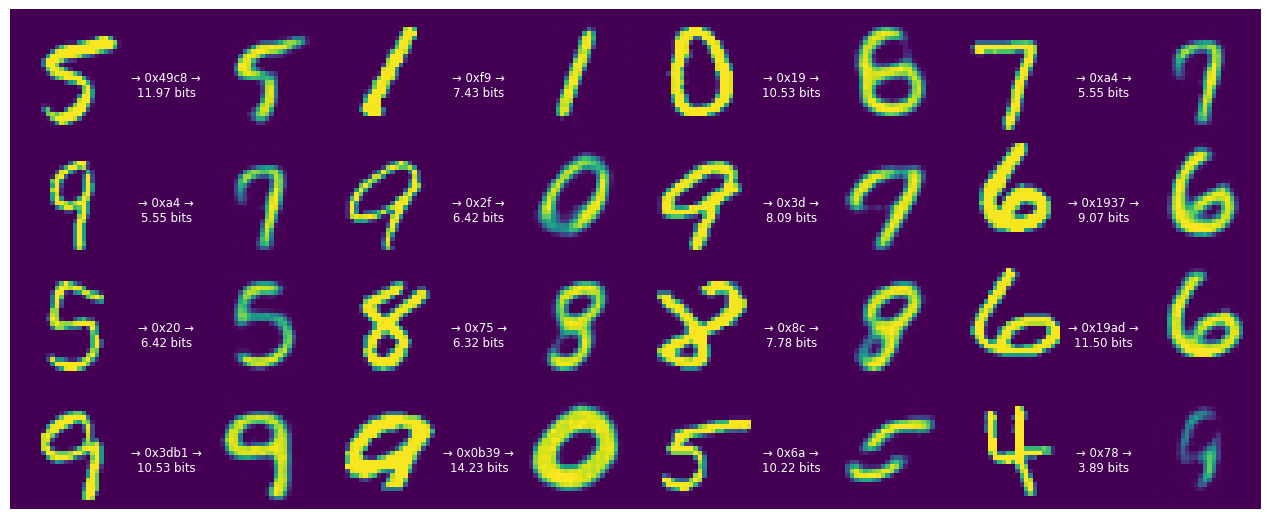

In [ ]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [ ]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

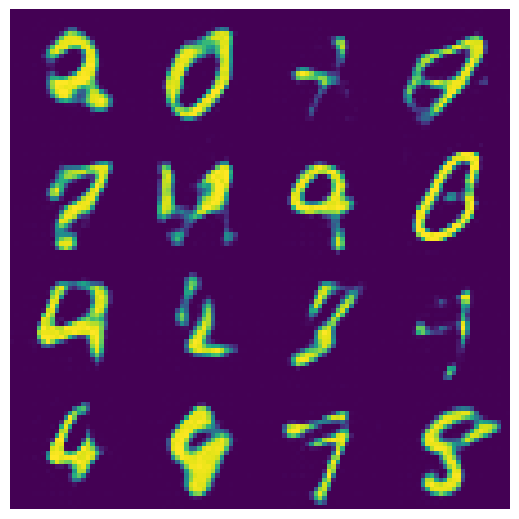

In [ ]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
